PyTorch UNet implementation using IceNet library for data download and post-processing of sea ice forecasting.

This notebook has been designed to be independent of other notebooks.

### Highlights
The key features of this notebook are:
* [1. Download](#1.-Download) 
* [2. Data Processing](#2.-Data-Processing)
* [3. Train](#3.-Train)
* [4. Prediction](#4.-Prediction)
* [5. Outputs and Plotting](#5.-Outputs-and-Plotting)

Please note that this notebook relies on a pytorch data loader implementation which is only available from icenet v0.2.8+.

To install the necessary python packages, you can use the conda `icenet-notebooks/pytorch/environment.yml` environment file on a Linux system to be able to set-up the necessary pytorch + tensorflow + CUDA + other modules which could be a tricky mix to get working manually:

```bash
conda env create -f environment.yml
```

### Contributions
#### PyTorch implementation of UnetDiffusion
Maria Carolina Novitasari

#### PyTorch implementation of IceNet

Andrew McDonald ([icenet-gan](https://github.com/ampersandmcd/icenet-gan))

Bryn Noel Ubald (Refactor, updates for daily predictions and matching icenet library)

#### Notebook
Bryn Noel Ubald (author)

#### PyTorch Integration
Bryn Noel Ubald

Ryan Chan

### How to Download Daily Data for IceNet

#### DOWNLOAD SIC Data  

To download Sea Ice Concentration (SIC) data, modify the script below with the desired date range:

```python
sic = SICDownloader(
    dates=[
        pd.to_datetime(date).date()  # Dates to download SIC data for
        for date in pd.date_range("2020-01-01", "2020-12-31", freq="D")
    ],
    delete_tempfiles=True,           # Delete temporary downloaded files after use
    north=False,                     # Use mask for the Northern Hemisphere (set to True if needed)
    south=True,                      # Use mask for the Southern Hemisphere
    parallel_opens=True,             # Enable parallel processing with dask.delayed
)

sic.download()
```

#### Download ERA5 Data  

##### Setup ERA5 API

Use the following link to set up the ERA5 API: [https://cds.climate.copernicus.eu/how-to-api?](https://cds.climate.copernicus.eu/how-to-api?).

Run the following script with your desired dates:

#### ERA5 Downloader  

```python
import pandas as pd
from icenet.data.interfaces.cds import ERA5Downloader

era5 = ERA5Downloader(
    var_names=["tas", "zg", "uas", "vas"],      # Name of variables to download
    dates=[                                     # Dates to download the variable data for
        pd.to_datetime(date).date()
        for date in pd.date_range("2020-01-01", "2020-12-31", freq="D")
    ],
    path="./data",                              # Location to download data to (default is `./data`)
    delete_tempfiles=True,                      # Whether to delete temporary downloaded files
    levels=[None, [250, 500], None, None],      # The levels at which to obtain the variables for (e.g. for zg, it is the pressure levels)
    max_threads=4,                              # Maximum number of concurrent downloads
    north=False,                                # Boolean: Whether require data across northern hemisphere
    south=True,                                 # Boolean: Whether require data across southern hemisphere
    use_toolbox=False)                          # Experimental, alternative download method

era5.download()                                 # Start downloading
```

The prototype data currently in use (South Pole, 2020) can be downloaded from **Baskerville** at the following path: `/vjgo8416-ice-frcst/shared/prototype_data/`

In [1]:
import os
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import Tuple
from torchmetrics import Metric
import lightning.pytorch as pl
from lightning.pytorch.utilities.types import TRAIN_DATALOADERS
from torchmetrics import MetricCollection
from torch_ema import ExponentialMovingAverage
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

# We also set the logging level so that we get some feedback from the API
import logging
logging.basicConfig(level=logging.INFO)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_float32_matmul_precision('medium')

In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
print(os.getcwd())

from models import GaussianDiffusion, UNetDiffusion, LitDiffusion
from trainers import train_diffusion_icenet

/bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks


2025-08-08 13:33:11.487341: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-08 13:33:11.534025: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-08 13:33:11.534059: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-08 13:33:11.535607: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-08 13:33:11.545544: I tensorflow/core/platform/cpu_feature_guar

In [3]:
from datetime import datetime
import sys

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# sys.stdout = open(f'training_logs/training_log_{timestamp}.txt', 'w')

## 1. Download

In [4]:
import numpy
from icenet.data.sic.mask import Masks
from icenet.data.interfaces.cds import ERA5Downloader
from icenet.data.sic.osisaf import SICDownloader

In [5]:
# Unset SLURM_NTASKS if it's causing issues
if "SLURM_NTASKS" in os.environ:
    del os.environ["SLURM_NTASKS"]

# Optionally, set SLURM_NTASKS_PER_NODE if needed
os.environ["SLURM_NTASKS_PER_NODE"] = "1"  # or whatever value is appropriate

### Mask data

Create masks for masking data.

In [6]:
masks = Masks(north=False, south=True)
masks.generate(save_polarhole_masks=False)

INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_01.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_02.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_03.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_04.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_05.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_06.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_07.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_08.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_09.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_10.npy, already exists
INFO:root:Skipping ./data/masks/south/masks/active_grid_cell_mask_11.npy, already exists
INFO:root:Skipping ./

### Climate and Sea Ice data

Download climate variables from ERA5 and sea ice concentration from OSI-SAF.

In [7]:
era5 = ERA5Downloader(
    var_names=["tas", "zg", "uas", "vas"],
    levels=[None, [250, 500], None, None],
    dates=[pd.to_datetime(date).date() for date in
           # pd.date_range("2020-01-01", "2020-04-30", freq="D")],
           pd.date_range("2018-01-01", "2020-12-31", freq="D")],
    delete_tempfiles=False,
    max_threads=64,
    north=False,
    south=True,
    # NOTE: there appears to be a bug with the toolbox API at present (icenet#54)
    use_toolbox=False
)

# era5.download()

2025-08-08 13:33:15,292 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:root:Upping connection limit for max_threads > 10


In [8]:
sic = SICDownloader(
    dates=[pd.to_datetime(date).date() for date in
           # pd.date_range("2020-01-01", "2020-04-30", freq="D")],
           pd.date_range("2018-01-01", "2020-12-31", freq="D")],
    delete_tempfiles=False,
    north=False,
    south=True,
    parallel_opens=False,
)

# sic.download()

Re-grid ERA5 reanalysis data, and rotate wind vector data from ERA5 to align with EASE2 projection.

In [9]:
era5.regrid()
era5.rotate_wind_data()

INFO:root:No regrid batches to processing, moving on...
INFO:root:Rotating wind data prior to merging
INFO:root:Rotating wind data in ./data/era5/south/uas ./data/era5/south/vas
INFO:root:0 files for uas
INFO:root:0 files for vas
INFO:root:Rotating wind data in ./data/era5/south/uas ./data/era5/south/vas
INFO:root:0 files for uas
INFO:root:0 files for vas


## 2. Data Processing

Process downloaded datasets.

To make life easier, setting up train, val, test dates.

In [10]:
processing_dates = dict(
    train=[pd.to_datetime(el) for el in pd.date_range("2020-01-01", "2020-03-31")],
    val=[pd.to_datetime(el) for el in pd.date_range("2020-04-03", "2020-04-23")],
    test=[pd.to_datetime(el) for el in pd.date_range("2020-04-01", "2020-04-02")],
)
processed_name = "notebook_api_pytorch_data"

Next, we create the data producer and configure them for the dataset we want to create.

In [11]:
from icenet.data.processors.era5 import IceNetERA5PreProcessor
from icenet.data.processors.meta import IceNetMetaPreProcessor
from icenet.data.processors.osi import IceNetOSIPreProcessor

pp = IceNetERA5PreProcessor(
    ["uas", "vas"],
    ["tas", "zg500", "zg250"],
    processed_name,
    processing_dates["train"],
    processing_dates["val"],
    processing_dates["test"],
    linear_trends=tuple(),
    north=False,
    south=True
)

osi = IceNetOSIPreProcessor(
    ["siconca"],
    [],
    processed_name,
    processing_dates["train"],
    processing_dates["val"],
    processing_dates["test"],
    linear_trends=tuple(),
    north=False,
    south=True
)

meta = IceNetMetaPreProcessor(
    processed_name,
    north=False,
    south=True
)

Next, we initialise the data processors using `init_source_data` which scans the data source directories to understand what data is available for processing based on the parameters. Since we named the processed data `"notebook_api_data"` above, it will create a data loader config file, `loader.notebook_api_data.json`, in the current directory.

In [12]:
# Causes hanging on training, when generating sample.
pp.init_source_data(
    lag_days=1,
)
pp.process()

osi.init_source_data(
    lag_days=1,
)
osi.process()

meta.process()

INFO:root:Processing 91 dates for train category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:No data found for 2019-12-31, outside data boundary perhaps?
INFO:root:Processing 21 dates for val category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:Processing 2 dates for test category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:Got 1 files for tas
INFO:root:Got 1 files for uas
INFO:root:Got 1 files for vas
INFO:root:Got 1 files for zg250
INFO:root:Got 1 files for zg500
INFO:root:Opening files for uas
INFO:root:Filtered to 121 units long based on configuration requirements
INFO:root:Normalising uas
INFO:root:Opening files for vas
INFO:root:Filtered to 121 units long based on configuration requirements
INFO:root:Normalising vas
INFO:root:Opening files for tas
INFO:root:Filtered to 121 units long based on configuration requirements
INFO:root:Reusing climatology ./processed/notebook_api_

At this point the preprocessed data is ready to convert or create a configuration for the network dataset.

### Dataset creation

As with the `icenet_dataset_create` command we can create a dataset configuration for training the network. As before this can include cached data for the network in the format of a TFRecordDataset compatible set of tfrecords. To achieve this we create the `IceNetDataLoader`, which can both generate `IceNetDataSet` configurations (which easily provide the necessary functionality for training and prediction) as well as individual data samples for direct usage.

In [13]:
from icenet.data.loaders import IceNetDataLoaderFactory

implementation = "dask"
loader_config = "loader.notebook_api_pytorch_data.json"
dataset_name = "notebook_api_pytorch_data"
lag = 1

dl = IceNetDataLoaderFactory().create_data_loader(
    implementation,
    loader_config,
    dataset_name,
    lag,
    n_forecast_days=7,
    north=False,
    south=True,
    output_batch_size=1,
    generate_workers=4)

INFO:root:Loading configuration loader.notebook_api_pytorch_data.json


At this point we can either use `generate` or `write_dataset_config_only` to produce a ready-to-go `IceNetDataSet` configuration. Both of these will generate a dataset config, `dataset_config.notebook_api_pytorch_data.json` (recall we set the dataset name as `notebook_api_pytorch_data` above).

In this case, for pytorch, will read data in directly, rather than using cached tfrecords inputs.

In [14]:
dl.write_dataset_config_only()

INFO:root:Writing dataset configuration without data generation
INFO:root:91 train dates in total, NOT generating cache data.
INFO:root:21 val dates in total, NOT generating cache data.
INFO:root:2 test dates in total, NOT generating cache data.
INFO:root:Writing configuration to ./dataset_config.notebook_api_pytorch_data.json


We can now create the IceNetDataSet object:

In [15]:
from icenet.data.dataset import IceNetDataSetPyTorch
dataset_config = f"dataset_config.{dataset_name}.json"

## 3. Train

We implement a custom PyTorch class for training.

## IceNet2 U-Net Diffusion model

Maria's work (PyTorch Diffusion using U-Net)

In [16]:
class Interpolate(nn.Module):
    def __init__(self, scale_factor, mode):
        super().__init__()
        self.interp = F.interpolate
        self.scale_factor = scale_factor
        self.mode = mode

    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale_factor, mode=self.mode)
        return x

Define custom metrics for use in validation and monitoring

Define custom loss functions

A _LightningModule_ wrapper for UNetDiffusion model.

Function for training UNetDiffusion model using PyTorch Lightning.

Conduct actual training run.

In [17]:
seed = 45

# Training configuration
learning_rate = 5e-4 
max_epochs = 70 
filter_size = 3
n_filters_factor = 0.5
timesteps = 1000

batch_size = 8 
shuffle = False
persistent_workers=True
num_workers = 8

# Call the training function
model, trainer, checkpoint_callback = train_diffusion_icenet(
    configuration_path=dataset_config,
    learning_rate=learning_rate,
    max_epochs=max_epochs,
    batch_size=batch_size,
    n_workers=num_workers,
    filter_size=filter_size,
    n_filters_factor=n_filters_factor,
    seed=seed,
    timesteps=timesteps,
    persistent_workers=persistent_workers
) 

[rank: 0] Seed set to 45
INFO:root:Loading configuration dataset_config.notebook_api_pytorch_data.json
INFO:root:Loading configuration /bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/loader.notebook_api_pytorch_data.json
INFO:root:Loading configuration dataset_config.notebook_api_pytorch_data.json
INFO:root:Loading configuration /bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/loader.notebook_api_pytorch_data.json
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/dat

Input x shape: torch.Size([8, 432, 432, 9])
Input x dtype: torch.float32
Target y shape: torch.Size([8, 432, 432, 7, 1])
Target y dtype: torch.float32
Sample weight shape: torch.Size([8, 432, 432, 7, 1])
Sample weight dtype: torch.float32


/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommend

Training 91 examples / 12 batches (batch size 8).
Validating 21 examples / 3 batches (batch size 8).


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | model        | UNetDiffusion    | 4.1 M  | train
1 | criterion    | WeightedMSELoss  | 0      | train
2 | metrics      | MetricCollection | 0      | train
3 | test_metrics | MetricCollection | 0      | train
----------------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.334    Total estimated model params size (MB)
128       Modules in train mode
0         Modules in eval mode
/bask/homes/l/ll

[LitDiffusion] Moving EMA shadow parameters to device: cuda:0


/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/torch/nn/modules/conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv2d(


Epoch 0:   0%|          | 0/12 [00:00<?, ?it/s]                            

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Step 0: Loss 1.1032
Epoch 0:   8%|▊         | 1/12 [00:05<01:03,  0.17it/s, v_num=1077052, train_loss_step=1.100]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 0:  17%|█▋        | 2/12 [00:05<00:29,  0.34it/s, v_num=1077052, train_loss_step=0.862]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 0:  25%|██▌       | 3/12 [00:06<00:18,  0.49it/s, v_num=1077052, train_loss_step=0.727]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 0:  33%|███▎      | 4/12 [00:06<00:12,  0.63it/s, v_num=1077052, train_loss_step=0.713]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 0:  42%|████▏     | 5/12 [00:06<00:09,  0.77it/s, v_num=1077052, train_loss_step=0.617]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 0:  50%|█████     | 6/12 [00:06<00:06,  0.90it/s, v_num=1077052, train_loss_step=0.609]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 0:  58%|█████▊    | 7/12 [00:06<00:04,  1.02it/s, v_num=1077052, train_loss_step=0.593]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 0:  67%|██████▋   | 8/12 [00:07<00:03,  1.14it/s, v_num=1077052, train_loss_step=0.650]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 0: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s, v_num=1077052, train_loss_step=0.599]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 0: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.599, val_loss=420.0, val_accuracy=54.60, val_accuracy_0=56.20, val_accuracy_1=56.00, val_accuracy_2=57.00, val_accuracy_3=54.80, val_accuracy_4=52.40, val_accuracy_5=52.00, val_accuracy_6=53.80, val_sieerror=5.07e+9, val_sieerror_0=6.42e+8, val_sieerror_1=6.43e+8, val_sieerror_2=5.18e+8, val_sieerror_3=6.85e+8, val_sieerror_4=8.89e+8, val_sieerror_5=8.96e+8, val_sieerror_6=8.01e+8, train_loss_epoch=0.678]

Metric val_accuracy improved. New best score: 54.574


Epoch 1:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.599, val_loss=420.0, val_accuracy=54.60, val_accuracy_0=56.20, val_accuracy_1=56.00, val_accuracy_2=57.00, val_accuracy_3=54.80, val_accuracy_4=52.40, val_accuracy_5=52.00, val_accuracy_6=53.80, val_sieerror=5.07e+9, val_sieerror_0=6.42e+8, val_sieerror_1=6.43e+8, val_sieerror_2=5.18e+8, val_sieerror_3=6.85e+8, val_sieerror_4=8.89e+8, val_sieerror_5=8.96e+8, val_sieerror_6=8.01e+8, train_loss_epoch=0.678]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 1:  25%|██▌       | 3/12 [00:05<00:16,  0.54it/s, v_num=1077052, train_loss_step=0.698, val_loss=420.0, val_accuracy=54.60, val_accuracy_0=56.20, val_accuracy_1=56.00, val_accuracy_2=57.00, val_accuracy_3=54.80, val_accuracy_4=52.40, val_accuracy_5=52.00, val_accuracy_6=53.80, val_sieerror=5.07e+9, val_sieerror_0=6.42e+8, val_sieerror_1=6.43e+8, val_sieerror_2=5.18e+8, val_sieerror_3=6.85e+8, val_sieerror_4=8.89e+8, val_sieerror_5=8.96e+8, val_sieerror_6=8.01e+8, train_loss_epoch=0.678]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 1:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.474, val_loss=420.0, val_accuracy=54.60, val_accuracy_0=56.20, val_accuracy_1=56.00, val_accuracy_2=57.00, val_accuracy_3=54.80, val_accuracy_4=52.40, val_accuracy_5=52.00, val_accuracy_6=53.80, val_sieerror=5.07e+9, val_sieerror_0=6.42e+8, val_sieerror_1=6.43e+8, val_sieerror_2=5.18e+8, val_sieerror_3=6.85e+8, val_sieerror_4=8.89e+8, val_sieerror_5=8.96e+8, val_sieerror_6=8.01e+8, train_loss_epoch=0.678]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 1:  50%|█████     | 6/12 [00:06<00:06,  0.99it/s, v_num=1077052, train_loss_step=0.626, val_loss=420.0, val_accuracy=54.60, val_accuracy_0=56.20, val_accuracy_1=56.00, val_accuracy_2=57.00, val_accuracy_3=54.80, val_accuracy_4=52.40, val_accuracy_5=52.00, val_accuracy_6=53.80, val_sieerror=5.07e+9, val_sieerror_0=6.42e+8, val_sieerror_1=6.43e+8, val_sieerror_2=5.18e+8, val_sieerror_3=6.85e+8, val_sieerror_4=8.89e+8, val_sieerror_5=8.96e+8, val_sieerror_6=8.01e+8, train_loss_epoch=0.678]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 1:  50%|█████     | 6/12 [00:06<00:06,  0.98it/s, v_num=1077052, train_loss_step=0.526, val_loss=420.0, val_accuracy=54.60, val_accuracy_0=56.20, val_accuracy_1=56.00, val_accuracy_2=57.00, val_accuracy_3=54.80, val_accuracy_4=52.40, val_accuracy_5=52.00, val_accuracy_6=53.80, val_sieerror=5.07e+9, val_sieerror_0=6.42e+8, val_sieerror_1=6.43e+8, val_sieerror_2=5.18e+8, val_sieerror_3=6.85e+8, val_sieerror_4=8.89e+8, val_sieerror_5=8.96e+8, val_sieerror_6=8.01e+8, train_loss_epoch=0.678]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 1:  58%|█████▊    | 7/12 [00:06<00:04,  1.12it/s, v_num=1077052, train_loss_step=0.526, val_loss=420.0, val_accuracy=54.60, val_accuracy_0=56.20, val_accuracy_1=56.00, val_accuracy_2=57.00, val_accuracy_3=54.80, val_accuracy_4=52.40, val_accuracy_5=52.00, val_accuracy_6=53.80, val_sieerror=5.07e+9, val_sieerror_0=6.42e+8, val_sieerror_1=6.43e+8, val_sieerror_2=5.18e+8, val_sieerror_3=6.85e+8, val_sieerror_4=8.89e+8, val_sieerror_5=8.96e+8, val_sieerror_6=8.01e+8, train_loss_epoch=0.678]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 1:  67%|██████▋   | 8/12 [00:06<00:03,  1.23it/s, v_num=1077052, train_loss_step=0.702, val_loss=420.0, val_accuracy=54.60, val_accuracy_0=56.20, val_accuracy_1=56.00, val_accuracy_2=57.00, val_accuracy_3=54.80, val_accuracy_4=52.40, val_accuracy_5=52.00, val_accuracy_6=53.80, val_sieerror=5.07e+9, val_sieerror_0=6.42e+8, val_sieerror_1=6.43e+8, val_sieerror_2=5.18e+8, val_sieerror_3=6.85e+8, val_sieerror_4=8.89e+8, val_sieerror_5=8.96e+8, val_sieerror_6=8.01e+8, train_loss_epoch=0.678]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 1: 100%|██████████| 12/12 [00:10<00:00,  1.20it/s, v_num=1077052, train_loss_step=0.838, val_loss=420.0, val_accuracy=54.60, val_accuracy_0=56.20, val_accuracy_1=56.00, val_accuracy_2=57.00, val_accuracy_3=54.80, val_accuracy_4=52.40, val_accuracy_5=52.00, val_accuracy_6=53.80, val_sieerror=5.07e+9, val_sieerror_0=6.42e+8, val_sieerror_1=6.43e+8, val_sieerror_2=5.18e+8, val_sieerror_3=6.85e+8, val_sieerror_4=8.89e+8, val_sieerror_5=8.96e+8, val_sieerror_6=8.01e+8, train_loss_epoch=0.678]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 1: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.838, val_loss=382.0, val_accuracy=57.00, val_accuracy_0=58.50, val_accuracy_1=56.60, val_accuracy_2=58.60, val_accuracy_3=53.90, val_accuracy_4=57.70, val_accuracy_5=57.10, val_accuracy_6=56.70, val_sieerror=6.16e+9, val_sieerror_0=8.82e+8, val_sieerror_1=8.63e+8, val_sieerror_2=8.11e+8, val_sieerror_3=9.07e+8, val_sieerror_4=8.41e+8, val_sieerror_5=1.02e+9, val_sieerror_6=8.4e+8, train_loss_epoch=0.605] 

Metric val_accuracy improved by 2.444 >= min_delta = 0.0. New best score: 57.018


Epoch 2:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.838, val_loss=382.0, val_accuracy=57.00, val_accuracy_0=58.50, val_accuracy_1=56.60, val_accuracy_2=58.60, val_accuracy_3=53.90, val_accuracy_4=57.70, val_accuracy_5=57.10, val_accuracy_6=56.70, val_sieerror=6.16e+9, val_sieerror_0=8.82e+8, val_sieerror_1=8.63e+8, val_sieerror_2=8.11e+8, val_sieerror_3=9.07e+8, val_sieerror_4=8.41e+8, val_sieerror_5=1.02e+9, val_sieerror_6=8.4e+8, train_loss_epoch=0.605]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 2:   8%|▊         | 1/12 [00:05<00:57,  0.19it/s, v_num=1077052, train_loss_step=0.838, val_loss=382.0, val_accuracy=57.00, val_accuracy_0=58.50, val_accuracy_1=56.60, val_accuracy_2=58.60, val_accuracy_3=53.90, val_accuracy_4=57.70, val_accuracy_5=57.10, val_accuracy_6=56.70, val_sieerror=6.16e+9, val_sieerror_0=8.82e+8, val_sieerror_1=8.63e+8, val_sieerror_2=8.11e+8, val_sieerror_3=9.07e+8, val_sieerror_4=8.41e+8, val_sieerror_5=1.02e+9, val_sieerror_6=8.4e+8, train_loss_epoch=0.605]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 2:  25%|██▌       | 3/12 [00:05<00:16,  0.54it/s, v_num=1077052, train_loss_step=0.561, val_loss=382.0, val_accuracy=57.00, val_accuracy_0=58.50, val_accuracy_1=56.60, val_accuracy_2=58.60, val_accuracy_3=53.90, val_accuracy_4=57.70, val_accuracy_5=57.10, val_accuracy_6=56.70, val_sieerror=6.16e+9, val_sieerror_0=8.82e+8, val_sieerror_1=8.63e+8, val_sieerror_2=8.11e+8, val_sieerror_3=9.07e+8, val_sieerror_4=8.41e+8, val_sieerror_5=1.02e+9, val_sieerror_6=8.4e+8, train_loss_epoch=0.605]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 2:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.430, val_loss=382.0, val_accuracy=57.00, val_accuracy_0=58.50, val_accuracy_1=56.60, val_accuracy_2=58.60, val_accuracy_3=53.90, val_accuracy_4=57.70, val_accuracy_5=57.10, val_accuracy_6=56.70, val_sieerror=6.16e+9, val_sieerror_0=8.82e+8, val_sieerror_1=8.63e+8, val_sieerror_2=8.11e+8, val_sieerror_3=9.07e+8, val_sieerror_4=8.41e+8, val_sieerror_5=1.02e+9, val_sieerror_6=8.4e+8, train_loss_epoch=0.605]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 2:  42%|████▏     | 5/12 [00:06<00:08,  0.83it/s, v_num=1077052, train_loss_step=0.495, val_loss=382.0, val_accuracy=57.00, val_accuracy_0=58.50, val_accuracy_1=56.60, val_accuracy_2=58.60, val_accuracy_3=53.90, val_accuracy_4=57.70, val_accuracy_5=57.10, val_accuracy_6=56.70, val_sieerror=6.16e+9, val_sieerror_0=8.82e+8, val_sieerror_1=8.63e+8, val_sieerror_2=8.11e+8, val_sieerror_3=9.07e+8, val_sieerror_4=8.41e+8, val_sieerror_5=1.02e+9, val_sieerror_6=8.4e+8, train_loss_epoch=0.605]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 2:  50%|█████     | 6/12 [00:06<00:06,  0.98it/s, v_num=1077052, train_loss_step=0.495, val_loss=382.0, val_accuracy=57.00, val_accuracy_0=58.50, val_accuracy_1=56.60, val_accuracy_2=58.60, val_accuracy_3=53.90, val_accuracy_4=57.70, val_accuracy_5=57.10, val_accuracy_6=56.70, val_sieerror=6.16e+9, val_sieerror_0=8.82e+8, val_sieerror_1=8.63e+8, val_sieerror_2=8.11e+8, val_sieerror_3=9.07e+8, val_sieerror_4=8.41e+8, val_sieerror_5=1.02e+9, val_sieerror_6=8.4e+8, train_loss_epoch=0.605]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 2:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.437, val_loss=382.0, val_accuracy=57.00, val_accuracy_0=58.50, val_accuracy_1=56.60, val_accuracy_2=58.60, val_accuracy_3=53.90, val_accuracy_4=57.70, val_accuracy_5=57.10, val_accuracy_6=56.70, val_sieerror=6.16e+9, val_sieerror_0=8.82e+8, val_sieerror_1=8.63e+8, val_sieerror_2=8.11e+8, val_sieerror_3=9.07e+8, val_sieerror_4=8.41e+8, val_sieerror_5=1.02e+9, val_sieerror_6=8.4e+8, train_loss_epoch=0.605]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 2:  67%|██████▋   | 8/12 [00:06<00:03,  1.21it/s, v_num=1077052, train_loss_step=0.420, val_loss=382.0, val_accuracy=57.00, val_accuracy_0=58.50, val_accuracy_1=56.60, val_accuracy_2=58.60, val_accuracy_3=53.90, val_accuracy_4=57.70, val_accuracy_5=57.10, val_accuracy_6=56.70, val_sieerror=6.16e+9, val_sieerror_0=8.82e+8, val_sieerror_1=8.63e+8, val_sieerror_2=8.11e+8, val_sieerror_3=9.07e+8, val_sieerror_4=8.41e+8, val_sieerror_5=1.02e+9, val_sieerror_6=8.4e+8, train_loss_epoch=0.605]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 2: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s, v_num=1077052, train_loss_step=0.647, val_loss=382.0, val_accuracy=57.00, val_accuracy_0=58.50, val_accuracy_1=56.60, val_accuracy_2=58.60, val_accuracy_3=53.90, val_accuracy_4=57.70, val_accuracy_5=57.10, val_accuracy_6=56.70, val_sieerror=6.16e+9, val_sieerror_0=8.82e+8, val_sieerror_1=8.63e+8, val_sieerror_2=8.11e+8, val_sieerror_3=9.07e+8, val_sieerror_4=8.41e+8, val_sieerror_5=1.02e+9, val_sieerror_6=8.4e+8, train_loss_epoch=0.605]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Validation DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([



Epoch 2: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.647, val_loss=284.0, val_accuracy=64.20, val_accuracy_0=66.30, val_accuracy_1=60.60, val_accuracy_2=69.10, val_accuracy_3=62.00, val_accuracy_4=63.50, val_accuracy_5=63.70, val_accuracy_6=64.50, val_sieerror=6.11e+9, val_sieerror_0=8.5e+8, val_sieerror_1=9.33e+8, val_sieerror_2=8.2e+8, val_sieerror_3=8.31e+8, val_sieerror_4=9.05e+8, val_sieerror_5=9.4e+8, val_sieerror_6=8.32e+8, train_loss_epoch=0.513]  

Metric val_accuracy improved by 7.229 >= min_delta = 0.0. New best score: 64.248


Epoch 3:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.647, val_loss=284.0, val_accuracy=64.20, val_accuracy_0=66.30, val_accuracy_1=60.60, val_accuracy_2=69.10, val_accuracy_3=62.00, val_accuracy_4=63.50, val_accuracy_5=63.70, val_accuracy_6=64.50, val_sieerror=6.11e+9, val_sieerror_0=8.5e+8, val_sieerror_1=9.33e+8, val_sieerror_2=8.2e+8, val_sieerror_3=8.31e+8, val_sieerror_4=9.05e+8, val_sieerror_5=9.4e+8, val_sieerror_6=8.32e+8, train_loss_epoch=0.513]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 3:   8%|▊         | 1/12 [00:05<00:58,  0.19it/s, v_num=1077052, train_loss_step=0.351, val_loss=284.0, val_accuracy=64.20, val_accuracy_0=66.30, val_accuracy_1=60.60, val_accuracy_2=69.10, val_accuracy_3=62.00, val_accuracy_4=63.50, val_accuracy_5=63.70, val_accuracy_6=64.50, val_sieerror=6.11e+9, val_sieerror_0=8.5e+8, val_sieerror_1=9.33e+8, val_sieerror_2=8.2e+8, val_sieerror_3=8.31e+8, val_sieerror_4=9.05e+8, val_sieerror_5=9.4e+8, val_sieerror_6=8.32e+8, train_loss_epoch=0.513]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 3:  17%|█▋        | 2/12 [00:05<00:28,  0.35it/s, v_num=1077052, train_loss_step=0.351, val_loss=284.0, val_accuracy=64.20, val_accuracy_0=66.30, val_accuracy_1=60.60, val_accuracy_2=69.10, val_accuracy_3=62.00, val_accuracy_4=63.50, val_accuracy_5=63.70, val_accuracy_6=64.50, val_sieerror=6.11e+9, val_sieerror_0=8.5e+8, val_sieerror_1=9.33e+8, val_sieerror_2=8.2e+8, val_sieerror_3=8.31e+8, val_sieerror_4=9.05e+8, val_sieerror_5=9.4e+8, val_sieerror_6=8.32e+8, train_loss_epoch=0.513]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 3:  33%|███▎      | 4/12 [00:06<00:12,  0.65it/s, v_num=1077052, train_loss_step=0.265, val_loss=284.0, val_accuracy=64.20, val_accuracy_0=66.30, val_accuracy_1=60.60, val_accuracy_2=69.10, val_accuracy_3=62.00, val_accuracy_4=63.50, val_accuracy_5=63.70, val_accuracy_6=64.50, val_sieerror=6.11e+9, val_sieerror_0=8.5e+8, val_sieerror_1=9.33e+8, val_sieerror_2=8.2e+8, val_sieerror_3=8.31e+8, val_sieerror_4=9.05e+8, val_sieerror_5=9.4e+8, val_sieerror_6=8.32e+8, train_loss_epoch=0.513]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 3:  42%|████▏     | 5/12 [00:06<00:08,  0.80it/s, v_num=1077052, train_loss_step=0.265, val_loss=284.0, val_accuracy=64.20, val_accuracy_0=66.30, val_accuracy_1=60.60, val_accuracy_2=69.10, val_accuracy_3=62.00, val_accuracy_4=63.50, val_accuracy_5=63.70, val_accuracy_6=64.50, val_sieerror=6.11e+9, val_sieerror_0=8.5e+8, val_sieerror_1=9.33e+8, val_sieerror_2=8.2e+8, val_sieerror_3=8.31e+8, val_sieerror_4=9.05e+8, val_sieerror_5=9.4e+8, val_sieerror_6=8.32e+8, train_loss_epoch=0.513]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 3:  42%|████▏     | 5/12 [00:06<00:08,  0.79it/s, v_num=1077052, train_loss_step=0.526, val_loss=284.0, val_accuracy=64.20, val_accuracy_0=66.30, val_accuracy_1=60.60, val_accuracy_2=69.10, val_accuracy_3=62.00, val_accuracy_4=63.50, val_accuracy_5=63.70, val_accuracy_6=64.50, val_sieerror=6.11e+9, val_sieerror_0=8.5e+8, val_sieerror_1=9.33e+8, val_sieerror_2=8.2e+8, val_sieerror_3=8.31e+8, val_sieerror_4=9.05e+8, val_sieerror_5=9.4e+8, val_sieerror_6=8.32e+8, train_loss_epoch=0.513]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 3:  58%|█████▊    | 7/12 [00:06<00:04,  1.05it/s, v_num=1077052, train_loss_step=0.468, val_loss=284.0, val_accuracy=64.20, val_accuracy_0=66.30, val_accuracy_1=60.60, val_accuracy_2=69.10, val_accuracy_3=62.00, val_accuracy_4=63.50, val_accuracy_5=63.70, val_accuracy_6=64.50, val_sieerror=6.11e+9, val_sieerror_0=8.5e+8, val_sieerror_1=9.33e+8, val_sieerror_2=8.2e+8, val_sieerror_3=8.31e+8, val_sieerror_4=9.05e+8, val_sieerror_5=9.4e+8, val_sieerror_6=8.32e+8, train_loss_epoch=0.513]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 3:  67%|██████▋   | 8/12 [00:06<00:03,  1.17it/s, v_num=1077052, train_loss_step=0.528, val_loss=284.0, val_accuracy=64.20, val_accuracy_0=66.30, val_accuracy_1=60.60, val_accuracy_2=69.10, val_accuracy_3=62.00, val_accuracy_4=63.50, val_accuracy_5=63.70, val_accuracy_6=64.50, val_sieerror=6.11e+9, val_sieerror_0=8.5e+8, val_sieerror_1=9.33e+8, val_sieerror_2=8.2e+8, val_sieerror_3=8.31e+8, val_sieerror_4=9.05e+8, val_sieerror_5=9.4e+8, val_sieerror_6=8.32e+8, train_loss_epoch=0.513]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 3: 100%|██████████| 12/12 [00:10<00:00,  1.13it/s, v_num=1077052, train_loss_step=0.508, val_loss=284.0, val_accuracy=64.20, val_accuracy_0=66.30, val_accuracy_1=60.60, val_accuracy_2=69.10, val_accuracy_3=62.00, val_accuracy_4=63.50, val_accuracy_5=63.70, val_accuracy_6=64.50, val_sieerror=6.11e+9, val_sieerror_0=8.5e+8, val_sieerror_1=9.33e+8, val_sieerror_2=8.2e+8, val_sieerror_3=8.31e+8, val_sieerror_4=9.05e+8, val_sieerror_5=9.4e+8, val_sieerror_6=8.32e+8, train_loss_epoch=0.513]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 3: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.508, val_loss=236.0, val_accuracy=68.00, val_accuracy_0=70.80, val_accuracy_1=64.90, val_accuracy_2=73.90, val_accuracy_3=64.70, val_accuracy_4=66.50, val_accuracy_5=67.40, val_accuracy_6=68.00, val_sieerror=5.54e+9, val_sieerror_0=8.09e+8, val_sieerror_1=8.24e+8, val_sieerror_2=6.96e+8, val_sieerror_3=7.77e+8, val_sieerror_4=8.54e+8, val_sieerror_5=8.29e+8, val_sieerror_6=7.49e+8, train_loss_epoch=0.407]

Metric val_accuracy improved by 3.776 >= min_delta = 0.0. New best score: 68.023


Epoch 4:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.508, val_loss=236.0, val_accuracy=68.00, val_accuracy_0=70.80, val_accuracy_1=64.90, val_accuracy_2=73.90, val_accuracy_3=64.70, val_accuracy_4=66.50, val_accuracy_5=67.40, val_accuracy_6=68.00, val_sieerror=5.54e+9, val_sieerror_0=8.09e+8, val_sieerror_1=8.24e+8, val_sieerror_2=6.96e+8, val_sieerror_3=7.77e+8, val_sieerror_4=8.54e+8, val_sieerror_5=8.29e+8, val_sieerror_6=7.49e+8, train_loss_epoch=0.407]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 4:   8%|▊         | 1/12 [00:05<00:58,  0.19it/s, v_num=1077052, train_loss_step=0.371, val_loss=236.0, val_accuracy=68.00, val_accuracy_0=70.80, val_accuracy_1=64.90, val_accuracy_2=73.90, val_accuracy_3=64.70, val_accuracy_4=66.50, val_accuracy_5=67.40, val_accuracy_6=68.00, val_sieerror=5.54e+9, val_sieerror_0=8.09e+8, val_sieerror_1=8.24e+8, val_sieerror_2=6.96e+8, val_sieerror_3=7.77e+8, val_sieerror_4=8.54e+8, val_sieerror_5=8.29e+8, val_sieerror_6=7.49e+8, train_loss_epoch=0.407]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 4:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.283, val_loss=236.0, val_accuracy=68.00, val_accuracy_0=70.80, val_accuracy_1=64.90, val_accuracy_2=73.90, val_accuracy_3=64.70, val_accuracy_4=66.50, val_accuracy_5=67.40, val_accuracy_6=68.00, val_sieerror=5.54e+9, val_sieerror_0=8.09e+8, val_sieerror_1=8.24e+8, val_sieerror_2=6.96e+8, val_sieerror_3=7.77e+8, val_sieerror_4=8.54e+8, val_sieerror_5=8.29e+8, val_sieerror_6=7.49e+8, train_loss_epoch=0.407]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 4:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.324, val_loss=236.0, val_accuracy=68.00, val_accuracy_0=70.80, val_accuracy_1=64.90, val_accuracy_2=73.90, val_accuracy_3=64.70, val_accuracy_4=66.50, val_accuracy_5=67.40, val_accuracy_6=68.00, val_sieerror=5.54e+9, val_sieerror_0=8.09e+8, val_sieerror_1=8.24e+8, val_sieerror_2=6.96e+8, val_sieerror_3=7.77e+8, val_sieerror_4=8.54e+8, val_sieerror_5=8.29e+8, val_sieerror_6=7.49e+8, train_loss_epoch=0.407]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 4:  33%|███▎      | 4/12 [00:05<00:11,  0.69it/s, v_num=1077052, train_loss_step=0.324, val_loss=236.0, val_accuracy=68.00, val_accuracy_0=70.80, val_accuracy_1=64.90, val_accuracy_2=73.90, val_accuracy_3=64.70, val_accuracy_4=66.50, val_accuracy_5=67.40, val_accuracy_6=68.00, val_sieerror=5.54e+9, val_sieerror_0=8.09e+8, val_sieerror_1=8.24e+8, val_sieerror_2=6.96e+8, val_sieerror_3=7.77e+8, val_sieerror_4=8.54e+8, val_sieerror_5=8.29e+8, val_sieerror_6=7.49e+8, train_loss_epoch=0.407]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 4:  33%|███▎      | 4/12 [00:05<00:11,  0.68it/s, v_num=1077052, train_loss_step=0.404, val_loss=236.0, val_accuracy=68.00, val_accuracy_0=70.80, val_accuracy_1=64.90, val_accuracy_2=73.90, val_accuracy_3=64.70, val_accuracy_4=66.50, val_accuracy_5=67.40, val_accuracy_6=68.00, val_sieerror=5.54e+9, val_sieerror_0=8.09e+8, val_sieerror_1=8.24e+8, val_sieerror_2=6.96e+8, val_sieerror_3=7.77e+8, val_sieerror_4=8.54e+8, val_sieerror_5=8.29e+8, val_sieerror_6=7.49e+8, train_loss_epoch=0.407]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 4:  42%|████▏     | 5/12 [00:06<00:08,  0.83it/s, v_num=1077052, train_loss_step=0.401, val_loss=236.0, val_accuracy=68.00, val_accuracy_0=70.80, val_accuracy_1=64.90, val_accuracy_2=73.90, val_accuracy_3=64.70, val_accuracy_4=66.50, val_accuracy_5=67.40, val_accuracy_6=68.00, val_sieerror=5.54e+9, val_sieerror_0=8.09e+8, val_sieerror_1=8.24e+8, val_sieerror_2=6.96e+8, val_sieerror_3=7.77e+8, val_sieerror_4=8.54e+8, val_sieerror_5=8.29e+8, val_sieerror_6=7.49e+8, train_loss_epoch=0.407]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 4:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.401, val_loss=236.0, val_accuracy=68.00, val_accuracy_0=70.80, val_accuracy_1=64.90, val_accuracy_2=73.90, val_accuracy_3=64.70, val_accuracy_4=66.50, val_accuracy_5=67.40, val_accuracy_6=68.00, val_sieerror=5.54e+9, val_sieerror_0=8.09e+8, val_sieerror_1=8.24e+8, val_sieerror_2=6.96e+8, val_sieerror_3=7.77e+8, val_sieerror_4=8.54e+8, val_sieerror_5=8.29e+8, val_sieerror_6=7.49e+8, train_loss_epoch=0.407]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 4:  58%|█████▊    | 7/12 [00:06<00:04,  1.09it/s, v_num=1077052, train_loss_step=0.282, val_loss=236.0, val_accuracy=68.00, val_accuracy_0=70.80, val_accuracy_1=64.90, val_accuracy_2=73.90, val_accuracy_3=64.70, val_accuracy_4=66.50, val_accuracy_5=67.40, val_accuracy_6=68.00, val_sieerror=5.54e+9, val_sieerror_0=8.09e+8, val_sieerror_1=8.24e+8, val_sieerror_2=6.96e+8, val_sieerror_3=7.77e+8, val_sieerror_4=8.54e+8, val_sieerror_5=8.29e+8, val_sieerror_6=7.49e+8, train_loss_epoch=0.407]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 4:  67%|██████▋   | 8/12 [00:06<00:03,  1.21it/s, v_num=1077052, train_loss_step=0.377, val_loss=236.0, val_accuracy=68.00, val_accuracy_0=70.80, val_accuracy_1=64.90, val_accuracy_2=73.90, val_accuracy_3=64.70, val_accuracy_4=66.50, val_accuracy_5=67.40, val_accuracy_6=68.00, val_sieerror=5.54e+9, val_sieerror_0=8.09e+8, val_sieerror_1=8.24e+8, val_sieerror_2=6.96e+8, val_sieerror_3=7.77e+8, val_sieerror_4=8.54e+8, val_sieerror_5=8.29e+8, val_sieerror_6=7.49e+8, train_loss_epoch=0.407]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 4: 100%|██████████| 12/12 [00:10<00:00,  1.17it/s, v_num=1077052, train_loss_step=0.594, val_loss=236.0, val_accuracy=68.00, val_accuracy_0=70.80, val_accuracy_1=64.90, val_accuracy_2=73.90, val_accuracy_3=64.70, val_accuracy_4=66.50, val_accuracy_5=67.40, val_accuracy_6=68.00, val_sieerror=5.54e+9, val_sieerror_0=8.09e+8, val_sieerror_1=8.24e+8, val_sieerror_2=6.96e+8, val_sieerror_3=7.77e+8, val_sieerror_4=8.54e+8, val_sieerror_5=8.29e+8, val_sieerror_6=7.49e+8, train_loss_epoch=0.407]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 4: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.594, val_loss=205.0, val_accuracy=69.80, val_accuracy_0=74.40, val_accuracy_1=69.50, val_accuracy_2=73.20, val_accuracy_3=66.10, val_accuracy_4=68.70, val_accuracy_5=68.00, val_accuracy_6=68.90, val_sieerror=4.99e+9, val_sieerror_0=6.52e+8, val_sieerror_1=7.08e+8, val_sieerror_2=7.17e+8, val_sieerror_3=7.19e+8, val_sieerror_4=7.16e+8, val_sieerror_5=8.06e+8, val_sieerror_6=6.69e+8, train_loss_epoch=0.354]

Metric val_accuracy improved by 1.810 >= min_delta = 0.0. New best score: 69.834


Epoch 5:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.594, val_loss=205.0, val_accuracy=69.80, val_accuracy_0=74.40, val_accuracy_1=69.50, val_accuracy_2=73.20, val_accuracy_3=66.10, val_accuracy_4=68.70, val_accuracy_5=68.00, val_accuracy_6=68.90, val_sieerror=4.99e+9, val_sieerror_0=6.52e+8, val_sieerror_1=7.08e+8, val_sieerror_2=7.17e+8, val_sieerror_3=7.19e+8, val_sieerror_4=7.16e+8, val_sieerror_5=8.06e+8, val_sieerror_6=6.69e+8, train_loss_epoch=0.354]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 5:   8%|▊         | 1/12 [00:05<00:58,  0.19it/s, v_num=1077052, train_loss_step=0.442, val_loss=205.0, val_accuracy=69.80, val_accuracy_0=74.40, val_accuracy_1=69.50, val_accuracy_2=73.20, val_accuracy_3=66.10, val_accuracy_4=68.70, val_accuracy_5=68.00, val_accuracy_6=68.90, val_sieerror=4.99e+9, val_sieerror_0=6.52e+8, val_sieerror_1=7.08e+8, val_sieerror_2=7.17e+8, val_sieerror_3=7.19e+8, val_sieerror_4=7.16e+8, val_sieerror_5=8.06e+8, val_sieerror_6=6.69e+8, train_loss_epoch=0.354]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 5:  33%|███▎      | 4/12 [00:06<00:12,  0.66it/s, v_num=1077052, train_loss_step=0.372, val_loss=205.0, val_accuracy=69.80, val_accuracy_0=74.40, val_accuracy_1=69.50, val_accuracy_2=73.20, val_accuracy_3=66.10, val_accuracy_4=68.70, val_accuracy_5=68.00, val_accuracy_6=68.90, val_sieerror=4.99e+9, val_sieerror_0=6.52e+8, val_sieerror_1=7.08e+8, val_sieerror_2=7.17e+8, val_sieerror_3=7.19e+8, val_sieerror_4=7.16e+8, val_sieerror_5=8.06e+8, val_sieerror_6=6.69e+8, train_loss_epoch=0.354]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 5:  33%|███▎      | 4/12 [00:06<00:12,  0.65it/s, v_num=1077052, train_loss_step=0.368, val_loss=205.0, val_accuracy=69.80, val_accuracy_0=74.40, val_accuracy_1=69.50, val_accuracy_2=73.20, val_accuracy_3=66.10, val_accuracy_4=68.70, val_accuracy_5=68.00, val_accuracy_6=68.90, val_sieerror=4.99e+9, val_sieerror_0=6.52e+8, val_sieerror_1=7.08e+8, val_sieerror_2=7.17e+8, val_sieerror_3=7.19e+8, val_sieerror_4=7.16e+8, val_sieerror_5=8.06e+8, val_sieerror_6=6.69e+8, train_loss_epoch=0.354]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 5:  58%|█████▊    | 7/12 [00:06<00:04,  1.06it/s, v_num=1077052, train_loss_step=0.306, val_loss=205.0, val_accuracy=69.80, val_accuracy_0=74.40, val_accuracy_1=69.50, val_accuracy_2=73.20, val_accuracy_3=66.10, val_accuracy_4=68.70, val_accuracy_5=68.00, val_accuracy_6=68.90, val_sieerror=4.99e+9, val_sieerror_0=6.52e+8, val_sieerror_1=7.08e+8, val_sieerror_2=7.17e+8, val_sieerror_3=7.19e+8, val_sieerror_4=7.16e+8, val_sieerror_5=8.06e+8, val_sieerror_6=6.69e+8, train_loss_epoch=0.354]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 5:  58%|█████▊    | 7/12 [00:06<00:04,  1.05it/s, v_num=1077052, train_loss_step=0.441, val_loss=205.0, val_accuracy=69.80, val_accuracy_0=74.40, val_accuracy_1=69.50, val_accuracy_2=73.20, val_accuracy_3=66.10, val_accuracy_4=68.70, val_accuracy_5=68.00, val_accuracy_6=68.90, val_sieerror=4.99e+9, val_sieerror_0=6.52e+8, val_sieerror_1=7.08e+8, val_sieerror_2=7.17e+8, val_sieerror_3=7.19e+8, val_sieerror_4=7.16e+8, val_sieerror_5=8.06e+8, val_sieerror_6=6.69e+8, train_loss_epoch=0.354]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 5:  67%|██████▋   | 8/12 [00:06<00:03,  1.18it/s, v_num=1077052, train_loss_step=0.441, val_loss=205.0, val_accuracy=69.80, val_accuracy_0=74.40, val_accuracy_1=69.50, val_accuracy_2=73.20, val_accuracy_3=66.10, val_accuracy_4=68.70, val_accuracy_5=68.00, val_accuracy_6=68.90, val_sieerror=4.99e+9, val_sieerror_0=6.52e+8, val_sieerror_1=7.08e+8, val_sieerror_2=7.17e+8, val_sieerror_3=7.19e+8, val_sieerror_4=7.16e+8, val_sieerror_5=8.06e+8, val_sieerror_6=6.69e+8, train_loss_epoch=0.354]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 5:  67%|██████▋   | 8/12 [00:06<00:03,  1.17it/s, v_num=1077052, train_loss_step=0.358, val_loss=205.0, val_accuracy=69.80, val_accuracy_0=74.40, val_accuracy_1=69.50, val_accuracy_2=73.20, val_accuracy_3=66.10, val_accuracy_4=68.70, val_accuracy_5=68.00, val_accuracy_6=68.90, val_sieerror=4.99e+9, val_sieerror_0=6.52e+8, val_sieerror_1=7.08e+8, val_sieerror_2=7.17e+8, val_sieerror_3=7.19e+8, val_sieerror_4=7.16e+8, val_sieerror_5=8.06e+8, val_sieerror_6=6.69e+8, train_loss_epoch=0.354]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 5: 100%|██████████| 12/12 [00:10<00:00,  1.17it/s, v_num=1077052, train_loss_step=0.248, val_loss=205.0, val_accuracy=69.80, val_accuracy_0=74.40, val_accuracy_1=69.50, val_accuracy_2=73.20, val_accuracy_3=66.10, val_accuracy_4=68.70, val_accuracy_5=68.00, val_accuracy_6=68.90, val_sieerror=4.99e+9, val_sieerror_0=6.52e+8, val_sieerror_1=7.08e+8, val_sieerror_2=7.17e+8, val_sieerror_3=7.19e+8, val_sieerror_4=7.16e+8, val_sieerror_5=8.06e+8, val_sieerror_6=6.69e+8, train_loss_epoch=0.354]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 5: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.248, val_loss=188.0, val_accuracy=70.60, val_accuracy_0=72.80, val_accuracy_1=70.00, val_accuracy_2=73.50, val_accuracy_3=69.20, val_accuracy_4=71.30, val_accuracy_5=68.00, val_accuracy_6=69.60, val_sieerror=4.99e+9, val_sieerror_0=7e+8, val_sieerror_1=7.32e+8, val_sieerror_2=6.89e+8, val_sieerror_3=6.69e+8, val_sieerror_4=7.19e+8, val_sieerror_5=7.96e+8, val_sieerror_6=6.82e+8, train_loss_epoch=0.350]   

Metric val_accuracy improved by 0.784 >= min_delta = 0.0. New best score: 70.618


Epoch 6:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.248, val_loss=188.0, val_accuracy=70.60, val_accuracy_0=72.80, val_accuracy_1=70.00, val_accuracy_2=73.50, val_accuracy_3=69.20, val_accuracy_4=71.30, val_accuracy_5=68.00, val_accuracy_6=69.60, val_sieerror=4.99e+9, val_sieerror_0=7e+8, val_sieerror_1=7.32e+8, val_sieerror_2=6.89e+8, val_sieerror_3=6.69e+8, val_sieerror_4=7.19e+8, val_sieerror_5=7.96e+8, val_sieerror_6=6.82e+8, train_loss_epoch=0.350]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 6:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.321, val_loss=188.0, val_accuracy=70.60, val_accuracy_0=72.80, val_accuracy_1=70.00, val_accuracy_2=73.50, val_accuracy_3=69.20, val_accuracy_4=71.30, val_accuracy_5=68.00, val_accuracy_6=69.60, val_sieerror=4.99e+9, val_sieerror_0=7e+8, val_sieerror_1=7.32e+8, val_sieerror_2=6.89e+8, val_sieerror_3=6.69e+8, val_sieerror_4=7.19e+8, val_sieerror_5=7.96e+8, val_sieerror_6=6.82e+8, train_loss_epoch=0.350]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 6:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.164, val_loss=188.0, val_accuracy=70.60, val_accuracy_0=72.80, val_accuracy_1=70.00, val_accuracy_2=73.50, val_accuracy_3=69.20, val_accuracy_4=71.30, val_accuracy_5=68.00, val_accuracy_6=69.60, val_sieerror=4.99e+9, val_sieerror_0=7e+8, val_sieerror_1=7.32e+8, val_sieerror_2=6.89e+8, val_sieerror_3=6.69e+8, val_sieerror_4=7.19e+8, val_sieerror_5=7.96e+8, val_sieerror_6=6.82e+8, train_loss_epoch=0.350]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 6:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.162, val_loss=188.0, val_accuracy=70.60, val_accuracy_0=72.80, val_accuracy_1=70.00, val_accuracy_2=73.50, val_accuracy_3=69.20, val_accuracy_4=71.30, val_accuracy_5=68.00, val_accuracy_6=69.60, val_sieerror=4.99e+9, val_sieerror_0=7e+8, val_sieerror_1=7.32e+8, val_sieerror_2=6.89e+8, val_sieerror_3=6.69e+8, val_sieerror_4=7.19e+8, val_sieerror_5=7.96e+8, val_sieerror_6=6.82e+8, train_loss_epoch=0.350]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 6:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.216, val_loss=188.0, val_accuracy=70.60, val_accuracy_0=72.80, val_accuracy_1=70.00, val_accuracy_2=73.50, val_accuracy_3=69.20, val_accuracy_4=71.30, val_accuracy_5=68.00, val_accuracy_6=69.60, val_sieerror=4.99e+9, val_sieerror_0=7e+8, val_sieerror_1=7.32e+8, val_sieerror_2=6.89e+8, val_sieerror_3=6.69e+8, val_sieerror_4=7.19e+8, val_sieerror_5=7.96e+8, val_sieerror_6=6.82e+8, train_loss_epoch=0.350]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 6:  67%|██████▋   | 8/12 [00:06<00:03,  1.21it/s, v_num=1077052, train_loss_step=0.165, val_loss=188.0, val_accuracy=70.60, val_accuracy_0=72.80, val_accuracy_1=70.00, val_accuracy_2=73.50, val_accuracy_3=69.20, val_accuracy_4=71.30, val_accuracy_5=68.00, val_accuracy_6=69.60, val_sieerror=4.99e+9, val_sieerror_0=7e+8, val_sieerror_1=7.32e+8, val_sieerror_2=6.89e+8, val_sieerror_3=6.69e+8, val_sieerror_4=7.19e+8, val_sieerror_5=7.96e+8, val_sieerror_6=6.82e+8, train_loss_epoch=0.350]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 6: 100%|██████████| 12/12 [00:10<00:00,  1.19it/s, v_num=1077052, train_loss_step=0.271, val_loss=188.0, val_accuracy=70.60, val_accuracy_0=72.80, val_accuracy_1=70.00, val_accuracy_2=73.50, val_accuracy_3=69.20, val_accuracy_4=71.30, val_accuracy_5=68.00, val_accuracy_6=69.60, val_sieerror=4.99e+9, val_sieerror_0=7e+8, val_sieerror_1=7.32e+8, val_sieerror_2=6.89e+8, val_sieerror_3=6.69e+8, val_sieerror_4=7.19e+8, val_sieerror_5=7.96e+8, val_sieerror_6=6.82e+8, train_loss_epoch=0.350]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 6: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.271, val_loss=165.0, val_accuracy=72.80, val_accuracy_0=76.70, val_accuracy_1=71.60, val_accuracy_2=74.30, val_accuracy_3=71.20, val_accuracy_4=72.40, val_accuracy_5=70.90, val_accuracy_6=72.80, val_sieerror=4.54e+9, val_sieerror_0=6.11e+8, val_sieerror_1=6.35e+8, val_sieerror_2=6.54e+8, val_sieerror_3=6.5e+8, val_sieerror_4=6.76e+8, val_sieerror_5=7.2e+8, val_sieerror_6=6e+8, train_loss_epoch=0.252]  

Metric val_accuracy improved by 2.229 >= min_delta = 0.0. New best score: 72.847


Epoch 7:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.271, val_loss=165.0, val_accuracy=72.80, val_accuracy_0=76.70, val_accuracy_1=71.60, val_accuracy_2=74.30, val_accuracy_3=71.20, val_accuracy_4=72.40, val_accuracy_5=70.90, val_accuracy_6=72.80, val_sieerror=4.54e+9, val_sieerror_0=6.11e+8, val_sieerror_1=6.35e+8, val_sieerror_2=6.54e+8, val_sieerror_3=6.5e+8, val_sieerror_4=6.76e+8, val_sieerror_5=7.2e+8, val_sieerror_6=6e+8, train_loss_epoch=0.252]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 7:  17%|█▋        | 2/12 [00:05<00:28,  0.35it/s, v_num=1077052, train_loss_step=0.358, val_loss=165.0, val_accuracy=72.80, val_accuracy_0=76.70, val_accuracy_1=71.60, val_accuracy_2=74.30, val_accuracy_3=71.20, val_accuracy_4=72.40, val_accuracy_5=70.90, val_accuracy_6=72.80, val_sieerror=4.54e+9, val_sieerror_0=6.11e+8, val_sieerror_1=6.35e+8, val_sieerror_2=6.54e+8, val_sieerror_3=6.5e+8, val_sieerror_4=6.76e+8, val_sieerror_5=7.2e+8, val_sieerror_6=6e+8, train_loss_epoch=0.252]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 7:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.358, val_loss=165.0, val_accuracy=72.80, val_accuracy_0=76.70, val_accuracy_1=71.60, val_accuracy_2=74.30, val_accuracy_3=71.20, val_accuracy_4=72.40, val_accuracy_5=70.90, val_accuracy_6=72.80, val_sieerror=4.54e+9, val_sieerror_0=6.11e+8, val_sieerror_1=6.35e+8, val_sieerror_2=6.54e+8, val_sieerror_3=6.5e+8, val_sieerror_4=6.76e+8, val_sieerror_5=7.2e+8, val_sieerror_6=6e+8, train_loss_epoch=0.252]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 7:  25%|██▌       | 3/12 [00:05<00:17,  0.51it/s, v_num=1077052, train_loss_step=0.384, val_loss=165.0, val_accuracy=72.80, val_accuracy_0=76.70, val_accuracy_1=71.60, val_accuracy_2=74.30, val_accuracy_3=71.20, val_accuracy_4=72.40, val_accuracy_5=70.90, val_accuracy_6=72.80, val_sieerror=4.54e+9, val_sieerror_0=6.11e+8, val_sieerror_1=6.35e+8, val_sieerror_2=6.54e+8, val_sieerror_3=6.5e+8, val_sieerror_4=6.76e+8, val_sieerror_5=7.2e+8, val_sieerror_6=6e+8, train_loss_epoch=0.252]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 7:  42%|████▏     | 5/12 [00:06<00:08,  0.81it/s, v_num=1077052, train_loss_step=0.401, val_loss=165.0, val_accuracy=72.80, val_accuracy_0=76.70, val_accuracy_1=71.60, val_accuracy_2=74.30, val_accuracy_3=71.20, val_accuracy_4=72.40, val_accuracy_5=70.90, val_accuracy_6=72.80, val_sieerror=4.54e+9, val_sieerror_0=6.11e+8, val_sieerror_1=6.35e+8, val_sieerror_2=6.54e+8, val_sieerror_3=6.5e+8, val_sieerror_4=6.76e+8, val_sieerror_5=7.2e+8, val_sieerror_6=6e+8, train_loss_epoch=0.252]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 7:  50%|█████     | 6/12 [00:06<00:06,  0.95it/s, v_num=1077052, train_loss_step=0.401, val_loss=165.0, val_accuracy=72.80, val_accuracy_0=76.70, val_accuracy_1=71.60, val_accuracy_2=74.30, val_accuracy_3=71.20, val_accuracy_4=72.40, val_accuracy_5=70.90, val_accuracy_6=72.80, val_sieerror=4.54e+9, val_sieerror_0=6.11e+8, val_sieerror_1=6.35e+8, val_sieerror_2=6.54e+8, val_sieerror_3=6.5e+8, val_sieerror_4=6.76e+8, val_sieerror_5=7.2e+8, val_sieerror_6=6e+8, train_loss_epoch=0.252]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 7:  50%|█████     | 6/12 [00:06<00:06,  0.94it/s, v_num=1077052, train_loss_step=0.366, val_loss=165.0, val_accuracy=72.80, val_accuracy_0=76.70, val_accuracy_1=71.60, val_accuracy_2=74.30, val_accuracy_3=71.20, val_accuracy_4=72.40, val_accuracy_5=70.90, val_accuracy_6=72.80, val_sieerror=4.54e+9, val_sieerror_0=6.11e+8, val_sieerror_1=6.35e+8, val_sieerror_2=6.54e+8, val_sieerror_3=6.5e+8, val_sieerror_4=6.76e+8, val_sieerror_5=7.2e+8, val_sieerror_6=6e+8, train_loss_epoch=0.252]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 7:  67%|██████▋   | 8/12 [00:06<00:03,  1.20it/s, v_num=1077052, train_loss_step=0.313, val_loss=165.0, val_accuracy=72.80, val_accuracy_0=76.70, val_accuracy_1=71.60, val_accuracy_2=74.30, val_accuracy_3=71.20, val_accuracy_4=72.40, val_accuracy_5=70.90, val_accuracy_6=72.80, val_sieerror=4.54e+9, val_sieerror_0=6.11e+8, val_sieerror_1=6.35e+8, val_sieerror_2=6.54e+8, val_sieerror_3=6.5e+8, val_sieerror_4=6.76e+8, val_sieerror_5=7.2e+8, val_sieerror_6=6e+8, train_loss_epoch=0.252]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 7:  67%|██████▋   | 8/12 [00:06<00:03,  1.19it/s, v_num=1077052, train_loss_step=0.242, val_loss=165.0, val_accuracy=72.80, val_accuracy_0=76.70, val_accuracy_1=71.60, val_accuracy_2=74.30, val_accuracy_3=71.20, val_accuracy_4=72.40, val_accuracy_5=70.90, val_accuracy_6=72.80, val_sieerror=4.54e+9, val_sieerror_0=6.11e+8, val_sieerror_1=6.35e+8, val_sieerror_2=6.54e+8, val_sieerror_3=6.5e+8, val_sieerror_4=6.76e+8, val_sieerror_5=7.2e+8, val_sieerror_6=6e+8, train_loss_epoch=0.252]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 7: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s, v_num=1077052, train_loss_step=0.151, val_loss=165.0, val_accuracy=72.80, val_accuracy_0=76.70, val_accuracy_1=71.60, val_accuracy_2=74.30, val_accuracy_3=71.20, val_accuracy_4=72.40, val_accuracy_5=70.90, val_accuracy_6=72.80, val_sieerror=4.54e+9, val_sieerror_0=6.11e+8, val_sieerror_1=6.35e+8, val_sieerror_2=6.54e+8, val_sieerror_3=6.5e+8, val_sieerror_4=6.76e+8, val_sieerror_5=7.2e+8, val_sieerror_6=6e+8, train_loss_epoch=0.252]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 7: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.151, val_loss=157.0, val_accuracy=74.50, val_accuracy_0=77.60, val_accuracy_1=73.20, val_accuracy_2=76.60, val_accuracy_3=72.70, val_accuracy_4=75.40, val_accuracy_5=71.00, val_accuracy_6=75.40, val_sieerror=4e+9, val_sieerror_0=5.23e+8, val_sieerror_1=5.4e+8, val_sieerror_2=5.69e+8, val_sieerror_3=6.05e+8, val_sieerror_4=5.89e+8, val_sieerror_5=6.72e+8, val_sieerror_6=5.08e+8, train_loss_epoch=0.288]

Metric val_accuracy improved by 1.701 >= min_delta = 0.0. New best score: 74.548


Epoch 8:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.151, val_loss=157.0, val_accuracy=74.50, val_accuracy_0=77.60, val_accuracy_1=73.20, val_accuracy_2=76.60, val_accuracy_3=72.70, val_accuracy_4=75.40, val_accuracy_5=71.00, val_accuracy_6=75.40, val_sieerror=4e+9, val_sieerror_0=5.23e+8, val_sieerror_1=5.4e+8, val_sieerror_2=5.69e+8, val_sieerror_3=6.05e+8, val_sieerror_4=5.89e+8, val_sieerror_5=6.72e+8, val_sieerror_6=5.08e+8, train_loss_epoch=0.288]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 8:   8%|▊         | 1/12 [00:05<00:57,  0.19it/s, v_num=1077052, train_loss_step=0.151, val_loss=157.0, val_accuracy=74.50, val_accuracy_0=77.60, val_accuracy_1=73.20, val_accuracy_2=76.60, val_accuracy_3=72.70, val_accuracy_4=75.40, val_accuracy_5=71.00, val_accuracy_6=75.40, val_sieerror=4e+9, val_sieerror_0=5.23e+8, val_sieerror_1=5.4e+8, val_sieerror_2=5.69e+8, val_sieerror_3=6.05e+8, val_sieerror_4=5.89e+8, val_sieerror_5=6.72e+8, val_sieerror_6=5.08e+8, train_loss_epoch=0.288]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 8:  17%|█▋        | 2/12 [00:05<00:27,  0.37it/s, v_num=1077052, train_loss_step=0.211, val_loss=157.0, val_accuracy=74.50, val_accuracy_0=77.60, val_accuracy_1=73.20, val_accuracy_2=76.60, val_accuracy_3=72.70, val_accuracy_4=75.40, val_accuracy_5=71.00, val_accuracy_6=75.40, val_sieerror=4e+9, val_sieerror_0=5.23e+8, val_sieerror_1=5.4e+8, val_sieerror_2=5.69e+8, val_sieerror_3=6.05e+8, val_sieerror_4=5.89e+8, val_sieerror_5=6.72e+8, val_sieerror_6=5.08e+8, train_loss_epoch=0.288]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 8:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.242, val_loss=157.0, val_accuracy=74.50, val_accuracy_0=77.60, val_accuracy_1=73.20, val_accuracy_2=76.60, val_accuracy_3=72.70, val_accuracy_4=75.40, val_accuracy_5=71.00, val_accuracy_6=75.40, val_sieerror=4e+9, val_sieerror_0=5.23e+8, val_sieerror_1=5.4e+8, val_sieerror_2=5.69e+8, val_sieerror_3=6.05e+8, val_sieerror_4=5.89e+8, val_sieerror_5=6.72e+8, val_sieerror_6=5.08e+8, train_loss_epoch=0.288]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 8:  33%|███▎      | 4/12 [00:05<00:11,  0.69it/s, v_num=1077052, train_loss_step=0.313, val_loss=157.0, val_accuracy=74.50, val_accuracy_0=77.60, val_accuracy_1=73.20, val_accuracy_2=76.60, val_accuracy_3=72.70, val_accuracy_4=75.40, val_accuracy_5=71.00, val_accuracy_6=75.40, val_sieerror=4e+9, val_sieerror_0=5.23e+8, val_sieerror_1=5.4e+8, val_sieerror_2=5.69e+8, val_sieerror_3=6.05e+8, val_sieerror_4=5.89e+8, val_sieerror_5=6.72e+8, val_sieerror_6=5.08e+8, train_loss_epoch=0.288]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 8:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.302, val_loss=157.0, val_accuracy=74.50, val_accuracy_0=77.60, val_accuracy_1=73.20, val_accuracy_2=76.60, val_accuracy_3=72.70, val_accuracy_4=75.40, val_accuracy_5=71.00, val_accuracy_6=75.40, val_sieerror=4e+9, val_sieerror_0=5.23e+8, val_sieerror_1=5.4e+8, val_sieerror_2=5.69e+8, val_sieerror_3=6.05e+8, val_sieerror_4=5.89e+8, val_sieerror_5=6.72e+8, val_sieerror_6=5.08e+8, train_loss_epoch=0.288]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 8:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.148, val_loss=157.0, val_accuracy=74.50, val_accuracy_0=77.60, val_accuracy_1=73.20, val_accuracy_2=76.60, val_accuracy_3=72.70, val_accuracy_4=75.40, val_accuracy_5=71.00, val_accuracy_6=75.40, val_sieerror=4e+9, val_sieerror_0=5.23e+8, val_sieerror_1=5.4e+8, val_sieerror_2=5.69e+8, val_sieerror_3=6.05e+8, val_sieerror_4=5.89e+8, val_sieerror_5=6.72e+8, val_sieerror_6=5.08e+8, train_loss_epoch=0.288]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 8:  58%|█████▊    | 7/12 [00:06<00:04,  1.10it/s, v_num=1077052, train_loss_step=0.148, val_loss=157.0, val_accuracy=74.50, val_accuracy_0=77.60, val_accuracy_1=73.20, val_accuracy_2=76.60, val_accuracy_3=72.70, val_accuracy_4=75.40, val_accuracy_5=71.00, val_accuracy_6=75.40, val_sieerror=4e+9, val_sieerror_0=5.23e+8, val_sieerror_1=5.4e+8, val_sieerror_2=5.69e+8, val_sieerror_3=6.05e+8, val_sieerror_4=5.89e+8, val_sieerror_5=6.72e+8, val_sieerror_6=5.08e+8, train_loss_epoch=0.288]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 8:  67%|██████▋   | 8/12 [00:06<00:03,  1.22it/s, v_num=1077052, train_loss_step=0.194, val_loss=157.0, val_accuracy=74.50, val_accuracy_0=77.60, val_accuracy_1=73.20, val_accuracy_2=76.60, val_accuracy_3=72.70, val_accuracy_4=75.40, val_accuracy_5=71.00, val_accuracy_6=75.40, val_sieerror=4e+9, val_sieerror_0=5.23e+8, val_sieerror_1=5.4e+8, val_sieerror_2=5.69e+8, val_sieerror_3=6.05e+8, val_sieerror_4=5.89e+8, val_sieerror_5=6.72e+8, val_sieerror_6=5.08e+8, train_loss_epoch=0.288]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 8:  83%|████████▎ | 10/12 [00:09<00:01,  1.03it/s, v_num=1077052, train_loss_step=0.242, val_loss=157.0, val_accuracy=74.50, val_accuracy_0=77.60, val_accuracy_1=73.20, val_accuracy_2=76.60, val_accuracy_3=72.70, val_accuracy_4=75.40, val_accuracy_5=71.00, val_accuracy_6=75.40, val_sieerror=4e+9, val_sieerror_0=5.23e+8, val_sieerror_1=5.4e+8, val_sieerror_2=5.69e+8, val_sieerror_3=6.05e+8, val_sieerror_4=5.89e+8, val_sieerror_5=6.72e+8, val_sieerror_6=5.08e+8, train_loss_epoch=0.288]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 8: 100%|██████████| 12/12 [00:10<00:00,  1.12it/s, v_num=1077052, train_loss_step=0.0928, val_loss=157.0, val_accuracy=74.50, val_accuracy_0=77.60, val_accuracy_1=73.20, val_accuracy_2=76.60, val_accuracy_3=72.70, val_accuracy_4=75.40, val_accuracy_5=71.00, val_accuracy_6=75.40, val_sieerror=4e+9, val_sieerror_0=5.23e+8, val_sieerror_1=5.4e+8, val_sieerror_2=5.69e+8, val_sieerror_3=6.05e+8, val_sieerror_4=5.89e+8, val_sieerror_5=6.72e+8, val_sieerror_6=5.08e+8, train_loss_epoch=0.288]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 8: 100%|██████████| 12/12 [02:43<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0928, val_loss=134.0, val_accuracy=77.10, val_accuracy_0=79.20, val_accuracy_1=77.50, val_accuracy_2=78.60, val_accuracy_3=76.60, val_accuracy_4=77.00, val_accuracy_5=72.90, val_accuracy_6=77.80, val_sieerror=3.67e+9, val_sieerror_0=5.17e+8, val_sieerror_1=4.99e+8, val_sieerror_2=5.12e+8, val_sieerror_3=5.26e+8, val_sieerror_4=5.51e+8, val_sieerror_5=6.25e+8, val_sieerror_6=4.38e+8, train_loss_epoch=0.231]

Metric val_accuracy improved by 2.521 >= min_delta = 0.0. New best score: 77.070


Epoch 9:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0928, val_loss=134.0, val_accuracy=77.10, val_accuracy_0=79.20, val_accuracy_1=77.50, val_accuracy_2=78.60, val_accuracy_3=76.60, val_accuracy_4=77.00, val_accuracy_5=72.90, val_accuracy_6=77.80, val_sieerror=3.67e+9, val_sieerror_0=5.17e+8, val_sieerror_1=4.99e+8, val_sieerror_2=5.12e+8, val_sieerror_3=5.26e+8, val_sieerror_4=5.51e+8, val_sieerror_5=6.25e+8, val_sieerror_6=4.38e+8, train_loss_epoch=0.231]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 9:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.208, val_loss=134.0, val_accuracy=77.10, val_accuracy_0=79.20, val_accuracy_1=77.50, val_accuracy_2=78.60, val_accuracy_3=76.60, val_accuracy_4=77.00, val_accuracy_5=72.90, val_accuracy_6=77.80, val_sieerror=3.67e+9, val_sieerror_0=5.17e+8, val_sieerror_1=4.99e+8, val_sieerror_2=5.12e+8, val_sieerror_3=5.26e+8, val_sieerror_4=5.51e+8, val_sieerror_5=6.25e+8, val_sieerror_6=4.38e+8, train_loss_epoch=0.231] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 9:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.257, val_loss=134.0, val_accuracy=77.10, val_accuracy_0=79.20, val_accuracy_1=77.50, val_accuracy_2=78.60, val_accuracy_3=76.60, val_accuracy_4=77.00, val_accuracy_5=72.90, val_accuracy_6=77.80, val_sieerror=3.67e+9, val_sieerror_0=5.17e+8, val_sieerror_1=4.99e+8, val_sieerror_2=5.12e+8, val_sieerror_3=5.26e+8, val_sieerror_4=5.51e+8, val_sieerror_5=6.25e+8, val_sieerror_6=4.38e+8, train_loss_epoch=0.231]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 9:  42%|████▏     | 5/12 [00:06<00:08,  0.83it/s, v_num=1077052, train_loss_step=0.175, val_loss=134.0, val_accuracy=77.10, val_accuracy_0=79.20, val_accuracy_1=77.50, val_accuracy_2=78.60, val_accuracy_3=76.60, val_accuracy_4=77.00, val_accuracy_5=72.90, val_accuracy_6=77.80, val_sieerror=3.67e+9, val_sieerror_0=5.17e+8, val_sieerror_1=4.99e+8, val_sieerror_2=5.12e+8, val_sieerror_3=5.26e+8, val_sieerror_4=5.51e+8, val_sieerror_5=6.25e+8, val_sieerror_6=4.38e+8, train_loss_epoch=0.231]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 9:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.118, val_loss=134.0, val_accuracy=77.10, val_accuracy_0=79.20, val_accuracy_1=77.50, val_accuracy_2=78.60, val_accuracy_3=76.60, val_accuracy_4=77.00, val_accuracy_5=72.90, val_accuracy_6=77.80, val_sieerror=3.67e+9, val_sieerror_0=5.17e+8, val_sieerror_1=4.99e+8, val_sieerror_2=5.12e+8, val_sieerror_3=5.26e+8, val_sieerror_4=5.51e+8, val_sieerror_5=6.25e+8, val_sieerror_6=4.38e+8, train_loss_epoch=0.231]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 9:  67%|██████▋   | 8/12 [00:06<00:03,  1.21it/s, v_num=1077052, train_loss_step=0.273, val_loss=134.0, val_accuracy=77.10, val_accuracy_0=79.20, val_accuracy_1=77.50, val_accuracy_2=78.60, val_accuracy_3=76.60, val_accuracy_4=77.00, val_accuracy_5=72.90, val_accuracy_6=77.80, val_sieerror=3.67e+9, val_sieerror_0=5.17e+8, val_sieerror_1=4.99e+8, val_sieerror_2=5.12e+8, val_sieerror_3=5.26e+8, val_sieerror_4=5.51e+8, val_sieerror_5=6.25e+8, val_sieerror_6=4.38e+8, train_loss_epoch=0.231]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 9: 100%|██████████| 12/12 [00:10<00:00,  1.20it/s, v_num=1077052, train_loss_step=0.227, val_loss=134.0, val_accuracy=77.10, val_accuracy_0=79.20, val_accuracy_1=77.50, val_accuracy_2=78.60, val_accuracy_3=76.60, val_accuracy_4=77.00, val_accuracy_5=72.90, val_accuracy_6=77.80, val_sieerror=3.67e+9, val_sieerror_0=5.17e+8, val_sieerror_1=4.99e+8, val_sieerror_2=5.12e+8, val_sieerror_3=5.26e+8, val_sieerror_4=5.51e+8, val_sieerror_5=6.25e+8, val_sieerror_6=4.38e+8, train_loss_epoch=0.231]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 9: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.227, val_loss=128.0, val_accuracy=78.10, val_accuracy_0=82.00, val_accuracy_1=77.40, val_accuracy_2=79.50, val_accuracy_3=77.50, val_accuracy_4=77.40, val_accuracy_5=73.80, val_accuracy_6=79.30, val_sieerror=3.42e+9, val_sieerror_0=4.29e+8, val_sieerror_1=4.58e+8, val_sieerror_2=4.76e+8, val_sieerror_3=4.93e+8, val_sieerror_4=5.39e+8, val_sieerror_5=6.07e+8, val_sieerror_6=4.17e+8, train_loss_epoch=0.212]

Metric val_accuracy improved by 1.059 >= min_delta = 0.0. New best score: 78.128


Epoch 10:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.227, val_loss=128.0, val_accuracy=78.10, val_accuracy_0=82.00, val_accuracy_1=77.40, val_accuracy_2=79.50, val_accuracy_3=77.50, val_accuracy_4=77.40, val_accuracy_5=73.80, val_accuracy_6=79.30, val_sieerror=3.42e+9, val_sieerror_0=4.29e+8, val_sieerror_1=4.58e+8, val_sieerror_2=4.76e+8, val_sieerror_3=4.93e+8, val_sieerror_4=5.39e+8, val_sieerror_5=6.07e+8, val_sieerror_6=4.17e+8, train_loss_epoch=0.212]        

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 10:   8%|▊         | 1/12 [00:06<01:08,  0.16it/s, v_num=1077052, train_loss_step=0.276, val_loss=128.0, val_accuracy=78.10, val_accuracy_0=82.00, val_accuracy_1=77.40, val_accuracy_2=79.50, val_accuracy_3=77.50, val_accuracy_4=77.40, val_accuracy_5=73.80, val_accuracy_6=79.30, val_sieerror=3.42e+9, val_sieerror_0=4.29e+8, val_sieerror_1=4.58e+8, val_sieerror_2=4.76e+8, val_sieerror_3=4.93e+8, val_sieerror_4=5.39e+8, val_sieerror_5=6.07e+8, val_sieerror_6=4.17e+8, train_loss_epoch=0.212]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 10:  17%|█▋        | 2/12 [00:06<00:32,  0.31it/s, v_num=1077052, train_loss_step=0.200, val_loss=128.0, val_accuracy=78.10, val_accuracy_0=82.00, val_accuracy_1=77.40, val_accuracy_2=79.50, val_accuracy_3=77.50, val_accuracy_4=77.40, val_accuracy_5=73.80, val_accuracy_6=79.30, val_sieerror=3.42e+9, val_sieerror_0=4.29e+8, val_sieerror_1=4.58e+8, val_sieerror_2=4.76e+8, val_sieerror_3=4.93e+8, val_sieerror_4=5.39e+8, val_sieerror_5=6.07e+8, val_sieerror_6=4.17e+8, train_loss_epoch=0.212]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 10:  25%|██▌       | 3/12 [00:06<00:19,  0.46it/s, v_num=1077052, train_loss_step=0.200, val_loss=128.0, val_accuracy=78.10, val_accuracy_0=82.00, val_accuracy_1=77.40, val_accuracy_2=79.50, val_accuracy_3=77.50, val_accuracy_4=77.40, val_accuracy_5=73.80, val_accuracy_6=79.30, val_sieerror=3.42e+9, val_sieerror_0=4.29e+8, val_sieerror_1=4.58e+8, val_sieerror_2=4.76e+8, val_sieerror_3=4.93e+8, val_sieerror_4=5.39e+8, val_sieerror_5=6.07e+8, val_sieerror_6=4.17e+8, train_loss_epoch=0.212]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 10:  33%|███▎      | 4/12 [00:06<00:13,  0.59it/s, v_num=1077052, train_loss_step=0.196, val_loss=128.0, val_accuracy=78.10, val_accuracy_0=82.00, val_accuracy_1=77.40, val_accuracy_2=79.50, val_accuracy_3=77.50, val_accuracy_4=77.40, val_accuracy_5=73.80, val_accuracy_6=79.30, val_sieerror=3.42e+9, val_sieerror_0=4.29e+8, val_sieerror_1=4.58e+8, val_sieerror_2=4.76e+8, val_sieerror_3=4.93e+8, val_sieerror_4=5.39e+8, val_sieerror_5=6.07e+8, val_sieerror_6=4.17e+8, train_loss_epoch=0.212]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 10:  42%|████▏     | 5/12 [00:06<00:09,  0.72it/s, v_num=1077052, train_loss_step=0.193, val_loss=128.0, val_accuracy=78.10, val_accuracy_0=82.00, val_accuracy_1=77.40, val_accuracy_2=79.50, val_accuracy_3=77.50, val_accuracy_4=77.40, val_accuracy_5=73.80, val_accuracy_6=79.30, val_sieerror=3.42e+9, val_sieerror_0=4.29e+8, val_sieerror_1=4.58e+8, val_sieerror_2=4.76e+8, val_sieerror_3=4.93e+8, val_sieerror_4=5.39e+8, val_sieerror_5=6.07e+8, val_sieerror_6=4.17e+8, train_loss_epoch=0.212]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 10:  50%|█████     | 6/12 [00:07<00:07,  0.84it/s, v_num=1077052, train_loss_step=0.196, val_loss=128.0, val_accuracy=78.10, val_accuracy_0=82.00, val_accuracy_1=77.40, val_accuracy_2=79.50, val_accuracy_3=77.50, val_accuracy_4=77.40, val_accuracy_5=73.80, val_accuracy_6=79.30, val_sieerror=3.42e+9, val_sieerror_0=4.29e+8, val_sieerror_1=4.58e+8, val_sieerror_2=4.76e+8, val_sieerror_3=4.93e+8, val_sieerror_4=5.39e+8, val_sieerror_5=6.07e+8, val_sieerror_6=4.17e+8, train_loss_epoch=0.212]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 10:  67%|██████▋   | 8/12 [00:07<00:03,  1.07it/s, v_num=1077052, train_loss_step=0.219, val_loss=128.0, val_accuracy=78.10, val_accuracy_0=82.00, val_accuracy_1=77.40, val_accuracy_2=79.50, val_accuracy_3=77.50, val_accuracy_4=77.40, val_accuracy_5=73.80, val_accuracy_6=79.30, val_sieerror=3.42e+9, val_sieerror_0=4.29e+8, val_sieerror_1=4.58e+8, val_sieerror_2=4.76e+8, val_sieerror_3=4.93e+8, val_sieerror_4=5.39e+8, val_sieerror_5=6.07e+8, val_sieerror_6=4.17e+8, train_loss_epoch=0.212]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 10: 100%|██████████| 12/12 [00:11<00:00,  1.09it/s, v_num=1077052, train_loss_step=0.213, val_loss=128.0, val_accuracy=78.10, val_accuracy_0=82.00, val_accuracy_1=77.40, val_accuracy_2=79.50, val_accuracy_3=77.50, val_accuracy_4=77.40, val_accuracy_5=73.80, val_accuracy_6=79.30, val_sieerror=3.42e+9, val_sieerror_0=4.29e+8, val_sieerror_1=4.58e+8, val_sieerror_2=4.76e+8, val_sieerror_3=4.93e+8, val_sieerror_4=5.39e+8, val_sieerror_5=6.07e+8, val_sieerror_6=4.17e+8, train_loss_epoch=0.212]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 10: 100%|██████████| 12/12 [02:43<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.213, val_loss=125.0, val_accuracy=79.60, val_accuracy_0=83.80, val_accuracy_1=79.40, val_accuracy_2=81.10, val_accuracy_3=78.20, val_accuracy_4=79.60, val_accuracy_5=73.90, val_accuracy_6=81.40, val_sieerror=2.99e+9, val_sieerror_0=3.67e+8, val_sieerror_1=3.89e+8, val_sieerror_2=4.01e+8, val_sieerror_3=4.4e+8, val_sieerror_4=4.5e+8, val_sieerror_5=5.94e+8, val_sieerror_6=3.49e+8, train_loss_epoch=0.203]  

Metric val_accuracy improved by 1.496 >= min_delta = 0.0. New best score: 79.624


Epoch 11:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.213, val_loss=125.0, val_accuracy=79.60, val_accuracy_0=83.80, val_accuracy_1=79.40, val_accuracy_2=81.10, val_accuracy_3=78.20, val_accuracy_4=79.60, val_accuracy_5=73.90, val_accuracy_6=81.40, val_sieerror=2.99e+9, val_sieerror_0=3.67e+8, val_sieerror_1=3.89e+8, val_sieerror_2=4.01e+8, val_sieerror_3=4.4e+8, val_sieerror_4=4.5e+8, val_sieerror_5=5.94e+8, val_sieerror_6=3.49e+8, train_loss_epoch=0.203]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 11:   8%|▊         | 1/12 [00:05<00:58,  0.19it/s, v_num=1077052, train_loss_step=0.161, val_loss=125.0, val_accuracy=79.60, val_accuracy_0=83.80, val_accuracy_1=79.40, val_accuracy_2=81.10, val_accuracy_3=78.20, val_accuracy_4=79.60, val_accuracy_5=73.90, val_accuracy_6=81.40, val_sieerror=2.99e+9, val_sieerror_0=3.67e+8, val_sieerror_1=3.89e+8, val_sieerror_2=4.01e+8, val_sieerror_3=4.4e+8, val_sieerror_4=4.5e+8, val_sieerror_5=5.94e+8, val_sieerror_6=3.49e+8, train_loss_epoch=0.203]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 11:  17%|█▋        | 2/12 [00:05<00:27,  0.36it/s, v_num=1077052, train_loss_step=0.171, val_loss=125.0, val_accuracy=79.60, val_accuracy_0=83.80, val_accuracy_1=79.40, val_accuracy_2=81.10, val_accuracy_3=78.20, val_accuracy_4=79.60, val_accuracy_5=73.90, val_accuracy_6=81.40, val_sieerror=2.99e+9, val_sieerror_0=3.67e+8, val_sieerror_1=3.89e+8, val_sieerror_2=4.01e+8, val_sieerror_3=4.4e+8, val_sieerror_4=4.5e+8, val_sieerror_5=5.94e+8, val_sieerror_6=3.49e+8, train_loss_epoch=0.203]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 11:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.171, val_loss=125.0, val_accuracy=79.60, val_accuracy_0=83.80, val_accuracy_1=79.40, val_accuracy_2=81.10, val_accuracy_3=78.20, val_accuracy_4=79.60, val_accuracy_5=73.90, val_accuracy_6=81.40, val_sieerror=2.99e+9, val_sieerror_0=3.67e+8, val_sieerror_1=3.89e+8, val_sieerror_2=4.01e+8, val_sieerror_3=4.4e+8, val_sieerror_4=4.5e+8, val_sieerror_5=5.94e+8, val_sieerror_6=3.49e+8, train_loss_epoch=0.203]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 11:  33%|███▎      | 4/12 [00:05<00:11,  0.68it/s, v_num=1077052, train_loss_step=0.104, val_loss=125.0, val_accuracy=79.60, val_accuracy_0=83.80, val_accuracy_1=79.40, val_accuracy_2=81.10, val_accuracy_3=78.20, val_accuracy_4=79.60, val_accuracy_5=73.90, val_accuracy_6=81.40, val_sieerror=2.99e+9, val_sieerror_0=3.67e+8, val_sieerror_1=3.89e+8, val_sieerror_2=4.01e+8, val_sieerror_3=4.4e+8, val_sieerror_4=4.5e+8, val_sieerror_5=5.94e+8, val_sieerror_6=3.49e+8, train_loss_epoch=0.203]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 11:  42%|████▏     | 5/12 [00:06<00:08,  0.82it/s, v_num=1077052, train_loss_step=0.199, val_loss=125.0, val_accuracy=79.60, val_accuracy_0=83.80, val_accuracy_1=79.40, val_accuracy_2=81.10, val_accuracy_3=78.20, val_accuracy_4=79.60, val_accuracy_5=73.90, val_accuracy_6=81.40, val_sieerror=2.99e+9, val_sieerror_0=3.67e+8, val_sieerror_1=3.89e+8, val_sieerror_2=4.01e+8, val_sieerror_3=4.4e+8, val_sieerror_4=4.5e+8, val_sieerror_5=5.94e+8, val_sieerror_6=3.49e+8, train_loss_epoch=0.203]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 11:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.182, val_loss=125.0, val_accuracy=79.60, val_accuracy_0=83.80, val_accuracy_1=79.40, val_accuracy_2=81.10, val_accuracy_3=78.20, val_accuracy_4=79.60, val_accuracy_5=73.90, val_accuracy_6=81.40, val_sieerror=2.99e+9, val_sieerror_0=3.67e+8, val_sieerror_1=3.89e+8, val_sieerror_2=4.01e+8, val_sieerror_3=4.4e+8, val_sieerror_4=4.5e+8, val_sieerror_5=5.94e+8, val_sieerror_6=3.49e+8, train_loss_epoch=0.203]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 11:  58%|█████▊    | 7/12 [00:06<00:04,  1.09it/s, v_num=1077052, train_loss_step=0.219, val_loss=125.0, val_accuracy=79.60, val_accuracy_0=83.80, val_accuracy_1=79.40, val_accuracy_2=81.10, val_accuracy_3=78.20, val_accuracy_4=79.60, val_accuracy_5=73.90, val_accuracy_6=81.40, val_sieerror=2.99e+9, val_sieerror_0=3.67e+8, val_sieerror_1=3.89e+8, val_sieerror_2=4.01e+8, val_sieerror_3=4.4e+8, val_sieerror_4=4.5e+8, val_sieerror_5=5.94e+8, val_sieerror_6=3.49e+8, train_loss_epoch=0.203]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 11:  67%|██████▋   | 8/12 [00:06<00:03,  1.21it/s, v_num=1077052, train_loss_step=0.143, val_loss=125.0, val_accuracy=79.60, val_accuracy_0=83.80, val_accuracy_1=79.40, val_accuracy_2=81.10, val_accuracy_3=78.20, val_accuracy_4=79.60, val_accuracy_5=73.90, val_accuracy_6=81.40, val_sieerror=2.99e+9, val_sieerror_0=3.67e+8, val_sieerror_1=3.89e+8, val_sieerror_2=4.01e+8, val_sieerror_3=4.4e+8, val_sieerror_4=4.5e+8, val_sieerror_5=5.94e+8, val_sieerror_6=3.49e+8, train_loss_epoch=0.203]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 11: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s, v_num=1077052, train_loss_step=0.220, val_loss=125.0, val_accuracy=79.60, val_accuracy_0=83.80, val_accuracy_1=79.40, val_accuracy_2=81.10, val_accuracy_3=78.20, val_accuracy_4=79.60, val_accuracy_5=73.90, val_accuracy_6=81.40, val_sieerror=2.99e+9, val_sieerror_0=3.67e+8, val_sieerror_1=3.89e+8, val_sieerror_2=4.01e+8, val_sieerror_3=4.4e+8, val_sieerror_4=4.5e+8, val_sieerror_5=5.94e+8, val_sieerror_6=3.49e+8, train_loss_epoch=0.203] 
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 11: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.220, val_loss=121.0, val_accuracy=80.80, val_accuracy_0=84.50, val_accuracy_1=80.30, val_accuracy_2=82.60, val_accuracy_3=78.80, val_accuracy_4=81.90, val_accuracy_5=75.10, val_accuracy_6=82.60, val_sieerror=2.71e+9, val_sieerror_0=3.45e+8, val_sieerror_1=3.81e+8, val_sieerror_2=3.48e+8, val_sieerror_3=4.27e+8, val_sieerror_4=3.76e+8, val_sieerror_5=5.44e+8, val_sieerror_6=2.92e+8, train_loss_epoch=0.171]

Metric val_accuracy improved by 1.207 >= min_delta = 0.0. New best score: 80.831


Epoch 12:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.220, val_loss=121.0, val_accuracy=80.80, val_accuracy_0=84.50, val_accuracy_1=80.30, val_accuracy_2=82.60, val_accuracy_3=78.80, val_accuracy_4=81.90, val_accuracy_5=75.10, val_accuracy_6=82.60, val_sieerror=2.71e+9, val_sieerror_0=3.45e+8, val_sieerror_1=3.81e+8, val_sieerror_2=3.48e+8, val_sieerror_3=4.27e+8, val_sieerror_4=3.76e+8, val_sieerror_5=5.44e+8, val_sieerror_6=2.92e+8, train_loss_epoch=0.171]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 12:  17%|█▋        | 2/12 [00:05<00:27,  0.36it/s, v_num=1077052, train_loss_step=0.169, val_loss=121.0, val_accuracy=80.80, val_accuracy_0=84.50, val_accuracy_1=80.30, val_accuracy_2=82.60, val_accuracy_3=78.80, val_accuracy_4=81.90, val_accuracy_5=75.10, val_accuracy_6=82.60, val_sieerror=2.71e+9, val_sieerror_0=3.45e+8, val_sieerror_1=3.81e+8, val_sieerror_2=3.48e+8, val_sieerror_3=4.27e+8, val_sieerror_4=3.76e+8, val_sieerror_5=5.44e+8, val_sieerror_6=2.92e+8, train_loss_epoch=0.171]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 12:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.169, val_loss=121.0, val_accuracy=80.80, val_accuracy_0=84.50, val_accuracy_1=80.30, val_accuracy_2=82.60, val_accuracy_3=78.80, val_accuracy_4=81.90, val_accuracy_5=75.10, val_accuracy_6=82.60, val_sieerror=2.71e+9, val_sieerror_0=3.45e+8, val_sieerror_1=3.81e+8, val_sieerror_2=3.48e+8, val_sieerror_3=4.27e+8, val_sieerror_4=3.76e+8, val_sieerror_5=5.44e+8, val_sieerror_6=2.92e+8, train_loss_epoch=0.171]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 12:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.241, val_loss=121.0, val_accuracy=80.80, val_accuracy_0=84.50, val_accuracy_1=80.30, val_accuracy_2=82.60, val_accuracy_3=78.80, val_accuracy_4=81.90, val_accuracy_5=75.10, val_accuracy_6=82.60, val_sieerror=2.71e+9, val_sieerror_0=3.45e+8, val_sieerror_1=3.81e+8, val_sieerror_2=3.48e+8, val_sieerror_3=4.27e+8, val_sieerror_4=3.76e+8, val_sieerror_5=5.44e+8, val_sieerror_6=2.92e+8, train_loss_epoch=0.171]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 12:  42%|████▏     | 5/12 [00:06<00:08,  0.82it/s, v_num=1077052, train_loss_step=0.131, val_loss=121.0, val_accuracy=80.80, val_accuracy_0=84.50, val_accuracy_1=80.30, val_accuracy_2=82.60, val_accuracy_3=78.80, val_accuracy_4=81.90, val_accuracy_5=75.10, val_accuracy_6=82.60, val_sieerror=2.71e+9, val_sieerror_0=3.45e+8, val_sieerror_1=3.81e+8, val_sieerror_2=3.48e+8, val_sieerror_3=4.27e+8, val_sieerror_4=3.76e+8, val_sieerror_5=5.44e+8, val_sieerror_6=2.92e+8, train_loss_epoch=0.171]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 12:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.131, val_loss=121.0, val_accuracy=80.80, val_accuracy_0=84.50, val_accuracy_1=80.30, val_accuracy_2=82.60, val_accuracy_3=78.80, val_accuracy_4=81.90, val_accuracy_5=75.10, val_accuracy_6=82.60, val_sieerror=2.71e+9, val_sieerror_0=3.45e+8, val_sieerror_1=3.81e+8, val_sieerror_2=3.48e+8, val_sieerror_3=4.27e+8, val_sieerror_4=3.76e+8, val_sieerror_5=5.44e+8, val_sieerror_6=2.92e+8, train_loss_epoch=0.171]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 12:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.186, val_loss=121.0, val_accuracy=80.80, val_accuracy_0=84.50, val_accuracy_1=80.30, val_accuracy_2=82.60, val_accuracy_3=78.80, val_accuracy_4=81.90, val_accuracy_5=75.10, val_accuracy_6=82.60, val_sieerror=2.71e+9, val_sieerror_0=3.45e+8, val_sieerror_1=3.81e+8, val_sieerror_2=3.48e+8, val_sieerror_3=4.27e+8, val_sieerror_4=3.76e+8, val_sieerror_5=5.44e+8, val_sieerror_6=2.92e+8, train_loss_epoch=0.171]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 12:  67%|██████▋   | 8/12 [00:06<00:03,  1.21it/s, v_num=1077052, train_loss_step=0.215, val_loss=121.0, val_accuracy=80.80, val_accuracy_0=84.50, val_accuracy_1=80.30, val_accuracy_2=82.60, val_accuracy_3=78.80, val_accuracy_4=81.90, val_accuracy_5=75.10, val_accuracy_6=82.60, val_sieerror=2.71e+9, val_sieerror_0=3.45e+8, val_sieerror_1=3.81e+8, val_sieerror_2=3.48e+8, val_sieerror_3=4.27e+8, val_sieerror_4=3.76e+8, val_sieerror_5=5.44e+8, val_sieerror_6=2.92e+8, train_loss_epoch=0.171]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 12: 100%|██████████| 12/12 [00:10<00:00,  1.19it/s, v_num=1077052, train_loss_step=0.0651, val_loss=121.0, val_accuracy=80.80, val_accuracy_0=84.50, val_accuracy_1=80.30, val_accuracy_2=82.60, val_accuracy_3=78.80, val_accuracy_4=81.90, val_accuracy_5=75.10, val_accuracy_6=82.60, val_sieerror=2.71e+9, val_sieerror_0=3.45e+8, val_sieerror_1=3.81e+8, val_sieerror_2=3.48e+8, val_sieerror_3=4.27e+8, val_sieerror_4=3.76e+8, val_sieerror_5=5.44e+8, val_sieerror_6=2.92e+8, train_loss_epoch=0.171]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 12: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0651, val_loss=118.0, val_accuracy=81.50, val_accuracy_0=86.20, val_accuracy_1=81.60, val_accuracy_2=83.20, val_accuracy_3=79.90, val_accuracy_4=81.80, val_accuracy_5=74.80, val_accuracy_6=83.30, val_sieerror=2.62e+9, val_sieerror_0=2.95e+8, val_sieerror_1=3.63e+8, val_sieerror_2=3.46e+8, val_sieerror_3=4e+8, val_sieerror_4=3.79e+8, val_sieerror_5=5.44e+8, val_sieerror_6=2.89e+8, train_loss_epoch=0.174]   

Metric val_accuracy improved by 0.717 >= min_delta = 0.0. New best score: 81.548


Epoch 13:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0651, val_loss=118.0, val_accuracy=81.50, val_accuracy_0=86.20, val_accuracy_1=81.60, val_accuracy_2=83.20, val_accuracy_3=79.90, val_accuracy_4=81.80, val_accuracy_5=74.80, val_accuracy_6=83.30, val_sieerror=2.62e+9, val_sieerror_0=2.95e+8, val_sieerror_1=3.63e+8, val_sieerror_2=3.46e+8, val_sieerror_3=4e+8, val_sieerror_4=3.79e+8, val_sieerror_5=5.44e+8, val_sieerror_6=2.89e+8, train_loss_epoch=0.174]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 13:   8%|▊         | 1/12 [00:05<00:59,  0.19it/s, v_num=1077052, train_loss_step=0.257, val_loss=118.0, val_accuracy=81.50, val_accuracy_0=86.20, val_accuracy_1=81.60, val_accuracy_2=83.20, val_accuracy_3=79.90, val_accuracy_4=81.80, val_accuracy_5=74.80, val_accuracy_6=83.30, val_sieerror=2.62e+9, val_sieerror_0=2.95e+8, val_sieerror_1=3.63e+8, val_sieerror_2=3.46e+8, val_sieerror_3=4e+8, val_sieerror_4=3.79e+8, val_sieerror_5=5.44e+8, val_sieerror_6=2.89e+8, train_loss_epoch=0.174] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 13:  17%|█▋        | 2/12 [00:05<00:28,  0.35it/s, v_num=1077052, train_loss_step=0.358, val_loss=118.0, val_accuracy=81.50, val_accuracy_0=86.20, val_accuracy_1=81.60, val_accuracy_2=83.20, val_accuracy_3=79.90, val_accuracy_4=81.80, val_accuracy_5=74.80, val_accuracy_6=83.30, val_sieerror=2.62e+9, val_sieerror_0=2.95e+8, val_sieerror_1=3.63e+8, val_sieerror_2=3.46e+8, val_sieerror_3=4e+8, val_sieerror_4=3.79e+8, val_sieerror_5=5.44e+8, val_sieerror_6=2.89e+8, train_loss_epoch=0.174]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 13:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.358, val_loss=118.0, val_accuracy=81.50, val_accuracy_0=86.20, val_accuracy_1=81.60, val_accuracy_2=83.20, val_accuracy_3=79.90, val_accuracy_4=81.80, val_accuracy_5=74.80, val_accuracy_6=83.30, val_sieerror=2.62e+9, val_sieerror_0=2.95e+8, val_sieerror_1=3.63e+8, val_sieerror_2=3.46e+8, val_sieerror_3=4e+8, val_sieerror_4=3.79e+8, val_sieerror_5=5.44e+8, val_sieerror_6=2.89e+8, train_loss_epoch=0.174]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 13:  33%|███▎      | 4/12 [00:05<00:11,  0.67it/s, v_num=1077052, train_loss_step=0.195, val_loss=118.0, val_accuracy=81.50, val_accuracy_0=86.20, val_accuracy_1=81.60, val_accuracy_2=83.20, val_accuracy_3=79.90, val_accuracy_4=81.80, val_accuracy_5=74.80, val_accuracy_6=83.30, val_sieerror=2.62e+9, val_sieerror_0=2.95e+8, val_sieerror_1=3.63e+8, val_sieerror_2=3.46e+8, val_sieerror_3=4e+8, val_sieerror_4=3.79e+8, val_sieerror_5=5.44e+8, val_sieerror_6=2.89e+8, train_loss_epoch=0.174]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 13:  42%|████▏     | 5/12 [00:06<00:08,  0.81it/s, v_num=1077052, train_loss_step=0.246, val_loss=118.0, val_accuracy=81.50, val_accuracy_0=86.20, val_accuracy_1=81.60, val_accuracy_2=83.20, val_accuracy_3=79.90, val_accuracy_4=81.80, val_accuracy_5=74.80, val_accuracy_6=83.30, val_sieerror=2.62e+9, val_sieerror_0=2.95e+8, val_sieerror_1=3.63e+8, val_sieerror_2=3.46e+8, val_sieerror_3=4e+8, val_sieerror_4=3.79e+8, val_sieerror_5=5.44e+8, val_sieerror_6=2.89e+8, train_loss_epoch=0.174]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 13:  50%|█████     | 6/12 [00:06<00:06,  0.94it/s, v_num=1077052, train_loss_step=0.296, val_loss=118.0, val_accuracy=81.50, val_accuracy_0=86.20, val_accuracy_1=81.60, val_accuracy_2=83.20, val_accuracy_3=79.90, val_accuracy_4=81.80, val_accuracy_5=74.80, val_accuracy_6=83.30, val_sieerror=2.62e+9, val_sieerror_0=2.95e+8, val_sieerror_1=3.63e+8, val_sieerror_2=3.46e+8, val_sieerror_3=4e+8, val_sieerror_4=3.79e+8, val_sieerror_5=5.44e+8, val_sieerror_6=2.89e+8, train_loss_epoch=0.174]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 13:  58%|█████▊    | 7/12 [00:06<00:04,  1.08it/s, v_num=1077052, train_loss_step=0.296, val_loss=118.0, val_accuracy=81.50, val_accuracy_0=86.20, val_accuracy_1=81.60, val_accuracy_2=83.20, val_accuracy_3=79.90, val_accuracy_4=81.80, val_accuracy_5=74.80, val_accuracy_6=83.30, val_sieerror=2.62e+9, val_sieerror_0=2.95e+8, val_sieerror_1=3.63e+8, val_sieerror_2=3.46e+8, val_sieerror_3=4e+8, val_sieerror_4=3.79e+8, val_sieerror_5=5.44e+8, val_sieerror_6=2.89e+8, train_loss_epoch=0.174]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 13:  58%|█████▊    | 7/12 [00:06<00:04,  1.07it/s, v_num=1077052, train_loss_step=0.123, val_loss=118.0, val_accuracy=81.50, val_accuracy_0=86.20, val_accuracy_1=81.60, val_accuracy_2=83.20, val_accuracy_3=79.90, val_accuracy_4=81.80, val_accuracy_5=74.80, val_accuracy_6=83.30, val_sieerror=2.62e+9, val_sieerror_0=2.95e+8, val_sieerror_1=3.63e+8, val_sieerror_2=3.46e+8, val_sieerror_3=4e+8, val_sieerror_4=3.79e+8, val_sieerror_5=5.44e+8, val_sieerror_6=2.89e+8, train_loss_epoch=0.174]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 13:  67%|██████▋   | 8/12 [00:06<00:03,  1.19it/s, v_num=1077052, train_loss_step=0.150, val_loss=118.0, val_accuracy=81.50, val_accuracy_0=86.20, val_accuracy_1=81.60, val_accuracy_2=83.20, val_accuracy_3=79.90, val_accuracy_4=81.80, val_accuracy_5=74.80, val_accuracy_6=83.30, val_sieerror=2.62e+9, val_sieerror_0=2.95e+8, val_sieerror_1=3.63e+8, val_sieerror_2=3.46e+8, val_sieerror_3=4e+8, val_sieerror_4=3.79e+8, val_sieerror_5=5.44e+8, val_sieerror_6=2.89e+8, train_loss_epoch=0.174]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 13: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s, v_num=1077052, train_loss_step=0.115, val_loss=118.0, val_accuracy=81.50, val_accuracy_0=86.20, val_accuracy_1=81.60, val_accuracy_2=83.20, val_accuracy_3=79.90, val_accuracy_4=81.80, val_accuracy_5=74.80, val_accuracy_6=83.30, val_sieerror=2.62e+9, val_sieerror_0=2.95e+8, val_sieerror_1=3.63e+8, val_sieerror_2=3.46e+8, val_sieerror_3=4e+8, val_sieerror_4=3.79e+8, val_sieerror_5=5.44e+8, val_sieerror_6=2.89e+8, train_loss_epoch=0.174]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 13: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.115, val_loss=116.0, val_accuracy=82.70, val_accuracy_0=87.70, val_accuracy_1=82.00, val_accuracy_2=85.00, val_accuracy_3=81.20, val_accuracy_4=82.30, val_accuracy_5=75.60, val_accuracy_6=85.30, val_sieerror=2.36e+9, val_sieerror_0=2.6e+8, val_sieerror_1=3.47e+8, val_sieerror_2=2.81e+8, val_sieerror_3=3.64e+8, val_sieerror_4=3.62e+8, val_sieerror_5=5.18e+8, val_sieerror_6=2.28e+8, train_loss_epoch=0.206]

Metric val_accuracy improved by 1.168 >= min_delta = 0.0. New best score: 82.717


Epoch 14:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.115, val_loss=116.0, val_accuracy=82.70, val_accuracy_0=87.70, val_accuracy_1=82.00, val_accuracy_2=85.00, val_accuracy_3=81.20, val_accuracy_4=82.30, val_accuracy_5=75.60, val_accuracy_6=85.30, val_sieerror=2.36e+9, val_sieerror_0=2.6e+8, val_sieerror_1=3.47e+8, val_sieerror_2=2.81e+8, val_sieerror_3=3.64e+8, val_sieerror_4=3.62e+8, val_sieerror_5=5.18e+8, val_sieerror_6=2.28e+8, train_loss_epoch=0.206]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 14:  17%|█▋        | 2/12 [00:05<00:27,  0.36it/s, v_num=1077052, train_loss_step=0.0939, val_loss=116.0, val_accuracy=82.70, val_accuracy_0=87.70, val_accuracy_1=82.00, val_accuracy_2=85.00, val_accuracy_3=81.20, val_accuracy_4=82.30, val_accuracy_5=75.60, val_accuracy_6=85.30, val_sieerror=2.36e+9, val_sieerror_0=2.6e+8, val_sieerror_1=3.47e+8, val_sieerror_2=2.81e+8, val_sieerror_3=3.64e+8, val_sieerror_4=3.62e+8, val_sieerror_5=5.18e+8, val_sieerror_6=2.28e+8, train_loss_epoch=0.206]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 14:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.0939, val_loss=116.0, val_accuracy=82.70, val_accuracy_0=87.70, val_accuracy_1=82.00, val_accuracy_2=85.00, val_accuracy_3=81.20, val_accuracy_4=82.30, val_accuracy_5=75.60, val_accuracy_6=85.30, val_sieerror=2.36e+9, val_sieerror_0=2.6e+8, val_sieerror_1=3.47e+8, val_sieerror_2=2.81e+8, val_sieerror_3=3.64e+8, val_sieerror_4=3.62e+8, val_sieerror_5=5.18e+8, val_sieerror_6=2.28e+8, train_loss_epoch=0.206]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 14:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.175, val_loss=116.0, val_accuracy=82.70, val_accuracy_0=87.70, val_accuracy_1=82.00, val_accuracy_2=85.00, val_accuracy_3=81.20, val_accuracy_4=82.30, val_accuracy_5=75.60, val_accuracy_6=85.30, val_sieerror=2.36e+9, val_sieerror_0=2.6e+8, val_sieerror_1=3.47e+8, val_sieerror_2=2.81e+8, val_sieerror_3=3.64e+8, val_sieerror_4=3.62e+8, val_sieerror_5=5.18e+8, val_sieerror_6=2.28e+8, train_loss_epoch=0.206] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 14:  42%|████▏     | 5/12 [00:06<00:08,  0.82it/s, v_num=1077052, train_loss_step=0.141, val_loss=116.0, val_accuracy=82.70, val_accuracy_0=87.70, val_accuracy_1=82.00, val_accuracy_2=85.00, val_accuracy_3=81.20, val_accuracy_4=82.30, val_accuracy_5=75.60, val_accuracy_6=85.30, val_sieerror=2.36e+9, val_sieerror_0=2.6e+8, val_sieerror_1=3.47e+8, val_sieerror_2=2.81e+8, val_sieerror_3=3.64e+8, val_sieerror_4=3.62e+8, val_sieerror_5=5.18e+8, val_sieerror_6=2.28e+8, train_loss_epoch=0.206]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 14:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.141, val_loss=116.0, val_accuracy=82.70, val_accuracy_0=87.70, val_accuracy_1=82.00, val_accuracy_2=85.00, val_accuracy_3=81.20, val_accuracy_4=82.30, val_accuracy_5=75.60, val_accuracy_6=85.30, val_sieerror=2.36e+9, val_sieerror_0=2.6e+8, val_sieerror_1=3.47e+8, val_sieerror_2=2.81e+8, val_sieerror_3=3.64e+8, val_sieerror_4=3.62e+8, val_sieerror_5=5.18e+8, val_sieerror_6=2.28e+8, train_loss_epoch=0.206]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 14:  50%|█████     | 6/12 [00:06<00:06,  0.95it/s, v_num=1077052, train_loss_step=0.166, val_loss=116.0, val_accuracy=82.70, val_accuracy_0=87.70, val_accuracy_1=82.00, val_accuracy_2=85.00, val_accuracy_3=81.20, val_accuracy_4=82.30, val_accuracy_5=75.60, val_accuracy_6=85.30, val_sieerror=2.36e+9, val_sieerror_0=2.6e+8, val_sieerror_1=3.47e+8, val_sieerror_2=2.81e+8, val_sieerror_3=3.64e+8, val_sieerror_4=3.62e+8, val_sieerror_5=5.18e+8, val_sieerror_6=2.28e+8, train_loss_epoch=0.206]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 14:  67%|██████▋   | 8/12 [00:06<00:03,  1.20it/s, v_num=1077052, train_loss_step=0.106, val_loss=116.0, val_accuracy=82.70, val_accuracy_0=87.70, val_accuracy_1=82.00, val_accuracy_2=85.00, val_accuracy_3=81.20, val_accuracy_4=82.30, val_accuracy_5=75.60, val_accuracy_6=85.30, val_sieerror=2.36e+9, val_sieerror_0=2.6e+8, val_sieerror_1=3.47e+8, val_sieerror_2=2.81e+8, val_sieerror_3=3.64e+8, val_sieerror_4=3.62e+8, val_sieerror_5=5.18e+8, val_sieerror_6=2.28e+8, train_loss_epoch=0.206]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 14: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s, v_num=1077052, train_loss_step=0.0336, val_loss=116.0, val_accuracy=82.70, val_accuracy_0=87.70, val_accuracy_1=82.00, val_accuracy_2=85.00, val_accuracy_3=81.20, val_accuracy_4=82.30, val_accuracy_5=75.60, val_accuracy_6=85.30, val_sieerror=2.36e+9, val_sieerror_0=2.6e+8, val_sieerror_1=3.47e+8, val_sieerror_2=2.81e+8, val_sieerror_3=3.64e+8, val_sieerror_4=3.62e+8, val_sieerror_5=5.18e+8, val_sieerror_6=2.28e+8, train_loss_epoch=0.206]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 14: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0336, val_loss=109.0, val_accuracy=83.10, val_accuracy_0=88.20, val_accuracy_1=82.20, val_accuracy_2=85.80, val_accuracy_3=81.20, val_accuracy_4=82.70, val_accuracy_5=75.70, val_accuracy_6=85.70, val_sieerror=2.34e+9, val_sieerror_0=2.34e+8, val_sieerror_1=3.51e+8, val_sieerror_2=2.52e+8, val_sieerror_3=3.83e+8, val_sieerror_4=3.59e+8, val_sieerror_5=5.32e+8, val_sieerror_6=2.32e+8, train_loss_epoch=0.151]

Metric val_accuracy improved by 0.352 >= min_delta = 0.0. New best score: 83.068


Epoch 15:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0336, val_loss=109.0, val_accuracy=83.10, val_accuracy_0=88.20, val_accuracy_1=82.20, val_accuracy_2=85.80, val_accuracy_3=81.20, val_accuracy_4=82.70, val_accuracy_5=75.70, val_accuracy_6=85.70, val_sieerror=2.34e+9, val_sieerror_0=2.34e+8, val_sieerror_1=3.51e+8, val_sieerror_2=2.52e+8, val_sieerror_3=3.83e+8, val_sieerror_4=3.59e+8, val_sieerror_5=5.32e+8, val_sieerror_6=2.32e+8, train_loss_epoch=0.151]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 15:   8%|▊         | 1/12 [00:05<00:58,  0.19it/s, v_num=1077052, train_loss_step=0.0336, val_loss=109.0, val_accuracy=83.10, val_accuracy_0=88.20, val_accuracy_1=82.20, val_accuracy_2=85.80, val_accuracy_3=81.20, val_accuracy_4=82.70, val_accuracy_5=75.70, val_accuracy_6=85.70, val_sieerror=2.34e+9, val_sieerror_0=2.34e+8, val_sieerror_1=3.51e+8, val_sieerror_2=2.52e+8, val_sieerror_3=3.83e+8, val_sieerror_4=3.59e+8, val_sieerror_5=5.32e+8, val_sieerror_6=2.32e+8, train_loss_epoch=0.151]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 15:   8%|▊         | 1/12 [00:05<00:59,  0.19it/s, v_num=1077052, train_loss_step=0.194, val_loss=109.0, val_accuracy=83.10, val_accuracy_0=88.20, val_accuracy_1=82.20, val_accuracy_2=85.80, val_accuracy_3=81.20, val_accuracy_4=82.70, val_accuracy_5=75.70, val_accuracy_6=85.70, val_sieerror=2.34e+9, val_sieerror_0=2.34e+8, val_sieerror_1=3.51e+8, val_sieerror_2=2.52e+8, val_sieerror_3=3.83e+8, val_sieerror_4=3.59e+8, val_sieerror_5=5.32e+8, val_sieerror_6=2.32e+8, train_loss_epoch=0.151] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 15:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.143, val_loss=109.0, val_accuracy=83.10, val_accuracy_0=88.20, val_accuracy_1=82.20, val_accuracy_2=85.80, val_accuracy_3=81.20, val_accuracy_4=82.70, val_accuracy_5=75.70, val_accuracy_6=85.70, val_sieerror=2.34e+9, val_sieerror_0=2.34e+8, val_sieerror_1=3.51e+8, val_sieerror_2=2.52e+8, val_sieerror_3=3.83e+8, val_sieerror_4=3.59e+8, val_sieerror_5=5.32e+8, val_sieerror_6=2.32e+8, train_loss_epoch=0.151]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 15:  33%|███▎      | 4/12 [00:05<00:11,  0.68it/s, v_num=1077052, train_loss_step=0.143, val_loss=109.0, val_accuracy=83.10, val_accuracy_0=88.20, val_accuracy_1=82.20, val_accuracy_2=85.80, val_accuracy_3=81.20, val_accuracy_4=82.70, val_accuracy_5=75.70, val_accuracy_6=85.70, val_sieerror=2.34e+9, val_sieerror_0=2.34e+8, val_sieerror_1=3.51e+8, val_sieerror_2=2.52e+8, val_sieerror_3=3.83e+8, val_sieerror_4=3.59e+8, val_sieerror_5=5.32e+8, val_sieerror_6=2.32e+8, train_loss_epoch=0.151]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 15:  33%|███▎      | 4/12 [00:05<00:11,  0.67it/s, v_num=1077052, train_loss_step=0.168, val_loss=109.0, val_accuracy=83.10, val_accuracy_0=88.20, val_accuracy_1=82.20, val_accuracy_2=85.80, val_accuracy_3=81.20, val_accuracy_4=82.70, val_accuracy_5=75.70, val_accuracy_6=85.70, val_sieerror=2.34e+9, val_sieerror_0=2.34e+8, val_sieerror_1=3.51e+8, val_sieerror_2=2.52e+8, val_sieerror_3=3.83e+8, val_sieerror_4=3.59e+8, val_sieerror_5=5.32e+8, val_sieerror_6=2.32e+8, train_loss_epoch=0.151]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 15:  58%|█████▊    | 7/12 [00:06<00:04,  1.09it/s, v_num=1077052, train_loss_step=0.194, val_loss=109.0, val_accuracy=83.10, val_accuracy_0=88.20, val_accuracy_1=82.20, val_accuracy_2=85.80, val_accuracy_3=81.20, val_accuracy_4=82.70, val_accuracy_5=75.70, val_accuracy_6=85.70, val_sieerror=2.34e+9, val_sieerror_0=2.34e+8, val_sieerror_1=3.51e+8, val_sieerror_2=2.52e+8, val_sieerror_3=3.83e+8, val_sieerror_4=3.59e+8, val_sieerror_5=5.32e+8, val_sieerror_6=2.32e+8, train_loss_epoch=0.151]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 15:  58%|█████▊    | 7/12 [00:06<00:04,  1.08it/s, v_num=1077052, train_loss_step=0.114, val_loss=109.0, val_accuracy=83.10, val_accuracy_0=88.20, val_accuracy_1=82.20, val_accuracy_2=85.80, val_accuracy_3=81.20, val_accuracy_4=82.70, val_accuracy_5=75.70, val_accuracy_6=85.70, val_sieerror=2.34e+9, val_sieerror_0=2.34e+8, val_sieerror_1=3.51e+8, val_sieerror_2=2.52e+8, val_sieerror_3=3.83e+8, val_sieerror_4=3.59e+8, val_sieerror_5=5.32e+8, val_sieerror_6=2.32e+8, train_loss_epoch=0.151]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 15:  67%|██████▋   | 8/12 [00:06<00:03,  1.21it/s, v_num=1077052, train_loss_step=0.104, val_loss=109.0, val_accuracy=83.10, val_accuracy_0=88.20, val_accuracy_1=82.20, val_accuracy_2=85.80, val_accuracy_3=81.20, val_accuracy_4=82.70, val_accuracy_5=75.70, val_accuracy_6=85.70, val_sieerror=2.34e+9, val_sieerror_0=2.34e+8, val_sieerror_1=3.51e+8, val_sieerror_2=2.52e+8, val_sieerror_3=3.83e+8, val_sieerror_4=3.59e+8, val_sieerror_5=5.32e+8, val_sieerror_6=2.32e+8, train_loss_epoch=0.151]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 15: 100%|██████████| 12/12 [00:10<00:00,  1.12it/s, v_num=1077052, train_loss_step=0.115, val_loss=109.0, val_accuracy=83.10, val_accuracy_0=88.20, val_accuracy_1=82.20, val_accuracy_2=85.80, val_accuracy_3=81.20, val_accuracy_4=82.70, val_accuracy_5=75.70, val_accuracy_6=85.70, val_sieerror=2.34e+9, val_sieerror_0=2.34e+8, val_sieerror_1=3.51e+8, val_sieerror_2=2.52e+8, val_sieerror_3=3.83e+8, val_sieerror_4=3.59e+8, val_sieerror_5=5.32e+8, val_sieerror_6=2.32e+8, train_loss_epoch=0.151] 
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 15: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.115, val_loss=112.0, val_accuracy=84.40, val_accuracy_0=89.60, val_accuracy_1=84.10, val_accuracy_2=86.80, val_accuracy_3=83.20, val_accuracy_4=84.00, val_accuracy_5=76.60, val_accuracy_6=86.50, val_sieerror=1.9e+9, val_sieerror_0=1.82e+8, val_sieerror_1=2.94e+8, val_sieerror_2=1.99e+8, val_sieerror_3=2.93e+8, val_sieerror_4=2.94e+8, val_sieerror_5=4.69e+8, val_sieerror_6=1.67e+8, train_loss_epoch=0.157] 

Metric val_accuracy improved by 1.334 >= min_delta = 0.0. New best score: 84.402


Epoch 16:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.115, val_loss=112.0, val_accuracy=84.40, val_accuracy_0=89.60, val_accuracy_1=84.10, val_accuracy_2=86.80, val_accuracy_3=83.20, val_accuracy_4=84.00, val_accuracy_5=76.60, val_accuracy_6=86.50, val_sieerror=1.9e+9, val_sieerror_0=1.82e+8, val_sieerror_1=2.94e+8, val_sieerror_2=1.99e+8, val_sieerror_3=2.93e+8, val_sieerror_4=2.94e+8, val_sieerror_5=4.69e+8, val_sieerror_6=1.67e+8, train_loss_epoch=0.157]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 16:   8%|▊         | 1/12 [00:05<00:58,  0.19it/s, v_num=1077052, train_loss_step=0.115, val_loss=112.0, val_accuracy=84.40, val_accuracy_0=89.60, val_accuracy_1=84.10, val_accuracy_2=86.80, val_accuracy_3=83.20, val_accuracy_4=84.00, val_accuracy_5=76.60, val_accuracy_6=86.50, val_sieerror=1.9e+9, val_sieerror_0=1.82e+8, val_sieerror_1=2.94e+8, val_sieerror_2=1.99e+8, val_sieerror_3=2.93e+8, val_sieerror_4=2.94e+8, val_sieerror_5=4.69e+8, val_sieerror_6=1.67e+8, train_loss_epoch=0.157]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 16:   8%|▊         | 1/12 [00:05<00:59,  0.19it/s, v_num=1077052, train_loss_step=0.227, val_loss=112.0, val_accuracy=84.40, val_accuracy_0=89.60, val_accuracy_1=84.10, val_accuracy_2=86.80, val_accuracy_3=83.20, val_accuracy_4=84.00, val_accuracy_5=76.60, val_accuracy_6=86.50, val_sieerror=1.9e+9, val_sieerror_0=1.82e+8, val_sieerror_1=2.94e+8, val_sieerror_2=1.99e+8, val_sieerror_3=2.93e+8, val_sieerror_4=2.94e+8, val_sieerror_5=4.69e+8, val_sieerror_6=1.67e+8, train_loss_epoch=0.157]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 16:  17%|█▋        | 2/12 [00:05<00:27,  0.36it/s, v_num=1077052, train_loss_step=0.227, val_loss=112.0, val_accuracy=84.40, val_accuracy_0=89.60, val_accuracy_1=84.10, val_accuracy_2=86.80, val_accuracy_3=83.20, val_accuracy_4=84.00, val_accuracy_5=76.60, val_accuracy_6=86.50, val_sieerror=1.9e+9, val_sieerror_0=1.82e+8, val_sieerror_1=2.94e+8, val_sieerror_2=1.99e+8, val_sieerror_3=2.93e+8, val_sieerror_4=2.94e+8, val_sieerror_5=4.69e+8, val_sieerror_6=1.67e+8, train_loss_epoch=0.157]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 16:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.0769, val_loss=112.0, val_accuracy=84.40, val_accuracy_0=89.60, val_accuracy_1=84.10, val_accuracy_2=86.80, val_accuracy_3=83.20, val_accuracy_4=84.00, val_accuracy_5=76.60, val_accuracy_6=86.50, val_sieerror=1.9e+9, val_sieerror_0=1.82e+8, val_sieerror_1=2.94e+8, val_sieerror_2=1.99e+8, val_sieerror_3=2.93e+8, val_sieerror_4=2.94e+8, val_sieerror_5=4.69e+8, val_sieerror_6=1.67e+8, train_loss_epoch=0.157]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 16:  33%|███▎      | 4/12 [00:05<00:11,  0.68it/s, v_num=1077052, train_loss_step=0.116, val_loss=112.0, val_accuracy=84.40, val_accuracy_0=89.60, val_accuracy_1=84.10, val_accuracy_2=86.80, val_accuracy_3=83.20, val_accuracy_4=84.00, val_accuracy_5=76.60, val_accuracy_6=86.50, val_sieerror=1.9e+9, val_sieerror_0=1.82e+8, val_sieerror_1=2.94e+8, val_sieerror_2=1.99e+8, val_sieerror_3=2.93e+8, val_sieerror_4=2.94e+8, val_sieerror_5=4.69e+8, val_sieerror_6=1.67e+8, train_loss_epoch=0.157] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 16:  42%|████▏     | 5/12 [00:06<00:08,  0.82it/s, v_num=1077052, train_loss_step=0.165, val_loss=112.0, val_accuracy=84.40, val_accuracy_0=89.60, val_accuracy_1=84.10, val_accuracy_2=86.80, val_accuracy_3=83.20, val_accuracy_4=84.00, val_accuracy_5=76.60, val_accuracy_6=86.50, val_sieerror=1.9e+9, val_sieerror_0=1.82e+8, val_sieerror_1=2.94e+8, val_sieerror_2=1.99e+8, val_sieerror_3=2.93e+8, val_sieerror_4=2.94e+8, val_sieerror_5=4.69e+8, val_sieerror_6=1.67e+8, train_loss_epoch=0.157]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 16:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.165, val_loss=112.0, val_accuracy=84.40, val_accuracy_0=89.60, val_accuracy_1=84.10, val_accuracy_2=86.80, val_accuracy_3=83.20, val_accuracy_4=84.00, val_accuracy_5=76.60, val_accuracy_6=86.50, val_sieerror=1.9e+9, val_sieerror_0=1.82e+8, val_sieerror_1=2.94e+8, val_sieerror_2=1.99e+8, val_sieerror_3=2.93e+8, val_sieerror_4=2.94e+8, val_sieerror_5=4.69e+8, val_sieerror_6=1.67e+8, train_loss_epoch=0.157]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 16:  58%|█████▊    | 7/12 [00:06<00:04,  1.09it/s, v_num=1077052, train_loss_step=0.0978, val_loss=112.0, val_accuracy=84.40, val_accuracy_0=89.60, val_accuracy_1=84.10, val_accuracy_2=86.80, val_accuracy_3=83.20, val_accuracy_4=84.00, val_accuracy_5=76.60, val_accuracy_6=86.50, val_sieerror=1.9e+9, val_sieerror_0=1.82e+8, val_sieerror_1=2.94e+8, val_sieerror_2=1.99e+8, val_sieerror_3=2.93e+8, val_sieerror_4=2.94e+8, val_sieerror_5=4.69e+8, val_sieerror_6=1.67e+8, train_loss_epoch=0.157]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 16:  58%|█████▊    | 7/12 [00:06<00:04,  1.08it/s, v_num=1077052, train_loss_step=0.120, val_loss=112.0, val_accuracy=84.40, val_accuracy_0=89.60, val_accuracy_1=84.10, val_accuracy_2=86.80, val_accuracy_3=83.20, val_accuracy_4=84.00, val_accuracy_5=76.60, val_accuracy_6=86.50, val_sieerror=1.9e+9, val_sieerror_0=1.82e+8, val_sieerror_1=2.94e+8, val_sieerror_2=1.99e+8, val_sieerror_3=2.93e+8, val_sieerror_4=2.94e+8, val_sieerror_5=4.69e+8, val_sieerror_6=1.67e+8, train_loss_epoch=0.157] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 16:  67%|██████▋   | 8/12 [00:06<00:03,  1.20it/s, v_num=1077052, train_loss_step=0.161, val_loss=112.0, val_accuracy=84.40, val_accuracy_0=89.60, val_accuracy_1=84.10, val_accuracy_2=86.80, val_accuracy_3=83.20, val_accuracy_4=84.00, val_accuracy_5=76.60, val_accuracy_6=86.50, val_sieerror=1.9e+9, val_sieerror_0=1.82e+8, val_sieerror_1=2.94e+8, val_sieerror_2=1.99e+8, val_sieerror_3=2.93e+8, val_sieerror_4=2.94e+8, val_sieerror_5=4.69e+8, val_sieerror_6=1.67e+8, train_loss_epoch=0.157]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Step 200: Loss 0.1118
Epoch 16: 100%|██████████| 12/12 [00:10<00:00,  1.17it/s, v_num=1077052, train_loss_step=0.183, val_loss=112.0, val_accuracy=84.40, val_accuracy_0=89.60, val_accuracy_1=84.10, val_accuracy_2=86.80, val_accuracy_3=83.20, val_accuracy_4=84.00, val_accuracy_5=76.60, val_accuracy_6=86.50, val_sieerror=1.9e+9, val_sieerror_0=1.82e+8, val_sieerror_1=2.94e+8, val_sieerror_2=1.99e+8, val_sieerror_3=2.93e+8, val_sieerror_4=2.94e+8, val_sieerror_5=4.69e+8, val_sieerror_6=1.67e+8, train_loss_epoch=0.157]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 16: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.183, val_loss=103.0, val_accuracy=86.20, val_accuracy_0=91.20, val_accuracy_1=85.70, val_accuracy_2=88.10, val_accuracy_3=85.00, val_accuracy_4=85.70, val_accuracy_5=79.00, val_accuracy_6=88.40, val_sieerror=1.56e+9, val_sieerror_0=1.37e+8, val_sieerror_1=2.43e+8, val_sieerror_2=1.71e+8, val_sieerror_3=2.56e+8, val_sieerror_4=2.46e+8, val_sieerror_5=3.98e+8, val_sieerror_6=1.05e+8, train_loss_epoch=0.142]

Metric val_accuracy improved by 1.749 >= min_delta = 0.0. New best score: 86.151


Epoch 17:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.183, val_loss=103.0, val_accuracy=86.20, val_accuracy_0=91.20, val_accuracy_1=85.70, val_accuracy_2=88.10, val_accuracy_3=85.00, val_accuracy_4=85.70, val_accuracy_5=79.00, val_accuracy_6=88.40, val_sieerror=1.56e+9, val_sieerror_0=1.37e+8, val_sieerror_1=2.43e+8, val_sieerror_2=1.71e+8, val_sieerror_3=2.56e+8, val_sieerror_4=2.46e+8, val_sieerror_5=3.98e+8, val_sieerror_6=1.05e+8, train_loss_epoch=0.142]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 17:  17%|█▋        | 2/12 [00:05<00:27,  0.36it/s, v_num=1077052, train_loss_step=0.141, val_loss=103.0, val_accuracy=86.20, val_accuracy_0=91.20, val_accuracy_1=85.70, val_accuracy_2=88.10, val_accuracy_3=85.00, val_accuracy_4=85.70, val_accuracy_5=79.00, val_accuracy_6=88.40, val_sieerror=1.56e+9, val_sieerror_0=1.37e+8, val_sieerror_1=2.43e+8, val_sieerror_2=1.71e+8, val_sieerror_3=2.56e+8, val_sieerror_4=2.46e+8, val_sieerror_5=3.98e+8, val_sieerror_6=1.05e+8, train_loss_epoch=0.142] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 17:  33%|███▎      | 4/12 [00:06<00:12,  0.65it/s, v_num=1077052, train_loss_step=0.153, val_loss=103.0, val_accuracy=86.20, val_accuracy_0=91.20, val_accuracy_1=85.70, val_accuracy_2=88.10, val_accuracy_3=85.00, val_accuracy_4=85.70, val_accuracy_5=79.00, val_accuracy_6=88.40, val_sieerror=1.56e+9, val_sieerror_0=1.37e+8, val_sieerror_1=2.43e+8, val_sieerror_2=1.71e+8, val_sieerror_3=2.56e+8, val_sieerror_4=2.46e+8, val_sieerror_5=3.98e+8, val_sieerror_6=1.05e+8, train_loss_epoch=0.142]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 17:  42%|████▏     | 5/12 [00:06<00:09,  0.78it/s, v_num=1077052, train_loss_step=0.0626, val_loss=103.0, val_accuracy=86.20, val_accuracy_0=91.20, val_accuracy_1=85.70, val_accuracy_2=88.10, val_accuracy_3=85.00, val_accuracy_4=85.70, val_accuracy_5=79.00, val_accuracy_6=88.40, val_sieerror=1.56e+9, val_sieerror_0=1.37e+8, val_sieerror_1=2.43e+8, val_sieerror_2=1.71e+8, val_sieerror_3=2.56e+8, val_sieerror_4=2.46e+8, val_sieerror_5=3.98e+8, val_sieerror_6=1.05e+8, train_loss_epoch=0.142]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 17:  50%|█████     | 6/12 [00:06<00:06,  0.91it/s, v_num=1077052, train_loss_step=0.143, val_loss=103.0, val_accuracy=86.20, val_accuracy_0=91.20, val_accuracy_1=85.70, val_accuracy_2=88.10, val_accuracy_3=85.00, val_accuracy_4=85.70, val_accuracy_5=79.00, val_accuracy_6=88.40, val_sieerror=1.56e+9, val_sieerror_0=1.37e+8, val_sieerror_1=2.43e+8, val_sieerror_2=1.71e+8, val_sieerror_3=2.56e+8, val_sieerror_4=2.46e+8, val_sieerror_5=3.98e+8, val_sieerror_6=1.05e+8, train_loss_epoch=0.142] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 17:  58%|█████▊    | 7/12 [00:06<00:04,  1.04it/s, v_num=1077052, train_loss_step=0.143, val_loss=103.0, val_accuracy=86.20, val_accuracy_0=91.20, val_accuracy_1=85.70, val_accuracy_2=88.10, val_accuracy_3=85.00, val_accuracy_4=85.70, val_accuracy_5=79.00, val_accuracy_6=88.40, val_sieerror=1.56e+9, val_sieerror_0=1.37e+8, val_sieerror_1=2.43e+8, val_sieerror_2=1.71e+8, val_sieerror_3=2.56e+8, val_sieerror_4=2.46e+8, val_sieerror_5=3.98e+8, val_sieerror_6=1.05e+8, train_loss_epoch=0.142]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 17:  67%|██████▋   | 8/12 [00:06<00:03,  1.15it/s, v_num=1077052, train_loss_step=0.161, val_loss=103.0, val_accuracy=86.20, val_accuracy_0=91.20, val_accuracy_1=85.70, val_accuracy_2=88.10, val_accuracy_3=85.00, val_accuracy_4=85.70, val_accuracy_5=79.00, val_accuracy_6=88.40, val_sieerror=1.56e+9, val_sieerror_0=1.37e+8, val_sieerror_1=2.43e+8, val_sieerror_2=1.71e+8, val_sieerror_3=2.56e+8, val_sieerror_4=2.46e+8, val_sieerror_5=3.98e+8, val_sieerror_6=1.05e+8, train_loss_epoch=0.142]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 17:  83%|████████▎ | 10/12 [00:09<00:01,  1.02it/s, v_num=1077052, train_loss_step=0.0787, val_loss=103.0, val_accuracy=86.20, val_accuracy_0=91.20, val_accuracy_1=85.70, val_accuracy_2=88.10, val_accuracy_3=85.00, val_accuracy_4=85.70, val_accuracy_5=79.00, val_accuracy_6=88.40, val_sieerror=1.56e+9, val_sieerror_0=1.37e+8, val_sieerror_1=2.43e+8, val_sieerror_2=1.71e+8, val_sieerror_3=2.56e+8, val_sieerror_4=2.46e+8, val_sieerror_5=3.98e+8, val_sieerror_6=1.05e+8, train_loss_epoch=0.142]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 17: 100%|██████████| 12/12 [00:10<00:00,  1.12it/s, v_num=1077052, train_loss_step=0.143, val_loss=103.0, val_accuracy=86.20, val_accuracy_0=91.20, val_accuracy_1=85.70, val_accuracy_2=88.10, val_accuracy_3=85.00, val_accuracy_4=85.70, val_accuracy_5=79.00, val_accuracy_6=88.40, val_sieerror=1.56e+9, val_sieerror_0=1.37e+8, val_sieerror_1=2.43e+8, val_sieerror_2=1.71e+8, val_sieerror_3=2.56e+8, val_sieerror_4=2.46e+8, val_sieerror_5=3.98e+8, val_sieerror_6=1.05e+8, train_loss_epoch=0.142] 
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 17: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.143, val_loss=101.0, val_accuracy=87.40, val_accuracy_0=92.30, val_accuracy_1=87.10, val_accuracy_2=89.10, val_accuracy_3=86.10, val_accuracy_4=87.20, val_accuracy_5=80.90, val_accuracy_6=88.90, val_sieerror=1.28e+9, val_sieerror_0=1.06e+8, val_sieerror_1=1.96e+8, val_sieerror_2=1.46e+8, val_sieerror_3=2.19e+8, val_sieerror_4=1.93e+8, val_sieerror_5=3.46e+8, val_sieerror_6=8.06e+7, train_loss_epoch=0.121]

Metric val_accuracy improved by 1.225 >= min_delta = 0.0. New best score: 87.376


Epoch 18:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.143, val_loss=101.0, val_accuracy=87.40, val_accuracy_0=92.30, val_accuracy_1=87.10, val_accuracy_2=89.10, val_accuracy_3=86.10, val_accuracy_4=87.20, val_accuracy_5=80.90, val_accuracy_6=88.90, val_sieerror=1.28e+9, val_sieerror_0=1.06e+8, val_sieerror_1=1.96e+8, val_sieerror_2=1.46e+8, val_sieerror_3=2.19e+8, val_sieerror_4=1.93e+8, val_sieerror_5=3.46e+8, val_sieerror_6=8.06e+7, train_loss_epoch=0.121]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 18:   8%|▊         | 1/12 [00:05<01:02,  0.18it/s, v_num=1077052, train_loss_step=0.0937, val_loss=101.0, val_accuracy=87.40, val_accuracy_0=92.30, val_accuracy_1=87.10, val_accuracy_2=89.10, val_accuracy_3=86.10, val_accuracy_4=87.20, val_accuracy_5=80.90, val_accuracy_6=88.90, val_sieerror=1.28e+9, val_sieerror_0=1.06e+8, val_sieerror_1=1.96e+8, val_sieerror_2=1.46e+8, val_sieerror_3=2.19e+8, val_sieerror_4=1.93e+8, val_sieerror_5=3.46e+8, val_sieerror_6=8.06e+7, train_loss_epoch=0.121]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 18:  17%|█▋        | 2/12 [00:05<00:29,  0.34it/s, v_num=1077052, train_loss_step=0.164, val_loss=101.0, val_accuracy=87.40, val_accuracy_0=92.30, val_accuracy_1=87.10, val_accuracy_2=89.10, val_accuracy_3=86.10, val_accuracy_4=87.20, val_accuracy_5=80.90, val_accuracy_6=88.90, val_sieerror=1.28e+9, val_sieerror_0=1.06e+8, val_sieerror_1=1.96e+8, val_sieerror_2=1.46e+8, val_sieerror_3=2.19e+8, val_sieerror_4=1.93e+8, val_sieerror_5=3.46e+8, val_sieerror_6=8.06e+7, train_loss_epoch=0.121] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 18:  25%|██▌       | 3/12 [00:05<00:17,  0.50it/s, v_num=1077052, train_loss_step=0.164, val_loss=101.0, val_accuracy=87.40, val_accuracy_0=92.30, val_accuracy_1=87.10, val_accuracy_2=89.10, val_accuracy_3=86.10, val_accuracy_4=87.20, val_accuracy_5=80.90, val_accuracy_6=88.90, val_sieerror=1.28e+9, val_sieerror_0=1.06e+8, val_sieerror_1=1.96e+8, val_sieerror_2=1.46e+8, val_sieerror_3=2.19e+8, val_sieerror_4=1.93e+8, val_sieerror_5=3.46e+8, val_sieerror_6=8.06e+7, train_loss_epoch=0.121]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 18:  42%|████▏     | 5/12 [00:06<00:08,  0.79it/s, v_num=1077052, train_loss_step=0.0946, val_loss=101.0, val_accuracy=87.40, val_accuracy_0=92.30, val_accuracy_1=87.10, val_accuracy_2=89.10, val_accuracy_3=86.10, val_accuracy_4=87.20, val_accuracy_5=80.90, val_accuracy_6=88.90, val_sieerror=1.28e+9, val_sieerror_0=1.06e+8, val_sieerror_1=1.96e+8, val_sieerror_2=1.46e+8, val_sieerror_3=2.19e+8, val_sieerror_4=1.93e+8, val_sieerror_5=3.46e+8, val_sieerror_6=8.06e+7, train_loss_epoch=0.121]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 18:  50%|█████     | 6/12 [00:06<00:06,  0.92it/s, v_num=1077052, train_loss_step=0.114, val_loss=101.0, val_accuracy=87.40, val_accuracy_0=92.30, val_accuracy_1=87.10, val_accuracy_2=89.10, val_accuracy_3=86.10, val_accuracy_4=87.20, val_accuracy_5=80.90, val_accuracy_6=88.90, val_sieerror=1.28e+9, val_sieerror_0=1.06e+8, val_sieerror_1=1.96e+8, val_sieerror_2=1.46e+8, val_sieerror_3=2.19e+8, val_sieerror_4=1.93e+8, val_sieerror_5=3.46e+8, val_sieerror_6=8.06e+7, train_loss_epoch=0.121] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 18:  50%|█████     | 6/12 [00:06<00:06,  0.92it/s, v_num=1077052, train_loss_step=0.104, val_loss=101.0, val_accuracy=87.40, val_accuracy_0=92.30, val_accuracy_1=87.10, val_accuracy_2=89.10, val_accuracy_3=86.10, val_accuracy_4=87.20, val_accuracy_5=80.90, val_accuracy_6=88.90, val_sieerror=1.28e+9, val_sieerror_0=1.06e+8, val_sieerror_1=1.96e+8, val_sieerror_2=1.46e+8, val_sieerror_3=2.19e+8, val_sieerror_4=1.93e+8, val_sieerror_5=3.46e+8, val_sieerror_6=8.06e+7, train_loss_epoch=0.121]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 18:  67%|██████▋   | 8/12 [00:06<00:03,  1.17it/s, v_num=1077052, train_loss_step=0.128, val_loss=101.0, val_accuracy=87.40, val_accuracy_0=92.30, val_accuracy_1=87.10, val_accuracy_2=89.10, val_accuracy_3=86.10, val_accuracy_4=87.20, val_accuracy_5=80.90, val_accuracy_6=88.90, val_sieerror=1.28e+9, val_sieerror_0=1.06e+8, val_sieerror_1=1.96e+8, val_sieerror_2=1.46e+8, val_sieerror_3=2.19e+8, val_sieerror_4=1.93e+8, val_sieerror_5=3.46e+8, val_sieerror_6=8.06e+7, train_loss_epoch=0.121]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 18:  67%|██████▋   | 8/12 [00:06<00:03,  1.16it/s, v_num=1077052, train_loss_step=0.101, val_loss=101.0, val_accuracy=87.40, val_accuracy_0=92.30, val_accuracy_1=87.10, val_accuracy_2=89.10, val_accuracy_3=86.10, val_accuracy_4=87.20, val_accuracy_5=80.90, val_accuracy_6=88.90, val_sieerror=1.28e+9, val_sieerror_0=1.06e+8, val_sieerror_1=1.96e+8, val_sieerror_2=1.46e+8, val_sieerror_3=2.19e+8, val_sieerror_4=1.93e+8, val_sieerror_5=3.46e+8, val_sieerror_6=8.06e+7, train_loss_epoch=0.121]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 18: 100%|██████████| 12/12 [00:10<00:00,  1.15it/s, v_num=1077052, train_loss_step=0.0788, val_loss=101.0, val_accuracy=87.40, val_accuracy_0=92.30, val_accuracy_1=87.10, val_accuracy_2=89.10, val_accuracy_3=86.10, val_accuracy_4=87.20, val_accuracy_5=80.90, val_accuracy_6=88.90, val_sieerror=1.28e+9, val_sieerror_0=1.06e+8, val_sieerror_1=1.96e+8, val_sieerror_2=1.46e+8, val_sieerror_3=2.19e+8, val_sieerror_4=1.93e+8, val_sieerror_5=3.46e+8, val_sieerror_6=8.06e+7, train_loss_epoch=0.121]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 18: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0788, val_loss=98.00, val_accuracy=88.50, val_accuracy_0=93.20, val_accuracy_1=88.70, val_accuracy_2=89.90, val_accuracy_3=87.60, val_accuracy_4=88.40, val_accuracy_5=82.70, val_accuracy_6=89.10, val_sieerror=1e+9, val_sieerror_0=8.36e+7, val_sieerror_1=1.46e+8, val_sieerror_2=1.19e+8, val_sieerror_3=1.67e+8, val_sieerror_4=1.59e+8, val_sieerror_5=2.72e+8, val_sieerror_6=5.54e+7, train_loss_epoch=0.107]   

Metric val_accuracy improved by 1.149 >= min_delta = 0.0. New best score: 88.525


Epoch 19:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0788, val_loss=98.00, val_accuracy=88.50, val_accuracy_0=93.20, val_accuracy_1=88.70, val_accuracy_2=89.90, val_accuracy_3=87.60, val_accuracy_4=88.40, val_accuracy_5=82.70, val_accuracy_6=89.10, val_sieerror=1e+9, val_sieerror_0=8.36e+7, val_sieerror_1=1.46e+8, val_sieerror_2=1.19e+8, val_sieerror_3=1.67e+8, val_sieerror_4=1.59e+8, val_sieerror_5=2.72e+8, val_sieerror_6=5.54e+7, train_loss_epoch=0.107]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 19:  17%|█▋        | 2/12 [00:05<00:28,  0.35it/s, v_num=1077052, train_loss_step=0.0577, val_loss=98.00, val_accuracy=88.50, val_accuracy_0=93.20, val_accuracy_1=88.70, val_accuracy_2=89.90, val_accuracy_3=87.60, val_accuracy_4=88.40, val_accuracy_5=82.70, val_accuracy_6=89.10, val_sieerror=1e+9, val_sieerror_0=8.36e+7, val_sieerror_1=1.46e+8, val_sieerror_2=1.19e+8, val_sieerror_3=1.67e+8, val_sieerror_4=1.59e+8, val_sieerror_5=2.72e+8, val_sieerror_6=5.54e+7, train_loss_epoch=0.107]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 19:  25%|██▌       | 3/12 [00:05<00:17,  0.51it/s, v_num=1077052, train_loss_step=0.0577, val_loss=98.00, val_accuracy=88.50, val_accuracy_0=93.20, val_accuracy_1=88.70, val_accuracy_2=89.90, val_accuracy_3=87.60, val_accuracy_4=88.40, val_accuracy_5=82.70, val_accuracy_6=89.10, val_sieerror=1e+9, val_sieerror_0=8.36e+7, val_sieerror_1=1.46e+8, val_sieerror_2=1.19e+8, val_sieerror_3=1.67e+8, val_sieerror_4=1.59e+8, val_sieerror_5=2.72e+8, val_sieerror_6=5.54e+7, train_loss_epoch=0.107]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 19:  25%|██▌       | 3/12 [00:05<00:17,  0.51it/s, v_num=1077052, train_loss_step=0.0831, val_loss=98.00, val_accuracy=88.50, val_accuracy_0=93.20, val_accuracy_1=88.70, val_accuracy_2=89.90, val_accuracy_3=87.60, val_accuracy_4=88.40, val_accuracy_5=82.70, val_accuracy_6=89.10, val_sieerror=1e+9, val_sieerror_0=8.36e+7, val_sieerror_1=1.46e+8, val_sieerror_2=1.19e+8, val_sieerror_3=1.67e+8, val_sieerror_4=1.59e+8, val_sieerror_5=2.72e+8, val_sieerror_6=5.54e+7, train_loss_epoch=0.107]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 19:  42%|████▏     | 5/12 [00:06<00:08,  0.80it/s, v_num=1077052, train_loss_step=0.126, val_loss=98.00, val_accuracy=88.50, val_accuracy_0=93.20, val_accuracy_1=88.70, val_accuracy_2=89.90, val_accuracy_3=87.60, val_accuracy_4=88.40, val_accuracy_5=82.70, val_accuracy_6=89.10, val_sieerror=1e+9, val_sieerror_0=8.36e+7, val_sieerror_1=1.46e+8, val_sieerror_2=1.19e+8, val_sieerror_3=1.67e+8, val_sieerror_4=1.59e+8, val_sieerror_5=2.72e+8, val_sieerror_6=5.54e+7, train_loss_epoch=0.107] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 19:  50%|█████     | 6/12 [00:06<00:06,  0.94it/s, v_num=1077052, train_loss_step=0.126, val_loss=98.00, val_accuracy=88.50, val_accuracy_0=93.20, val_accuracy_1=88.70, val_accuracy_2=89.90, val_accuracy_3=87.60, val_accuracy_4=88.40, val_accuracy_5=82.70, val_accuracy_6=89.10, val_sieerror=1e+9, val_sieerror_0=8.36e+7, val_sieerror_1=1.46e+8, val_sieerror_2=1.19e+8, val_sieerror_3=1.67e+8, val_sieerror_4=1.59e+8, val_sieerror_5=2.72e+8, val_sieerror_6=5.54e+7, train_loss_epoch=0.107]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 19:  50%|█████     | 6/12 [00:06<00:06,  0.93it/s, v_num=1077052, train_loss_step=0.0939, val_loss=98.00, val_accuracy=88.50, val_accuracy_0=93.20, val_accuracy_1=88.70, val_accuracy_2=89.90, val_accuracy_3=87.60, val_accuracy_4=88.40, val_accuracy_5=82.70, val_accuracy_6=89.10, val_sieerror=1e+9, val_sieerror_0=8.36e+7, val_sieerror_1=1.46e+8, val_sieerror_2=1.19e+8, val_sieerror_3=1.67e+8, val_sieerror_4=1.59e+8, val_sieerror_5=2.72e+8, val_sieerror_6=5.54e+7, train_loss_epoch=0.107]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 19:  58%|█████▊    | 7/12 [00:06<00:04,  1.07it/s, v_num=1077052, train_loss_step=0.0939, val_loss=98.00, val_accuracy=88.50, val_accuracy_0=93.20, val_accuracy_1=88.70, val_accuracy_2=89.90, val_accuracy_3=87.60, val_accuracy_4=88.40, val_accuracy_5=82.70, val_accuracy_6=89.10, val_sieerror=1e+9, val_sieerror_0=8.36e+7, val_sieerror_1=1.46e+8, val_sieerror_2=1.19e+8, val_sieerror_3=1.67e+8, val_sieerror_4=1.59e+8, val_sieerror_5=2.72e+8, val_sieerror_6=5.54e+7, train_loss_epoch=0.107]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 19:  67%|██████▋   | 8/12 [00:06<00:03,  1.18it/s, v_num=1077052, train_loss_step=0.146, val_loss=98.00, val_accuracy=88.50, val_accuracy_0=93.20, val_accuracy_1=88.70, val_accuracy_2=89.90, val_accuracy_3=87.60, val_accuracy_4=88.40, val_accuracy_5=82.70, val_accuracy_6=89.10, val_sieerror=1e+9, val_sieerror_0=8.36e+7, val_sieerror_1=1.46e+8, val_sieerror_2=1.19e+8, val_sieerror_3=1.67e+8, val_sieerror_4=1.59e+8, val_sieerror_5=2.72e+8, val_sieerror_6=5.54e+7, train_loss_epoch=0.107] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 19: 100%|██████████| 12/12 [00:10<00:00,  1.17it/s, v_num=1077052, train_loss_step=0.233, val_loss=98.00, val_accuracy=88.50, val_accuracy_0=93.20, val_accuracy_1=88.70, val_accuracy_2=89.90, val_accuracy_3=87.60, val_accuracy_4=88.40, val_accuracy_5=82.70, val_accuracy_6=89.10, val_sieerror=1e+9, val_sieerror_0=8.36e+7, val_sieerror_1=1.46e+8, val_sieerror_2=1.19e+8, val_sieerror_3=1.67e+8, val_sieerror_4=1.59e+8, val_sieerror_5=2.72e+8, val_sieerror_6=5.54e+7, train_loss_epoch=0.107] 
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 19: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.233, val_loss=95.10, val_accuracy=89.60, val_accuracy_0=94.30, val_accuracy_1=89.60, val_accuracy_2=90.50, val_accuracy_3=88.90, val_accuracy_4=89.60, val_accuracy_5=84.80, val_accuracy_6=89.80, val_sieerror=7.42e+8, val_sieerror_0=5.33e+7, val_sieerror_1=9.8e+7, val_sieerror_2=9.32e+7, val_sieerror_3=1.41e+8, val_sieerror_4=1.22e+8, val_sieerror_5=2.07e+8, val_sieerror_6=2.74e+7, train_loss_epoch=0.102]

Metric val_accuracy improved by 1.119 >= min_delta = 0.0. New best score: 89.644


Epoch 20:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.233, val_loss=95.10, val_accuracy=89.60, val_accuracy_0=94.30, val_accuracy_1=89.60, val_accuracy_2=90.50, val_accuracy_3=88.90, val_accuracy_4=89.60, val_accuracy_5=84.80, val_accuracy_6=89.80, val_sieerror=7.42e+8, val_sieerror_0=5.33e+7, val_sieerror_1=9.8e+7, val_sieerror_2=9.32e+7, val_sieerror_3=1.41e+8, val_sieerror_4=1.22e+8, val_sieerror_5=2.07e+8, val_sieerror_6=2.74e+7, train_loss_epoch=0.102]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 20:  17%|█▋        | 2/12 [00:05<00:27,  0.36it/s, v_num=1077052, train_loss_step=0.102, val_loss=95.10, val_accuracy=89.60, val_accuracy_0=94.30, val_accuracy_1=89.60, val_accuracy_2=90.50, val_accuracy_3=88.90, val_accuracy_4=89.60, val_accuracy_5=84.80, val_accuracy_6=89.80, val_sieerror=7.42e+8, val_sieerror_0=5.33e+7, val_sieerror_1=9.8e+7, val_sieerror_2=9.32e+7, val_sieerror_3=1.41e+8, val_sieerror_4=1.22e+8, val_sieerror_5=2.07e+8, val_sieerror_6=2.74e+7, train_loss_epoch=0.102]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 20:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.102, val_loss=95.10, val_accuracy=89.60, val_accuracy_0=94.30, val_accuracy_1=89.60, val_accuracy_2=90.50, val_accuracy_3=88.90, val_accuracy_4=89.60, val_accuracy_5=84.80, val_accuracy_6=89.80, val_sieerror=7.42e+8, val_sieerror_0=5.33e+7, val_sieerror_1=9.8e+7, val_sieerror_2=9.32e+7, val_sieerror_3=1.41e+8, val_sieerror_4=1.22e+8, val_sieerror_5=2.07e+8, val_sieerror_6=2.74e+7, train_loss_epoch=0.102]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 20:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.116, val_loss=95.10, val_accuracy=89.60, val_accuracy_0=94.30, val_accuracy_1=89.60, val_accuracy_2=90.50, val_accuracy_3=88.90, val_accuracy_4=89.60, val_accuracy_5=84.80, val_accuracy_6=89.80, val_sieerror=7.42e+8, val_sieerror_0=5.33e+7, val_sieerror_1=9.8e+7, val_sieerror_2=9.32e+7, val_sieerror_3=1.41e+8, val_sieerror_4=1.22e+8, val_sieerror_5=2.07e+8, val_sieerror_6=2.74e+7, train_loss_epoch=0.102]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 20:  42%|████▏     | 5/12 [00:06<00:08,  0.82it/s, v_num=1077052, train_loss_step=0.0809, val_loss=95.10, val_accuracy=89.60, val_accuracy_0=94.30, val_accuracy_1=89.60, val_accuracy_2=90.50, val_accuracy_3=88.90, val_accuracy_4=89.60, val_accuracy_5=84.80, val_accuracy_6=89.80, val_sieerror=7.42e+8, val_sieerror_0=5.33e+7, val_sieerror_1=9.8e+7, val_sieerror_2=9.32e+7, val_sieerror_3=1.41e+8, val_sieerror_4=1.22e+8, val_sieerror_5=2.07e+8, val_sieerror_6=2.74e+7, train_loss_epoch=0.102]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 20:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.0809, val_loss=95.10, val_accuracy=89.60, val_accuracy_0=94.30, val_accuracy_1=89.60, val_accuracy_2=90.50, val_accuracy_3=88.90, val_accuracy_4=89.60, val_accuracy_5=84.80, val_accuracy_6=89.80, val_sieerror=7.42e+8, val_sieerror_0=5.33e+7, val_sieerror_1=9.8e+7, val_sieerror_2=9.32e+7, val_sieerror_3=1.41e+8, val_sieerror_4=1.22e+8, val_sieerror_5=2.07e+8, val_sieerror_6=2.74e+7, train_loss_epoch=0.102]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 20:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.0976, val_loss=95.10, val_accuracy=89.60, val_accuracy_0=94.30, val_accuracy_1=89.60, val_accuracy_2=90.50, val_accuracy_3=88.90, val_accuracy_4=89.60, val_accuracy_5=84.80, val_accuracy_6=89.80, val_sieerror=7.42e+8, val_sieerror_0=5.33e+7, val_sieerror_1=9.8e+7, val_sieerror_2=9.32e+7, val_sieerror_3=1.41e+8, val_sieerror_4=1.22e+8, val_sieerror_5=2.07e+8, val_sieerror_6=2.74e+7, train_loss_epoch=0.102]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 20:  67%|██████▋   | 8/12 [00:06<00:03,  1.21it/s, v_num=1077052, train_loss_step=0.148, val_loss=95.10, val_accuracy=89.60, val_accuracy_0=94.30, val_accuracy_1=89.60, val_accuracy_2=90.50, val_accuracy_3=88.90, val_accuracy_4=89.60, val_accuracy_5=84.80, val_accuracy_6=89.80, val_sieerror=7.42e+8, val_sieerror_0=5.33e+7, val_sieerror_1=9.8e+7, val_sieerror_2=9.32e+7, val_sieerror_3=1.41e+8, val_sieerror_4=1.22e+8, val_sieerror_5=2.07e+8, val_sieerror_6=2.74e+7, train_loss_epoch=0.102] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 20: 100%|██████████| 12/12 [00:10<00:00,  1.19it/s, v_num=1077052, train_loss_step=0.145, val_loss=95.10, val_accuracy=89.60, val_accuracy_0=94.30, val_accuracy_1=89.60, val_accuracy_2=90.50, val_accuracy_3=88.90, val_accuracy_4=89.60, val_accuracy_5=84.80, val_accuracy_6=89.80, val_sieerror=7.42e+8, val_sieerror_0=5.33e+7, val_sieerror_1=9.8e+7, val_sieerror_2=9.32e+7, val_sieerror_3=1.41e+8, val_sieerror_4=1.22e+8, val_sieerror_5=2.07e+8, val_sieerror_6=2.74e+7, train_loss_epoch=0.102] 
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 20: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.145, val_loss=93.10, val_accuracy=90.60, val_accuracy_0=94.90, val_accuracy_1=90.50, val_accuracy_2=91.50, val_accuracy_3=90.50, val_accuracy_4=90.10, val_accuracy_5=86.80, val_accuracy_6=90.10, val_sieerror=5.07e+8, val_sieerror_0=3.14e+7, val_sieerror_1=5.99e+7, val_sieerror_2=5.48e+7, val_sieerror_3=9.18e+7, val_sieerror_4=9.88e+7, val_sieerror_5=1.59e+8, val_sieerror_6=1.15e+7, train_loss_epoch=0.0997]

Metric val_accuracy improved by 0.997 >= min_delta = 0.0. New best score: 90.641


Epoch 21:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.145, val_loss=93.10, val_accuracy=90.60, val_accuracy_0=94.90, val_accuracy_1=90.50, val_accuracy_2=91.50, val_accuracy_3=90.50, val_accuracy_4=90.10, val_accuracy_5=86.80, val_accuracy_6=90.10, val_sieerror=5.07e+8, val_sieerror_0=3.14e+7, val_sieerror_1=5.99e+7, val_sieerror_2=5.48e+7, val_sieerror_3=9.18e+7, val_sieerror_4=9.88e+7, val_sieerror_5=1.59e+8, val_sieerror_6=1.15e+7, train_loss_epoch=0.0997]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 21:  17%|█▋        | 2/12 [00:05<00:28,  0.36it/s, v_num=1077052, train_loss_step=0.0691, val_loss=93.10, val_accuracy=90.60, val_accuracy_0=94.90, val_accuracy_1=90.50, val_accuracy_2=91.50, val_accuracy_3=90.50, val_accuracy_4=90.10, val_accuracy_5=86.80, val_accuracy_6=90.10, val_sieerror=5.07e+8, val_sieerror_0=3.14e+7, val_sieerror_1=5.99e+7, val_sieerror_2=5.48e+7, val_sieerror_3=9.18e+7, val_sieerror_4=9.88e+7, val_sieerror_5=1.59e+8, val_sieerror_6=1.15e+7, train_loss_epoch=0.0997]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 21:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.0691, val_loss=93.10, val_accuracy=90.60, val_accuracy_0=94.90, val_accuracy_1=90.50, val_accuracy_2=91.50, val_accuracy_3=90.50, val_accuracy_4=90.10, val_accuracy_5=86.80, val_accuracy_6=90.10, val_sieerror=5.07e+8, val_sieerror_0=3.14e+7, val_sieerror_1=5.99e+7, val_sieerror_2=5.48e+7, val_sieerror_3=9.18e+7, val_sieerror_4=9.88e+7, val_sieerror_5=1.59e+8, val_sieerror_6=1.15e+7, train_loss_epoch=0.0997]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 21:  42%|████▏     | 5/12 [00:06<00:08,  0.81it/s, v_num=1077052, train_loss_step=0.125, val_loss=93.10, val_accuracy=90.60, val_accuracy_0=94.90, val_accuracy_1=90.50, val_accuracy_2=91.50, val_accuracy_3=90.50, val_accuracy_4=90.10, val_accuracy_5=86.80, val_accuracy_6=90.10, val_sieerror=5.07e+8, val_sieerror_0=3.14e+7, val_sieerror_1=5.99e+7, val_sieerror_2=5.48e+7, val_sieerror_3=9.18e+7, val_sieerror_4=9.88e+7, val_sieerror_5=1.59e+8, val_sieerror_6=1.15e+7, train_loss_epoch=0.0997] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 21:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.125, val_loss=93.10, val_accuracy=90.60, val_accuracy_0=94.90, val_accuracy_1=90.50, val_accuracy_2=91.50, val_accuracy_3=90.50, val_accuracy_4=90.10, val_accuracy_5=86.80, val_accuracy_6=90.10, val_sieerror=5.07e+8, val_sieerror_0=3.14e+7, val_sieerror_1=5.99e+7, val_sieerror_2=5.48e+7, val_sieerror_3=9.18e+7, val_sieerror_4=9.88e+7, val_sieerror_5=1.59e+8, val_sieerror_6=1.15e+7, train_loss_epoch=0.0997]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 21:  50%|█████     | 6/12 [00:06<00:06,  0.95it/s, v_num=1077052, train_loss_step=0.101, val_loss=93.10, val_accuracy=90.60, val_accuracy_0=94.90, val_accuracy_1=90.50, val_accuracy_2=91.50, val_accuracy_3=90.50, val_accuracy_4=90.10, val_accuracy_5=86.80, val_accuracy_6=90.10, val_sieerror=5.07e+8, val_sieerror_0=3.14e+7, val_sieerror_1=5.99e+7, val_sieerror_2=5.48e+7, val_sieerror_3=9.18e+7, val_sieerror_4=9.88e+7, val_sieerror_5=1.59e+8, val_sieerror_6=1.15e+7, train_loss_epoch=0.0997]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 21:  67%|██████▋   | 8/12 [00:06<00:03,  1.20it/s, v_num=1077052, train_loss_step=0.111, val_loss=93.10, val_accuracy=90.60, val_accuracy_0=94.90, val_accuracy_1=90.50, val_accuracy_2=91.50, val_accuracy_3=90.50, val_accuracy_4=90.10, val_accuracy_5=86.80, val_accuracy_6=90.10, val_sieerror=5.07e+8, val_sieerror_0=3.14e+7, val_sieerror_1=5.99e+7, val_sieerror_2=5.48e+7, val_sieerror_3=9.18e+7, val_sieerror_4=9.88e+7, val_sieerror_5=1.59e+8, val_sieerror_6=1.15e+7, train_loss_epoch=0.0997] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 21: 100%|██████████| 12/12 [00:10<00:00,  1.19it/s, v_num=1077052, train_loss_step=0.112, val_loss=93.10, val_accuracy=90.60, val_accuracy_0=94.90, val_accuracy_1=90.50, val_accuracy_2=91.50, val_accuracy_3=90.50, val_accuracy_4=90.10, val_accuracy_5=86.80, val_accuracy_6=90.10, val_sieerror=5.07e+8, val_sieerror_0=3.14e+7, val_sieerror_1=5.99e+7, val_sieerror_2=5.48e+7, val_sieerror_3=9.18e+7, val_sieerror_4=9.88e+7, val_sieerror_5=1.59e+8, val_sieerror_6=1.15e+7, train_loss_epoch=0.0997] 
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 21: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.112, val_loss=90.80, val_accuracy=91.50, val_accuracy_0=95.40, val_accuracy_1=91.60, val_accuracy_2=92.40, val_accuracy_3=91.00, val_accuracy_4=91.50, val_accuracy_5=88.30, val_accuracy_6=90.50, val_sieerror=2.98e+8, val_sieerror_0=1.93e+7, val_sieerror_1=3.63e+7, val_sieerror_2=2.41e+7, val_sieerror_3=5.81e+7, val_sieerror_4=5.71e+7, val_sieerror_5=1.05e+8, val_sieerror_6=-1.79e+6, train_loss_epoch=0.109] 

Metric val_accuracy improved by 0.881 >= min_delta = 0.0. New best score: 91.523


Epoch 22:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.112, val_loss=90.80, val_accuracy=91.50, val_accuracy_0=95.40, val_accuracy_1=91.60, val_accuracy_2=92.40, val_accuracy_3=91.00, val_accuracy_4=91.50, val_accuracy_5=88.30, val_accuracy_6=90.50, val_sieerror=2.98e+8, val_sieerror_0=1.93e+7, val_sieerror_1=3.63e+7, val_sieerror_2=2.41e+7, val_sieerror_3=5.81e+7, val_sieerror_4=5.71e+7, val_sieerror_5=1.05e+8, val_sieerror_6=-1.79e+6, train_loss_epoch=0.109]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 22:   8%|▊         | 1/12 [00:05<00:57,  0.19it/s, v_num=1077052, train_loss_step=0.112, val_loss=90.80, val_accuracy=91.50, val_accuracy_0=95.40, val_accuracy_1=91.60, val_accuracy_2=92.40, val_accuracy_3=91.00, val_accuracy_4=91.50, val_accuracy_5=88.30, val_accuracy_6=90.50, val_sieerror=2.98e+8, val_sieerror_0=1.93e+7, val_sieerror_1=3.63e+7, val_sieerror_2=2.41e+7, val_sieerror_3=5.81e+7, val_sieerror_4=5.71e+7, val_sieerror_5=1.05e+8, val_sieerror_6=-1.79e+6, train_loss_epoch=0.109]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 22:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.146, val_loss=90.80, val_accuracy=91.50, val_accuracy_0=95.40, val_accuracy_1=91.60, val_accuracy_2=92.40, val_accuracy_3=91.00, val_accuracy_4=91.50, val_accuracy_5=88.30, val_accuracy_6=90.50, val_sieerror=2.98e+8, val_sieerror_0=1.93e+7, val_sieerror_1=3.63e+7, val_sieerror_2=2.41e+7, val_sieerror_3=5.81e+7, val_sieerror_4=5.71e+7, val_sieerror_5=1.05e+8, val_sieerror_6=-1.79e+6, train_loss_epoch=0.109]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 22:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.0957, val_loss=90.80, val_accuracy=91.50, val_accuracy_0=95.40, val_accuracy_1=91.60, val_accuracy_2=92.40, val_accuracy_3=91.00, val_accuracy_4=91.50, val_accuracy_5=88.30, val_accuracy_6=90.50, val_sieerror=2.98e+8, val_sieerror_0=1.93e+7, val_sieerror_1=3.63e+7, val_sieerror_2=2.41e+7, val_sieerror_3=5.81e+7, val_sieerror_4=5.71e+7, val_sieerror_5=1.05e+8, val_sieerror_6=-1.79e+6, train_loss_epoch=0.109]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 22:  33%|███▎      | 4/12 [00:05<00:11,  0.69it/s, v_num=1077052, train_loss_step=0.0957, val_loss=90.80, val_accuracy=91.50, val_accuracy_0=95.40, val_accuracy_1=91.60, val_accuracy_2=92.40, val_accuracy_3=91.00, val_accuracy_4=91.50, val_accuracy_5=88.30, val_accuracy_6=90.50, val_sieerror=2.98e+8, val_sieerror_0=1.93e+7, val_sieerror_1=3.63e+7, val_sieerror_2=2.41e+7, val_sieerror_3=5.81e+7, val_sieerror_4=5.71e+7, val_sieerror_5=1.05e+8, val_sieerror_6=-1.79e+6, train_loss_epoch=0.109]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 22:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.166, val_loss=90.80, val_accuracy=91.50, val_accuracy_0=95.40, val_accuracy_1=91.60, val_accuracy_2=92.40, val_accuracy_3=91.00, val_accuracy_4=91.50, val_accuracy_5=88.30, val_accuracy_6=90.50, val_sieerror=2.98e+8, val_sieerror_0=1.93e+7, val_sieerror_1=3.63e+7, val_sieerror_2=2.41e+7, val_sieerror_3=5.81e+7, val_sieerror_4=5.71e+7, val_sieerror_5=1.05e+8, val_sieerror_6=-1.79e+6, train_loss_epoch=0.109] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 22:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.0877, val_loss=90.80, val_accuracy=91.50, val_accuracy_0=95.40, val_accuracy_1=91.60, val_accuracy_2=92.40, val_accuracy_3=91.00, val_accuracy_4=91.50, val_accuracy_5=88.30, val_accuracy_6=90.50, val_sieerror=2.98e+8, val_sieerror_0=1.93e+7, val_sieerror_1=3.63e+7, val_sieerror_2=2.41e+7, val_sieerror_3=5.81e+7, val_sieerror_4=5.71e+7, val_sieerror_5=1.05e+8, val_sieerror_6=-1.79e+6, train_loss_epoch=0.109]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 22:  58%|█████▊    | 7/12 [00:06<00:04,  1.09it/s, v_num=1077052, train_loss_step=0.0741, val_loss=90.80, val_accuracy=91.50, val_accuracy_0=95.40, val_accuracy_1=91.60, val_accuracy_2=92.40, val_accuracy_3=91.00, val_accuracy_4=91.50, val_accuracy_5=88.30, val_accuracy_6=90.50, val_sieerror=2.98e+8, val_sieerror_0=1.93e+7, val_sieerror_1=3.63e+7, val_sieerror_2=2.41e+7, val_sieerror_3=5.81e+7, val_sieerror_4=5.71e+7, val_sieerror_5=1.05e+8, val_sieerror_6=-1.79e+6, train_loss_epoch=0.109]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 22:  67%|██████▋   | 8/12 [00:06<00:03,  1.21it/s, v_num=1077052, train_loss_step=0.0656, val_loss=90.80, val_accuracy=91.50, val_accuracy_0=95.40, val_accuracy_1=91.60, val_accuracy_2=92.40, val_accuracy_3=91.00, val_accuracy_4=91.50, val_accuracy_5=88.30, val_accuracy_6=90.50, val_sieerror=2.98e+8, val_sieerror_0=1.93e+7, val_sieerror_1=3.63e+7, val_sieerror_2=2.41e+7, val_sieerror_3=5.81e+7, val_sieerror_4=5.71e+7, val_sieerror_5=1.05e+8, val_sieerror_6=-1.79e+6, train_loss_epoch=0.109]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 22: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s, v_num=1077052, train_loss_step=0.0547, val_loss=90.80, val_accuracy=91.50, val_accuracy_0=95.40, val_accuracy_1=91.60, val_accuracy_2=92.40, val_accuracy_3=91.00, val_accuracy_4=91.50, val_accuracy_5=88.30, val_accuracy_6=90.50, val_sieerror=2.98e+8, val_sieerror_0=1.93e+7, val_sieerror_1=3.63e+7, val_sieerror_2=2.41e+7, val_sieerror_3=5.81e+7, val_sieerror_4=5.71e+7, val_sieerror_5=1.05e+8, val_sieerror_6=-1.79e+6, train_loss_epoch=0.109]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 22: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0547, val_loss=87.10, val_accuracy=92.20, val_accuracy_0=95.80, val_accuracy_1=92.30, val_accuracy_2=92.80, val_accuracy_3=91.70, val_accuracy_4=92.40, val_accuracy_5=89.70, val_accuracy_6=90.70, val_sieerror=1.55e+8, val_sieerror_0=1.03e+7, val_sieerror_1=1.88e+7, val_sieerror_2=3.65e+6, val_sieerror_3=4.58e+7, val_sieerror_4=3.11e+7, val_sieerror_5=5.48e+7, val_sieerror_6=-9.66e+6, train_loss_epoch=0.106]

Metric val_accuracy improved by 0.683 >= min_delta = 0.0. New best score: 92.206


Epoch 23:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0547, val_loss=87.10, val_accuracy=92.20, val_accuracy_0=95.80, val_accuracy_1=92.30, val_accuracy_2=92.80, val_accuracy_3=91.70, val_accuracy_4=92.40, val_accuracy_5=89.70, val_accuracy_6=90.70, val_sieerror=1.55e+8, val_sieerror_0=1.03e+7, val_sieerror_1=1.88e+7, val_sieerror_2=3.65e+6, val_sieerror_3=4.58e+7, val_sieerror_4=3.11e+7, val_sieerror_5=5.48e+7, val_sieerror_6=-9.66e+6, train_loss_epoch=0.106]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 23:   8%|▊         | 1/12 [00:05<01:01,  0.18it/s, v_num=1077052, train_loss_step=0.130, val_loss=87.10, val_accuracy=92.20, val_accuracy_0=95.80, val_accuracy_1=92.30, val_accuracy_2=92.80, val_accuracy_3=91.70, val_accuracy_4=92.40, val_accuracy_5=89.70, val_accuracy_6=90.70, val_sieerror=1.55e+8, val_sieerror_0=1.03e+7, val_sieerror_1=1.88e+7, val_sieerror_2=3.65e+6, val_sieerror_3=4.58e+7, val_sieerror_4=3.11e+7, val_sieerror_5=5.48e+7, val_sieerror_6=-9.66e+6, train_loss_epoch=0.106] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 23:  17%|█▋        | 2/12 [00:05<00:28,  0.35it/s, v_num=1077052, train_loss_step=0.130, val_loss=87.10, val_accuracy=92.20, val_accuracy_0=95.80, val_accuracy_1=92.30, val_accuracy_2=92.80, val_accuracy_3=91.70, val_accuracy_4=92.40, val_accuracy_5=89.70, val_accuracy_6=90.70, val_sieerror=1.55e+8, val_sieerror_0=1.03e+7, val_sieerror_1=1.88e+7, val_sieerror_2=3.65e+6, val_sieerror_3=4.58e+7, val_sieerror_4=3.11e+7, val_sieerror_5=5.48e+7, val_sieerror_6=-9.66e+6, train_loss_epoch=0.106]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 23:  25%|██▌       | 3/12 [00:05<00:17,  0.51it/s, v_num=1077052, train_loss_step=0.0835, val_loss=87.10, val_accuracy=92.20, val_accuracy_0=95.80, val_accuracy_1=92.30, val_accuracy_2=92.80, val_accuracy_3=91.70, val_accuracy_4=92.40, val_accuracy_5=89.70, val_accuracy_6=90.70, val_sieerror=1.55e+8, val_sieerror_0=1.03e+7, val_sieerror_1=1.88e+7, val_sieerror_2=3.65e+6, val_sieerror_3=4.58e+7, val_sieerror_4=3.11e+7, val_sieerror_5=5.48e+7, val_sieerror_6=-9.66e+6, train_loss_epoch=0.106]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 23:  33%|███▎      | 4/12 [00:06<00:12,  0.65it/s, v_num=1077052, train_loss_step=0.106, val_loss=87.10, val_accuracy=92.20, val_accuracy_0=95.80, val_accuracy_1=92.30, val_accuracy_2=92.80, val_accuracy_3=91.70, val_accuracy_4=92.40, val_accuracy_5=89.70, val_accuracy_6=90.70, val_sieerror=1.55e+8, val_sieerror_0=1.03e+7, val_sieerror_1=1.88e+7, val_sieerror_2=3.65e+6, val_sieerror_3=4.58e+7, val_sieerror_4=3.11e+7, val_sieerror_5=5.48e+7, val_sieerror_6=-9.66e+6, train_loss_epoch=0.106] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 23:  42%|████▏     | 5/12 [00:06<00:08,  0.80it/s, v_num=1077052, train_loss_step=0.106, val_loss=87.10, val_accuracy=92.20, val_accuracy_0=95.80, val_accuracy_1=92.30, val_accuracy_2=92.80, val_accuracy_3=91.70, val_accuracy_4=92.40, val_accuracy_5=89.70, val_accuracy_6=90.70, val_sieerror=1.55e+8, val_sieerror_0=1.03e+7, val_sieerror_1=1.88e+7, val_sieerror_2=3.65e+6, val_sieerror_3=4.58e+7, val_sieerror_4=3.11e+7, val_sieerror_5=5.48e+7, val_sieerror_6=-9.66e+6, train_loss_epoch=0.106]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 23:  50%|█████     | 6/12 [00:06<00:06,  0.94it/s, v_num=1077052, train_loss_step=0.0387, val_loss=87.10, val_accuracy=92.20, val_accuracy_0=95.80, val_accuracy_1=92.30, val_accuracy_2=92.80, val_accuracy_3=91.70, val_accuracy_4=92.40, val_accuracy_5=89.70, val_accuracy_6=90.70, val_sieerror=1.55e+8, val_sieerror_0=1.03e+7, val_sieerror_1=1.88e+7, val_sieerror_2=3.65e+6, val_sieerror_3=4.58e+7, val_sieerror_4=3.11e+7, val_sieerror_5=5.48e+7, val_sieerror_6=-9.66e+6, train_loss_epoch=0.106]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 23:  67%|██████▋   | 8/12 [00:06<00:03,  1.18it/s, v_num=1077052, train_loss_step=0.0774, val_loss=87.10, val_accuracy=92.20, val_accuracy_0=95.80, val_accuracy_1=92.30, val_accuracy_2=92.80, val_accuracy_3=91.70, val_accuracy_4=92.40, val_accuracy_5=89.70, val_accuracy_6=90.70, val_sieerror=1.55e+8, val_sieerror_0=1.03e+7, val_sieerror_1=1.88e+7, val_sieerror_2=3.65e+6, val_sieerror_3=4.58e+7, val_sieerror_4=3.11e+7, val_sieerror_5=5.48e+7, val_sieerror_6=-9.66e+6, train_loss_epoch=0.106]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 23:  67%|██████▋   | 8/12 [00:06<00:03,  1.17it/s, v_num=1077052, train_loss_step=0.118, val_loss=87.10, val_accuracy=92.20, val_accuracy_0=95.80, val_accuracy_1=92.30, val_accuracy_2=92.80, val_accuracy_3=91.70, val_accuracy_4=92.40, val_accuracy_5=89.70, val_accuracy_6=90.70, val_sieerror=1.55e+8, val_sieerror_0=1.03e+7, val_sieerror_1=1.88e+7, val_sieerror_2=3.65e+6, val_sieerror_3=4.58e+7, val_sieerror_4=3.11e+7, val_sieerror_5=5.48e+7, val_sieerror_6=-9.66e+6, train_loss_epoch=0.106] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 23: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s, v_num=1077052, train_loss_step=0.145, val_loss=87.10, val_accuracy=92.20, val_accuracy_0=95.80, val_accuracy_1=92.30, val_accuracy_2=92.80, val_accuracy_3=91.70, val_accuracy_4=92.40, val_accuracy_5=89.70, val_accuracy_6=90.70, val_sieerror=1.55e+8, val_sieerror_0=1.03e+7, val_sieerror_1=1.88e+7, val_sieerror_2=3.65e+6, val_sieerror_3=4.58e+7, val_sieerror_4=3.11e+7, val_sieerror_5=5.48e+7, val_sieerror_6=-9.66e+6, train_loss_epoch=0.106] 
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 23: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.145, val_loss=83.80, val_accuracy=92.70, val_accuracy_0=96.00, val_accuracy_1=92.90, val_accuracy_2=93.10, val_accuracy_3=92.10, val_accuracy_4=93.00, val_accuracy_5=90.50, val_accuracy_6=91.10, val_sieerror=1.03e+8, val_sieerror_0=9.06e+6, val_sieerror_1=1.22e+7, val_sieerror_2=1.39e+6, val_sieerror_3=3.83e+7, val_sieerror_4=2.1e+7, val_sieerror_5=3.24e+7, val_sieerror_6=-1.1e+7, train_loss_epoch=0.0867] 

Metric val_accuracy improved by 0.457 >= min_delta = 0.0. New best score: 92.663


Epoch 24:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.145, val_loss=83.80, val_accuracy=92.70, val_accuracy_0=96.00, val_accuracy_1=92.90, val_accuracy_2=93.10, val_accuracy_3=92.10, val_accuracy_4=93.00, val_accuracy_5=90.50, val_accuracy_6=91.10, val_sieerror=1.03e+8, val_sieerror_0=9.06e+6, val_sieerror_1=1.22e+7, val_sieerror_2=1.39e+6, val_sieerror_3=3.83e+7, val_sieerror_4=2.1e+7, val_sieerror_5=3.24e+7, val_sieerror_6=-1.1e+7, train_loss_epoch=0.0867]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 24:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.0757, val_loss=83.80, val_accuracy=92.70, val_accuracy_0=96.00, val_accuracy_1=92.90, val_accuracy_2=93.10, val_accuracy_3=92.10, val_accuracy_4=93.00, val_accuracy_5=90.50, val_accuracy_6=91.10, val_sieerror=1.03e+8, val_sieerror_0=9.06e+6, val_sieerror_1=1.22e+7, val_sieerror_2=1.39e+6, val_sieerror_3=3.83e+7, val_sieerror_4=2.1e+7, val_sieerror_5=3.24e+7, val_sieerror_6=-1.1e+7, train_loss_epoch=0.0867]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 24:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.061, val_loss=83.80, val_accuracy=92.70, val_accuracy_0=96.00, val_accuracy_1=92.90, val_accuracy_2=93.10, val_accuracy_3=92.10, val_accuracy_4=93.00, val_accuracy_5=90.50, val_accuracy_6=91.10, val_sieerror=1.03e+8, val_sieerror_0=9.06e+6, val_sieerror_1=1.22e+7, val_sieerror_2=1.39e+6, val_sieerror_3=3.83e+7, val_sieerror_4=2.1e+7, val_sieerror_5=3.24e+7, val_sieerror_6=-1.1e+7, train_loss_epoch=0.0867] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 24:  33%|███▎      | 4/12 [00:05<00:11,  0.67it/s, v_num=1077052, train_loss_step=0.102, val_loss=83.80, val_accuracy=92.70, val_accuracy_0=96.00, val_accuracy_1=92.90, val_accuracy_2=93.10, val_accuracy_3=92.10, val_accuracy_4=93.00, val_accuracy_5=90.50, val_accuracy_6=91.10, val_sieerror=1.03e+8, val_sieerror_0=9.06e+6, val_sieerror_1=1.22e+7, val_sieerror_2=1.39e+6, val_sieerror_3=3.83e+7, val_sieerror_4=2.1e+7, val_sieerror_5=3.24e+7, val_sieerror_6=-1.1e+7, train_loss_epoch=0.0867]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 24:  42%|████▏     | 5/12 [00:06<00:08,  0.81it/s, v_num=1077052, train_loss_step=0.132, val_loss=83.80, val_accuracy=92.70, val_accuracy_0=96.00, val_accuracy_1=92.90, val_accuracy_2=93.10, val_accuracy_3=92.10, val_accuracy_4=93.00, val_accuracy_5=90.50, val_accuracy_6=91.10, val_sieerror=1.03e+8, val_sieerror_0=9.06e+6, val_sieerror_1=1.22e+7, val_sieerror_2=1.39e+6, val_sieerror_3=3.83e+7, val_sieerror_4=2.1e+7, val_sieerror_5=3.24e+7, val_sieerror_6=-1.1e+7, train_loss_epoch=0.0867]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 24:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.132, val_loss=83.80, val_accuracy=92.70, val_accuracy_0=96.00, val_accuracy_1=92.90, val_accuracy_2=93.10, val_accuracy_3=92.10, val_accuracy_4=93.00, val_accuracy_5=90.50, val_accuracy_6=91.10, val_sieerror=1.03e+8, val_sieerror_0=9.06e+6, val_sieerror_1=1.22e+7, val_sieerror_2=1.39e+6, val_sieerror_3=3.83e+7, val_sieerror_4=2.1e+7, val_sieerror_5=3.24e+7, val_sieerror_6=-1.1e+7, train_loss_epoch=0.0867]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 24:  67%|██████▋   | 8/12 [00:06<00:03,  1.19it/s, v_num=1077052, train_loss_step=0.122, val_loss=83.80, val_accuracy=92.70, val_accuracy_0=96.00, val_accuracy_1=92.90, val_accuracy_2=93.10, val_accuracy_3=92.10, val_accuracy_4=93.00, val_accuracy_5=90.50, val_accuracy_6=91.10, val_sieerror=1.03e+8, val_sieerror_0=9.06e+6, val_sieerror_1=1.22e+7, val_sieerror_2=1.39e+6, val_sieerror_3=3.83e+7, val_sieerror_4=2.1e+7, val_sieerror_5=3.24e+7, val_sieerror_6=-1.1e+7, train_loss_epoch=0.0867] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 24: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s, v_num=1077052, train_loss_step=0.111, val_loss=83.80, val_accuracy=92.70, val_accuracy_0=96.00, val_accuracy_1=92.90, val_accuracy_2=93.10, val_accuracy_3=92.10, val_accuracy_4=93.00, val_accuracy_5=90.50, val_accuracy_6=91.10, val_sieerror=1.03e+8, val_sieerror_0=9.06e+6, val_sieerror_1=1.22e+7, val_sieerror_2=1.39e+6, val_sieerror_3=3.83e+7, val_sieerror_4=2.1e+7, val_sieerror_5=3.24e+7, val_sieerror_6=-1.1e+7, train_loss_epoch=0.0867] 
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 24: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.111, val_loss=78.00, val_accuracy=93.30, val_accuracy_0=96.40, val_accuracy_1=93.40, val_accuracy_2=93.80, val_accuracy_3=93.00, val_accuracy_4=93.70, val_accuracy_5=91.30, val_accuracy_6=91.50, val_sieerror=6.58e+7, val_sieerror_0=9.27e+6, val_sieerror_1=9.68e+6, val_sieerror_2=5.48e+5, val_sieerror_3=2.58e+7, val_sieerror_4=1.01e+7, val_sieerror_5=2.17e+7, val_sieerror_6=-1.12e+7, train_loss_epoch=0.0972]

Metric val_accuracy improved by 0.617 >= min_delta = 0.0. New best score: 93.281


Epoch 25:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.111, val_loss=78.00, val_accuracy=93.30, val_accuracy_0=96.40, val_accuracy_1=93.40, val_accuracy_2=93.80, val_accuracy_3=93.00, val_accuracy_4=93.70, val_accuracy_5=91.30, val_accuracy_6=91.50, val_sieerror=6.58e+7, val_sieerror_0=9.27e+6, val_sieerror_1=9.68e+6, val_sieerror_2=5.48e+5, val_sieerror_3=2.58e+7, val_sieerror_4=1.01e+7, val_sieerror_5=2.17e+7, val_sieerror_6=-1.12e+7, train_loss_epoch=0.0972]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Step 300: Loss 0.0800
Epoch 25:   8%|▊         | 1/12 [00:05<00:58,  0.19it/s, v_num=1077052, train_loss_step=0.080, val_loss=78.00, val_accuracy=93.30, val_accuracy_0=96.40, val_accuracy_1=93.40, val_accuracy_2=93.80, val_accuracy_3=93.00, val_accuracy_4=93.70, val_accuracy_5=91.30, val_accuracy_6=91.50, val_sieerror=6.58e+7, val_sieerror_0=9.27e+6, val_sieerror_1=9.68e+6, val_sieerror_2=5.48e+5, val_sieerror_3=2.58e+7, val_sieerror_4=1.01e+7, val_sieerror_5=2.17e+7, val_sieerror_6=-1.12e+7, train_loss_epoch=0.0972]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 25:  17%|█▋        | 2/12 [00:05<00:27,  0.36it/s, v_num=1077052, train_loss_step=0.0713, val_loss=78.00, val_accuracy=93.30, val_accuracy_0=96.40, val_accuracy_1=93.40, val_accuracy_2=93.80, val_accuracy_3=93.00, val_accuracy_4=93.70, val_accuracy_5=91.30, val_accuracy_6=91.50, val_sieerror=6.58e+7, val_sieerror_0=9.27e+6, val_sieerror_1=9.68e+6, val_sieerror_2=5.48e+5, val_sieerror_3=2.58e+7, val_sieerror_4=1.01e+7, val_sieerror_5=2.17e+7, val_sieerror_6=-1.12e+7, train_loss_epoch=0.0972]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 25:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.0713, val_loss=78.00, val_accuracy=93.30, val_accuracy_0=96.40, val_accuracy_1=93.40, val_accuracy_2=93.80, val_accuracy_3=93.00, val_accuracy_4=93.70, val_accuracy_5=91.30, val_accuracy_6=91.50, val_sieerror=6.58e+7, val_sieerror_0=9.27e+6, val_sieerror_1=9.68e+6, val_sieerror_2=5.48e+5, val_sieerror_3=2.58e+7, val_sieerror_4=1.01e+7, val_sieerror_5=2.17e+7, val_sieerror_6=-1.12e+7, train_loss_epoch=0.0972]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 25:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.074, val_loss=78.00, val_accuracy=93.30, val_accuracy_0=96.40, val_accuracy_1=93.40, val_accuracy_2=93.80, val_accuracy_3=93.00, val_accuracy_4=93.70, val_accuracy_5=91.30, val_accuracy_6=91.50, val_sieerror=6.58e+7, val_sieerror_0=9.27e+6, val_sieerror_1=9.68e+6, val_sieerror_2=5.48e+5, val_sieerror_3=2.58e+7, val_sieerror_4=1.01e+7, val_sieerror_5=2.17e+7, val_sieerror_6=-1.12e+7, train_loss_epoch=0.0972] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 25:  33%|███▎      | 4/12 [00:05<00:11,  0.68it/s, v_num=1077052, train_loss_step=0.0847, val_loss=78.00, val_accuracy=93.30, val_accuracy_0=96.40, val_accuracy_1=93.40, val_accuracy_2=93.80, val_accuracy_3=93.00, val_accuracy_4=93.70, val_accuracy_5=91.30, val_accuracy_6=91.50, val_sieerror=6.58e+7, val_sieerror_0=9.27e+6, val_sieerror_1=9.68e+6, val_sieerror_2=5.48e+5, val_sieerror_3=2.58e+7, val_sieerror_4=1.01e+7, val_sieerror_5=2.17e+7, val_sieerror_6=-1.12e+7, train_loss_epoch=0.0972]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 25:  42%|████▏     | 5/12 [00:06<00:08,  0.82it/s, v_num=1077052, train_loss_step=0.249, val_loss=78.00, val_accuracy=93.30, val_accuracy_0=96.40, val_accuracy_1=93.40, val_accuracy_2=93.80, val_accuracy_3=93.00, val_accuracy_4=93.70, val_accuracy_5=91.30, val_accuracy_6=91.50, val_sieerror=6.58e+7, val_sieerror_0=9.27e+6, val_sieerror_1=9.68e+6, val_sieerror_2=5.48e+5, val_sieerror_3=2.58e+7, val_sieerror_4=1.01e+7, val_sieerror_5=2.17e+7, val_sieerror_6=-1.12e+7, train_loss_epoch=0.0972] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 25:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.249, val_loss=78.00, val_accuracy=93.30, val_accuracy_0=96.40, val_accuracy_1=93.40, val_accuracy_2=93.80, val_accuracy_3=93.00, val_accuracy_4=93.70, val_accuracy_5=91.30, val_accuracy_6=91.50, val_sieerror=6.58e+7, val_sieerror_0=9.27e+6, val_sieerror_1=9.68e+6, val_sieerror_2=5.48e+5, val_sieerror_3=2.58e+7, val_sieerror_4=1.01e+7, val_sieerror_5=2.17e+7, val_sieerror_6=-1.12e+7, train_loss_epoch=0.0972]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 25:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.083, val_loss=78.00, val_accuracy=93.30, val_accuracy_0=96.40, val_accuracy_1=93.40, val_accuracy_2=93.80, val_accuracy_3=93.00, val_accuracy_4=93.70, val_accuracy_5=91.30, val_accuracy_6=91.50, val_sieerror=6.58e+7, val_sieerror_0=9.27e+6, val_sieerror_1=9.68e+6, val_sieerror_2=5.48e+5, val_sieerror_3=2.58e+7, val_sieerror_4=1.01e+7, val_sieerror_5=2.17e+7, val_sieerror_6=-1.12e+7, train_loss_epoch=0.0972]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 25:  67%|██████▋   | 8/12 [00:06<00:03,  1.23it/s, v_num=1077052, train_loss_step=0.135, val_loss=78.00, val_accuracy=93.30, val_accuracy_0=96.40, val_accuracy_1=93.40, val_accuracy_2=93.80, val_accuracy_3=93.00, val_accuracy_4=93.70, val_accuracy_5=91.30, val_accuracy_6=91.50, val_sieerror=6.58e+7, val_sieerror_0=9.27e+6, val_sieerror_1=9.68e+6, val_sieerror_2=5.48e+5, val_sieerror_3=2.58e+7, val_sieerror_4=1.01e+7, val_sieerror_5=2.17e+7, val_sieerror_6=-1.12e+7, train_loss_epoch=0.0972]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 25:  67%|██████▋   | 8/12 [00:06<00:03,  1.21it/s, v_num=1077052, train_loss_step=0.0811, val_loss=78.00, val_accuracy=93.30, val_accuracy_0=96.40, val_accuracy_1=93.40, val_accuracy_2=93.80, val_accuracy_3=93.00, val_accuracy_4=93.70, val_accuracy_5=91.30, val_accuracy_6=91.50, val_sieerror=6.58e+7, val_sieerror_0=9.27e+6, val_sieerror_1=9.68e+6, val_sieerror_2=5.48e+5, val_sieerror_3=2.58e+7, val_sieerror_4=1.01e+7, val_sieerror_5=2.17e+7, val_sieerror_6=-1.12e+7, train_loss_epoch=0.0972]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 25: 100%|██████████| 12/12 [00:10<00:00,  1.17it/s, v_num=1077052, train_loss_step=0.0484, val_loss=78.00, val_accuracy=93.30, val_accuracy_0=96.40, val_accuracy_1=93.40, val_accuracy_2=93.80, val_accuracy_3=93.00, val_accuracy_4=93.70, val_accuracy_5=91.30, val_accuracy_6=91.50, val_sieerror=6.58e+7, val_sieerror_0=9.27e+6, val_sieerror_1=9.68e+6, val_sieerror_2=5.48e+5, val_sieerror_3=2.58e+7, val_sieerror_4=1.01e+7, val_sieerror_5=2.17e+7, val_sieerror_6=-1.12e+7, train_loss_epoch=0.0972]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 25: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0484, val_loss=76.60, val_accuracy=93.40, val_accuracy_0=96.50, val_accuracy_1=93.40, val_accuracy_2=94.00, val_accuracy_3=93.10, val_accuracy_4=94.00, val_accuracy_5=91.40, val_accuracy_6=91.60, val_sieerror=5.63e+7, val_sieerror_0=1.09e+7, val_sieerror_1=1.01e+7, val_sieerror_2=2.93e+5, val_sieerror_3=2.37e+7, val_sieerror_4=8.15e+6, val_sieerror_5=1.3e+7, val_sieerror_6=-9.83e+6, train_loss_epoch=0.0968] 

Metric val_accuracy improved by 0.157 >= min_delta = 0.0. New best score: 93.437


Epoch 26:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0484, val_loss=76.60, val_accuracy=93.40, val_accuracy_0=96.50, val_accuracy_1=93.40, val_accuracy_2=94.00, val_accuracy_3=93.10, val_accuracy_4=94.00, val_accuracy_5=91.40, val_accuracy_6=91.60, val_sieerror=5.63e+7, val_sieerror_0=1.09e+7, val_sieerror_1=1.01e+7, val_sieerror_2=2.93e+5, val_sieerror_3=2.37e+7, val_sieerror_4=8.15e+6, val_sieerror_5=1.3e+7, val_sieerror_6=-9.83e+6, train_loss_epoch=0.0968]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 26:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.0874, val_loss=76.60, val_accuracy=93.40, val_accuracy_0=96.50, val_accuracy_1=93.40, val_accuracy_2=94.00, val_accuracy_3=93.10, val_accuracy_4=94.00, val_accuracy_5=91.40, val_accuracy_6=91.60, val_sieerror=5.63e+7, val_sieerror_0=1.09e+7, val_sieerror_1=1.01e+7, val_sieerror_2=2.93e+5, val_sieerror_3=2.37e+7, val_sieerror_4=8.15e+6, val_sieerror_5=1.3e+7, val_sieerror_6=-9.83e+6, train_loss_epoch=0.0968]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 26:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.0551, val_loss=76.60, val_accuracy=93.40, val_accuracy_0=96.50, val_accuracy_1=93.40, val_accuracy_2=94.00, val_accuracy_3=93.10, val_accuracy_4=94.00, val_accuracy_5=91.40, val_accuracy_6=91.60, val_sieerror=5.63e+7, val_sieerror_0=1.09e+7, val_sieerror_1=1.01e+7, val_sieerror_2=2.93e+5, val_sieerror_3=2.37e+7, val_sieerror_4=8.15e+6, val_sieerror_5=1.3e+7, val_sieerror_6=-9.83e+6, train_loss_epoch=0.0968]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 26:  58%|█████▊    | 7/12 [00:06<00:04,  1.09it/s, v_num=1077052, train_loss_step=0.0658, val_loss=76.60, val_accuracy=93.40, val_accuracy_0=96.50, val_accuracy_1=93.40, val_accuracy_2=94.00, val_accuracy_3=93.10, val_accuracy_4=94.00, val_accuracy_5=91.40, val_accuracy_6=91.60, val_sieerror=5.63e+7, val_sieerror_0=1.09e+7, val_sieerror_1=1.01e+7, val_sieerror_2=2.93e+5, val_sieerror_3=2.37e+7, val_sieerror_4=8.15e+6, val_sieerror_5=1.3e+7, val_sieerror_6=-9.83e+6, train_loss_epoch=0.0968]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 26:  67%|██████▋   | 8/12 [00:06<00:03,  1.21it/s, v_num=1077052, train_loss_step=0.0837, val_loss=76.60, val_accuracy=93.40, val_accuracy_0=96.50, val_accuracy_1=93.40, val_accuracy_2=94.00, val_accuracy_3=93.10, val_accuracy_4=94.00, val_accuracy_5=91.40, val_accuracy_6=91.60, val_sieerror=5.63e+7, val_sieerror_0=1.09e+7, val_sieerror_1=1.01e+7, val_sieerror_2=2.93e+5, val_sieerror_3=2.37e+7, val_sieerror_4=8.15e+6, val_sieerror_5=1.3e+7, val_sieerror_6=-9.83e+6, train_loss_epoch=0.0968]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 26: 100%|██████████| 12/12 [00:10<00:00,  1.15it/s, v_num=1077052, train_loss_step=0.0296, val_loss=76.60, val_accuracy=93.40, val_accuracy_0=96.50, val_accuracy_1=93.40, val_accuracy_2=94.00, val_accuracy_3=93.10, val_accuracy_4=94.00, val_accuracy_5=91.40, val_accuracy_6=91.60, val_sieerror=5.63e+7, val_sieerror_0=1.09e+7, val_sieerror_1=1.01e+7, val_sieerror_2=2.93e+5, val_sieerror_3=2.37e+7, val_sieerror_4=8.15e+6, val_sieerror_5=1.3e+7, val_sieerror_6=-9.83e+6, train_loss_epoch=0.0968]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 26: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0296, val_loss=75.40, val_accuracy=93.60, val_accuracy_0=96.60, val_accuracy_1=93.50, val_accuracy_2=94.20, val_accuracy_3=93.20, val_accuracy_4=94.20, val_accuracy_5=91.90, val_accuracy_6=91.90, val_sieerror=1.76e+7, val_sieerror_0=1.02e+7, val_sieerror_1=1.43e+6, val_sieerror_2=-1.07e+6, val_sieerror_3=1.36e+7, val_sieerror_4=3.08e+6, val_sieerror_5=-3.19e+5, val_sieerror_6=-9.31e+6, train_loss_epoch=0.087] 

Metric val_accuracy improved by 0.210 >= min_delta = 0.0. New best score: 93.647


Epoch 27:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0296, val_loss=75.40, val_accuracy=93.60, val_accuracy_0=96.60, val_accuracy_1=93.50, val_accuracy_2=94.20, val_accuracy_3=93.20, val_accuracy_4=94.20, val_accuracy_5=91.90, val_accuracy_6=91.90, val_sieerror=1.76e+7, val_sieerror_0=1.02e+7, val_sieerror_1=1.43e+6, val_sieerror_2=-1.07e+6, val_sieerror_3=1.36e+7, val_sieerror_4=3.08e+6, val_sieerror_5=-3.19e+5, val_sieerror_6=-9.31e+6, train_loss_epoch=0.087]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 27:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.0785, val_loss=75.40, val_accuracy=93.60, val_accuracy_0=96.60, val_accuracy_1=93.50, val_accuracy_2=94.20, val_accuracy_3=93.20, val_accuracy_4=94.20, val_accuracy_5=91.90, val_accuracy_6=91.90, val_sieerror=1.76e+7, val_sieerror_0=1.02e+7, val_sieerror_1=1.43e+6, val_sieerror_2=-1.07e+6, val_sieerror_3=1.36e+7, val_sieerror_4=3.08e+6, val_sieerror_5=-3.19e+5, val_sieerror_6=-9.31e+6, train_loss_epoch=0.087]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 27:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.0813, val_loss=75.40, val_accuracy=93.60, val_accuracy_0=96.60, val_accuracy_1=93.50, val_accuracy_2=94.20, val_accuracy_3=93.20, val_accuracy_4=94.20, val_accuracy_5=91.90, val_accuracy_6=91.90, val_sieerror=1.76e+7, val_sieerror_0=1.02e+7, val_sieerror_1=1.43e+6, val_sieerror_2=-1.07e+6, val_sieerror_3=1.36e+7, val_sieerror_4=3.08e+6, val_sieerror_5=-3.19e+5, val_sieerror_6=-9.31e+6, train_loss_epoch=0.087]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 27:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.0545, val_loss=75.40, val_accuracy=93.60, val_accuracy_0=96.60, val_accuracy_1=93.50, val_accuracy_2=94.20, val_accuracy_3=93.20, val_accuracy_4=94.20, val_accuracy_5=91.90, val_accuracy_6=91.90, val_sieerror=1.76e+7, val_sieerror_0=1.02e+7, val_sieerror_1=1.43e+6, val_sieerror_2=-1.07e+6, val_sieerror_3=1.36e+7, val_sieerror_4=3.08e+6, val_sieerror_5=-3.19e+5, val_sieerror_6=-9.31e+6, train_loss_epoch=0.087]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 27:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.0863, val_loss=75.40, val_accuracy=93.60, val_accuracy_0=96.60, val_accuracy_1=93.50, val_accuracy_2=94.20, val_accuracy_3=93.20, val_accuracy_4=94.20, val_accuracy_5=91.90, val_accuracy_6=91.90, val_sieerror=1.76e+7, val_sieerror_0=1.02e+7, val_sieerror_1=1.43e+6, val_sieerror_2=-1.07e+6, val_sieerror_3=1.36e+7, val_sieerror_4=3.08e+6, val_sieerror_5=-3.19e+5, val_sieerror_6=-9.31e+6, train_loss_epoch=0.087]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 27:  58%|█████▊    | 7/12 [00:06<00:04,  1.09it/s, v_num=1077052, train_loss_step=0.0402, val_loss=75.40, val_accuracy=93.60, val_accuracy_0=96.60, val_accuracy_1=93.50, val_accuracy_2=94.20, val_accuracy_3=93.20, val_accuracy_4=94.20, val_accuracy_5=91.90, val_accuracy_6=91.90, val_sieerror=1.76e+7, val_sieerror_0=1.02e+7, val_sieerror_1=1.43e+6, val_sieerror_2=-1.07e+6, val_sieerror_3=1.36e+7, val_sieerror_4=3.08e+6, val_sieerror_5=-3.19e+5, val_sieerror_6=-9.31e+6, train_loss_epoch=0.087]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 27:  67%|██████▋   | 8/12 [00:06<00:03,  1.21it/s, v_num=1077052, train_loss_step=0.0924, val_loss=75.40, val_accuracy=93.60, val_accuracy_0=96.60, val_accuracy_1=93.50, val_accuracy_2=94.20, val_accuracy_3=93.20, val_accuracy_4=94.20, val_accuracy_5=91.90, val_accuracy_6=91.90, val_sieerror=1.76e+7, val_sieerror_0=1.02e+7, val_sieerror_1=1.43e+6, val_sieerror_2=-1.07e+6, val_sieerror_3=1.36e+7, val_sieerror_4=3.08e+6, val_sieerror_5=-3.19e+5, val_sieerror_6=-9.31e+6, train_loss_epoch=0.087]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 27: 100%|██████████| 12/12 [00:10<00:00,  1.17it/s, v_num=1077052, train_loss_step=0.0486, val_loss=75.40, val_accuracy=93.60, val_accuracy_0=96.60, val_accuracy_1=93.50, val_accuracy_2=94.20, val_accuracy_3=93.20, val_accuracy_4=94.20, val_accuracy_5=91.90, val_accuracy_6=91.90, val_sieerror=1.76e+7, val_sieerror_0=1.02e+7, val_sieerror_1=1.43e+6, val_sieerror_2=-1.07e+6, val_sieerror_3=1.36e+7, val_sieerror_4=3.08e+6, val_sieerror_5=-3.19e+5, val_sieerror_6=-9.31e+6, train_loss_epoch=0.087]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Validation DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([



Epoch 27: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0486, val_loss=71.80, val_accuracy=93.80, val_accuracy_0=96.80, val_accuracy_1=93.80, val_accuracy_2=94.40, val_accuracy_3=93.60, val_accuracy_4=94.20, val_accuracy_5=92.10, val_accuracy_6=92.00, val_sieerror=-3.62e+6, val_sieerror_0=9.04e+6, val_sieerror_1=-1.09e+6, val_sieerror_2=-1.75e+6, val_sieerror_3=7.84e+6, val_sieerror_4=-1.03e+6, val_sieerror_5=-5.76e+6, val_sieerror_6=-1.09e+7, train_loss_epoch=0.0739]

Metric val_accuracy improved by 0.202 >= min_delta = 0.0. New best score: 93.849


Epoch 28:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0486, val_loss=71.80, val_accuracy=93.80, val_accuracy_0=96.80, val_accuracy_1=93.80, val_accuracy_2=94.40, val_accuracy_3=93.60, val_accuracy_4=94.20, val_accuracy_5=92.10, val_accuracy_6=92.00, val_sieerror=-3.62e+6, val_sieerror_0=9.04e+6, val_sieerror_1=-1.09e+6, val_sieerror_2=-1.75e+6, val_sieerror_3=7.84e+6, val_sieerror_4=-1.03e+6, val_sieerror_5=-5.76e+6, val_sieerror_6=-1.09e+7, train_loss_epoch=0.0739]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 28:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.0673, val_loss=71.80, val_accuracy=93.80, val_accuracy_0=96.80, val_accuracy_1=93.80, val_accuracy_2=94.40, val_accuracy_3=93.60, val_accuracy_4=94.20, val_accuracy_5=92.10, val_accuracy_6=92.00, val_sieerror=-3.62e+6, val_sieerror_0=9.04e+6, val_sieerror_1=-1.09e+6, val_sieerror_2=-1.75e+6, val_sieerror_3=7.84e+6, val_sieerror_4=-1.03e+6, val_sieerror_5=-5.76e+6, val_sieerror_6=-1.09e+7, train_loss_epoch=0.0739]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 28:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.0683, val_loss=71.80, val_accuracy=93.80, val_accuracy_0=96.80, val_accuracy_1=93.80, val_accuracy_2=94.40, val_accuracy_3=93.60, val_accuracy_4=94.20, val_accuracy_5=92.10, val_accuracy_6=92.00, val_sieerror=-3.62e+6, val_sieerror_0=9.04e+6, val_sieerror_1=-1.09e+6, val_sieerror_2=-1.75e+6, val_sieerror_3=7.84e+6, val_sieerror_4=-1.03e+6, val_sieerror_5=-5.76e+6, val_sieerror_6=-1.09e+7, train_loss_epoch=0.0739]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 28:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.107, val_loss=71.80, val_accuracy=93.80, val_accuracy_0=96.80, val_accuracy_1=93.80, val_accuracy_2=94.40, val_accuracy_3=93.60, val_accuracy_4=94.20, val_accuracy_5=92.10, val_accuracy_6=92.00, val_sieerror=-3.62e+6, val_sieerror_0=9.04e+6, val_sieerror_1=-1.09e+6, val_sieerror_2=-1.75e+6, val_sieerror_3=7.84e+6, val_sieerror_4=-1.03e+6, val_sieerror_5=-5.76e+6, val_sieerror_6=-1.09e+7, train_loss_epoch=0.0739] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 28:  50%|█████     | 6/12 [00:06<00:06,  0.95it/s, v_num=1077052, train_loss_step=0.0543, val_loss=71.80, val_accuracy=93.80, val_accuracy_0=96.80, val_accuracy_1=93.80, val_accuracy_2=94.40, val_accuracy_3=93.60, val_accuracy_4=94.20, val_accuracy_5=92.10, val_accuracy_6=92.00, val_sieerror=-3.62e+6, val_sieerror_0=9.04e+6, val_sieerror_1=-1.09e+6, val_sieerror_2=-1.75e+6, val_sieerror_3=7.84e+6, val_sieerror_4=-1.03e+6, val_sieerror_5=-5.76e+6, val_sieerror_6=-1.09e+7, train_loss_epoch=0.0739]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 28:  67%|██████▋   | 8/12 [00:06<00:03,  1.20it/s, v_num=1077052, train_loss_step=0.053, val_loss=71.80, val_accuracy=93.80, val_accuracy_0=96.80, val_accuracy_1=93.80, val_accuracy_2=94.40, val_accuracy_3=93.60, val_accuracy_4=94.20, val_accuracy_5=92.10, val_accuracy_6=92.00, val_sieerror=-3.62e+6, val_sieerror_0=9.04e+6, val_sieerror_1=-1.09e+6, val_sieerror_2=-1.75e+6, val_sieerror_3=7.84e+6, val_sieerror_4=-1.03e+6, val_sieerror_5=-5.76e+6, val_sieerror_6=-1.09e+7, train_loss_epoch=0.0739] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 28: 100%|██████████| 12/12 [00:10<00:00,  1.19it/s, v_num=1077052, train_loss_step=0.0299, val_loss=71.80, val_accuracy=93.80, val_accuracy_0=96.80, val_accuracy_1=93.80, val_accuracy_2=94.40, val_accuracy_3=93.60, val_accuracy_4=94.20, val_accuracy_5=92.10, val_accuracy_6=92.00, val_sieerror=-3.62e+6, val_sieerror_0=9.04e+6, val_sieerror_1=-1.09e+6, val_sieerror_2=-1.75e+6, val_sieerror_3=7.84e+6, val_sieerror_4=-1.03e+6, val_sieerror_5=-5.76e+6, val_sieerror_6=-1.09e+7, train_loss_epoch=0.0739]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 28: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0299, val_loss=67.50, val_accuracy=94.10, val_accuracy_0=96.90, val_accuracy_1=94.20, val_accuracy_2=94.70, val_accuracy_3=94.10, val_accuracy_4=94.50, val_accuracy_5=92.50, val_accuracy_6=92.20, val_sieerror=-4.97e+6, val_sieerror_0=8.51e+6, val_sieerror_1=-2.03e+6, val_sieerror_2=-5.76e+5, val_sieerror_3=6.65e+6, val_sieerror_4=-6.32e+5, val_sieerror_5=-5.54e+6, val_sieerror_6=-1.13e+7, train_loss_epoch=0.0864]

Metric val_accuracy improved by 0.300 >= min_delta = 0.0. New best score: 94.149


Epoch 29:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0299, val_loss=67.50, val_accuracy=94.10, val_accuracy_0=96.90, val_accuracy_1=94.20, val_accuracy_2=94.70, val_accuracy_3=94.10, val_accuracy_4=94.50, val_accuracy_5=92.50, val_accuracy_6=92.20, val_sieerror=-4.97e+6, val_sieerror_0=8.51e+6, val_sieerror_1=-2.03e+6, val_sieerror_2=-5.76e+5, val_sieerror_3=6.65e+6, val_sieerror_4=-6.32e+5, val_sieerror_5=-5.54e+6, val_sieerror_6=-1.13e+7, train_loss_epoch=0.0864]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 29:   8%|▊         | 1/12 [00:05<00:59,  0.19it/s, v_num=1077052, train_loss_step=0.0872, val_loss=67.50, val_accuracy=94.10, val_accuracy_0=96.90, val_accuracy_1=94.20, val_accuracy_2=94.70, val_accuracy_3=94.10, val_accuracy_4=94.50, val_accuracy_5=92.50, val_accuracy_6=92.20, val_sieerror=-4.97e+6, val_sieerror_0=8.51e+6, val_sieerror_1=-2.03e+6, val_sieerror_2=-5.76e+5, val_sieerror_3=6.65e+6, val_sieerror_4=-6.32e+5, val_sieerror_5=-5.54e+6, val_sieerror_6=-1.13e+7, train_loss_epoch=0.0864]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 29:  17%|█▋        | 2/12 [00:05<00:27,  0.36it/s, v_num=1077052, train_loss_step=0.052, val_loss=67.50, val_accuracy=94.10, val_accuracy_0=96.90, val_accuracy_1=94.20, val_accuracy_2=94.70, val_accuracy_3=94.10, val_accuracy_4=94.50, val_accuracy_5=92.50, val_accuracy_6=92.20, val_sieerror=-4.97e+6, val_sieerror_0=8.51e+6, val_sieerror_1=-2.03e+6, val_sieerror_2=-5.76e+5, val_sieerror_3=6.65e+6, val_sieerror_4=-6.32e+5, val_sieerror_5=-5.54e+6, val_sieerror_6=-1.13e+7, train_loss_epoch=0.0864] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 29:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.052, val_loss=67.50, val_accuracy=94.10, val_accuracy_0=96.90, val_accuracy_1=94.20, val_accuracy_2=94.70, val_accuracy_3=94.10, val_accuracy_4=94.50, val_accuracy_5=92.50, val_accuracy_6=92.20, val_sieerror=-4.97e+6, val_sieerror_0=8.51e+6, val_sieerror_1=-2.03e+6, val_sieerror_2=-5.76e+5, val_sieerror_3=6.65e+6, val_sieerror_4=-6.32e+5, val_sieerror_5=-5.54e+6, val_sieerror_6=-1.13e+7, train_loss_epoch=0.0864]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 29:  42%|████▏     | 5/12 [00:06<00:08,  0.82it/s, v_num=1077052, train_loss_step=0.126, val_loss=67.50, val_accuracy=94.10, val_accuracy_0=96.90, val_accuracy_1=94.20, val_accuracy_2=94.70, val_accuracy_3=94.10, val_accuracy_4=94.50, val_accuracy_5=92.50, val_accuracy_6=92.20, val_sieerror=-4.97e+6, val_sieerror_0=8.51e+6, val_sieerror_1=-2.03e+6, val_sieerror_2=-5.76e+5, val_sieerror_3=6.65e+6, val_sieerror_4=-6.32e+5, val_sieerror_5=-5.54e+6, val_sieerror_6=-1.13e+7, train_loss_epoch=0.0864] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 29:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.126, val_loss=67.50, val_accuracy=94.10, val_accuracy_0=96.90, val_accuracy_1=94.20, val_accuracy_2=94.70, val_accuracy_3=94.10, val_accuracy_4=94.50, val_accuracy_5=92.50, val_accuracy_6=92.20, val_sieerror=-4.97e+6, val_sieerror_0=8.51e+6, val_sieerror_1=-2.03e+6, val_sieerror_2=-5.76e+5, val_sieerror_3=6.65e+6, val_sieerror_4=-6.32e+5, val_sieerror_5=-5.54e+6, val_sieerror_6=-1.13e+7, train_loss_epoch=0.0864]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 29:  50%|█████     | 6/12 [00:06<00:06,  0.95it/s, v_num=1077052, train_loss_step=0.0544, val_loss=67.50, val_accuracy=94.10, val_accuracy_0=96.90, val_accuracy_1=94.20, val_accuracy_2=94.70, val_accuracy_3=94.10, val_accuracy_4=94.50, val_accuracy_5=92.50, val_accuracy_6=92.20, val_sieerror=-4.97e+6, val_sieerror_0=8.51e+6, val_sieerror_1=-2.03e+6, val_sieerror_2=-5.76e+5, val_sieerror_3=6.65e+6, val_sieerror_4=-6.32e+5, val_sieerror_5=-5.54e+6, val_sieerror_6=-1.13e+7, train_loss_epoch=0.0864]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 29:  67%|██████▋   | 8/12 [00:06<00:03,  1.20it/s, v_num=1077052, train_loss_step=0.0421, val_loss=67.50, val_accuracy=94.10, val_accuracy_0=96.90, val_accuracy_1=94.20, val_accuracy_2=94.70, val_accuracy_3=94.10, val_accuracy_4=94.50, val_accuracy_5=92.50, val_accuracy_6=92.20, val_sieerror=-4.97e+6, val_sieerror_0=8.51e+6, val_sieerror_1=-2.03e+6, val_sieerror_2=-5.76e+5, val_sieerror_3=6.65e+6, val_sieerror_4=-6.32e+5, val_sieerror_5=-5.54e+6, val_sieerror_6=-1.13e+7, train_loss_epoch=0.0864]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 29: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s, v_num=1077052, train_loss_step=0.043, val_loss=67.50, val_accuracy=94.10, val_accuracy_0=96.90, val_accuracy_1=94.20, val_accuracy_2=94.70, val_accuracy_3=94.10, val_accuracy_4=94.50, val_accuracy_5=92.50, val_accuracy_6=92.20, val_sieerror=-4.97e+6, val_sieerror_0=8.51e+6, val_sieerror_1=-2.03e+6, val_sieerror_2=-5.76e+5, val_sieerror_3=6.65e+6, val_sieerror_4=-6.32e+5, val_sieerror_5=-5.54e+6, val_sieerror_6=-1.13e+7, train_loss_epoch=0.0864] 
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 29: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.043, val_loss=64.50, val_accuracy=94.30, val_accuracy_0=97.00, val_accuracy_1=94.50, val_accuracy_2=94.90, val_accuracy_3=94.30, val_accuracy_4=94.60, val_accuracy_5=92.70, val_accuracy_6=92.30, val_sieerror=-1.25e+7, val_sieerror_0=8.59e+6, val_sieerror_1=-1.25e+6, val_sieerror_2=-9.13e+5, val_sieerror_3=3.43e+6, val_sieerror_4=-2.04e+6, val_sieerror_5=-7.89e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0709]

Metric val_accuracy improved by 0.159 >= min_delta = 0.0. New best score: 94.308


Epoch 30:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.043, val_loss=64.50, val_accuracy=94.30, val_accuracy_0=97.00, val_accuracy_1=94.50, val_accuracy_2=94.90, val_accuracy_3=94.30, val_accuracy_4=94.60, val_accuracy_5=92.70, val_accuracy_6=92.30, val_sieerror=-1.25e+7, val_sieerror_0=8.59e+6, val_sieerror_1=-1.25e+6, val_sieerror_2=-9.13e+5, val_sieerror_3=3.43e+6, val_sieerror_4=-2.04e+6, val_sieerror_5=-7.89e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0709]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 30:   8%|▊         | 1/12 [00:05<00:59,  0.19it/s, v_num=1077052, train_loss_step=0.090, val_loss=64.50, val_accuracy=94.30, val_accuracy_0=97.00, val_accuracy_1=94.50, val_accuracy_2=94.90, val_accuracy_3=94.30, val_accuracy_4=94.60, val_accuracy_5=92.70, val_accuracy_6=92.30, val_sieerror=-1.25e+7, val_sieerror_0=8.59e+6, val_sieerror_1=-1.25e+6, val_sieerror_2=-9.13e+5, val_sieerror_3=3.43e+6, val_sieerror_4=-2.04e+6, val_sieerror_5=-7.89e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0709]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 30:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.0407, val_loss=64.50, val_accuracy=94.30, val_accuracy_0=97.00, val_accuracy_1=94.50, val_accuracy_2=94.90, val_accuracy_3=94.30, val_accuracy_4=94.60, val_accuracy_5=92.70, val_accuracy_6=92.30, val_sieerror=-1.25e+7, val_sieerror_0=8.59e+6, val_sieerror_1=-1.25e+6, val_sieerror_2=-9.13e+5, val_sieerror_3=3.43e+6, val_sieerror_4=-2.04e+6, val_sieerror_5=-7.89e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0709]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 30:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.0662, val_loss=64.50, val_accuracy=94.30, val_accuracy_0=97.00, val_accuracy_1=94.50, val_accuracy_2=94.90, val_accuracy_3=94.30, val_accuracy_4=94.60, val_accuracy_5=92.70, val_accuracy_6=92.30, val_sieerror=-1.25e+7, val_sieerror_0=8.59e+6, val_sieerror_1=-1.25e+6, val_sieerror_2=-9.13e+5, val_sieerror_3=3.43e+6, val_sieerror_4=-2.04e+6, val_sieerror_5=-7.89e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0709]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 30:  33%|███▎      | 4/12 [00:05<00:11,  0.67it/s, v_num=1077052, train_loss_step=0.0322, val_loss=64.50, val_accuracy=94.30, val_accuracy_0=97.00, val_accuracy_1=94.50, val_accuracy_2=94.90, val_accuracy_3=94.30, val_accuracy_4=94.60, val_accuracy_5=92.70, val_accuracy_6=92.30, val_sieerror=-1.25e+7, val_sieerror_0=8.59e+6, val_sieerror_1=-1.25e+6, val_sieerror_2=-9.13e+5, val_sieerror_3=3.43e+6, val_sieerror_4=-2.04e+6, val_sieerror_5=-7.89e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0709]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 30:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.133, val_loss=64.50, val_accuracy=94.30, val_accuracy_0=97.00, val_accuracy_1=94.50, val_accuracy_2=94.90, val_accuracy_3=94.30, val_accuracy_4=94.60, val_accuracy_5=92.70, val_accuracy_6=92.30, val_sieerror=-1.25e+7, val_sieerror_0=8.59e+6, val_sieerror_1=-1.25e+6, val_sieerror_2=-9.13e+5, val_sieerror_3=3.43e+6, val_sieerror_4=-2.04e+6, val_sieerror_5=-7.89e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0709] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 30:  50%|█████     | 6/12 [00:06<00:06,  0.95it/s, v_num=1077052, train_loss_step=0.117, val_loss=64.50, val_accuracy=94.30, val_accuracy_0=97.00, val_accuracy_1=94.50, val_accuracy_2=94.90, val_accuracy_3=94.30, val_accuracy_4=94.60, val_accuracy_5=92.70, val_accuracy_6=92.30, val_sieerror=-1.25e+7, val_sieerror_0=8.59e+6, val_sieerror_1=-1.25e+6, val_sieerror_2=-9.13e+5, val_sieerror_3=3.43e+6, val_sieerror_4=-2.04e+6, val_sieerror_5=-7.89e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0709]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 30:  58%|█████▊    | 7/12 [00:06<00:04,  1.08it/s, v_num=1077052, train_loss_step=0.0511, val_loss=64.50, val_accuracy=94.30, val_accuracy_0=97.00, val_accuracy_1=94.50, val_accuracy_2=94.90, val_accuracy_3=94.30, val_accuracy_4=94.60, val_accuracy_5=92.70, val_accuracy_6=92.30, val_sieerror=-1.25e+7, val_sieerror_0=8.59e+6, val_sieerror_1=-1.25e+6, val_sieerror_2=-9.13e+5, val_sieerror_3=3.43e+6, val_sieerror_4=-2.04e+6, val_sieerror_5=-7.89e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0709]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 30:  67%|██████▋   | 8/12 [00:06<00:03,  1.20it/s, v_num=1077052, train_loss_step=0.0357, val_loss=64.50, val_accuracy=94.30, val_accuracy_0=97.00, val_accuracy_1=94.50, val_accuracy_2=94.90, val_accuracy_3=94.30, val_accuracy_4=94.60, val_accuracy_5=92.70, val_accuracy_6=92.30, val_sieerror=-1.25e+7, val_sieerror_0=8.59e+6, val_sieerror_1=-1.25e+6, val_sieerror_2=-9.13e+5, val_sieerror_3=3.43e+6, val_sieerror_4=-2.04e+6, val_sieerror_5=-7.89e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0709]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 30: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s, v_num=1077052, train_loss_step=0.0491, val_loss=64.50, val_accuracy=94.30, val_accuracy_0=97.00, val_accuracy_1=94.50, val_accuracy_2=94.90, val_accuracy_3=94.30, val_accuracy_4=94.60, val_accuracy_5=92.70, val_accuracy_6=92.30, val_sieerror=-1.25e+7, val_sieerror_0=8.59e+6, val_sieerror_1=-1.25e+6, val_sieerror_2=-9.13e+5, val_sieerror_3=3.43e+6, val_sieerror_4=-2.04e+6, val_sieerror_5=-7.89e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0709]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 30: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0491, val_loss=60.60, val_accuracy=94.50, val_accuracy_0=97.10, val_accuracy_1=94.90, val_accuracy_2=95.00, val_accuracy_3=94.40, val_accuracy_4=94.80, val_accuracy_5=92.80, val_accuracy_6=92.40, val_sieerror=-1.16e+7, val_sieerror_0=7.8e+6, val_sieerror_1=-2.98e+5, val_sieerror_2=-1.43e+6, val_sieerror_3=2.99e+6, val_sieerror_4=-1.03e+6, val_sieerror_5=-8.75e+6, val_sieerror_6=-1.09e+7, train_loss_epoch=0.0692] 

Metric val_accuracy improved by 0.175 >= min_delta = 0.0. New best score: 94.483


Epoch 31:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0491, val_loss=60.60, val_accuracy=94.50, val_accuracy_0=97.10, val_accuracy_1=94.90, val_accuracy_2=95.00, val_accuracy_3=94.40, val_accuracy_4=94.80, val_accuracy_5=92.80, val_accuracy_6=92.40, val_sieerror=-1.16e+7, val_sieerror_0=7.8e+6, val_sieerror_1=-2.98e+5, val_sieerror_2=-1.43e+6, val_sieerror_3=2.99e+6, val_sieerror_4=-1.03e+6, val_sieerror_5=-8.75e+6, val_sieerror_6=-1.09e+7, train_loss_epoch=0.0692]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 31:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.124, val_loss=60.60, val_accuracy=94.50, val_accuracy_0=97.10, val_accuracy_1=94.90, val_accuracy_2=95.00, val_accuracy_3=94.40, val_accuracy_4=94.80, val_accuracy_5=92.80, val_accuracy_6=92.40, val_sieerror=-1.16e+7, val_sieerror_0=7.8e+6, val_sieerror_1=-2.98e+5, val_sieerror_2=-1.43e+6, val_sieerror_3=2.99e+6, val_sieerror_4=-1.03e+6, val_sieerror_5=-8.75e+6, val_sieerror_6=-1.09e+7, train_loss_epoch=0.0692] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 31:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.0656, val_loss=60.60, val_accuracy=94.50, val_accuracy_0=97.10, val_accuracy_1=94.90, val_accuracy_2=95.00, val_accuracy_3=94.40, val_accuracy_4=94.80, val_accuracy_5=92.80, val_accuracy_6=92.40, val_sieerror=-1.16e+7, val_sieerror_0=7.8e+6, val_sieerror_1=-2.98e+5, val_sieerror_2=-1.43e+6, val_sieerror_3=2.99e+6, val_sieerror_4=-1.03e+6, val_sieerror_5=-8.75e+6, val_sieerror_6=-1.09e+7, train_loss_epoch=0.0692]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 31:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.0711, val_loss=60.60, val_accuracy=94.50, val_accuracy_0=97.10, val_accuracy_1=94.90, val_accuracy_2=95.00, val_accuracy_3=94.40, val_accuracy_4=94.80, val_accuracy_5=92.80, val_accuracy_6=92.40, val_sieerror=-1.16e+7, val_sieerror_0=7.8e+6, val_sieerror_1=-2.98e+5, val_sieerror_2=-1.43e+6, val_sieerror_3=2.99e+6, val_sieerror_4=-1.03e+6, val_sieerror_5=-8.75e+6, val_sieerror_6=-1.09e+7, train_loss_epoch=0.0692]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 31:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.0704, val_loss=60.60, val_accuracy=94.50, val_accuracy_0=97.10, val_accuracy_1=94.90, val_accuracy_2=95.00, val_accuracy_3=94.40, val_accuracy_4=94.80, val_accuracy_5=92.80, val_accuracy_6=92.40, val_sieerror=-1.16e+7, val_sieerror_0=7.8e+6, val_sieerror_1=-2.98e+5, val_sieerror_2=-1.43e+6, val_sieerror_3=2.99e+6, val_sieerror_4=-1.03e+6, val_sieerror_5=-8.75e+6, val_sieerror_6=-1.09e+7, train_loss_epoch=0.0692]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 31:  67%|██████▋   | 8/12 [00:06<00:03,  1.21it/s, v_num=1077052, train_loss_step=0.0701, val_loss=60.60, val_accuracy=94.50, val_accuracy_0=97.10, val_accuracy_1=94.90, val_accuracy_2=95.00, val_accuracy_3=94.40, val_accuracy_4=94.80, val_accuracy_5=92.80, val_accuracy_6=92.40, val_sieerror=-1.16e+7, val_sieerror_0=7.8e+6, val_sieerror_1=-2.98e+5, val_sieerror_2=-1.43e+6, val_sieerror_3=2.99e+6, val_sieerror_4=-1.03e+6, val_sieerror_5=-8.75e+6, val_sieerror_6=-1.09e+7, train_loss_epoch=0.0692]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 31: 100%|██████████| 12/12 [00:10<00:00,  1.19it/s, v_num=1077052, train_loss_step=0.0638, val_loss=60.60, val_accuracy=94.50, val_accuracy_0=97.10, val_accuracy_1=94.90, val_accuracy_2=95.00, val_accuracy_3=94.40, val_accuracy_4=94.80, val_accuracy_5=92.80, val_accuracy_6=92.40, val_sieerror=-1.16e+7, val_sieerror_0=7.8e+6, val_sieerror_1=-2.98e+5, val_sieerror_2=-1.43e+6, val_sieerror_3=2.99e+6, val_sieerror_4=-1.03e+6, val_sieerror_5=-8.75e+6, val_sieerror_6=-1.09e+7, train_loss_epoch=0.0692]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 31: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0638, val_loss=58.30, val_accuracy=94.60, val_accuracy_0=97.20, val_accuracy_1=95.00, val_accuracy_2=95.10, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.10, val_accuracy_6=92.50, val_sieerror=-1.01e+7, val_sieerror_0=8.08e+6, val_sieerror_1=-1.25e+6, val_sieerror_2=-9.04e+5, val_sieerror_3=3.18e+6, val_sieerror_4=2.01e+5, val_sieerror_5=-7.3e+6, val_sieerror_6=-1.21e+7, train_loss_epoch=0.0712] 

Metric val_accuracy improved by 0.166 >= min_delta = 0.0. New best score: 94.649


Epoch 32:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0638, val_loss=58.30, val_accuracy=94.60, val_accuracy_0=97.20, val_accuracy_1=95.00, val_accuracy_2=95.10, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.10, val_accuracy_6=92.50, val_sieerror=-1.01e+7, val_sieerror_0=8.08e+6, val_sieerror_1=-1.25e+6, val_sieerror_2=-9.04e+5, val_sieerror_3=3.18e+6, val_sieerror_4=2.01e+5, val_sieerror_5=-7.3e+6, val_sieerror_6=-1.21e+7, train_loss_epoch=0.0712]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 32:   8%|▊         | 1/12 [00:05<00:58,  0.19it/s, v_num=1077052, train_loss_step=0.0638, val_loss=58.30, val_accuracy=94.60, val_accuracy_0=97.20, val_accuracy_1=95.00, val_accuracy_2=95.10, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.10, val_accuracy_6=92.50, val_sieerror=-1.01e+7, val_sieerror_0=8.08e+6, val_sieerror_1=-1.25e+6, val_sieerror_2=-9.04e+5, val_sieerror_3=3.18e+6, val_sieerror_4=2.01e+5, val_sieerror_5=-7.3e+6, val_sieerror_6=-1.21e+7, train_loss_epoch=0.0712]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 32:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.0425, val_loss=58.30, val_accuracy=94.60, val_accuracy_0=97.20, val_accuracy_1=95.00, val_accuracy_2=95.10, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.10, val_accuracy_6=92.50, val_sieerror=-1.01e+7, val_sieerror_0=8.08e+6, val_sieerror_1=-1.25e+6, val_sieerror_2=-9.04e+5, val_sieerror_3=3.18e+6, val_sieerror_4=2.01e+5, val_sieerror_5=-7.3e+6, val_sieerror_6=-1.21e+7, train_loss_epoch=0.0712]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 32:  33%|███▎      | 4/12 [00:05<00:11,  0.68it/s, v_num=1077052, train_loss_step=0.246, val_loss=58.30, val_accuracy=94.60, val_accuracy_0=97.20, val_accuracy_1=95.00, val_accuracy_2=95.10, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.10, val_accuracy_6=92.50, val_sieerror=-1.01e+7, val_sieerror_0=8.08e+6, val_sieerror_1=-1.25e+6, val_sieerror_2=-9.04e+5, val_sieerror_3=3.18e+6, val_sieerror_4=2.01e+5, val_sieerror_5=-7.3e+6, val_sieerror_6=-1.21e+7, train_loss_epoch=0.0712] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 32:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.0505, val_loss=58.30, val_accuracy=94.60, val_accuracy_0=97.20, val_accuracy_1=95.00, val_accuracy_2=95.10, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.10, val_accuracy_6=92.50, val_sieerror=-1.01e+7, val_sieerror_0=8.08e+6, val_sieerror_1=-1.25e+6, val_sieerror_2=-9.04e+5, val_sieerror_3=3.18e+6, val_sieerror_4=2.01e+5, val_sieerror_5=-7.3e+6, val_sieerror_6=-1.21e+7, train_loss_epoch=0.0712]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 32:  50%|█████     | 6/12 [00:06<00:06,  0.95it/s, v_num=1077052, train_loss_step=0.0482, val_loss=58.30, val_accuracy=94.60, val_accuracy_0=97.20, val_accuracy_1=95.00, val_accuracy_2=95.10, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.10, val_accuracy_6=92.50, val_sieerror=-1.01e+7, val_sieerror_0=8.08e+6, val_sieerror_1=-1.25e+6, val_sieerror_2=-9.04e+5, val_sieerror_3=3.18e+6, val_sieerror_4=2.01e+5, val_sieerror_5=-7.3e+6, val_sieerror_6=-1.21e+7, train_loss_epoch=0.0712]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 32:  58%|█████▊    | 7/12 [00:06<00:04,  1.09it/s, v_num=1077052, train_loss_step=0.0482, val_loss=58.30, val_accuracy=94.60, val_accuracy_0=97.20, val_accuracy_1=95.00, val_accuracy_2=95.10, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.10, val_accuracy_6=92.50, val_sieerror=-1.01e+7, val_sieerror_0=8.08e+6, val_sieerror_1=-1.25e+6, val_sieerror_2=-9.04e+5, val_sieerror_3=3.18e+6, val_sieerror_4=2.01e+5, val_sieerror_5=-7.3e+6, val_sieerror_6=-1.21e+7, train_loss_epoch=0.0712]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 32:  58%|█████▊    | 7/12 [00:06<00:04,  1.08it/s, v_num=1077052, train_loss_step=0.0852, val_loss=58.30, val_accuracy=94.60, val_accuracy_0=97.20, val_accuracy_1=95.00, val_accuracy_2=95.10, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.10, val_accuracy_6=92.50, val_sieerror=-1.01e+7, val_sieerror_0=8.08e+6, val_sieerror_1=-1.25e+6, val_sieerror_2=-9.04e+5, val_sieerror_3=3.18e+6, val_sieerror_4=2.01e+5, val_sieerror_5=-7.3e+6, val_sieerror_6=-1.21e+7, train_loss_epoch=0.0712]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 32:  67%|██████▋   | 8/12 [00:06<00:03,  1.20it/s, v_num=1077052, train_loss_step=0.0469, val_loss=58.30, val_accuracy=94.60, val_accuracy_0=97.20, val_accuracy_1=95.00, val_accuracy_2=95.10, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.10, val_accuracy_6=92.50, val_sieerror=-1.01e+7, val_sieerror_0=8.08e+6, val_sieerror_1=-1.25e+6, val_sieerror_2=-9.04e+5, val_sieerror_3=3.18e+6, val_sieerror_4=2.01e+5, val_sieerror_5=-7.3e+6, val_sieerror_6=-1.21e+7, train_loss_epoch=0.0712]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 32: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s, v_num=1077052, train_loss_step=0.0782, val_loss=58.30, val_accuracy=94.60, val_accuracy_0=97.20, val_accuracy_1=95.00, val_accuracy_2=95.10, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.10, val_accuracy_6=92.50, val_sieerror=-1.01e+7, val_sieerror_0=8.08e+6, val_sieerror_1=-1.25e+6, val_sieerror_2=-9.04e+5, val_sieerror_3=3.18e+6, val_sieerror_4=2.01e+5, val_sieerror_5=-7.3e+6, val_sieerror_6=-1.21e+7, train_loss_epoch=0.0712]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 32: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0782, val_loss=57.50, val_accuracy=94.70, val_accuracy_0=97.30, val_accuracy_1=95.10, val_accuracy_2=95.20, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.30, val_accuracy_6=92.40, val_sieerror=-1.73e+7, val_sieerror_0=7.6e+6, val_sieerror_1=-2.36e+6, val_sieerror_2=-1.54e+6, val_sieerror_3=1.39e+6, val_sieerror_4=-1.16e+6, val_sieerror_5=-7.52e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0879]

Metric val_accuracy improved by 0.054 >= min_delta = 0.0. New best score: 94.703


Epoch 33:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0782, val_loss=57.50, val_accuracy=94.70, val_accuracy_0=97.30, val_accuracy_1=95.10, val_accuracy_2=95.20, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.30, val_accuracy_6=92.40, val_sieerror=-1.73e+7, val_sieerror_0=7.6e+6, val_sieerror_1=-2.36e+6, val_sieerror_2=-1.54e+6, val_sieerror_3=1.39e+6, val_sieerror_4=-1.16e+6, val_sieerror_5=-7.52e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0879]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 33:   8%|▊         | 1/12 [00:05<00:58,  0.19it/s, v_num=1077052, train_loss_step=0.0782, val_loss=57.50, val_accuracy=94.70, val_accuracy_0=97.30, val_accuracy_1=95.10, val_accuracy_2=95.20, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.30, val_accuracy_6=92.40, val_sieerror=-1.73e+7, val_sieerror_0=7.6e+6, val_sieerror_1=-2.36e+6, val_sieerror_2=-1.54e+6, val_sieerror_3=1.39e+6, val_sieerror_4=-1.16e+6, val_sieerror_5=-7.52e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0879]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 33:   8%|▊         | 1/12 [00:05<00:59,  0.18it/s, v_num=1077052, train_loss_step=0.0682, val_loss=57.50, val_accuracy=94.70, val_accuracy_0=97.30, val_accuracy_1=95.10, val_accuracy_2=95.20, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.30, val_accuracy_6=92.40, val_sieerror=-1.73e+7, val_sieerror_0=7.6e+6, val_sieerror_1=-2.36e+6, val_sieerror_2=-1.54e+6, val_sieerror_3=1.39e+6, val_sieerror_4=-1.16e+6, val_sieerror_5=-7.52e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0879]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 33:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.0372, val_loss=57.50, val_accuracy=94.70, val_accuracy_0=97.30, val_accuracy_1=95.10, val_accuracy_2=95.20, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.30, val_accuracy_6=92.40, val_sieerror=-1.73e+7, val_sieerror_0=7.6e+6, val_sieerror_1=-2.36e+6, val_sieerror_2=-1.54e+6, val_sieerror_3=1.39e+6, val_sieerror_4=-1.16e+6, val_sieerror_5=-7.52e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0879]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 33:  33%|███▎      | 4/12 [00:05<00:11,  0.68it/s, v_num=1077052, train_loss_step=0.032, val_loss=57.50, val_accuracy=94.70, val_accuracy_0=97.30, val_accuracy_1=95.10, val_accuracy_2=95.20, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.30, val_accuracy_6=92.40, val_sieerror=-1.73e+7, val_sieerror_0=7.6e+6, val_sieerror_1=-2.36e+6, val_sieerror_2=-1.54e+6, val_sieerror_3=1.39e+6, val_sieerror_4=-1.16e+6, val_sieerror_5=-7.52e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0879] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 33:  42%|████▏     | 5/12 [00:06<00:08,  0.81it/s, v_num=1077052, train_loss_step=0.048, val_loss=57.50, val_accuracy=94.70, val_accuracy_0=97.30, val_accuracy_1=95.10, val_accuracy_2=95.20, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.30, val_accuracy_6=92.40, val_sieerror=-1.73e+7, val_sieerror_0=7.6e+6, val_sieerror_1=-2.36e+6, val_sieerror_2=-1.54e+6, val_sieerror_3=1.39e+6, val_sieerror_4=-1.16e+6, val_sieerror_5=-7.52e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0879] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 33:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.048, val_loss=57.50, val_accuracy=94.70, val_accuracy_0=97.30, val_accuracy_1=95.10, val_accuracy_2=95.20, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.30, val_accuracy_6=92.40, val_sieerror=-1.73e+7, val_sieerror_0=7.6e+6, val_sieerror_1=-2.36e+6, val_sieerror_2=-1.54e+6, val_sieerror_3=1.39e+6, val_sieerror_4=-1.16e+6, val_sieerror_5=-7.52e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0879]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 33:  50%|█████     | 6/12 [00:06<00:06,  0.95it/s, v_num=1077052, train_loss_step=0.0342, val_loss=57.50, val_accuracy=94.70, val_accuracy_0=97.30, val_accuracy_1=95.10, val_accuracy_2=95.20, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.30, val_accuracy_6=92.40, val_sieerror=-1.73e+7, val_sieerror_0=7.6e+6, val_sieerror_1=-2.36e+6, val_sieerror_2=-1.54e+6, val_sieerror_3=1.39e+6, val_sieerror_4=-1.16e+6, val_sieerror_5=-7.52e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0879]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 33:  58%|█████▊    | 7/12 [00:06<00:04,  1.09it/s, v_num=1077052, train_loss_step=0.0342, val_loss=57.50, val_accuracy=94.70, val_accuracy_0=97.30, val_accuracy_1=95.10, val_accuracy_2=95.20, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.30, val_accuracy_6=92.40, val_sieerror=-1.73e+7, val_sieerror_0=7.6e+6, val_sieerror_1=-2.36e+6, val_sieerror_2=-1.54e+6, val_sieerror_3=1.39e+6, val_sieerror_4=-1.16e+6, val_sieerror_5=-7.52e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0879]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 33:  67%|██████▋   | 8/12 [00:06<00:03,  1.20it/s, v_num=1077052, train_loss_step=0.0444, val_loss=57.50, val_accuracy=94.70, val_accuracy_0=97.30, val_accuracy_1=95.10, val_accuracy_2=95.20, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.30, val_accuracy_6=92.40, val_sieerror=-1.73e+7, val_sieerror_0=7.6e+6, val_sieerror_1=-2.36e+6, val_sieerror_2=-1.54e+6, val_sieerror_3=1.39e+6, val_sieerror_4=-1.16e+6, val_sieerror_5=-7.52e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0879]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 33:  75%|███████▌  | 9/12 [00:09<00:03,  0.93it/s, v_num=1077052, train_loss_step=0.0444, val_loss=57.50, val_accuracy=94.70, val_accuracy_0=97.30, val_accuracy_1=95.10, val_accuracy_2=95.20, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.30, val_accuracy_6=92.40, val_sieerror=-1.73e+7, val_sieerror_0=7.6e+6, val_sieerror_1=-2.36e+6, val_sieerror_2=-1.54e+6, val_sieerror_3=1.39e+6, val_sieerror_4=-1.16e+6, val_sieerror_5=-7.52e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0879]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 33: 100%|██████████| 12/12 [00:10<00:00,  1.12it/s, v_num=1077052, train_loss_step=0.0803, val_loss=57.50, val_accuracy=94.70, val_accuracy_0=97.30, val_accuracy_1=95.10, val_accuracy_2=95.20, val_accuracy_3=94.70, val_accuracy_4=95.00, val_accuracy_5=93.30, val_accuracy_6=92.40, val_sieerror=-1.73e+7, val_sieerror_0=7.6e+6, val_sieerror_1=-2.36e+6, val_sieerror_2=-1.54e+6, val_sieerror_3=1.39e+6, val_sieerror_4=-1.16e+6, val_sieerror_5=-7.52e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0879]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 33: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0803, val_loss=54.50, val_accuracy=94.80, val_accuracy_0=97.50, val_accuracy_1=95.30, val_accuracy_2=95.20, val_accuracy_3=94.90, val_accuracy_4=95.10, val_accuracy_5=93.50, val_accuracy_6=92.50, val_sieerror=-2.19e+7, val_sieerror_0=7.47e+6, val_sieerror_1=-2.3e+6, val_sieerror_2=-2.86e+6, val_sieerror_3=3.29e+5, val_sieerror_4=-2.24e+6, val_sieerror_5=-7.46e+6, val_sieerror_6=-1.48e+7, train_loss_epoch=0.0464]

Metric val_accuracy improved by 0.133 >= min_delta = 0.0. New best score: 94.835


Epoch 34:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0803, val_loss=54.50, val_accuracy=94.80, val_accuracy_0=97.50, val_accuracy_1=95.30, val_accuracy_2=95.20, val_accuracy_3=94.90, val_accuracy_4=95.10, val_accuracy_5=93.50, val_accuracy_6=92.50, val_sieerror=-2.19e+7, val_sieerror_0=7.47e+6, val_sieerror_1=-2.3e+6, val_sieerror_2=-2.86e+6, val_sieerror_3=3.29e+5, val_sieerror_4=-2.24e+6, val_sieerror_5=-7.46e+6, val_sieerror_6=-1.48e+7, train_loss_epoch=0.0464]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 34:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.0542, val_loss=54.50, val_accuracy=94.80, val_accuracy_0=97.50, val_accuracy_1=95.30, val_accuracy_2=95.20, val_accuracy_3=94.90, val_accuracy_4=95.10, val_accuracy_5=93.50, val_accuracy_6=92.50, val_sieerror=-2.19e+7, val_sieerror_0=7.47e+6, val_sieerror_1=-2.3e+6, val_sieerror_2=-2.86e+6, val_sieerror_3=3.29e+5, val_sieerror_4=-2.24e+6, val_sieerror_5=-7.46e+6, val_sieerror_6=-1.48e+7, train_loss_epoch=0.0464]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 34:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.0765, val_loss=54.50, val_accuracy=94.80, val_accuracy_0=97.50, val_accuracy_1=95.30, val_accuracy_2=95.20, val_accuracy_3=94.90, val_accuracy_4=95.10, val_accuracy_5=93.50, val_accuracy_6=92.50, val_sieerror=-2.19e+7, val_sieerror_0=7.47e+6, val_sieerror_1=-2.3e+6, val_sieerror_2=-2.86e+6, val_sieerror_3=3.29e+5, val_sieerror_4=-2.24e+6, val_sieerror_5=-7.46e+6, val_sieerror_6=-1.48e+7, train_loss_epoch=0.0464]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 34:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.0785, val_loss=54.50, val_accuracy=94.80, val_accuracy_0=97.50, val_accuracy_1=95.30, val_accuracy_2=95.20, val_accuracy_3=94.90, val_accuracy_4=95.10, val_accuracy_5=93.50, val_accuracy_6=92.50, val_sieerror=-2.19e+7, val_sieerror_0=7.47e+6, val_sieerror_1=-2.3e+6, val_sieerror_2=-2.86e+6, val_sieerror_3=3.29e+5, val_sieerror_4=-2.24e+6, val_sieerror_5=-7.46e+6, val_sieerror_6=-1.48e+7, train_loss_epoch=0.0464]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 34:  50%|█████     | 6/12 [00:06<00:06,  0.95it/s, v_num=1077052, train_loss_step=0.0657, val_loss=54.50, val_accuracy=94.80, val_accuracy_0=97.50, val_accuracy_1=95.30, val_accuracy_2=95.20, val_accuracy_3=94.90, val_accuracy_4=95.10, val_accuracy_5=93.50, val_accuracy_6=92.50, val_sieerror=-2.19e+7, val_sieerror_0=7.47e+6, val_sieerror_1=-2.3e+6, val_sieerror_2=-2.86e+6, val_sieerror_3=3.29e+5, val_sieerror_4=-2.24e+6, val_sieerror_5=-7.46e+6, val_sieerror_6=-1.48e+7, train_loss_epoch=0.0464]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 34:  67%|██████▋   | 8/12 [00:06<00:03,  1.20it/s, v_num=1077052, train_loss_step=0.0754, val_loss=54.50, val_accuracy=94.80, val_accuracy_0=97.50, val_accuracy_1=95.30, val_accuracy_2=95.20, val_accuracy_3=94.90, val_accuracy_4=95.10, val_accuracy_5=93.50, val_accuracy_6=92.50, val_sieerror=-2.19e+7, val_sieerror_0=7.47e+6, val_sieerror_1=-2.3e+6, val_sieerror_2=-2.86e+6, val_sieerror_3=3.29e+5, val_sieerror_4=-2.24e+6, val_sieerror_5=-7.46e+6, val_sieerror_6=-1.48e+7, train_loss_epoch=0.0464]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 34: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s, v_num=1077052, train_loss_step=0.0517, val_loss=54.50, val_accuracy=94.80, val_accuracy_0=97.50, val_accuracy_1=95.30, val_accuracy_2=95.20, val_accuracy_3=94.90, val_accuracy_4=95.10, val_accuracy_5=93.50, val_accuracy_6=92.50, val_sieerror=-2.19e+7, val_sieerror_0=7.47e+6, val_sieerror_1=-2.3e+6, val_sieerror_2=-2.86e+6, val_sieerror_3=3.29e+5, val_sieerror_4=-2.24e+6, val_sieerror_5=-7.46e+6, val_sieerror_6=-1.48e+7, train_loss_epoch=0.0464]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 34: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0517, val_loss=53.00, val_accuracy=94.90, val_accuracy_0=97.50, val_accuracy_1=95.50, val_accuracy_2=95.30, val_accuracy_3=94.90, val_accuracy_4=95.20, val_accuracy_5=93.60, val_accuracy_6=92.60, val_sieerror=-2.22e+7, val_sieerror_0=7.04e+6, val_sieerror_1=-2.38e+6, val_sieerror_2=-1.94e+6, val_sieerror_3=-7.61e+5, val_sieerror_4=-2.17e+6, val_sieerror_5=-7.68e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0625]

Metric val_accuracy improved by 0.103 >= min_delta = 0.0. New best score: 94.938


Epoch 35:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0517, val_loss=53.00, val_accuracy=94.90, val_accuracy_0=97.50, val_accuracy_1=95.50, val_accuracy_2=95.30, val_accuracy_3=94.90, val_accuracy_4=95.20, val_accuracy_5=93.60, val_accuracy_6=92.60, val_sieerror=-2.22e+7, val_sieerror_0=7.04e+6, val_sieerror_1=-2.38e+6, val_sieerror_2=-1.94e+6, val_sieerror_3=-7.61e+5, val_sieerror_4=-2.17e+6, val_sieerror_5=-7.68e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0625]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 35:  17%|█▋        | 2/12 [00:05<00:27,  0.36it/s, v_num=1077052, train_loss_step=0.039, val_loss=53.00, val_accuracy=94.90, val_accuracy_0=97.50, val_accuracy_1=95.50, val_accuracy_2=95.30, val_accuracy_3=94.90, val_accuracy_4=95.20, val_accuracy_5=93.60, val_accuracy_6=92.60, val_sieerror=-2.22e+7, val_sieerror_0=7.04e+6, val_sieerror_1=-2.38e+6, val_sieerror_2=-1.94e+6, val_sieerror_3=-7.61e+5, val_sieerror_4=-2.17e+6, val_sieerror_5=-7.68e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0625] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 35:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.039, val_loss=53.00, val_accuracy=94.90, val_accuracy_0=97.50, val_accuracy_1=95.50, val_accuracy_2=95.30, val_accuracy_3=94.90, val_accuracy_4=95.20, val_accuracy_5=93.60, val_accuracy_6=92.60, val_sieerror=-2.22e+7, val_sieerror_0=7.04e+6, val_sieerror_1=-2.38e+6, val_sieerror_2=-1.94e+6, val_sieerror_3=-7.61e+5, val_sieerror_4=-2.17e+6, val_sieerror_5=-7.68e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0625]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 35:  42%|████▏     | 5/12 [00:06<00:08,  0.82it/s, v_num=1077052, train_loss_step=0.0907, val_loss=53.00, val_accuracy=94.90, val_accuracy_0=97.50, val_accuracy_1=95.50, val_accuracy_2=95.30, val_accuracy_3=94.90, val_accuracy_4=95.20, val_accuracy_5=93.60, val_accuracy_6=92.60, val_sieerror=-2.22e+7, val_sieerror_0=7.04e+6, val_sieerror_1=-2.38e+6, val_sieerror_2=-1.94e+6, val_sieerror_3=-7.61e+5, val_sieerror_4=-2.17e+6, val_sieerror_5=-7.68e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0625]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 35:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.0907, val_loss=53.00, val_accuracy=94.90, val_accuracy_0=97.50, val_accuracy_1=95.50, val_accuracy_2=95.30, val_accuracy_3=94.90, val_accuracy_4=95.20, val_accuracy_5=93.60, val_accuracy_6=92.60, val_sieerror=-2.22e+7, val_sieerror_0=7.04e+6, val_sieerror_1=-2.38e+6, val_sieerror_2=-1.94e+6, val_sieerror_3=-7.61e+5, val_sieerror_4=-2.17e+6, val_sieerror_5=-7.68e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0625]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 35:  58%|█████▊    | 7/12 [00:06<00:04,  1.08it/s, v_num=1077052, train_loss_step=0.0266, val_loss=53.00, val_accuracy=94.90, val_accuracy_0=97.50, val_accuracy_1=95.50, val_accuracy_2=95.30, val_accuracy_3=94.90, val_accuracy_4=95.20, val_accuracy_5=93.60, val_accuracy_6=92.60, val_sieerror=-2.22e+7, val_sieerror_0=7.04e+6, val_sieerror_1=-2.38e+6, val_sieerror_2=-1.94e+6, val_sieerror_3=-7.61e+5, val_sieerror_4=-2.17e+6, val_sieerror_5=-7.68e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0625]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 35:  67%|██████▋   | 8/12 [00:06<00:03,  1.20it/s, v_num=1077052, train_loss_step=0.0596, val_loss=53.00, val_accuracy=94.90, val_accuracy_0=97.50, val_accuracy_1=95.50, val_accuracy_2=95.30, val_accuracy_3=94.90, val_accuracy_4=95.20, val_accuracy_5=93.60, val_accuracy_6=92.60, val_sieerror=-2.22e+7, val_sieerror_0=7.04e+6, val_sieerror_1=-2.38e+6, val_sieerror_2=-1.94e+6, val_sieerror_3=-7.61e+5, val_sieerror_4=-2.17e+6, val_sieerror_5=-7.68e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0625]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 35: 100%|██████████| 12/12 [00:10<00:00,  1.15it/s, v_num=1077052, train_loss_step=0.0801, val_loss=53.00, val_accuracy=94.90, val_accuracy_0=97.50, val_accuracy_1=95.50, val_accuracy_2=95.30, val_accuracy_3=94.90, val_accuracy_4=95.20, val_accuracy_5=93.60, val_accuracy_6=92.60, val_sieerror=-2.22e+7, val_sieerror_0=7.04e+6, val_sieerror_1=-2.38e+6, val_sieerror_2=-1.94e+6, val_sieerror_3=-7.61e+5, val_sieerror_4=-2.17e+6, val_sieerror_5=-7.68e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0625]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 35: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0801, val_loss=51.10, val_accuracy=95.00, val_accuracy_0=97.50, val_accuracy_1=95.60, val_accuracy_2=95.40, val_accuracy_3=95.00, val_accuracy_4=95.10, val_accuracy_5=93.60, val_accuracy_6=92.80, val_sieerror=-2.04e+7, val_sieerror_0=7.18e+6, val_sieerror_1=-1.06e+6, val_sieerror_2=-1.71e+6, val_sieerror_3=-1.13e+6, val_sieerror_4=-2.58e+6, val_sieerror_5=-7.92e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.0683]

Metric val_accuracy improved by 0.073 >= min_delta = 0.0. New best score: 95.011


Epoch 36:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0801, val_loss=51.10, val_accuracy=95.00, val_accuracy_0=97.50, val_accuracy_1=95.60, val_accuracy_2=95.40, val_accuracy_3=95.00, val_accuracy_4=95.10, val_accuracy_5=93.60, val_accuracy_6=92.80, val_sieerror=-2.04e+7, val_sieerror_0=7.18e+6, val_sieerror_1=-1.06e+6, val_sieerror_2=-1.71e+6, val_sieerror_3=-1.13e+6, val_sieerror_4=-2.58e+6, val_sieerror_5=-7.92e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.0683]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 36:  17%|█▋        | 2/12 [00:05<00:28,  0.36it/s, v_num=1077052, train_loss_step=0.0575, val_loss=51.10, val_accuracy=95.00, val_accuracy_0=97.50, val_accuracy_1=95.60, val_accuracy_2=95.40, val_accuracy_3=95.00, val_accuracy_4=95.10, val_accuracy_5=93.60, val_accuracy_6=92.80, val_sieerror=-2.04e+7, val_sieerror_0=7.18e+6, val_sieerror_1=-1.06e+6, val_sieerror_2=-1.71e+6, val_sieerror_3=-1.13e+6, val_sieerror_4=-2.58e+6, val_sieerror_5=-7.92e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.0683]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 36:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.0575, val_loss=51.10, val_accuracy=95.00, val_accuracy_0=97.50, val_accuracy_1=95.60, val_accuracy_2=95.40, val_accuracy_3=95.00, val_accuracy_4=95.10, val_accuracy_5=93.60, val_accuracy_6=92.80, val_sieerror=-2.04e+7, val_sieerror_0=7.18e+6, val_sieerror_1=-1.06e+6, val_sieerror_2=-1.71e+6, val_sieerror_3=-1.13e+6, val_sieerror_4=-2.58e+6, val_sieerror_5=-7.92e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.0683]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 36:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.0372, val_loss=51.10, val_accuracy=95.00, val_accuracy_0=97.50, val_accuracy_1=95.60, val_accuracy_2=95.40, val_accuracy_3=95.00, val_accuracy_4=95.10, val_accuracy_5=93.60, val_accuracy_6=92.80, val_sieerror=-2.04e+7, val_sieerror_0=7.18e+6, val_sieerror_1=-1.06e+6, val_sieerror_2=-1.71e+6, val_sieerror_3=-1.13e+6, val_sieerror_4=-2.58e+6, val_sieerror_5=-7.92e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.0683]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 36:  67%|██████▋   | 8/12 [00:06<00:03,  1.20it/s, v_num=1077052, train_loss_step=0.0606, val_loss=51.10, val_accuracy=95.00, val_accuracy_0=97.50, val_accuracy_1=95.60, val_accuracy_2=95.40, val_accuracy_3=95.00, val_accuracy_4=95.10, val_accuracy_5=93.60, val_accuracy_6=92.80, val_sieerror=-2.04e+7, val_sieerror_0=7.18e+6, val_sieerror_1=-1.06e+6, val_sieerror_2=-1.71e+6, val_sieerror_3=-1.13e+6, val_sieerror_4=-2.58e+6, val_sieerror_5=-7.92e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.0683]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 36: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s, v_num=1077052, train_loss_step=0.0165, val_loss=51.10, val_accuracy=95.00, val_accuracy_0=97.50, val_accuracy_1=95.60, val_accuracy_2=95.40, val_accuracy_3=95.00, val_accuracy_4=95.10, val_accuracy_5=93.60, val_accuracy_6=92.80, val_sieerror=-2.04e+7, val_sieerror_0=7.18e+6, val_sieerror_1=-1.06e+6, val_sieerror_2=-1.71e+6, val_sieerror_3=-1.13e+6, val_sieerror_4=-2.58e+6, val_sieerror_5=-7.92e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.0683]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 36: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0165, val_loss=49.90, val_accuracy=95.10, val_accuracy_0=97.60, val_accuracy_1=95.80, val_accuracy_2=95.50, val_accuracy_3=95.00, val_accuracy_4=95.10, val_accuracy_5=93.60, val_accuracy_6=92.80, val_sieerror=-2.4e+7, val_sieerror_0=6.79e+6, val_sieerror_1=-6.59e+5, val_sieerror_2=-1.69e+6, val_sieerror_3=-2.31e+6, val_sieerror_4=-3.46e+6, val_sieerror_5=-8.86e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0562] 

Metric val_accuracy improved by 0.052 >= min_delta = 0.0. New best score: 95.062


Epoch 37:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0165, val_loss=49.90, val_accuracy=95.10, val_accuracy_0=97.60, val_accuracy_1=95.80, val_accuracy_2=95.50, val_accuracy_3=95.00, val_accuracy_4=95.10, val_accuracy_5=93.60, val_accuracy_6=92.80, val_sieerror=-2.4e+7, val_sieerror_0=6.79e+6, val_sieerror_1=-6.59e+5, val_sieerror_2=-1.69e+6, val_sieerror_3=-2.31e+6, val_sieerror_4=-3.46e+6, val_sieerror_5=-8.86e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0562]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 37:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.0512, val_loss=49.90, val_accuracy=95.10, val_accuracy_0=97.60, val_accuracy_1=95.80, val_accuracy_2=95.50, val_accuracy_3=95.00, val_accuracy_4=95.10, val_accuracy_5=93.60, val_accuracy_6=92.80, val_sieerror=-2.4e+7, val_sieerror_0=6.79e+6, val_sieerror_1=-6.59e+5, val_sieerror_2=-1.69e+6, val_sieerror_3=-2.31e+6, val_sieerror_4=-3.46e+6, val_sieerror_5=-8.86e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0562]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 37:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.0452, val_loss=49.90, val_accuracy=95.10, val_accuracy_0=97.60, val_accuracy_1=95.80, val_accuracy_2=95.50, val_accuracy_3=95.00, val_accuracy_4=95.10, val_accuracy_5=93.60, val_accuracy_6=92.80, val_sieerror=-2.4e+7, val_sieerror_0=6.79e+6, val_sieerror_1=-6.59e+5, val_sieerror_2=-1.69e+6, val_sieerror_3=-2.31e+6, val_sieerror_4=-3.46e+6, val_sieerror_5=-8.86e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0562]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 37:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.0633, val_loss=49.90, val_accuracy=95.10, val_accuracy_0=97.60, val_accuracy_1=95.80, val_accuracy_2=95.50, val_accuracy_3=95.00, val_accuracy_4=95.10, val_accuracy_5=93.60, val_accuracy_6=92.80, val_sieerror=-2.4e+7, val_sieerror_0=6.79e+6, val_sieerror_1=-6.59e+5, val_sieerror_2=-1.69e+6, val_sieerror_3=-2.31e+6, val_sieerror_4=-3.46e+6, val_sieerror_5=-8.86e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0562]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 37:  50%|█████     | 6/12 [00:06<00:06,  0.95it/s, v_num=1077052, train_loss_step=0.0694, val_loss=49.90, val_accuracy=95.10, val_accuracy_0=97.60, val_accuracy_1=95.80, val_accuracy_2=95.50, val_accuracy_3=95.00, val_accuracy_4=95.10, val_accuracy_5=93.60, val_accuracy_6=92.80, val_sieerror=-2.4e+7, val_sieerror_0=6.79e+6, val_sieerror_1=-6.59e+5, val_sieerror_2=-1.69e+6, val_sieerror_3=-2.31e+6, val_sieerror_4=-3.46e+6, val_sieerror_5=-8.86e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0562]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 37:  67%|██████▋   | 8/12 [00:06<00:03,  1.20it/s, v_num=1077052, train_loss_step=0.0595, val_loss=49.90, val_accuracy=95.10, val_accuracy_0=97.60, val_accuracy_1=95.80, val_accuracy_2=95.50, val_accuracy_3=95.00, val_accuracy_4=95.10, val_accuracy_5=93.60, val_accuracy_6=92.80, val_sieerror=-2.4e+7, val_sieerror_0=6.79e+6, val_sieerror_1=-6.59e+5, val_sieerror_2=-1.69e+6, val_sieerror_3=-2.31e+6, val_sieerror_4=-3.46e+6, val_sieerror_5=-8.86e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0562]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 37: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s, v_num=1077052, train_loss_step=0.0558, val_loss=49.90, val_accuracy=95.10, val_accuracy_0=97.60, val_accuracy_1=95.80, val_accuracy_2=95.50, val_accuracy_3=95.00, val_accuracy_4=95.10, val_accuracy_5=93.60, val_accuracy_6=92.80, val_sieerror=-2.4e+7, val_sieerror_0=6.79e+6, val_sieerror_1=-6.59e+5, val_sieerror_2=-1.69e+6, val_sieerror_3=-2.31e+6, val_sieerror_4=-3.46e+6, val_sieerror_5=-8.86e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0562]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 37: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0558, val_loss=47.70, val_accuracy=95.20, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.10, val_accuracy_4=95.20, val_accuracy_5=93.80, val_accuracy_6=92.90, val_sieerror=-2.2e+7, val_sieerror_0=6.18e+6, val_sieerror_1=-2.77e+5, val_sieerror_2=-1.01e+6, val_sieerror_3=-2.07e+6, val_sieerror_4=-3.74e+6, val_sieerror_5=-7.31e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0661]

Metric val_accuracy improved by 0.121 >= min_delta = 0.0. New best score: 95.184


Epoch 38:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0558, val_loss=47.70, val_accuracy=95.20, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.10, val_accuracy_4=95.20, val_accuracy_5=93.80, val_accuracy_6=92.90, val_sieerror=-2.2e+7, val_sieerror_0=6.18e+6, val_sieerror_1=-2.77e+5, val_sieerror_2=-1.01e+6, val_sieerror_3=-2.07e+6, val_sieerror_4=-3.74e+6, val_sieerror_5=-7.31e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0661]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 38:   8%|▊         | 1/12 [00:05<00:58,  0.19it/s, v_num=1077052, train_loss_step=0.0558, val_loss=47.70, val_accuracy=95.20, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.10, val_accuracy_4=95.20, val_accuracy_5=93.80, val_accuracy_6=92.90, val_sieerror=-2.2e+7, val_sieerror_0=6.18e+6, val_sieerror_1=-2.77e+5, val_sieerror_2=-1.01e+6, val_sieerror_3=-2.07e+6, val_sieerror_4=-3.74e+6, val_sieerror_5=-7.31e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0661]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 38:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.0637, val_loss=47.70, val_accuracy=95.20, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.10, val_accuracy_4=95.20, val_accuracy_5=93.80, val_accuracy_6=92.90, val_sieerror=-2.2e+7, val_sieerror_0=6.18e+6, val_sieerror_1=-2.77e+5, val_sieerror_2=-1.01e+6, val_sieerror_3=-2.07e+6, val_sieerror_4=-3.74e+6, val_sieerror_5=-7.31e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0661]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 38:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.0546, val_loss=47.70, val_accuracy=95.20, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.10, val_accuracy_4=95.20, val_accuracy_5=93.80, val_accuracy_6=92.90, val_sieerror=-2.2e+7, val_sieerror_0=6.18e+6, val_sieerror_1=-2.77e+5, val_sieerror_2=-1.01e+6, val_sieerror_3=-2.07e+6, val_sieerror_4=-3.74e+6, val_sieerror_5=-7.31e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0661]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 38:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.0495, val_loss=47.70, val_accuracy=95.20, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.10, val_accuracy_4=95.20, val_accuracy_5=93.80, val_accuracy_6=92.90, val_sieerror=-2.2e+7, val_sieerror_0=6.18e+6, val_sieerror_1=-2.77e+5, val_sieerror_2=-1.01e+6, val_sieerror_3=-2.07e+6, val_sieerror_4=-3.74e+6, val_sieerror_5=-7.31e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0661]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 38:  50%|█████     | 6/12 [00:06<00:06,  0.95it/s, v_num=1077052, train_loss_step=0.0552, val_loss=47.70, val_accuracy=95.20, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.10, val_accuracy_4=95.20, val_accuracy_5=93.80, val_accuracy_6=92.90, val_sieerror=-2.2e+7, val_sieerror_0=6.18e+6, val_sieerror_1=-2.77e+5, val_sieerror_2=-1.01e+6, val_sieerror_3=-2.07e+6, val_sieerror_4=-3.74e+6, val_sieerror_5=-7.31e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0661]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 38:  67%|██████▋   | 8/12 [00:06<00:03,  1.20it/s, v_num=1077052, train_loss_step=0.0561, val_loss=47.70, val_accuracy=95.20, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.10, val_accuracy_4=95.20, val_accuracy_5=93.80, val_accuracy_6=92.90, val_sieerror=-2.2e+7, val_sieerror_0=6.18e+6, val_sieerror_1=-2.77e+5, val_sieerror_2=-1.01e+6, val_sieerror_3=-2.07e+6, val_sieerror_4=-3.74e+6, val_sieerror_5=-7.31e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0661]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 38: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s, v_num=1077052, train_loss_step=0.0511, val_loss=47.70, val_accuracy=95.20, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.10, val_accuracy_4=95.20, val_accuracy_5=93.80, val_accuracy_6=92.90, val_sieerror=-2.2e+7, val_sieerror_0=6.18e+6, val_sieerror_1=-2.77e+5, val_sieerror_2=-1.01e+6, val_sieerror_3=-2.07e+6, val_sieerror_4=-3.74e+6, val_sieerror_5=-7.31e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0661]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 38: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0511, val_loss=46.70, val_accuracy=95.30, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=94.00, val_accuracy_6=93.10, val_sieerror=-1.95e+7, val_sieerror_0=6.28e+6, val_sieerror_1=-3.86e+5, val_sieerror_2=-6.67e+5, val_sieerror_3=-1.74e+6, val_sieerror_4=-3.1e+6, val_sieerror_5=-6.68e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.067] 

Metric val_accuracy improved by 0.070 >= min_delta = 0.0. New best score: 95.254


Epoch 39:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0511, val_loss=46.70, val_accuracy=95.30, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=94.00, val_accuracy_6=93.10, val_sieerror=-1.95e+7, val_sieerror_0=6.28e+6, val_sieerror_1=-3.86e+5, val_sieerror_2=-6.67e+5, val_sieerror_3=-1.74e+6, val_sieerror_4=-3.1e+6, val_sieerror_5=-6.68e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.067]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 39:   8%|▊         | 1/12 [00:05<00:58,  0.19it/s, v_num=1077052, train_loss_step=0.0511, val_loss=46.70, val_accuracy=95.30, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=94.00, val_accuracy_6=93.10, val_sieerror=-1.95e+7, val_sieerror_0=6.28e+6, val_sieerror_1=-3.86e+5, val_sieerror_2=-6.67e+5, val_sieerror_3=-1.74e+6, val_sieerror_4=-3.1e+6, val_sieerror_5=-6.68e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.067]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 39:   8%|▊         | 1/12 [00:05<00:59,  0.19it/s, v_num=1077052, train_loss_step=0.0827, val_loss=46.70, val_accuracy=95.30, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=94.00, val_accuracy_6=93.10, val_sieerror=-1.95e+7, val_sieerror_0=6.28e+6, val_sieerror_1=-3.86e+5, val_sieerror_2=-6.67e+5, val_sieerror_3=-1.74e+6, val_sieerror_4=-3.1e+6, val_sieerror_5=-6.68e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.067]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 39:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.0455, val_loss=46.70, val_accuracy=95.30, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=94.00, val_accuracy_6=93.10, val_sieerror=-1.95e+7, val_sieerror_0=6.28e+6, val_sieerror_1=-3.86e+5, val_sieerror_2=-6.67e+5, val_sieerror_3=-1.74e+6, val_sieerror_4=-3.1e+6, val_sieerror_5=-6.68e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.067]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 39:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.0276, val_loss=46.70, val_accuracy=95.30, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=94.00, val_accuracy_6=93.10, val_sieerror=-1.95e+7, val_sieerror_0=6.28e+6, val_sieerror_1=-3.86e+5, val_sieerror_2=-6.67e+5, val_sieerror_3=-1.74e+6, val_sieerror_4=-3.1e+6, val_sieerror_5=-6.68e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.067]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 39:  33%|███▎      | 4/12 [00:05<00:11,  0.68it/s, v_num=1077052, train_loss_step=0.0276, val_loss=46.70, val_accuracy=95.30, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=94.00, val_accuracy_6=93.10, val_sieerror=-1.95e+7, val_sieerror_0=6.28e+6, val_sieerror_1=-3.86e+5, val_sieerror_2=-6.67e+5, val_sieerror_3=-1.74e+6, val_sieerror_4=-3.1e+6, val_sieerror_5=-6.68e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.067]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 39:  42%|████▏     | 5/12 [00:06<00:08,  0.83it/s, v_num=1077052, train_loss_step=0.127, val_loss=46.70, val_accuracy=95.30, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=94.00, val_accuracy_6=93.10, val_sieerror=-1.95e+7, val_sieerror_0=6.28e+6, val_sieerror_1=-3.86e+5, val_sieerror_2=-6.67e+5, val_sieerror_3=-1.74e+6, val_sieerror_4=-3.1e+6, val_sieerror_5=-6.68e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.067] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 39:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.0374, val_loss=46.70, val_accuracy=95.30, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=94.00, val_accuracy_6=93.10, val_sieerror=-1.95e+7, val_sieerror_0=6.28e+6, val_sieerror_1=-3.86e+5, val_sieerror_2=-6.67e+5, val_sieerror_3=-1.74e+6, val_sieerror_4=-3.1e+6, val_sieerror_5=-6.68e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.067]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 39:  50%|█████     | 6/12 [00:06<00:06,  0.95it/s, v_num=1077052, train_loss_step=0.0633, val_loss=46.70, val_accuracy=95.30, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=94.00, val_accuracy_6=93.10, val_sieerror=-1.95e+7, val_sieerror_0=6.28e+6, val_sieerror_1=-3.86e+5, val_sieerror_2=-6.67e+5, val_sieerror_3=-1.74e+6, val_sieerror_4=-3.1e+6, val_sieerror_5=-6.68e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.067]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 39:  58%|█████▊    | 7/12 [00:06<00:04,  1.09it/s, v_num=1077052, train_loss_step=0.0633, val_loss=46.70, val_accuracy=95.30, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=94.00, val_accuracy_6=93.10, val_sieerror=-1.95e+7, val_sieerror_0=6.28e+6, val_sieerror_1=-3.86e+5, val_sieerror_2=-6.67e+5, val_sieerror_3=-1.74e+6, val_sieerror_4=-3.1e+6, val_sieerror_5=-6.68e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.067]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 39:  67%|██████▋   | 8/12 [00:06<00:03,  1.20it/s, v_num=1077052, train_loss_step=0.0335, val_loss=46.70, val_accuracy=95.30, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=94.00, val_accuracy_6=93.10, val_sieerror=-1.95e+7, val_sieerror_0=6.28e+6, val_sieerror_1=-3.86e+5, val_sieerror_2=-6.67e+5, val_sieerror_3=-1.74e+6, val_sieerror_4=-3.1e+6, val_sieerror_5=-6.68e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.067]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 39: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s, v_num=1077052, train_loss_step=0.0147, val_loss=46.70, val_accuracy=95.30, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=94.00, val_accuracy_6=93.10, val_sieerror=-1.95e+7, val_sieerror_0=6.28e+6, val_sieerror_1=-3.86e+5, val_sieerror_2=-6.67e+5, val_sieerror_3=-1.74e+6, val_sieerror_4=-3.1e+6, val_sieerror_5=-6.68e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.067]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 40:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0147, val_loss=45.80, val_accuracy=95.20, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.80, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=93.80, val_accuracy_6=93.10, val_sieerror=-2.06e+7, val_sieerror_0=6.57e+6, val_sieerror_1=-6.72e+5, val_sieerror_2=-2.94e+5, val_sieerror_3=-2.24e+6, val_sieerror_4=-3.08e+6, val_sieerror_5=-7.97e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0645]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 40:   8%|▊         | 1/12 [00:05<00:58,  0.19it/s, v_num=1077052, train_loss_step=0.0147, val_loss=45.80, val_accuracy=95.20, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.80, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=93.80, val_accuracy_6=93.10, val_sieerror=-2.06e+7, val_sieerror_0=6.57e+6, val_sieerror_1=-6.72e+5, val_sieerror_2=-2.94e+5, val_sieerror_3=-2.24e+6, val_sieerror_4=-3.08e+6, val_sieerror_5=-7.97e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0645]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 40:  17%|█▋        | 2/12 [00:05<00:27,  0.36it/s, v_num=1077052, train_loss_step=0.0821, val_loss=45.80, val_accuracy=95.20, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.80, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=93.80, val_accuracy_6=93.10, val_sieerror=-2.06e+7, val_sieerror_0=6.57e+6, val_sieerror_1=-6.72e+5, val_sieerror_2=-2.94e+5, val_sieerror_3=-2.24e+6, val_sieerror_4=-3.08e+6, val_sieerror_5=-7.97e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0645]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 40:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.0821, val_loss=45.80, val_accuracy=95.20, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.80, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=93.80, val_accuracy_6=93.10, val_sieerror=-2.06e+7, val_sieerror_0=6.57e+6, val_sieerror_1=-6.72e+5, val_sieerror_2=-2.94e+5, val_sieerror_3=-2.24e+6, val_sieerror_4=-3.08e+6, val_sieerror_5=-7.97e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0645]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 40:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.169, val_loss=45.80, val_accuracy=95.20, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.80, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=93.80, val_accuracy_6=93.10, val_sieerror=-2.06e+7, val_sieerror_0=6.57e+6, val_sieerror_1=-6.72e+5, val_sieerror_2=-2.94e+5, val_sieerror_3=-2.24e+6, val_sieerror_4=-3.08e+6, val_sieerror_5=-7.97e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0645] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 40:  33%|███▎      | 4/12 [00:05<00:11,  0.68it/s, v_num=1077052, train_loss_step=0.169, val_loss=45.80, val_accuracy=95.20, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.80, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=93.80, val_accuracy_6=93.10, val_sieerror=-2.06e+7, val_sieerror_0=6.57e+6, val_sieerror_1=-6.72e+5, val_sieerror_2=-2.94e+5, val_sieerror_3=-2.24e+6, val_sieerror_4=-3.08e+6, val_sieerror_5=-7.97e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0645]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 40:  42%|████▏     | 5/12 [00:06<00:08,  0.82it/s, v_num=1077052, train_loss_step=0.0333, val_loss=45.80, val_accuracy=95.20, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.80, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=93.80, val_accuracy_6=93.10, val_sieerror=-2.06e+7, val_sieerror_0=6.57e+6, val_sieerror_1=-6.72e+5, val_sieerror_2=-2.94e+5, val_sieerror_3=-2.24e+6, val_sieerror_4=-3.08e+6, val_sieerror_5=-7.97e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0645]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 40:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.0333, val_loss=45.80, val_accuracy=95.20, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.80, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=93.80, val_accuracy_6=93.10, val_sieerror=-2.06e+7, val_sieerror_0=6.57e+6, val_sieerror_1=-6.72e+5, val_sieerror_2=-2.94e+5, val_sieerror_3=-2.24e+6, val_sieerror_4=-3.08e+6, val_sieerror_5=-7.97e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0645]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 40:  50%|█████     | 6/12 [00:06<00:06,  0.95it/s, v_num=1077052, train_loss_step=0.0313, val_loss=45.80, val_accuracy=95.20, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.80, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=93.80, val_accuracy_6=93.10, val_sieerror=-2.06e+7, val_sieerror_0=6.57e+6, val_sieerror_1=-6.72e+5, val_sieerror_2=-2.94e+5, val_sieerror_3=-2.24e+6, val_sieerror_4=-3.08e+6, val_sieerror_5=-7.97e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0645]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 40:  67%|██████▋   | 8/12 [00:06<00:03,  1.20it/s, v_num=1077052, train_loss_step=0.0506, val_loss=45.80, val_accuracy=95.20, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.80, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=93.80, val_accuracy_6=93.10, val_sieerror=-2.06e+7, val_sieerror_0=6.57e+6, val_sieerror_1=-6.72e+5, val_sieerror_2=-2.94e+5, val_sieerror_3=-2.24e+6, val_sieerror_4=-3.08e+6, val_sieerror_5=-7.97e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0645]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 40: 100%|██████████| 12/12 [00:10<00:00,  1.19it/s, v_num=1077052, train_loss_step=0.0796, val_loss=45.80, val_accuracy=95.20, val_accuracy_0=97.60, val_accuracy_1=96.00, val_accuracy_2=95.80, val_accuracy_3=95.10, val_accuracy_4=95.30, val_accuracy_5=93.80, val_accuracy_6=93.10, val_sieerror=-2.06e+7, val_sieerror_0=6.57e+6, val_sieerror_1=-6.72e+5, val_sieerror_2=-2.94e+5, val_sieerror_3=-2.24e+6, val_sieerror_4=-3.08e+6, val_sieerror_5=-7.97e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0645]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 40: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0796, val_loss=45.60, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.90, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.30, val_sieerror=-2.06e+7, val_sieerror_0=6.01e+6, val_sieerror_1=-9.08e+5, val_sieerror_2=5.06e+5, val_sieerror_3=-2.14e+6, val_sieerror_4=-4.01e+6, val_sieerror_5=-8.23e+6, val_sieerror_6=-1.18e+7, train_loss_epoch=0.0786] 

Metric val_accuracy improved by 0.047 >= min_delta = 0.0. New best score: 95.301


Epoch 41:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0796, val_loss=45.60, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.90, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.30, val_sieerror=-2.06e+7, val_sieerror_0=6.01e+6, val_sieerror_1=-9.08e+5, val_sieerror_2=5.06e+5, val_sieerror_3=-2.14e+6, val_sieerror_4=-4.01e+6, val_sieerror_5=-8.23e+6, val_sieerror_6=-1.18e+7, train_loss_epoch=0.0786]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 41:  17%|█▋        | 2/12 [00:05<00:27,  0.36it/s, v_num=1077052, train_loss_step=0.0786, val_loss=45.60, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.90, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.30, val_sieerror=-2.06e+7, val_sieerror_0=6.01e+6, val_sieerror_1=-9.08e+5, val_sieerror_2=5.06e+5, val_sieerror_3=-2.14e+6, val_sieerror_4=-4.01e+6, val_sieerror_5=-8.23e+6, val_sieerror_6=-1.18e+7, train_loss_epoch=0.0786]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 41:  25%|██▌       | 3/12 [00:05<00:16,  0.54it/s, v_num=1077052, train_loss_step=0.0786, val_loss=45.60, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.90, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.30, val_sieerror=-2.06e+7, val_sieerror_0=6.01e+6, val_sieerror_1=-9.08e+5, val_sieerror_2=5.06e+5, val_sieerror_3=-2.14e+6, val_sieerror_4=-4.01e+6, val_sieerror_5=-8.23e+6, val_sieerror_6=-1.18e+7, train_loss_epoch=0.0786]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 41:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.052, val_loss=45.60, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.90, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.30, val_sieerror=-2.06e+7, val_sieerror_0=6.01e+6, val_sieerror_1=-9.08e+5, val_sieerror_2=5.06e+5, val_sieerror_3=-2.14e+6, val_sieerror_4=-4.01e+6, val_sieerror_5=-8.23e+6, val_sieerror_6=-1.18e+7, train_loss_epoch=0.0786] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 41:  50%|█████     | 6/12 [00:06<00:06,  0.98it/s, v_num=1077052, train_loss_step=0.0928, val_loss=45.60, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.90, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.30, val_sieerror=-2.06e+7, val_sieerror_0=6.01e+6, val_sieerror_1=-9.08e+5, val_sieerror_2=5.06e+5, val_sieerror_3=-2.14e+6, val_sieerror_4=-4.01e+6, val_sieerror_5=-8.23e+6, val_sieerror_6=-1.18e+7, train_loss_epoch=0.0786]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 41:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.0876, val_loss=45.60, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.90, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.30, val_sieerror=-2.06e+7, val_sieerror_0=6.01e+6, val_sieerror_1=-9.08e+5, val_sieerror_2=5.06e+5, val_sieerror_3=-2.14e+6, val_sieerror_4=-4.01e+6, val_sieerror_5=-8.23e+6, val_sieerror_6=-1.18e+7, train_loss_epoch=0.0786]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 41:  58%|█████▊    | 7/12 [00:06<00:04,  1.11it/s, v_num=1077052, train_loss_step=0.0876, val_loss=45.60, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.90, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.30, val_sieerror=-2.06e+7, val_sieerror_0=6.01e+6, val_sieerror_1=-9.08e+5, val_sieerror_2=5.06e+5, val_sieerror_3=-2.14e+6, val_sieerror_4=-4.01e+6, val_sieerror_5=-8.23e+6, val_sieerror_6=-1.18e+7, train_loss_epoch=0.0786]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 41:  67%|██████▋   | 8/12 [00:06<00:03,  1.22it/s, v_num=1077052, train_loss_step=0.0718, val_loss=45.60, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.90, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.30, val_sieerror=-2.06e+7, val_sieerror_0=6.01e+6, val_sieerror_1=-9.08e+5, val_sieerror_2=5.06e+5, val_sieerror_3=-2.14e+6, val_sieerror_4=-4.01e+6, val_sieerror_5=-8.23e+6, val_sieerror_6=-1.18e+7, train_loss_epoch=0.0786]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Step 500: Loss 0.0518
Epoch 41:  75%|███████▌  | 9/12 [00:09<00:03,  0.94it/s, v_num=1077052, train_loss_step=0.0518, val_loss=45.60, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.90, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.30, val_sieerror=-2.06e+7, val_sieerror_0=6.01e+6, val_sieerror_1=-9.08e+5, val_sieerror_2=5.06e+5, val_sieerror_3=-2.14e+6, val_sieerror_4=-4.01e+6, val_sieerror_5=-8.23e+6, val_sieerror_6=-1.18e+7, train_loss_epoch=0.0786]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 41: 100%|██████████| 12/12 [00:10<00:00,  1.12it/s, v_num=1077052, train_loss_step=0.0965, val_loss=45.60, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.90, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.30, val_sieerror=-2.06e+7, val_sieerror_0=6.01e+6, val_sieerror_1=-9.08e+5, val_sieerror_2=5.06e+5, val_sieerror_3=-2.14e+6, val_sieerror_4=-4.01e+6, val_sieerror_5=-8.23e+6, val_sieerror_6=-1.18e+7, train_loss_epoch=0.0786]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 41: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0965, val_loss=45.10, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.90, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.00, val_accuracy_6=93.20, val_sieerror=-2.02e+7, val_sieerror_0=6.07e+6, val_sieerror_1=-1.94e+6, val_sieerror_2=2.8e+5, val_sieerror_3=-1.72e+6, val_sieerror_4=-3.78e+6, val_sieerror_5=-6.83e+6, val_sieerror_6=-1.22e+7, train_loss_epoch=0.0765] 

Metric val_accuracy improved by 0.024 >= min_delta = 0.0. New best score: 95.325


Epoch 42:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0965, val_loss=45.10, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.90, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.00, val_accuracy_6=93.20, val_sieerror=-2.02e+7, val_sieerror_0=6.07e+6, val_sieerror_1=-1.94e+6, val_sieerror_2=2.8e+5, val_sieerror_3=-1.72e+6, val_sieerror_4=-3.78e+6, val_sieerror_5=-6.83e+6, val_sieerror_6=-1.22e+7, train_loss_epoch=0.0765]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 42:   8%|▊         | 1/12 [00:05<00:59,  0.19it/s, v_num=1077052, train_loss_step=0.090, val_loss=45.10, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.90, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.00, val_accuracy_6=93.20, val_sieerror=-2.02e+7, val_sieerror_0=6.07e+6, val_sieerror_1=-1.94e+6, val_sieerror_2=2.8e+5, val_sieerror_3=-1.72e+6, val_sieerror_4=-3.78e+6, val_sieerror_5=-6.83e+6, val_sieerror_6=-1.22e+7, train_loss_epoch=0.0765] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 42:  17%|█▋        | 2/12 [00:05<00:27,  0.36it/s, v_num=1077052, train_loss_step=0.090, val_loss=45.10, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.90, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.00, val_accuracy_6=93.20, val_sieerror=-2.02e+7, val_sieerror_0=6.07e+6, val_sieerror_1=-1.94e+6, val_sieerror_2=2.8e+5, val_sieerror_3=-1.72e+6, val_sieerror_4=-3.78e+6, val_sieerror_5=-6.83e+6, val_sieerror_6=-1.22e+7, train_loss_epoch=0.0765]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 42:  17%|█▋        | 2/12 [00:05<00:27,  0.36it/s, v_num=1077052, train_loss_step=0.128, val_loss=45.10, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.90, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.00, val_accuracy_6=93.20, val_sieerror=-2.02e+7, val_sieerror_0=6.07e+6, val_sieerror_1=-1.94e+6, val_sieerror_2=2.8e+5, val_sieerror_3=-1.72e+6, val_sieerror_4=-3.78e+6, val_sieerror_5=-6.83e+6, val_sieerror_6=-1.22e+7, train_loss_epoch=0.0765]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 42:  33%|███▎      | 4/12 [00:05<00:11,  0.67it/s, v_num=1077052, train_loss_step=0.107, val_loss=45.10, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.90, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.00, val_accuracy_6=93.20, val_sieerror=-2.02e+7, val_sieerror_0=6.07e+6, val_sieerror_1=-1.94e+6, val_sieerror_2=2.8e+5, val_sieerror_3=-1.72e+6, val_sieerror_4=-3.78e+6, val_sieerror_5=-6.83e+6, val_sieerror_6=-1.22e+7, train_loss_epoch=0.0765] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 42:  42%|████▏     | 5/12 [00:06<00:08,  0.82it/s, v_num=1077052, train_loss_step=0.107, val_loss=45.10, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.90, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.00, val_accuracy_6=93.20, val_sieerror=-2.02e+7, val_sieerror_0=6.07e+6, val_sieerror_1=-1.94e+6, val_sieerror_2=2.8e+5, val_sieerror_3=-1.72e+6, val_sieerror_4=-3.78e+6, val_sieerror_5=-6.83e+6, val_sieerror_6=-1.22e+7, train_loss_epoch=0.0765]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 42:  42%|████▏     | 5/12 [00:06<00:08,  0.81it/s, v_num=1077052, train_loss_step=0.0628, val_loss=45.10, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.90, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.00, val_accuracy_6=93.20, val_sieerror=-2.02e+7, val_sieerror_0=6.07e+6, val_sieerror_1=-1.94e+6, val_sieerror_2=2.8e+5, val_sieerror_3=-1.72e+6, val_sieerror_4=-3.78e+6, val_sieerror_5=-6.83e+6, val_sieerror_6=-1.22e+7, train_loss_epoch=0.0765]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 42:  67%|██████▋   | 8/12 [00:06<00:03,  1.21it/s, v_num=1077052, train_loss_step=0.115, val_loss=45.10, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.90, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.00, val_accuracy_6=93.20, val_sieerror=-2.02e+7, val_sieerror_0=6.07e+6, val_sieerror_1=-1.94e+6, val_sieerror_2=2.8e+5, val_sieerror_3=-1.72e+6, val_sieerror_4=-3.78e+6, val_sieerror_5=-6.83e+6, val_sieerror_6=-1.22e+7, train_loss_epoch=0.0765] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 42:  67%|██████▋   | 8/12 [00:06<00:03,  1.19it/s, v_num=1077052, train_loss_step=0.0441, val_loss=45.10, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.90, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.00, val_accuracy_6=93.20, val_sieerror=-2.02e+7, val_sieerror_0=6.07e+6, val_sieerror_1=-1.94e+6, val_sieerror_2=2.8e+5, val_sieerror_3=-1.72e+6, val_sieerror_4=-3.78e+6, val_sieerror_5=-6.83e+6, val_sieerror_6=-1.22e+7, train_loss_epoch=0.0765]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 42: 100%|██████████| 12/12 [00:10<00:00,  1.15it/s, v_num=1077052, train_loss_step=0.0645, val_loss=45.10, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.90, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.00, val_accuracy_6=93.20, val_sieerror=-2.02e+7, val_sieerror_0=6.07e+6, val_sieerror_1=-1.94e+6, val_sieerror_2=2.8e+5, val_sieerror_3=-1.72e+6, val_sieerror_4=-3.78e+6, val_sieerror_5=-6.83e+6, val_sieerror_6=-1.22e+7, train_loss_epoch=0.0765]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 43:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0645, val_loss=45.30, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.30, val_accuracy_4=95.30, val_accuracy_5=94.00, val_accuracy_6=93.20, val_sieerror=-2.09e+7, val_sieerror_0=6.62e+6, val_sieerror_1=-1.51e+6, val_sieerror_2=-1.58e+6, val_sieerror_3=-1.54e+6, val_sieerror_4=-3.61e+6, val_sieerror_5=-7.04e+6, val_sieerror_6=-1.22e+7, train_loss_epoch=0.0768]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 43:   8%|▊         | 1/12 [00:05<00:57,  0.19it/s, v_num=1077052, train_loss_step=0.0645, val_loss=45.30, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.30, val_accuracy_4=95.30, val_accuracy_5=94.00, val_accuracy_6=93.20, val_sieerror=-2.09e+7, val_sieerror_0=6.62e+6, val_sieerror_1=-1.51e+6, val_sieerror_2=-1.58e+6, val_sieerror_3=-1.54e+6, val_sieerror_4=-3.61e+6, val_sieerror_5=-7.04e+6, val_sieerror_6=-1.22e+7, train_loss_epoch=0.0768]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 43:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.0719, val_loss=45.30, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.30, val_accuracy_4=95.30, val_accuracy_5=94.00, val_accuracy_6=93.20, val_sieerror=-2.09e+7, val_sieerror_0=6.62e+6, val_sieerror_1=-1.51e+6, val_sieerror_2=-1.58e+6, val_sieerror_3=-1.54e+6, val_sieerror_4=-3.61e+6, val_sieerror_5=-7.04e+6, val_sieerror_6=-1.22e+7, train_loss_epoch=0.0768]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 43:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.0589, val_loss=45.30, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.30, val_accuracy_4=95.30, val_accuracy_5=94.00, val_accuracy_6=93.20, val_sieerror=-2.09e+7, val_sieerror_0=6.62e+6, val_sieerror_1=-1.51e+6, val_sieerror_2=-1.58e+6, val_sieerror_3=-1.54e+6, val_sieerror_4=-3.61e+6, val_sieerror_5=-7.04e+6, val_sieerror_6=-1.22e+7, train_loss_epoch=0.0768]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 43:  42%|████▏     | 5/12 [00:06<00:08,  0.81it/s, v_num=1077052, train_loss_step=0.0596, val_loss=45.30, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.30, val_accuracy_4=95.30, val_accuracy_5=94.00, val_accuracy_6=93.20, val_sieerror=-2.09e+7, val_sieerror_0=6.62e+6, val_sieerror_1=-1.51e+6, val_sieerror_2=-1.58e+6, val_sieerror_3=-1.54e+6, val_sieerror_4=-3.61e+6, val_sieerror_5=-7.04e+6, val_sieerror_6=-1.22e+7, train_loss_epoch=0.0768]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 43:  50%|█████     | 6/12 [00:06<00:06,  0.94it/s, v_num=1077052, train_loss_step=0.0343, val_loss=45.30, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.30, val_accuracy_4=95.30, val_accuracy_5=94.00, val_accuracy_6=93.20, val_sieerror=-2.09e+7, val_sieerror_0=6.62e+6, val_sieerror_1=-1.51e+6, val_sieerror_2=-1.58e+6, val_sieerror_3=-1.54e+6, val_sieerror_4=-3.61e+6, val_sieerror_5=-7.04e+6, val_sieerror_6=-1.22e+7, train_loss_epoch=0.0768]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 43:  67%|██████▋   | 8/12 [00:06<00:03,  1.19it/s, v_num=1077052, train_loss_step=0.058, val_loss=45.30, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.30, val_accuracy_4=95.30, val_accuracy_5=94.00, val_accuracy_6=93.20, val_sieerror=-2.09e+7, val_sieerror_0=6.62e+6, val_sieerror_1=-1.51e+6, val_sieerror_2=-1.58e+6, val_sieerror_3=-1.54e+6, val_sieerror_4=-3.61e+6, val_sieerror_5=-7.04e+6, val_sieerror_6=-1.22e+7, train_loss_epoch=0.0768] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 43: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s, v_num=1077052, train_loss_step=0.053, val_loss=45.30, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.30, val_accuracy_4=95.30, val_accuracy_5=94.00, val_accuracy_6=93.20, val_sieerror=-2.09e+7, val_sieerror_0=6.62e+6, val_sieerror_1=-1.51e+6, val_sieerror_2=-1.58e+6, val_sieerror_3=-1.54e+6, val_sieerror_4=-3.61e+6, val_sieerror_5=-7.04e+6, val_sieerror_6=-1.22e+7, train_loss_epoch=0.0768] 
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 44:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.053, val_loss=45.90, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.10, val_sieerror=-2.5e+7, val_sieerror_0=6.22e+6, val_sieerror_1=-1.59e+6, val_sieerror_2=-1.46e+6, val_sieerror_3=-2.06e+6, val_sieerror_4=-4.52e+6, val_sieerror_5=-7.83e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0568]          

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 44:  17%|█▋        | 2/12 [00:06<00:31,  0.32it/s, v_num=1077052, train_loss_step=0.0581, val_loss=45.90, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.10, val_sieerror=-2.5e+7, val_sieerror_0=6.22e+6, val_sieerror_1=-1.59e+6, val_sieerror_2=-1.46e+6, val_sieerror_3=-2.06e+6, val_sieerror_4=-4.52e+6, val_sieerror_5=-7.83e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0568]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 44:  25%|██▌       | 3/12 [00:06<00:18,  0.47it/s, v_num=1077052, train_loss_step=0.0581, val_loss=45.90, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.10, val_sieerror=-2.5e+7, val_sieerror_0=6.22e+6, val_sieerror_1=-1.59e+6, val_sieerror_2=-1.46e+6, val_sieerror_3=-2.06e+6, val_sieerror_4=-4.52e+6, val_sieerror_5=-7.83e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0568]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 44:  42%|████▏     | 5/12 [00:06<00:09,  0.74it/s, v_num=1077052, train_loss_step=0.0381, val_loss=45.90, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.10, val_sieerror=-2.5e+7, val_sieerror_0=6.22e+6, val_sieerror_1=-1.59e+6, val_sieerror_2=-1.46e+6, val_sieerror_3=-2.06e+6, val_sieerror_4=-4.52e+6, val_sieerror_5=-7.83e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0568]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 44:  50%|█████     | 6/12 [00:06<00:06,  0.88it/s, v_num=1077052, train_loss_step=0.0381, val_loss=45.90, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.10, val_sieerror=-2.5e+7, val_sieerror_0=6.22e+6, val_sieerror_1=-1.59e+6, val_sieerror_2=-1.46e+6, val_sieerror_3=-2.06e+6, val_sieerror_4=-4.52e+6, val_sieerror_5=-7.83e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0568]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 44:  67%|██████▋   | 8/12 [00:07<00:03,  1.10it/s, v_num=1077052, train_loss_step=0.0317, val_loss=45.90, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.10, val_sieerror=-2.5e+7, val_sieerror_0=6.22e+6, val_sieerror_1=-1.59e+6, val_sieerror_2=-1.46e+6, val_sieerror_3=-2.06e+6, val_sieerror_4=-4.52e+6, val_sieerror_5=-7.83e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0568]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 44: 100%|██████████| 12/12 [00:10<00:00,  1.12it/s, v_num=1077052, train_loss_step=0.0397, val_loss=45.90, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.10, val_sieerror=-2.5e+7, val_sieerror_0=6.22e+6, val_sieerror_1=-1.59e+6, val_sieerror_2=-1.46e+6, val_sieerror_3=-2.06e+6, val_sieerror_4=-4.52e+6, val_sieerror_5=-7.83e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0568]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 45:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0397, val_loss=45.40, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.10, val_sieerror=-2.81e+7, val_sieerror_0=5.82e+6, val_sieerror_1=-1.85e+6, val_sieerror_2=-2.44e+6, val_sieerror_3=-3.12e+6, val_sieerror_4=-4.86e+6, val_sieerror_5=-7.95e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0481]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 45:   8%|▊         | 1/12 [00:05<00:57,  0.19it/s, v_num=1077052, train_loss_step=0.0397, val_loss=45.40, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.10, val_sieerror=-2.81e+7, val_sieerror_0=5.82e+6, val_sieerror_1=-1.85e+6, val_sieerror_2=-2.44e+6, val_sieerror_3=-3.12e+6, val_sieerror_4=-4.86e+6, val_sieerror_5=-7.95e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0481]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 45:  25%|██▌       | 3/12 [00:05<00:16,  0.54it/s, v_num=1077052, train_loss_step=0.0936, val_loss=45.40, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.10, val_sieerror=-2.81e+7, val_sieerror_0=5.82e+6, val_sieerror_1=-1.85e+6, val_sieerror_2=-2.44e+6, val_sieerror_3=-3.12e+6, val_sieerror_4=-4.86e+6, val_sieerror_5=-7.95e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0481]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 45:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.0568, val_loss=45.40, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.10, val_sieerror=-2.81e+7, val_sieerror_0=5.82e+6, val_sieerror_1=-1.85e+6, val_sieerror_2=-2.44e+6, val_sieerror_3=-3.12e+6, val_sieerror_4=-4.86e+6, val_sieerror_5=-7.95e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0481]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 45:  33%|███▎      | 4/12 [00:05<00:11,  0.69it/s, v_num=1077052, train_loss_step=0.0568, val_loss=45.40, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.10, val_sieerror=-2.81e+7, val_sieerror_0=5.82e+6, val_sieerror_1=-1.85e+6, val_sieerror_2=-2.44e+6, val_sieerror_3=-3.12e+6, val_sieerror_4=-4.86e+6, val_sieerror_5=-7.95e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0481]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 45:  50%|█████     | 6/12 [00:06<00:06,  0.98it/s, v_num=1077052, train_loss_step=0.0376, val_loss=45.40, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.10, val_sieerror=-2.81e+7, val_sieerror_0=5.82e+6, val_sieerror_1=-1.85e+6, val_sieerror_2=-2.44e+6, val_sieerror_3=-3.12e+6, val_sieerror_4=-4.86e+6, val_sieerror_5=-7.95e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0481]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 45:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.0452, val_loss=45.40, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.10, val_sieerror=-2.81e+7, val_sieerror_0=5.82e+6, val_sieerror_1=-1.85e+6, val_sieerror_2=-2.44e+6, val_sieerror_3=-3.12e+6, val_sieerror_4=-4.86e+6, val_sieerror_5=-7.95e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0481]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 45:  58%|█████▊    | 7/12 [00:06<00:04,  1.11it/s, v_num=1077052, train_loss_step=0.0452, val_loss=45.40, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.10, val_sieerror=-2.81e+7, val_sieerror_0=5.82e+6, val_sieerror_1=-1.85e+6, val_sieerror_2=-2.44e+6, val_sieerror_3=-3.12e+6, val_sieerror_4=-4.86e+6, val_sieerror_5=-7.95e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0481]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 45:  67%|██████▋   | 8/12 [00:06<00:03,  1.22it/s, v_num=1077052, train_loss_step=0.0264, val_loss=45.40, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.10, val_sieerror=-2.81e+7, val_sieerror_0=5.82e+6, val_sieerror_1=-1.85e+6, val_sieerror_2=-2.44e+6, val_sieerror_3=-3.12e+6, val_sieerror_4=-4.86e+6, val_sieerror_5=-7.95e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0481]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 45: 100%|██████████| 12/12 [00:10<00:00,  1.20it/s, v_num=1077052, train_loss_step=0.0771, val_loss=45.40, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.00, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.10, val_sieerror=-2.81e+7, val_sieerror_0=5.82e+6, val_sieerror_1=-1.85e+6, val_sieerror_2=-2.44e+6, val_sieerror_3=-3.12e+6, val_sieerror_4=-4.86e+6, val_sieerror_5=-7.95e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0481]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 46:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0771, val_loss=44.60, val_accuracy=95.30, val_accuracy_0=97.80, val_accuracy_1=96.10, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.00, val_accuracy_6=93.10, val_sieerror=-2.57e+7, val_sieerror_0=6.18e+6, val_sieerror_1=-1.17e+6, val_sieerror_2=-1.86e+6, val_sieerror_3=-2.65e+6, val_sieerror_4=-4.59e+6, val_sieerror_5=-7.82e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0731]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 46:   8%|▊         | 1/12 [00:05<00:57,  0.19it/s, v_num=1077052, train_loss_step=0.0771, val_loss=44.60, val_accuracy=95.30, val_accuracy_0=97.80, val_accuracy_1=96.10, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.00, val_accuracy_6=93.10, val_sieerror=-2.57e+7, val_sieerror_0=6.18e+6, val_sieerror_1=-1.17e+6, val_sieerror_2=-1.86e+6, val_sieerror_3=-2.65e+6, val_sieerror_4=-4.59e+6, val_sieerror_5=-7.82e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0731]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 46:  25%|██▌       | 3/12 [00:05<00:16,  0.54it/s, v_num=1077052, train_loss_step=0.0503, val_loss=44.60, val_accuracy=95.30, val_accuracy_0=97.80, val_accuracy_1=96.10, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.00, val_accuracy_6=93.10, val_sieerror=-2.57e+7, val_sieerror_0=6.18e+6, val_sieerror_1=-1.17e+6, val_sieerror_2=-1.86e+6, val_sieerror_3=-2.65e+6, val_sieerror_4=-4.59e+6, val_sieerror_5=-7.82e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0731]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 46:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.0265, val_loss=44.60, val_accuracy=95.30, val_accuracy_0=97.80, val_accuracy_1=96.10, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.00, val_accuracy_6=93.10, val_sieerror=-2.57e+7, val_sieerror_0=6.18e+6, val_sieerror_1=-1.17e+6, val_sieerror_2=-1.86e+6, val_sieerror_3=-2.65e+6, val_sieerror_4=-4.59e+6, val_sieerror_5=-7.82e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0731]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 46:  50%|█████     | 6/12 [00:06<00:06,  0.98it/s, v_num=1077052, train_loss_step=0.0349, val_loss=44.60, val_accuracy=95.30, val_accuracy_0=97.80, val_accuracy_1=96.10, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.00, val_accuracy_6=93.10, val_sieerror=-2.57e+7, val_sieerror_0=6.18e+6, val_sieerror_1=-1.17e+6, val_sieerror_2=-1.86e+6, val_sieerror_3=-2.65e+6, val_sieerror_4=-4.59e+6, val_sieerror_5=-7.82e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0731]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 46:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.0459, val_loss=44.60, val_accuracy=95.30, val_accuracy_0=97.80, val_accuracy_1=96.10, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.00, val_accuracy_6=93.10, val_sieerror=-2.57e+7, val_sieerror_0=6.18e+6, val_sieerror_1=-1.17e+6, val_sieerror_2=-1.86e+6, val_sieerror_3=-2.65e+6, val_sieerror_4=-4.59e+6, val_sieerror_5=-7.82e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0731]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 46:  58%|█████▊    | 7/12 [00:06<00:04,  1.11it/s, v_num=1077052, train_loss_step=0.0459, val_loss=44.60, val_accuracy=95.30, val_accuracy_0=97.80, val_accuracy_1=96.10, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.00, val_accuracy_6=93.10, val_sieerror=-2.57e+7, val_sieerror_0=6.18e+6, val_sieerror_1=-1.17e+6, val_sieerror_2=-1.86e+6, val_sieerror_3=-2.65e+6, val_sieerror_4=-4.59e+6, val_sieerror_5=-7.82e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0731]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 46:  67%|██████▋   | 8/12 [00:06<00:03,  1.22it/s, v_num=1077052, train_loss_step=0.052, val_loss=44.60, val_accuracy=95.30, val_accuracy_0=97.80, val_accuracy_1=96.10, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.00, val_accuracy_6=93.10, val_sieerror=-2.57e+7, val_sieerror_0=6.18e+6, val_sieerror_1=-1.17e+6, val_sieerror_2=-1.86e+6, val_sieerror_3=-2.65e+6, val_sieerror_4=-4.59e+6, val_sieerror_5=-7.82e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0731] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 46: 100%|██████████| 12/12 [00:09<00:00,  1.20it/s, v_num=1077052, train_loss_step=0.107, val_loss=44.60, val_accuracy=95.30, val_accuracy_0=97.80, val_accuracy_1=96.10, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.00, val_accuracy_6=93.10, val_sieerror=-2.57e+7, val_sieerror_0=6.18e+6, val_sieerror_1=-1.17e+6, val_sieerror_2=-1.86e+6, val_sieerror_3=-2.65e+6, val_sieerror_4=-4.59e+6, val_sieerror_5=-7.82e+6, val_sieerror_6=-1.38e+7, train_loss_epoch=0.0731] 
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 46: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.107, val_loss=43.40, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.10, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.10, val_sieerror=-2.72e+7, val_sieerror_0=5.55e+6, val_sieerror_1=-1.44e+6, val_sieerror_2=-2.2e+6, val_sieerror_3=-2.89e+6, val_sieerror_4=-4.93e+6, val_sieerror_5=-7.44e+6, val_sieerror_6=-1.39e+7, train_loss_epoch=0.0453] 

Metric val_accuracy improved by 0.001 >= min_delta = 0.0. New best score: 95.327


Epoch 47:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.107, val_loss=43.40, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.10, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.10, val_sieerror=-2.72e+7, val_sieerror_0=5.55e+6, val_sieerror_1=-1.44e+6, val_sieerror_2=-2.2e+6, val_sieerror_3=-2.89e+6, val_sieerror_4=-4.93e+6, val_sieerror_5=-7.44e+6, val_sieerror_6=-1.39e+7, train_loss_epoch=0.0453]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 47:  25%|██▌       | 3/12 [00:05<00:16,  0.54it/s, v_num=1077052, train_loss_step=0.0507, val_loss=43.40, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.10, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.10, val_sieerror=-2.72e+7, val_sieerror_0=5.55e+6, val_sieerror_1=-1.44e+6, val_sieerror_2=-2.2e+6, val_sieerror_3=-2.89e+6, val_sieerror_4=-4.93e+6, val_sieerror_5=-7.44e+6, val_sieerror_6=-1.39e+7, train_loss_epoch=0.0453]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 47:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.0499, val_loss=43.40, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.10, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.10, val_sieerror=-2.72e+7, val_sieerror_0=5.55e+6, val_sieerror_1=-1.44e+6, val_sieerror_2=-2.2e+6, val_sieerror_3=-2.89e+6, val_sieerror_4=-4.93e+6, val_sieerror_5=-7.44e+6, val_sieerror_6=-1.39e+7, train_loss_epoch=0.0453]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 47:  50%|█████     | 6/12 [00:06<00:06,  0.98it/s, v_num=1077052, train_loss_step=0.0453, val_loss=43.40, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.10, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.10, val_sieerror=-2.72e+7, val_sieerror_0=5.55e+6, val_sieerror_1=-1.44e+6, val_sieerror_2=-2.2e+6, val_sieerror_3=-2.89e+6, val_sieerror_4=-4.93e+6, val_sieerror_5=-7.44e+6, val_sieerror_6=-1.39e+7, train_loss_epoch=0.0453]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 47:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.0457, val_loss=43.40, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.10, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.10, val_sieerror=-2.72e+7, val_sieerror_0=5.55e+6, val_sieerror_1=-1.44e+6, val_sieerror_2=-2.2e+6, val_sieerror_3=-2.89e+6, val_sieerror_4=-4.93e+6, val_sieerror_5=-7.44e+6, val_sieerror_6=-1.39e+7, train_loss_epoch=0.0453]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 47:  58%|█████▊    | 7/12 [00:06<00:04,  1.11it/s, v_num=1077052, train_loss_step=0.0457, val_loss=43.40, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.10, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.10, val_sieerror=-2.72e+7, val_sieerror_0=5.55e+6, val_sieerror_1=-1.44e+6, val_sieerror_2=-2.2e+6, val_sieerror_3=-2.89e+6, val_sieerror_4=-4.93e+6, val_sieerror_5=-7.44e+6, val_sieerror_6=-1.39e+7, train_loss_epoch=0.0453]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 47:  67%|██████▋   | 8/12 [00:06<00:03,  1.22it/s, v_num=1077052, train_loss_step=0.0283, val_loss=43.40, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.10, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.10, val_sieerror=-2.72e+7, val_sieerror_0=5.55e+6, val_sieerror_1=-1.44e+6, val_sieerror_2=-2.2e+6, val_sieerror_3=-2.89e+6, val_sieerror_4=-4.93e+6, val_sieerror_5=-7.44e+6, val_sieerror_6=-1.39e+7, train_loss_epoch=0.0453]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 47: 100%|██████████| 12/12 [00:09<00:00,  1.20it/s, v_num=1077052, train_loss_step=0.456, val_loss=43.40, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.10, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.10, val_sieerror=-2.72e+7, val_sieerror_0=5.55e+6, val_sieerror_1=-1.44e+6, val_sieerror_2=-2.2e+6, val_sieerror_3=-2.89e+6, val_sieerror_4=-4.93e+6, val_sieerror_5=-7.44e+6, val_sieerror_6=-1.39e+7, train_loss_epoch=0.0453] 
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 48:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.456, val_loss=44.70, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.10, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.00, val_sieerror=-2.91e+7, val_sieerror_0=5.64e+6, val_sieerror_1=-1.67e+6, val_sieerror_2=-2.5e+6, val_sieerror_3=-3.31e+6, val_sieerror_4=-4.47e+6, val_sieerror_5=-8.44e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0716]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 48:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.104, val_loss=44.70, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.10, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.00, val_sieerror=-2.91e+7, val_sieerror_0=5.64e+6, val_sieerror_1=-1.67e+6, val_sieerror_2=-2.5e+6, val_sieerror_3=-3.31e+6, val_sieerror_4=-4.47e+6, val_sieerror_5=-8.44e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0716] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 48:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.0713, val_loss=44.70, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.10, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.00, val_sieerror=-2.91e+7, val_sieerror_0=5.64e+6, val_sieerror_1=-1.67e+6, val_sieerror_2=-2.5e+6, val_sieerror_3=-3.31e+6, val_sieerror_4=-4.47e+6, val_sieerror_5=-8.44e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0716]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 48:  50%|█████     | 6/12 [00:06<00:06,  0.98it/s, v_num=1077052, train_loss_step=0.031, val_loss=44.70, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.10, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.00, val_sieerror=-2.91e+7, val_sieerror_0=5.64e+6, val_sieerror_1=-1.67e+6, val_sieerror_2=-2.5e+6, val_sieerror_3=-3.31e+6, val_sieerror_4=-4.47e+6, val_sieerror_5=-8.44e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0716] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 48:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.159, val_loss=44.70, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.10, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.00, val_sieerror=-2.91e+7, val_sieerror_0=5.64e+6, val_sieerror_1=-1.67e+6, val_sieerror_2=-2.5e+6, val_sieerror_3=-3.31e+6, val_sieerror_4=-4.47e+6, val_sieerror_5=-8.44e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0716]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 48:  58%|█████▊    | 7/12 [00:06<00:04,  1.11it/s, v_num=1077052, train_loss_step=0.159, val_loss=44.70, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.10, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.00, val_sieerror=-2.91e+7, val_sieerror_0=5.64e+6, val_sieerror_1=-1.67e+6, val_sieerror_2=-2.5e+6, val_sieerror_3=-3.31e+6, val_sieerror_4=-4.47e+6, val_sieerror_5=-8.44e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0716]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 48:  67%|██████▋   | 8/12 [00:06<00:03,  1.22it/s, v_num=1077052, train_loss_step=0.0409, val_loss=44.70, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.10, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.00, val_sieerror=-2.91e+7, val_sieerror_0=5.64e+6, val_sieerror_1=-1.67e+6, val_sieerror_2=-2.5e+6, val_sieerror_3=-3.31e+6, val_sieerror_4=-4.47e+6, val_sieerror_5=-8.44e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0716]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 48: 100%|██████████| 12/12 [00:10<00:00,  1.19it/s, v_num=1077052, train_loss_step=0.0516, val_loss=44.70, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.10, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=93.90, val_accuracy_6=93.00, val_sieerror=-2.91e+7, val_sieerror_0=5.64e+6, val_sieerror_1=-1.67e+6, val_sieerror_2=-2.5e+6, val_sieerror_3=-3.31e+6, val_sieerror_4=-4.47e+6, val_sieerror_5=-8.44e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0716]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 48: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0516, val_loss=42.70, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.20, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.20, val_sieerror=-2.51e+7, val_sieerror_0=6.41e+6, val_sieerror_1=-8.68e+5, val_sieerror_2=-2.84e+6, val_sieerror_3=-3.12e+6, val_sieerror_4=-4.01e+6, val_sieerror_5=-7.38e+6, val_sieerror_6=-1.33e+7, train_loss_epoch=0.0606]

Metric val_accuracy improved by 0.021 >= min_delta = 0.0. New best score: 95.348


Epoch 49:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0516, val_loss=42.70, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.20, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.20, val_sieerror=-2.51e+7, val_sieerror_0=6.41e+6, val_sieerror_1=-8.68e+5, val_sieerror_2=-2.84e+6, val_sieerror_3=-3.12e+6, val_sieerror_4=-4.01e+6, val_sieerror_5=-7.38e+6, val_sieerror_6=-1.33e+7, train_loss_epoch=0.0606]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 49:  25%|██▌       | 3/12 [00:05<00:16,  0.54it/s, v_num=1077052, train_loss_step=0.0328, val_loss=42.70, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.20, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.20, val_sieerror=-2.51e+7, val_sieerror_0=6.41e+6, val_sieerror_1=-8.68e+5, val_sieerror_2=-2.84e+6, val_sieerror_3=-3.12e+6, val_sieerror_4=-4.01e+6, val_sieerror_5=-7.38e+6, val_sieerror_6=-1.33e+7, train_loss_epoch=0.0606]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 49:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.0255, val_loss=42.70, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.20, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.20, val_sieerror=-2.51e+7, val_sieerror_0=6.41e+6, val_sieerror_1=-8.68e+5, val_sieerror_2=-2.84e+6, val_sieerror_3=-3.12e+6, val_sieerror_4=-4.01e+6, val_sieerror_5=-7.38e+6, val_sieerror_6=-1.33e+7, train_loss_epoch=0.0606]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 49:  33%|███▎      | 4/12 [00:05<00:11,  0.69it/s, v_num=1077052, train_loss_step=0.0255, val_loss=42.70, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.20, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.20, val_sieerror=-2.51e+7, val_sieerror_0=6.41e+6, val_sieerror_1=-8.68e+5, val_sieerror_2=-2.84e+6, val_sieerror_3=-3.12e+6, val_sieerror_4=-4.01e+6, val_sieerror_5=-7.38e+6, val_sieerror_6=-1.33e+7, train_loss_epoch=0.0606]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 49:  50%|█████     | 6/12 [00:06<00:06,  0.98it/s, v_num=1077052, train_loss_step=0.0597, val_loss=42.70, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.20, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.20, val_sieerror=-2.51e+7, val_sieerror_0=6.41e+6, val_sieerror_1=-8.68e+5, val_sieerror_2=-2.84e+6, val_sieerror_3=-3.12e+6, val_sieerror_4=-4.01e+6, val_sieerror_5=-7.38e+6, val_sieerror_6=-1.33e+7, train_loss_epoch=0.0606]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 49:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.0302, val_loss=42.70, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.20, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.20, val_sieerror=-2.51e+7, val_sieerror_0=6.41e+6, val_sieerror_1=-8.68e+5, val_sieerror_2=-2.84e+6, val_sieerror_3=-3.12e+6, val_sieerror_4=-4.01e+6, val_sieerror_5=-7.38e+6, val_sieerror_6=-1.33e+7, train_loss_epoch=0.0606]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 49:  58%|█████▊    | 7/12 [00:06<00:04,  1.11it/s, v_num=1077052, train_loss_step=0.0302, val_loss=42.70, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.20, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.20, val_sieerror=-2.51e+7, val_sieerror_0=6.41e+6, val_sieerror_1=-8.68e+5, val_sieerror_2=-2.84e+6, val_sieerror_3=-3.12e+6, val_sieerror_4=-4.01e+6, val_sieerror_5=-7.38e+6, val_sieerror_6=-1.33e+7, train_loss_epoch=0.0606]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 49:  67%|██████▋   | 8/12 [00:06<00:03,  1.22it/s, v_num=1077052, train_loss_step=0.0142, val_loss=42.70, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.20, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.20, val_sieerror=-2.51e+7, val_sieerror_0=6.41e+6, val_sieerror_1=-8.68e+5, val_sieerror_2=-2.84e+6, val_sieerror_3=-3.12e+6, val_sieerror_4=-4.01e+6, val_sieerror_5=-7.38e+6, val_sieerror_6=-1.33e+7, train_loss_epoch=0.0606]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 49: 100%|██████████| 12/12 [00:10<00:00,  1.20it/s, v_num=1077052, train_loss_step=0.128, val_loss=42.70, val_accuracy=95.30, val_accuracy_0=97.70, val_accuracy_1=96.20, val_accuracy_2=95.70, val_accuracy_3=95.20, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.20, val_sieerror=-2.51e+7, val_sieerror_0=6.41e+6, val_sieerror_1=-8.68e+5, val_sieerror_2=-2.84e+6, val_sieerror_3=-3.12e+6, val_sieerror_4=-4.01e+6, val_sieerror_5=-7.38e+6, val_sieerror_6=-1.33e+7, train_loss_epoch=0.0606] 
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 49: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.128, val_loss=42.10, val_accuracy=95.40, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.30, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.31e+7, val_sieerror_0=6.49e+6, val_sieerror_1=-2.24e+5, val_sieerror_2=-2.48e+6, val_sieerror_3=-2.81e+6, val_sieerror_4=-3.85e+6, val_sieerror_5=-7.17e+6, val_sieerror_6=-1.31e+7, train_loss_epoch=0.0411]

Metric val_accuracy improved by 0.056 >= min_delta = 0.0. New best score: 95.405


Epoch 50:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.128, val_loss=42.10, val_accuracy=95.40, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.30, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.31e+7, val_sieerror_0=6.49e+6, val_sieerror_1=-2.24e+5, val_sieerror_2=-2.48e+6, val_sieerror_3=-2.81e+6, val_sieerror_4=-3.85e+6, val_sieerror_5=-7.17e+6, val_sieerror_6=-1.31e+7, train_loss_epoch=0.0411]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Step 600: Loss 0.0296
Epoch 50:   8%|▊         | 1/12 [00:05<00:58,  0.19it/s, v_num=1077052, train_loss_step=0.128, val_loss=42.10, val_accuracy=95.40, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.30, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.31e+7, val_sieerror_0=6.49e+6, val_sieerror_1=-2.24e+5, val_sieerror_2=-2.48e+6, val_sieerror_3=-2.81e+6, val_sieerror_4=-3.85e+6, val_sieerror_5=-7.17e+6, val_sieerror_6=-1.31e+7, train_loss_epoch=0.0411]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 50:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.0508, val_loss=42.10, val_accuracy=95.40, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.30, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.31e+7, val_sieerror_0=6.49e+6, val_sieerror_1=-2.24e+5, val_sieerror_2=-2.48e+6, val_sieerror_3=-2.81e+6, val_sieerror_4=-3.85e+6, val_sieerror_5=-7.17e+6, val_sieerror_6=-1.31e+7, train_loss_epoch=0.0411]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 50:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.0585, val_loss=42.10, val_accuracy=95.40, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.30, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.31e+7, val_sieerror_0=6.49e+6, val_sieerror_1=-2.24e+5, val_sieerror_2=-2.48e+6, val_sieerror_3=-2.81e+6, val_sieerror_4=-3.85e+6, val_sieerror_5=-7.17e+6, val_sieerror_6=-1.31e+7, train_loss_epoch=0.0411]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 50:  33%|███▎      | 4/12 [00:05<00:11,  0.68it/s, v_num=1077052, train_loss_step=0.0585, val_loss=42.10, val_accuracy=95.40, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.30, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.31e+7, val_sieerror_0=6.49e+6, val_sieerror_1=-2.24e+5, val_sieerror_2=-2.48e+6, val_sieerror_3=-2.81e+6, val_sieerror_4=-3.85e+6, val_sieerror_5=-7.17e+6, val_sieerror_6=-1.31e+7, train_loss_epoch=0.0411]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 50:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.0531, val_loss=42.10, val_accuracy=95.40, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.30, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.31e+7, val_sieerror_0=6.49e+6, val_sieerror_1=-2.24e+5, val_sieerror_2=-2.48e+6, val_sieerror_3=-2.81e+6, val_sieerror_4=-3.85e+6, val_sieerror_5=-7.17e+6, val_sieerror_6=-1.31e+7, train_loss_epoch=0.0411]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 50:  50%|█████     | 6/12 [00:06<00:06,  0.95it/s, v_num=1077052, train_loss_step=0.0372, val_loss=42.10, val_accuracy=95.40, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.30, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.31e+7, val_sieerror_0=6.49e+6, val_sieerror_1=-2.24e+5, val_sieerror_2=-2.48e+6, val_sieerror_3=-2.81e+6, val_sieerror_4=-3.85e+6, val_sieerror_5=-7.17e+6, val_sieerror_6=-1.31e+7, train_loss_epoch=0.0411]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 50:  58%|█████▊    | 7/12 [00:06<00:04,  1.09it/s, v_num=1077052, train_loss_step=0.0372, val_loss=42.10, val_accuracy=95.40, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.30, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.31e+7, val_sieerror_0=6.49e+6, val_sieerror_1=-2.24e+5, val_sieerror_2=-2.48e+6, val_sieerror_3=-2.81e+6, val_sieerror_4=-3.85e+6, val_sieerror_5=-7.17e+6, val_sieerror_6=-1.31e+7, train_loss_epoch=0.0411]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 50:  67%|██████▋   | 8/12 [00:06<00:03,  1.20it/s, v_num=1077052, train_loss_step=0.0747, val_loss=42.10, val_accuracy=95.40, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.30, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.31e+7, val_sieerror_0=6.49e+6, val_sieerror_1=-2.24e+5, val_sieerror_2=-2.48e+6, val_sieerror_3=-2.81e+6, val_sieerror_4=-3.85e+6, val_sieerror_5=-7.17e+6, val_sieerror_6=-1.31e+7, train_loss_epoch=0.0411]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 50: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s, v_num=1077052, train_loss_step=0.0286, val_loss=42.10, val_accuracy=95.40, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.20, val_accuracy_4=95.30, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.31e+7, val_sieerror_0=6.49e+6, val_sieerror_1=-2.24e+5, val_sieerror_2=-2.48e+6, val_sieerror_3=-2.81e+6, val_sieerror_4=-3.85e+6, val_sieerror_5=-7.17e+6, val_sieerror_6=-1.31e+7, train_loss_epoch=0.0411]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 50: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0286, val_loss=41.40, val_accuracy=95.40, val_accuracy_0=97.70, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.30, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.62e+7, val_sieerror_0=5.44e+6, val_sieerror_1=-9.89e+5, val_sieerror_2=-2.6e+6, val_sieerror_3=-3.15e+6, val_sieerror_4=-4.2e+6, val_sieerror_5=-7.85e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0615]  

Metric val_accuracy improved by 0.017 >= min_delta = 0.0. New best score: 95.421


Epoch 51:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0286, val_loss=41.40, val_accuracy=95.40, val_accuracy_0=97.70, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.30, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.62e+7, val_sieerror_0=5.44e+6, val_sieerror_1=-9.89e+5, val_sieerror_2=-2.6e+6, val_sieerror_3=-3.15e+6, val_sieerror_4=-4.2e+6, val_sieerror_5=-7.85e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0615]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 51:   8%|▊         | 1/12 [00:05<00:58,  0.19it/s, v_num=1077052, train_loss_step=0.0571, val_loss=41.40, val_accuracy=95.40, val_accuracy_0=97.70, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.30, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.62e+7, val_sieerror_0=5.44e+6, val_sieerror_1=-9.89e+5, val_sieerror_2=-2.6e+6, val_sieerror_3=-3.15e+6, val_sieerror_4=-4.2e+6, val_sieerror_5=-7.85e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0615]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 51:  17%|█▋        | 2/12 [00:05<00:27,  0.36it/s, v_num=1077052, train_loss_step=0.0798, val_loss=41.40, val_accuracy=95.40, val_accuracy_0=97.70, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.30, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.62e+7, val_sieerror_0=5.44e+6, val_sieerror_1=-9.89e+5, val_sieerror_2=-2.6e+6, val_sieerror_3=-3.15e+6, val_sieerror_4=-4.2e+6, val_sieerror_5=-7.85e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0615]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 51:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.0446, val_loss=41.40, val_accuracy=95.40, val_accuracy_0=97.70, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.30, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.62e+7, val_sieerror_0=5.44e+6, val_sieerror_1=-9.89e+5, val_sieerror_2=-2.6e+6, val_sieerror_3=-3.15e+6, val_sieerror_4=-4.2e+6, val_sieerror_5=-7.85e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0615]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 51:  33%|███▎      | 4/12 [00:05<00:11,  0.68it/s, v_num=1077052, train_loss_step=0.0551, val_loss=41.40, val_accuracy=95.40, val_accuracy_0=97.70, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.30, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.62e+7, val_sieerror_0=5.44e+6, val_sieerror_1=-9.89e+5, val_sieerror_2=-2.6e+6, val_sieerror_3=-3.15e+6, val_sieerror_4=-4.2e+6, val_sieerror_5=-7.85e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0615]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 51:  42%|████▏     | 5/12 [00:06<00:08,  0.83it/s, v_num=1077052, train_loss_step=0.0483, val_loss=41.40, val_accuracy=95.40, val_accuracy_0=97.70, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.30, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.62e+7, val_sieerror_0=5.44e+6, val_sieerror_1=-9.89e+5, val_sieerror_2=-2.6e+6, val_sieerror_3=-3.15e+6, val_sieerror_4=-4.2e+6, val_sieerror_5=-7.85e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0615]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 51:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.0792, val_loss=41.40, val_accuracy=95.40, val_accuracy_0=97.70, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.30, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.62e+7, val_sieerror_0=5.44e+6, val_sieerror_1=-9.89e+5, val_sieerror_2=-2.6e+6, val_sieerror_3=-3.15e+6, val_sieerror_4=-4.2e+6, val_sieerror_5=-7.85e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0615]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 51:  67%|██████▋   | 8/12 [00:06<00:03,  1.23it/s, v_num=1077052, train_loss_step=0.0211, val_loss=41.40, val_accuracy=95.40, val_accuracy_0=97.70, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.30, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.62e+7, val_sieerror_0=5.44e+6, val_sieerror_1=-9.89e+5, val_sieerror_2=-2.6e+6, val_sieerror_3=-3.15e+6, val_sieerror_4=-4.2e+6, val_sieerror_5=-7.85e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0615]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 51:  67%|██████▋   | 8/12 [00:06<00:03,  1.21it/s, v_num=1077052, train_loss_step=0.0236, val_loss=41.40, val_accuracy=95.40, val_accuracy_0=97.70, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.30, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.62e+7, val_sieerror_0=5.44e+6, val_sieerror_1=-9.89e+5, val_sieerror_2=-2.6e+6, val_sieerror_3=-3.15e+6, val_sieerror_4=-4.2e+6, val_sieerror_5=-7.85e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0615]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 51: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s, v_num=1077052, train_loss_step=0.0256, val_loss=41.40, val_accuracy=95.40, val_accuracy_0=97.70, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.30, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.62e+7, val_sieerror_0=5.44e+6, val_sieerror_1=-9.89e+5, val_sieerror_2=-2.6e+6, val_sieerror_3=-3.15e+6, val_sieerror_4=-4.2e+6, val_sieerror_5=-7.85e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0615]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 52:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0256, val_loss=40.70, val_accuracy=95.40, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.8e+7, val_sieerror_0=5.16e+6, val_sieerror_1=-6.06e+5, val_sieerror_2=-2.8e+6, val_sieerror_3=-3.81e+6, val_sieerror_4=-5.3e+6, val_sieerror_5=-7.73e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0492]          

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 52:   8%|▊         | 1/12 [00:05<00:57,  0.19it/s, v_num=1077052, train_loss_step=0.0256, val_loss=40.70, val_accuracy=95.40, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.8e+7, val_sieerror_0=5.16e+6, val_sieerror_1=-6.06e+5, val_sieerror_2=-2.8e+6, val_sieerror_3=-3.81e+6, val_sieerror_4=-5.3e+6, val_sieerror_5=-7.73e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0492]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 52:  25%|██▌       | 3/12 [00:05<00:16,  0.54it/s, v_num=1077052, train_loss_step=0.0595, val_loss=40.70, val_accuracy=95.40, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.8e+7, val_sieerror_0=5.16e+6, val_sieerror_1=-6.06e+5, val_sieerror_2=-2.8e+6, val_sieerror_3=-3.81e+6, val_sieerror_4=-5.3e+6, val_sieerror_5=-7.73e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0492]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 52:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.0421, val_loss=40.70, val_accuracy=95.40, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.8e+7, val_sieerror_0=5.16e+6, val_sieerror_1=-6.06e+5, val_sieerror_2=-2.8e+6, val_sieerror_3=-3.81e+6, val_sieerror_4=-5.3e+6, val_sieerror_5=-7.73e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0492]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 52:  33%|███▎      | 4/12 [00:05<00:11,  0.70it/s, v_num=1077052, train_loss_step=0.0421, val_loss=40.70, val_accuracy=95.40, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.8e+7, val_sieerror_0=5.16e+6, val_sieerror_1=-6.06e+5, val_sieerror_2=-2.8e+6, val_sieerror_3=-3.81e+6, val_sieerror_4=-5.3e+6, val_sieerror_5=-7.73e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0492]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 52:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.037, val_loss=40.70, val_accuracy=95.40, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.8e+7, val_sieerror_0=5.16e+6, val_sieerror_1=-6.06e+5, val_sieerror_2=-2.8e+6, val_sieerror_3=-3.81e+6, val_sieerror_4=-5.3e+6, val_sieerror_5=-7.73e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0492] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 52:  58%|█████▊    | 7/12 [00:06<00:04,  1.12it/s, v_num=1077052, train_loss_step=0.037, val_loss=40.70, val_accuracy=95.40, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.8e+7, val_sieerror_0=5.16e+6, val_sieerror_1=-6.06e+5, val_sieerror_2=-2.8e+6, val_sieerror_3=-3.81e+6, val_sieerror_4=-5.3e+6, val_sieerror_5=-7.73e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0492]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 52:  58%|█████▊    | 7/12 [00:06<00:04,  1.11it/s, v_num=1077052, train_loss_step=0.0468, val_loss=40.70, val_accuracy=95.40, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.8e+7, val_sieerror_0=5.16e+6, val_sieerror_1=-6.06e+5, val_sieerror_2=-2.8e+6, val_sieerror_3=-3.81e+6, val_sieerror_4=-5.3e+6, val_sieerror_5=-7.73e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0492]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 52:  67%|██████▋   | 8/12 [00:06<00:03,  1.23it/s, v_num=1077052, train_loss_step=0.0721, val_loss=40.70, val_accuracy=95.40, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.8e+7, val_sieerror_0=5.16e+6, val_sieerror_1=-6.06e+5, val_sieerror_2=-2.8e+6, val_sieerror_3=-3.81e+6, val_sieerror_4=-5.3e+6, val_sieerror_5=-7.73e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0492]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 52: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s, v_num=1077052, train_loss_step=0.0522, val_loss=40.70, val_accuracy=95.40, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.10, val_accuracy_6=93.30, val_sieerror=-2.8e+7, val_sieerror_0=5.16e+6, val_sieerror_1=-6.06e+5, val_sieerror_2=-2.8e+6, val_sieerror_3=-3.81e+6, val_sieerror_4=-5.3e+6, val_sieerror_5=-7.73e+6, val_sieerror_6=-1.29e+7, train_loss_epoch=0.0492]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 52: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0522, val_loss=39.70, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.20, val_accuracy_6=93.40, val_sieerror=-2.65e+7, val_sieerror_0=5.3e+6, val_sieerror_1=-5.85e+5, val_sieerror_2=-2.56e+6, val_sieerror_3=-3.48e+6, val_sieerror_4=-5.45e+6, val_sieerror_5=-7.33e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0616]

Metric val_accuracy improved by 0.043 >= min_delta = 0.0. New best score: 95.465


Epoch 53:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0522, val_loss=39.70, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.20, val_accuracy_6=93.40, val_sieerror=-2.65e+7, val_sieerror_0=5.3e+6, val_sieerror_1=-5.85e+5, val_sieerror_2=-2.56e+6, val_sieerror_3=-3.48e+6, val_sieerror_4=-5.45e+6, val_sieerror_5=-7.33e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0616]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 53:   8%|▊         | 1/12 [00:05<00:57,  0.19it/s, v_num=1077052, train_loss_step=0.0522, val_loss=39.70, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.20, val_accuracy_6=93.40, val_sieerror=-2.65e+7, val_sieerror_0=5.3e+6, val_sieerror_1=-5.85e+5, val_sieerror_2=-2.56e+6, val_sieerror_3=-3.48e+6, val_sieerror_4=-5.45e+6, val_sieerror_5=-7.33e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0616]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 53:   8%|▊         | 1/12 [00:05<00:58,  0.19it/s, v_num=1077052, train_loss_step=0.0396, val_loss=39.70, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.20, val_accuracy_6=93.40, val_sieerror=-2.65e+7, val_sieerror_0=5.3e+6, val_sieerror_1=-5.85e+5, val_sieerror_2=-2.56e+6, val_sieerror_3=-3.48e+6, val_sieerror_4=-5.45e+6, val_sieerror_5=-7.33e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0616]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 53:  25%|██▌       | 3/12 [00:05<00:17,  0.51it/s, v_num=1077052, train_loss_step=0.0341, val_loss=39.70, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.20, val_accuracy_6=93.40, val_sieerror=-2.65e+7, val_sieerror_0=5.3e+6, val_sieerror_1=-5.85e+5, val_sieerror_2=-2.56e+6, val_sieerror_3=-3.48e+6, val_sieerror_4=-5.45e+6, val_sieerror_5=-7.33e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0616]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 53:  33%|███▎      | 4/12 [00:06<00:12,  0.66it/s, v_num=1077052, train_loss_step=0.0207, val_loss=39.70, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.20, val_accuracy_6=93.40, val_sieerror=-2.65e+7, val_sieerror_0=5.3e+6, val_sieerror_1=-5.85e+5, val_sieerror_2=-2.56e+6, val_sieerror_3=-3.48e+6, val_sieerror_4=-5.45e+6, val_sieerror_5=-7.33e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0616]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 53:  33%|███▎      | 4/12 [00:06<00:12,  0.66it/s, v_num=1077052, train_loss_step=0.0713, val_loss=39.70, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.20, val_accuracy_6=93.40, val_sieerror=-2.65e+7, val_sieerror_0=5.3e+6, val_sieerror_1=-5.85e+5, val_sieerror_2=-2.56e+6, val_sieerror_3=-3.48e+6, val_sieerror_4=-5.45e+6, val_sieerror_5=-7.33e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0616]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 53:  42%|████▏     | 5/12 [00:06<00:08,  0.80it/s, v_num=1077052, train_loss_step=0.0713, val_loss=39.70, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.20, val_accuracy_6=93.40, val_sieerror=-2.65e+7, val_sieerror_0=5.3e+6, val_sieerror_1=-5.85e+5, val_sieerror_2=-2.56e+6, val_sieerror_3=-3.48e+6, val_sieerror_4=-5.45e+6, val_sieerror_5=-7.33e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0616]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 53:  50%|█████     | 6/12 [00:06<00:06,  0.94it/s, v_num=1077052, train_loss_step=0.0331, val_loss=39.70, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.20, val_accuracy_6=93.40, val_sieerror=-2.65e+7, val_sieerror_0=5.3e+6, val_sieerror_1=-5.85e+5, val_sieerror_2=-2.56e+6, val_sieerror_3=-3.48e+6, val_sieerror_4=-5.45e+6, val_sieerror_5=-7.33e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0616]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 53:  58%|█████▊    | 7/12 [00:06<00:04,  1.07it/s, v_num=1077052, train_loss_step=0.0318, val_loss=39.70, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.20, val_accuracy_6=93.40, val_sieerror=-2.65e+7, val_sieerror_0=5.3e+6, val_sieerror_1=-5.85e+5, val_sieerror_2=-2.56e+6, val_sieerror_3=-3.48e+6, val_sieerror_4=-5.45e+6, val_sieerror_5=-7.33e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0616]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 53:  58%|█████▊    | 7/12 [00:06<00:04,  1.06it/s, v_num=1077052, train_loss_step=0.0259, val_loss=39.70, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.20, val_accuracy_6=93.40, val_sieerror=-2.65e+7, val_sieerror_0=5.3e+6, val_sieerror_1=-5.85e+5, val_sieerror_2=-2.56e+6, val_sieerror_3=-3.48e+6, val_sieerror_4=-5.45e+6, val_sieerror_5=-7.33e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0616]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 53:  67%|██████▋   | 8/12 [00:06<00:03,  1.18it/s, v_num=1077052, train_loss_step=0.112, val_loss=39.70, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.20, val_accuracy_6=93.40, val_sieerror=-2.65e+7, val_sieerror_0=5.3e+6, val_sieerror_1=-5.85e+5, val_sieerror_2=-2.56e+6, val_sieerror_3=-3.48e+6, val_sieerror_4=-5.45e+6, val_sieerror_5=-7.33e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0616] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 53: 100%|██████████| 12/12 [00:10<00:00,  1.17it/s, v_num=1077052, train_loss_step=0.0213, val_loss=39.70, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.40, val_accuracy_2=95.80, val_accuracy_3=95.30, val_accuracy_4=95.20, val_accuracy_5=94.20, val_accuracy_6=93.40, val_sieerror=-2.65e+7, val_sieerror_0=5.3e+6, val_sieerror_1=-5.85e+5, val_sieerror_2=-2.56e+6, val_sieerror_3=-3.48e+6, val_sieerror_4=-5.45e+6, val_sieerror_5=-7.33e+6, val_sieerror_6=-1.24e+7, train_loss_epoch=0.0616]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 53: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0213, val_loss=38.80, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.80, val_accuracy_3=95.40, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.48e+7, val_sieerror_0=5.07e+6, val_sieerror_1=-1.06e+5, val_sieerror_2=-2.45e+6, val_sieerror_3=-2.91e+6, val_sieerror_4=-4.95e+6, val_sieerror_5=-7.15e+6, val_sieerror_6=-1.23e+7, train_loss_epoch=0.0426]

Metric val_accuracy improved by 0.051 >= min_delta = 0.0. New best score: 95.515


Epoch 54:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0213, val_loss=38.80, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.80, val_accuracy_3=95.40, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.48e+7, val_sieerror_0=5.07e+6, val_sieerror_1=-1.06e+5, val_sieerror_2=-2.45e+6, val_sieerror_3=-2.91e+6, val_sieerror_4=-4.95e+6, val_sieerror_5=-7.15e+6, val_sieerror_6=-1.23e+7, train_loss_epoch=0.0426]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 54:  25%|██▌       | 3/12 [00:05<00:16,  0.54it/s, v_num=1077052, train_loss_step=0.0208, val_loss=38.80, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.80, val_accuracy_3=95.40, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.48e+7, val_sieerror_0=5.07e+6, val_sieerror_1=-1.06e+5, val_sieerror_2=-2.45e+6, val_sieerror_3=-2.91e+6, val_sieerror_4=-4.95e+6, val_sieerror_5=-7.15e+6, val_sieerror_6=-1.23e+7, train_loss_epoch=0.0426]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 54:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.032, val_loss=38.80, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.80, val_accuracy_3=95.40, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.48e+7, val_sieerror_0=5.07e+6, val_sieerror_1=-1.06e+5, val_sieerror_2=-2.45e+6, val_sieerror_3=-2.91e+6, val_sieerror_4=-4.95e+6, val_sieerror_5=-7.15e+6, val_sieerror_6=-1.23e+7, train_loss_epoch=0.0426] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 54:  50%|█████     | 6/12 [00:06<00:06,  0.98it/s, v_num=1077052, train_loss_step=0.0341, val_loss=38.80, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.80, val_accuracy_3=95.40, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.48e+7, val_sieerror_0=5.07e+6, val_sieerror_1=-1.06e+5, val_sieerror_2=-2.45e+6, val_sieerror_3=-2.91e+6, val_sieerror_4=-4.95e+6, val_sieerror_5=-7.15e+6, val_sieerror_6=-1.23e+7, train_loss_epoch=0.0426]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 54:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.0385, val_loss=38.80, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.80, val_accuracy_3=95.40, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.48e+7, val_sieerror_0=5.07e+6, val_sieerror_1=-1.06e+5, val_sieerror_2=-2.45e+6, val_sieerror_3=-2.91e+6, val_sieerror_4=-4.95e+6, val_sieerror_5=-7.15e+6, val_sieerror_6=-1.23e+7, train_loss_epoch=0.0426]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 54:  67%|██████▋   | 8/12 [00:06<00:03,  1.22it/s, v_num=1077052, train_loss_step=0.0204, val_loss=38.80, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.80, val_accuracy_3=95.40, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.48e+7, val_sieerror_0=5.07e+6, val_sieerror_1=-1.06e+5, val_sieerror_2=-2.45e+6, val_sieerror_3=-2.91e+6, val_sieerror_4=-4.95e+6, val_sieerror_5=-7.15e+6, val_sieerror_6=-1.23e+7, train_loss_epoch=0.0426]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 54: 100%|██████████| 12/12 [00:10<00:00,  1.20it/s, v_num=1077052, train_loss_step=0.0355, val_loss=38.80, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.80, val_accuracy_3=95.40, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.48e+7, val_sieerror_0=5.07e+6, val_sieerror_1=-1.06e+5, val_sieerror_2=-2.45e+6, val_sieerror_3=-2.91e+6, val_sieerror_4=-4.95e+6, val_sieerror_5=-7.15e+6, val_sieerror_6=-1.23e+7, train_loss_epoch=0.0426]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 55:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0355, val_loss=38.40, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.40, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-2.68e+7, val_sieerror_0=4.95e+6, val_sieerror_1=-5.19e+5, val_sieerror_2=-2.75e+6, val_sieerror_3=-2.88e+6, val_sieerror_4=-5.4e+6, val_sieerror_5=-7.53e+6, val_sieerror_6=-1.27e+7, train_loss_epoch=0.0369]          

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 55:   8%|▊         | 1/12 [00:05<00:59,  0.19it/s, v_num=1077052, train_loss_step=0.0288, val_loss=38.40, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.40, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-2.68e+7, val_sieerror_0=4.95e+6, val_sieerror_1=-5.19e+5, val_sieerror_2=-2.75e+6, val_sieerror_3=-2.88e+6, val_sieerror_4=-5.4e+6, val_sieerror_5=-7.53e+6, val_sieerror_6=-1.27e+7, train_loss_epoch=0.0369]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 55:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.0327, val_loss=38.40, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.40, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-2.68e+7, val_sieerror_0=4.95e+6, val_sieerror_1=-5.19e+5, val_sieerror_2=-2.75e+6, val_sieerror_3=-2.88e+6, val_sieerror_4=-5.4e+6, val_sieerror_5=-7.53e+6, val_sieerror_6=-1.27e+7, train_loss_epoch=0.0369]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 55:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.0263, val_loss=38.40, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.40, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-2.68e+7, val_sieerror_0=4.95e+6, val_sieerror_1=-5.19e+5, val_sieerror_2=-2.75e+6, val_sieerror_3=-2.88e+6, val_sieerror_4=-5.4e+6, val_sieerror_5=-7.53e+6, val_sieerror_6=-1.27e+7, train_loss_epoch=0.0369]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 55:  33%|███▎      | 4/12 [00:05<00:11,  0.68it/s, v_num=1077052, train_loss_step=0.0649, val_loss=38.40, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.40, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-2.68e+7, val_sieerror_0=4.95e+6, val_sieerror_1=-5.19e+5, val_sieerror_2=-2.75e+6, val_sieerror_3=-2.88e+6, val_sieerror_4=-5.4e+6, val_sieerror_5=-7.53e+6, val_sieerror_6=-1.27e+7, train_loss_epoch=0.0369]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 55:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.103, val_loss=38.40, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.40, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-2.68e+7, val_sieerror_0=4.95e+6, val_sieerror_1=-5.19e+5, val_sieerror_2=-2.75e+6, val_sieerror_3=-2.88e+6, val_sieerror_4=-5.4e+6, val_sieerror_5=-7.53e+6, val_sieerror_6=-1.27e+7, train_loss_epoch=0.0369] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 55:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.0995, val_loss=38.40, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.40, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-2.68e+7, val_sieerror_0=4.95e+6, val_sieerror_1=-5.19e+5, val_sieerror_2=-2.75e+6, val_sieerror_3=-2.88e+6, val_sieerror_4=-5.4e+6, val_sieerror_5=-7.53e+6, val_sieerror_6=-1.27e+7, train_loss_epoch=0.0369]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 55:  67%|██████▋   | 8/12 [00:06<00:03,  1.22it/s, v_num=1077052, train_loss_step=0.169, val_loss=38.40, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.40, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-2.68e+7, val_sieerror_0=4.95e+6, val_sieerror_1=-5.19e+5, val_sieerror_2=-2.75e+6, val_sieerror_3=-2.88e+6, val_sieerror_4=-5.4e+6, val_sieerror_5=-7.53e+6, val_sieerror_6=-1.27e+7, train_loss_epoch=0.0369] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 55:  67%|██████▋   | 8/12 [00:06<00:03,  1.21it/s, v_num=1077052, train_loss_step=0.0355, val_loss=38.40, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.40, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-2.68e+7, val_sieerror_0=4.95e+6, val_sieerror_1=-5.19e+5, val_sieerror_2=-2.75e+6, val_sieerror_3=-2.88e+6, val_sieerror_4=-5.4e+6, val_sieerror_5=-7.53e+6, val_sieerror_6=-1.27e+7, train_loss_epoch=0.0369]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 55: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s, v_num=1077052, train_loss_step=0.0277, val_loss=38.40, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.40, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-2.68e+7, val_sieerror_0=4.95e+6, val_sieerror_1=-5.19e+5, val_sieerror_2=-2.75e+6, val_sieerror_3=-2.88e+6, val_sieerror_4=-5.4e+6, val_sieerror_5=-7.53e+6, val_sieerror_6=-1.27e+7, train_loss_epoch=0.0369]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 55: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0277, val_loss=37.60, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.60, val_sieerror=-2.52e+7, val_sieerror_0=4.91e+6, val_sieerror_1=-3.54e+5, val_sieerror_2=-2.16e+6, val_sieerror_3=-2.75e+6, val_sieerror_4=-5.27e+6, val_sieerror_5=-7.54e+6, val_sieerror_6=-1.2e+7, train_loss_epoch=0.0638]

Metric val_accuracy improved by 0.050 >= min_delta = 0.0. New best score: 95.566


Epoch 56:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0277, val_loss=37.60, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.60, val_sieerror=-2.52e+7, val_sieerror_0=4.91e+6, val_sieerror_1=-3.54e+5, val_sieerror_2=-2.16e+6, val_sieerror_3=-2.75e+6, val_sieerror_4=-5.27e+6, val_sieerror_5=-7.54e+6, val_sieerror_6=-1.2e+7, train_loss_epoch=0.0638]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 56:  25%|██▌       | 3/12 [00:06<00:18,  0.49it/s, v_num=1077052, train_loss_step=0.0307, val_loss=37.60, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.60, val_sieerror=-2.52e+7, val_sieerror_0=4.91e+6, val_sieerror_1=-3.54e+5, val_sieerror_2=-2.16e+6, val_sieerror_3=-2.75e+6, val_sieerror_4=-5.27e+6, val_sieerror_5=-7.54e+6, val_sieerror_6=-1.2e+7, train_loss_epoch=0.0638]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 56:  25%|██▌       | 3/12 [00:06<00:18,  0.48it/s, v_num=1077052, train_loss_step=0.0434, val_loss=37.60, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.60, val_sieerror=-2.52e+7, val_sieerror_0=4.91e+6, val_sieerror_1=-3.54e+5, val_sieerror_2=-2.16e+6, val_sieerror_3=-2.75e+6, val_sieerror_4=-5.27e+6, val_sieerror_5=-7.54e+6, val_sieerror_6=-1.2e+7, train_loss_epoch=0.0638]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 56:  33%|███▎      | 4/12 [00:06<00:12,  0.63it/s, v_num=1077052, train_loss_step=0.0434, val_loss=37.60, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.60, val_sieerror=-2.52e+7, val_sieerror_0=4.91e+6, val_sieerror_1=-3.54e+5, val_sieerror_2=-2.16e+6, val_sieerror_3=-2.75e+6, val_sieerror_4=-5.27e+6, val_sieerror_5=-7.54e+6, val_sieerror_6=-1.2e+7, train_loss_epoch=0.0638]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 56:  50%|█████     | 6/12 [00:06<00:06,  0.89it/s, v_num=1077052, train_loss_step=0.0298, val_loss=37.60, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.60, val_sieerror=-2.52e+7, val_sieerror_0=4.91e+6, val_sieerror_1=-3.54e+5, val_sieerror_2=-2.16e+6, val_sieerror_3=-2.75e+6, val_sieerror_4=-5.27e+6, val_sieerror_5=-7.54e+6, val_sieerror_6=-1.2e+7, train_loss_epoch=0.0638]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 56:  50%|█████     | 6/12 [00:06<00:06,  0.88it/s, v_num=1077052, train_loss_step=0.0287, val_loss=37.60, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.60, val_sieerror=-2.52e+7, val_sieerror_0=4.91e+6, val_sieerror_1=-3.54e+5, val_sieerror_2=-2.16e+6, val_sieerror_3=-2.75e+6, val_sieerror_4=-5.27e+6, val_sieerror_5=-7.54e+6, val_sieerror_6=-1.2e+7, train_loss_epoch=0.0638]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 56:  67%|██████▋   | 8/12 [00:07<00:03,  1.12it/s, v_num=1077052, train_loss_step=0.0432, val_loss=37.60, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.60, val_sieerror=-2.52e+7, val_sieerror_0=4.91e+6, val_sieerror_1=-3.54e+5, val_sieerror_2=-2.16e+6, val_sieerror_3=-2.75e+6, val_sieerror_4=-5.27e+6, val_sieerror_5=-7.54e+6, val_sieerror_6=-1.2e+7, train_loss_epoch=0.0638]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 56: 100%|██████████| 12/12 [00:10<00:00,  1.13it/s, v_num=1077052, train_loss_step=0.032, val_loss=37.60, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.60, val_sieerror=-2.52e+7, val_sieerror_0=4.91e+6, val_sieerror_1=-3.54e+5, val_sieerror_2=-2.16e+6, val_sieerror_3=-2.75e+6, val_sieerror_4=-5.27e+6, val_sieerror_5=-7.54e+6, val_sieerror_6=-1.2e+7, train_loss_epoch=0.0638] 
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 57:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.032, val_loss=37.30, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.89e+7, val_sieerror_0=4.68e+6, val_sieerror_1=-6.34e+5, val_sieerror_2=-2.73e+6, val_sieerror_3=-3.21e+6, val_sieerror_4=-5.43e+6, val_sieerror_5=-8.35e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.0452]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 57:   8%|▊         | 1/12 [00:05<00:55,  0.20it/s, v_num=1077052, train_loss_step=0.112, val_loss=37.30, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.89e+7, val_sieerror_0=4.68e+6, val_sieerror_1=-6.34e+5, val_sieerror_2=-2.73e+6, val_sieerror_3=-3.21e+6, val_sieerror_4=-5.43e+6, val_sieerror_5=-8.35e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.0452]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 57:  17%|█▋        | 2/12 [00:05<00:27,  0.37it/s, v_num=1077052, train_loss_step=0.0309, val_loss=37.30, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.89e+7, val_sieerror_0=4.68e+6, val_sieerror_1=-6.34e+5, val_sieerror_2=-2.73e+6, val_sieerror_3=-3.21e+6, val_sieerror_4=-5.43e+6, val_sieerror_5=-8.35e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.0452]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 57:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.0264, val_loss=37.30, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.89e+7, val_sieerror_0=4.68e+6, val_sieerror_1=-6.34e+5, val_sieerror_2=-2.73e+6, val_sieerror_3=-3.21e+6, val_sieerror_4=-5.43e+6, val_sieerror_5=-8.35e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.0452]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 57:  33%|███▎      | 4/12 [00:05<00:11,  0.69it/s, v_num=1077052, train_loss_step=0.0264, val_loss=37.30, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.89e+7, val_sieerror_0=4.68e+6, val_sieerror_1=-6.34e+5, val_sieerror_2=-2.73e+6, val_sieerror_3=-3.21e+6, val_sieerror_4=-5.43e+6, val_sieerror_5=-8.35e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.0452]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 57:  42%|████▏     | 5/12 [00:06<00:08,  0.83it/s, v_num=1077052, train_loss_step=0.0414, val_loss=37.30, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.89e+7, val_sieerror_0=4.68e+6, val_sieerror_1=-6.34e+5, val_sieerror_2=-2.73e+6, val_sieerror_3=-3.21e+6, val_sieerror_4=-5.43e+6, val_sieerror_5=-8.35e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.0452]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 57:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.0261, val_loss=37.30, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.89e+7, val_sieerror_0=4.68e+6, val_sieerror_1=-6.34e+5, val_sieerror_2=-2.73e+6, val_sieerror_3=-3.21e+6, val_sieerror_4=-5.43e+6, val_sieerror_5=-8.35e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.0452]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 57:  58%|█████▊    | 7/12 [00:06<00:04,  1.11it/s, v_num=1077052, train_loss_step=0.0261, val_loss=37.30, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.89e+7, val_sieerror_0=4.68e+6, val_sieerror_1=-6.34e+5, val_sieerror_2=-2.73e+6, val_sieerror_3=-3.21e+6, val_sieerror_4=-5.43e+6, val_sieerror_5=-8.35e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.0452]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 57:  67%|██████▋   | 8/12 [00:06<00:03,  1.22it/s, v_num=1077052, train_loss_step=0.0463, val_loss=37.30, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.89e+7, val_sieerror_0=4.68e+6, val_sieerror_1=-6.34e+5, val_sieerror_2=-2.73e+6, val_sieerror_3=-3.21e+6, val_sieerror_4=-5.43e+6, val_sieerror_5=-8.35e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.0452]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 57: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s, v_num=1077052, train_loss_step=0.0611, val_loss=37.30, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.89e+7, val_sieerror_0=4.68e+6, val_sieerror_1=-6.34e+5, val_sieerror_2=-2.73e+6, val_sieerror_3=-3.21e+6, val_sieerror_4=-5.43e+6, val_sieerror_5=-8.35e+6, val_sieerror_6=-1.32e+7, train_loss_epoch=0.0452]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Validation DataLoader 0:   0%|          | 0/3 [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([



Epoch 58:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0611, val_loss=36.30, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.66e+7, val_sieerror_0=5.05e+6, val_sieerror_1=-5.28e+5, val_sieerror_2=-2.38e+6, val_sieerror_3=-2.69e+6, val_sieerror_4=-5.1e+6, val_sieerror_5=-7.68e+6, val_sieerror_6=-1.33e+7, train_loss_epoch=0.0492]          

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 58:  17%|█▋        | 2/12 [00:05<00:27,  0.36it/s, v_num=1077052, train_loss_step=0.0521, val_loss=36.30, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.66e+7, val_sieerror_0=5.05e+6, val_sieerror_1=-5.28e+5, val_sieerror_2=-2.38e+6, val_sieerror_3=-2.69e+6, val_sieerror_4=-5.1e+6, val_sieerror_5=-7.68e+6, val_sieerror_6=-1.33e+7, train_loss_epoch=0.0492]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 58:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.0521, val_loss=36.30, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.66e+7, val_sieerror_0=5.05e+6, val_sieerror_1=-5.28e+5, val_sieerror_2=-2.38e+6, val_sieerror_3=-2.69e+6, val_sieerror_4=-5.1e+6, val_sieerror_5=-7.68e+6, val_sieerror_6=-1.33e+7, train_loss_epoch=0.0492]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 58:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.0264, val_loss=36.30, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.66e+7, val_sieerror_0=5.05e+6, val_sieerror_1=-5.28e+5, val_sieerror_2=-2.38e+6, val_sieerror_3=-2.69e+6, val_sieerror_4=-5.1e+6, val_sieerror_5=-7.68e+6, val_sieerror_6=-1.33e+7, train_loss_epoch=0.0492]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 58:  42%|████▏     | 5/12 [00:06<00:08,  0.81it/s, v_num=1077052, train_loss_step=0.0316, val_loss=36.30, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.66e+7, val_sieerror_0=5.05e+6, val_sieerror_1=-5.28e+5, val_sieerror_2=-2.38e+6, val_sieerror_3=-2.69e+6, val_sieerror_4=-5.1e+6, val_sieerror_5=-7.68e+6, val_sieerror_6=-1.33e+7, train_loss_epoch=0.0492]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 58:  50%|█████     | 6/12 [00:06<00:06,  0.95it/s, v_num=1077052, train_loss_step=0.027, val_loss=36.30, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.66e+7, val_sieerror_0=5.05e+6, val_sieerror_1=-5.28e+5, val_sieerror_2=-2.38e+6, val_sieerror_3=-2.69e+6, val_sieerror_4=-5.1e+6, val_sieerror_5=-7.68e+6, val_sieerror_6=-1.33e+7, train_loss_epoch=0.0492] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 58:  67%|██████▋   | 8/12 [00:06<00:03,  1.19it/s, v_num=1077052, train_loss_step=0.0196, val_loss=36.30, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.66e+7, val_sieerror_0=5.05e+6, val_sieerror_1=-5.28e+5, val_sieerror_2=-2.38e+6, val_sieerror_3=-2.69e+6, val_sieerror_4=-5.1e+6, val_sieerror_5=-7.68e+6, val_sieerror_6=-1.33e+7, train_loss_epoch=0.0492]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 58: 100%|██████████| 12/12 [00:10<00:00,  1.13it/s, v_num=1077052, train_loss_step=0.080, val_loss=36.30, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.66e+7, val_sieerror_0=5.05e+6, val_sieerror_1=-5.28e+5, val_sieerror_2=-2.38e+6, val_sieerror_3=-2.69e+6, val_sieerror_4=-5.1e+6, val_sieerror_5=-7.68e+6, val_sieerror_6=-1.33e+7, train_loss_epoch=0.0492] 
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 59:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.080, val_loss=36.60, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.75e+7, val_sieerror_0=5.01e+6, val_sieerror_1=-3.94e+5, val_sieerror_2=-2.61e+6, val_sieerror_3=-2.99e+6, val_sieerror_4=-5.41e+6, val_sieerror_5=-8.04e+6, val_sieerror_6=-1.3e+7, train_loss_epoch=0.0317]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 59:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.0452, val_loss=36.60, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.75e+7, val_sieerror_0=5.01e+6, val_sieerror_1=-3.94e+5, val_sieerror_2=-2.61e+6, val_sieerror_3=-2.99e+6, val_sieerror_4=-5.41e+6, val_sieerror_5=-8.04e+6, val_sieerror_6=-1.3e+7, train_loss_epoch=0.0317]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 59:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.0269, val_loss=36.60, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.75e+7, val_sieerror_0=5.01e+6, val_sieerror_1=-3.94e+5, val_sieerror_2=-2.61e+6, val_sieerror_3=-2.99e+6, val_sieerror_4=-5.41e+6, val_sieerror_5=-8.04e+6, val_sieerror_6=-1.3e+7, train_loss_epoch=0.0317]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 59:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.0376, val_loss=36.60, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.75e+7, val_sieerror_0=5.01e+6, val_sieerror_1=-3.94e+5, val_sieerror_2=-2.61e+6, val_sieerror_3=-2.99e+6, val_sieerror_4=-5.41e+6, val_sieerror_5=-8.04e+6, val_sieerror_6=-1.3e+7, train_loss_epoch=0.0317]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 59:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.0336, val_loss=36.60, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.75e+7, val_sieerror_0=5.01e+6, val_sieerror_1=-3.94e+5, val_sieerror_2=-2.61e+6, val_sieerror_3=-2.99e+6, val_sieerror_4=-5.41e+6, val_sieerror_5=-8.04e+6, val_sieerror_6=-1.3e+7, train_loss_epoch=0.0317]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 59:  67%|██████▋   | 8/12 [00:06<00:03,  1.21it/s, v_num=1077052, train_loss_step=0.0324, val_loss=36.60, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.75e+7, val_sieerror_0=5.01e+6, val_sieerror_1=-3.94e+5, val_sieerror_2=-2.61e+6, val_sieerror_3=-2.99e+6, val_sieerror_4=-5.41e+6, val_sieerror_5=-8.04e+6, val_sieerror_6=-1.3e+7, train_loss_epoch=0.0317]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 59: 100%|██████████| 12/12 [00:10<00:00,  1.19it/s, v_num=1077052, train_loss_step=0.0222, val_loss=36.60, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.75e+7, val_sieerror_0=5.01e+6, val_sieerror_1=-3.94e+5, val_sieerror_2=-2.61e+6, val_sieerror_3=-2.99e+6, val_sieerror_4=-5.41e+6, val_sieerror_5=-8.04e+6, val_sieerror_6=-1.3e+7, train_loss_epoch=0.0317]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 60:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0222, val_loss=36.40, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.97e+7, val_sieerror_0=4.53e+6, val_sieerror_1=-8.51e+5, val_sieerror_2=-2.51e+6, val_sieerror_3=-3.27e+6, val_sieerror_4=-5.71e+6, val_sieerror_5=-8.2e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0339]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 60:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.0399, val_loss=36.40, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.97e+7, val_sieerror_0=4.53e+6, val_sieerror_1=-8.51e+5, val_sieerror_2=-2.51e+6, val_sieerror_3=-3.27e+6, val_sieerror_4=-5.71e+6, val_sieerror_5=-8.2e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0339]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 60:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.0314, val_loss=36.40, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.97e+7, val_sieerror_0=4.53e+6, val_sieerror_1=-8.51e+5, val_sieerror_2=-2.51e+6, val_sieerror_3=-3.27e+6, val_sieerror_4=-5.71e+6, val_sieerror_5=-8.2e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0339]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 60:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.0299, val_loss=36.40, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.97e+7, val_sieerror_0=4.53e+6, val_sieerror_1=-8.51e+5, val_sieerror_2=-2.51e+6, val_sieerror_3=-3.27e+6, val_sieerror_4=-5.71e+6, val_sieerror_5=-8.2e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0339]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 60:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.0371, val_loss=36.40, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.97e+7, val_sieerror_0=4.53e+6, val_sieerror_1=-8.51e+5, val_sieerror_2=-2.51e+6, val_sieerror_3=-3.27e+6, val_sieerror_4=-5.71e+6, val_sieerror_5=-8.2e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0339]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 60:  67%|██████▋   | 8/12 [00:06<00:03,  1.21it/s, v_num=1077052, train_loss_step=0.0271, val_loss=36.40, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.97e+7, val_sieerror_0=4.53e+6, val_sieerror_1=-8.51e+5, val_sieerror_2=-2.51e+6, val_sieerror_3=-3.27e+6, val_sieerror_4=-5.71e+6, val_sieerror_5=-8.2e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0339]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 60: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s, v_num=1077052, train_loss_step=0.0265, val_loss=36.40, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.50, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-2.97e+7, val_sieerror_0=4.53e+6, val_sieerror_1=-8.51e+5, val_sieerror_2=-2.51e+6, val_sieerror_3=-3.27e+6, val_sieerror_4=-5.71e+6, val_sieerror_5=-8.2e+6, val_sieerror_6=-1.37e+7, train_loss_epoch=0.0339]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 61:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0265, val_loss=35.80, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.04e+7, val_sieerror_0=4.61e+6, val_sieerror_1=-8.38e+5, val_sieerror_2=-2.84e+6, val_sieerror_3=-3.26e+6, val_sieerror_4=-5.66e+6, val_sieerror_5=-8.38e+6, val_sieerror_6=-1.4e+7, train_loss_epoch=0.0304]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 61:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.0283, val_loss=35.80, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.04e+7, val_sieerror_0=4.61e+6, val_sieerror_1=-8.38e+5, val_sieerror_2=-2.84e+6, val_sieerror_3=-3.26e+6, val_sieerror_4=-5.66e+6, val_sieerror_5=-8.38e+6, val_sieerror_6=-1.4e+7, train_loss_epoch=0.0304]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 61:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.110, val_loss=35.80, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.04e+7, val_sieerror_0=4.61e+6, val_sieerror_1=-8.38e+5, val_sieerror_2=-2.84e+6, val_sieerror_3=-3.26e+6, val_sieerror_4=-5.66e+6, val_sieerror_5=-8.38e+6, val_sieerror_6=-1.4e+7, train_loss_epoch=0.0304] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 61:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.0365, val_loss=35.80, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.04e+7, val_sieerror_0=4.61e+6, val_sieerror_1=-8.38e+5, val_sieerror_2=-2.84e+6, val_sieerror_3=-3.26e+6, val_sieerror_4=-5.66e+6, val_sieerror_5=-8.38e+6, val_sieerror_6=-1.4e+7, train_loss_epoch=0.0304]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 61:  50%|█████     | 6/12 [00:06<00:06,  0.95it/s, v_num=1077052, train_loss_step=0.0339, val_loss=35.80, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.04e+7, val_sieerror_0=4.61e+6, val_sieerror_1=-8.38e+5, val_sieerror_2=-2.84e+6, val_sieerror_3=-3.26e+6, val_sieerror_4=-5.66e+6, val_sieerror_5=-8.38e+6, val_sieerror_6=-1.4e+7, train_loss_epoch=0.0304]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 61:  67%|██████▋   | 8/12 [00:06<00:03,  1.20it/s, v_num=1077052, train_loss_step=0.0373, val_loss=35.80, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.04e+7, val_sieerror_0=4.61e+6, val_sieerror_1=-8.38e+5, val_sieerror_2=-2.84e+6, val_sieerror_3=-3.26e+6, val_sieerror_4=-5.66e+6, val_sieerror_5=-8.38e+6, val_sieerror_6=-1.4e+7, train_loss_epoch=0.0304]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 61: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s, v_num=1077052, train_loss_step=0.0249, val_loss=35.80, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.04e+7, val_sieerror_0=4.61e+6, val_sieerror_1=-8.38e+5, val_sieerror_2=-2.84e+6, val_sieerror_3=-3.26e+6, val_sieerror_4=-5.66e+6, val_sieerror_5=-8.38e+6, val_sieerror_6=-1.4e+7, train_loss_epoch=0.0304]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 62:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0249, val_loss=35.10, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.02e+7, val_sieerror_0=4.8e+6, val_sieerror_1=-9.58e+5, val_sieerror_2=-2.98e+6, val_sieerror_3=-3.27e+6, val_sieerror_4=-5.47e+6, val_sieerror_5=-8.43e+6, val_sieerror_6=-1.39e+7, train_loss_epoch=0.0429]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 62:  17%|█▋        | 2/12 [00:05<00:28,  0.35it/s, v_num=1077052, train_loss_step=0.0335, val_loss=35.10, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.02e+7, val_sieerror_0=4.8e+6, val_sieerror_1=-9.58e+5, val_sieerror_2=-2.98e+6, val_sieerror_3=-3.27e+6, val_sieerror_4=-5.47e+6, val_sieerror_5=-8.43e+6, val_sieerror_6=-1.39e+7, train_loss_epoch=0.0429]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 62:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.0335, val_loss=35.10, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.02e+7, val_sieerror_0=4.8e+6, val_sieerror_1=-9.58e+5, val_sieerror_2=-2.98e+6, val_sieerror_3=-3.27e+6, val_sieerror_4=-5.47e+6, val_sieerror_5=-8.43e+6, val_sieerror_6=-1.39e+7, train_loss_epoch=0.0429]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 62:  25%|██▌       | 3/12 [00:05<00:17,  0.51it/s, v_num=1077052, train_loss_step=0.0207, val_loss=35.10, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.02e+7, val_sieerror_0=4.8e+6, val_sieerror_1=-9.58e+5, val_sieerror_2=-2.98e+6, val_sieerror_3=-3.27e+6, val_sieerror_4=-5.47e+6, val_sieerror_5=-8.43e+6, val_sieerror_6=-1.39e+7, train_loss_epoch=0.0429]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 62:  42%|████▏     | 5/12 [00:06<00:08,  0.80it/s, v_num=1077052, train_loss_step=0.0345, val_loss=35.10, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.02e+7, val_sieerror_0=4.8e+6, val_sieerror_1=-9.58e+5, val_sieerror_2=-2.98e+6, val_sieerror_3=-3.27e+6, val_sieerror_4=-5.47e+6, val_sieerror_5=-8.43e+6, val_sieerror_6=-1.39e+7, train_loss_epoch=0.0429]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 62:  50%|█████     | 6/12 [00:06<00:06,  0.94it/s, v_num=1077052, train_loss_step=0.0345, val_loss=35.10, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.02e+7, val_sieerror_0=4.8e+6, val_sieerror_1=-9.58e+5, val_sieerror_2=-2.98e+6, val_sieerror_3=-3.27e+6, val_sieerror_4=-5.47e+6, val_sieerror_5=-8.43e+6, val_sieerror_6=-1.39e+7, train_loss_epoch=0.0429]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 62:  58%|█████▊    | 7/12 [00:06<00:04,  1.07it/s, v_num=1077052, train_loss_step=0.0333, val_loss=35.10, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.02e+7, val_sieerror_0=4.8e+6, val_sieerror_1=-9.58e+5, val_sieerror_2=-2.98e+6, val_sieerror_3=-3.27e+6, val_sieerror_4=-5.47e+6, val_sieerror_5=-8.43e+6, val_sieerror_6=-1.39e+7, train_loss_epoch=0.0429]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 62:  67%|██████▋   | 8/12 [00:06<00:03,  1.18it/s, v_num=1077052, train_loss_step=0.0171, val_loss=35.10, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.02e+7, val_sieerror_0=4.8e+6, val_sieerror_1=-9.58e+5, val_sieerror_2=-2.98e+6, val_sieerror_3=-3.27e+6, val_sieerror_4=-5.47e+6, val_sieerror_5=-8.43e+6, val_sieerror_6=-1.39e+7, train_loss_epoch=0.0429]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 62: 100%|██████████| 12/12 [00:10<00:00,  1.17it/s, v_num=1077052, train_loss_step=0.0245, val_loss=35.10, val_accuracy=95.60, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.02e+7, val_sieerror_0=4.8e+6, val_sieerror_1=-9.58e+5, val_sieerror_2=-2.98e+6, val_sieerror_3=-3.27e+6, val_sieerror_4=-5.47e+6, val_sieerror_5=-8.43e+6, val_sieerror_6=-1.39e+7, train_loss_epoch=0.0429]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 63:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0245, val_loss=34.70, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.21e+7, val_sieerror_0=4.57e+6, val_sieerror_1=-1.22e+6, val_sieerror_2=-2.92e+6, val_sieerror_3=-3.45e+6, val_sieerror_4=-5.94e+6, val_sieerror_5=-8.75e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0281]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 63:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.0233, val_loss=34.70, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.21e+7, val_sieerror_0=4.57e+6, val_sieerror_1=-1.22e+6, val_sieerror_2=-2.92e+6, val_sieerror_3=-3.45e+6, val_sieerror_4=-5.94e+6, val_sieerror_5=-8.75e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0281]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 63:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.0374, val_loss=34.70, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.21e+7, val_sieerror_0=4.57e+6, val_sieerror_1=-1.22e+6, val_sieerror_2=-2.92e+6, val_sieerror_3=-3.45e+6, val_sieerror_4=-5.94e+6, val_sieerror_5=-8.75e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0281]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 63:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.0263, val_loss=34.70, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.21e+7, val_sieerror_0=4.57e+6, val_sieerror_1=-1.22e+6, val_sieerror_2=-2.92e+6, val_sieerror_3=-3.45e+6, val_sieerror_4=-5.94e+6, val_sieerror_5=-8.75e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0281]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 63:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.0255, val_loss=34.70, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.21e+7, val_sieerror_0=4.57e+6, val_sieerror_1=-1.22e+6, val_sieerror_2=-2.92e+6, val_sieerror_3=-3.45e+6, val_sieerror_4=-5.94e+6, val_sieerror_5=-8.75e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0281]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 63:  58%|█████▊    | 7/12 [00:06<00:04,  1.10it/s, v_num=1077052, train_loss_step=0.0255, val_loss=34.70, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.21e+7, val_sieerror_0=4.57e+6, val_sieerror_1=-1.22e+6, val_sieerror_2=-2.92e+6, val_sieerror_3=-3.45e+6, val_sieerror_4=-5.94e+6, val_sieerror_5=-8.75e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0281]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 63:  67%|██████▋   | 8/12 [00:06<00:03,  1.21it/s, v_num=1077052, train_loss_step=0.0261, val_loss=34.70, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.21e+7, val_sieerror_0=4.57e+6, val_sieerror_1=-1.22e+6, val_sieerror_2=-2.92e+6, val_sieerror_3=-3.45e+6, val_sieerror_4=-5.94e+6, val_sieerror_5=-8.75e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0281]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 63:  75%|███████▌  | 9/12 [00:09<00:03,  0.93it/s, v_num=1077052, train_loss_step=0.0242, val_loss=34.70, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.21e+7, val_sieerror_0=4.57e+6, val_sieerror_1=-1.22e+6, val_sieerror_2=-2.92e+6, val_sieerror_3=-3.45e+6, val_sieerror_4=-5.94e+6, val_sieerror_5=-8.75e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0281]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 63: 100%|██████████| 12/12 [00:10<00:00,  1.14it/s, v_num=1077052, train_loss_step=0.0474, val_loss=34.70, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.21e+7, val_sieerror_0=4.57e+6, val_sieerror_1=-1.22e+6, val_sieerror_2=-2.92e+6, val_sieerror_3=-3.45e+6, val_sieerror_4=-5.94e+6, val_sieerror_5=-8.75e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0281]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 64:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0474, val_loss=34.50, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.13e+7, val_sieerror_0=4.71e+6, val_sieerror_1=-1e+6, val_sieerror_2=-2.96e+6, val_sieerror_3=-3.18e+6, val_sieerror_4=-5.88e+6, val_sieerror_5=-8.71e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0317]            

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 64:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.0222, val_loss=34.50, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.13e+7, val_sieerror_0=4.71e+6, val_sieerror_1=-1e+6, val_sieerror_2=-2.96e+6, val_sieerror_3=-3.18e+6, val_sieerror_4=-5.88e+6, val_sieerror_5=-8.71e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0317]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 64:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.0183, val_loss=34.50, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.13e+7, val_sieerror_0=4.71e+6, val_sieerror_1=-1e+6, val_sieerror_2=-2.96e+6, val_sieerror_3=-3.18e+6, val_sieerror_4=-5.88e+6, val_sieerror_5=-8.71e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0317]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 64:  33%|███▎      | 4/12 [00:05<00:11,  0.68it/s, v_num=1077052, train_loss_step=0.0183, val_loss=34.50, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.13e+7, val_sieerror_0=4.71e+6, val_sieerror_1=-1e+6, val_sieerror_2=-2.96e+6, val_sieerror_3=-3.18e+6, val_sieerror_4=-5.88e+6, val_sieerror_5=-8.71e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0317]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 64:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.0383, val_loss=34.50, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.13e+7, val_sieerror_0=4.71e+6, val_sieerror_1=-1e+6, val_sieerror_2=-2.96e+6, val_sieerror_3=-3.18e+6, val_sieerror_4=-5.88e+6, val_sieerror_5=-8.71e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0317]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 64:  50%|█████     | 6/12 [00:06<00:06,  0.95it/s, v_num=1077052, train_loss_step=0.0203, val_loss=34.50, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.13e+7, val_sieerror_0=4.71e+6, val_sieerror_1=-1e+6, val_sieerror_2=-2.96e+6, val_sieerror_3=-3.18e+6, val_sieerror_4=-5.88e+6, val_sieerror_5=-8.71e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0317]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 64:  67%|██████▋   | 8/12 [00:06<00:03,  1.21it/s, v_num=1077052, train_loss_step=0.0201, val_loss=34.50, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.13e+7, val_sieerror_0=4.71e+6, val_sieerror_1=-1e+6, val_sieerror_2=-2.96e+6, val_sieerror_3=-3.18e+6, val_sieerror_4=-5.88e+6, val_sieerror_5=-8.71e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0317]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 64:  67%|██████▋   | 8/12 [00:06<00:03,  1.20it/s, v_num=1077052, train_loss_step=0.0278, val_loss=34.50, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.13e+7, val_sieerror_0=4.71e+6, val_sieerror_1=-1e+6, val_sieerror_2=-2.96e+6, val_sieerror_3=-3.18e+6, val_sieerror_4=-5.88e+6, val_sieerror_5=-8.71e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0317]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 64: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s, v_num=1077052, train_loss_step=0.0605, val_loss=34.50, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.13e+7, val_sieerror_0=4.71e+6, val_sieerror_1=-1e+6, val_sieerror_2=-2.96e+6, val_sieerror_3=-3.18e+6, val_sieerror_4=-5.88e+6, val_sieerror_5=-8.71e+6, val_sieerror_6=-1.43e+7, train_loss_epoch=0.0317]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 65:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0605, val_loss=34.20, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.21e+7, val_sieerror_0=4.76e+6, val_sieerror_1=-8.92e+5, val_sieerror_2=-3.16e+6, val_sieerror_3=-3.58e+6, val_sieerror_4=-5.9e+6, val_sieerror_5=-8.79e+6, val_sieerror_6=-1.45e+7, train_loss_epoch=0.0349]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 65:   8%|▊         | 1/12 [00:05<01:02,  0.18it/s, v_num=1077052, train_loss_step=0.0605, val_loss=34.20, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.21e+7, val_sieerror_0=4.76e+6, val_sieerror_1=-8.92e+5, val_sieerror_2=-3.16e+6, val_sieerror_3=-3.58e+6, val_sieerror_4=-5.9e+6, val_sieerror_5=-8.79e+6, val_sieerror_6=-1.45e+7, train_loss_epoch=0.0349]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 65:   8%|▊         | 1/12 [00:05<01:03,  0.17it/s, v_num=1077052, train_loss_step=0.0351, val_loss=34.20, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.21e+7, val_sieerror_0=4.76e+6, val_sieerror_1=-8.92e+5, val_sieerror_2=-3.16e+6, val_sieerror_3=-3.58e+6, val_sieerror_4=-5.9e+6, val_sieerror_5=-8.79e+6, val_sieerror_6=-1.45e+7, train_loss_epoch=0.0349]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 65:  17%|█▋        | 2/12 [00:05<00:29,  0.34it/s, v_num=1077052, train_loss_step=0.0185, val_loss=34.20, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.21e+7, val_sieerror_0=4.76e+6, val_sieerror_1=-8.92e+5, val_sieerror_2=-3.16e+6, val_sieerror_3=-3.58e+6, val_sieerror_4=-5.9e+6, val_sieerror_5=-8.79e+6, val_sieerror_6=-1.45e+7, train_loss_epoch=0.0349]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 65:  25%|██▌       | 3/12 [00:06<00:18,  0.50it/s, v_num=1077052, train_loss_step=0.0185, val_loss=34.20, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.21e+7, val_sieerror_0=4.76e+6, val_sieerror_1=-8.92e+5, val_sieerror_2=-3.16e+6, val_sieerror_3=-3.58e+6, val_sieerror_4=-5.9e+6, val_sieerror_5=-8.79e+6, val_sieerror_6=-1.45e+7, train_loss_epoch=0.0349]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 65:  33%|███▎      | 4/12 [00:06<00:12,  0.65it/s, v_num=1077052, train_loss_step=0.180, val_loss=34.20, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.21e+7, val_sieerror_0=4.76e+6, val_sieerror_1=-8.92e+5, val_sieerror_2=-3.16e+6, val_sieerror_3=-3.58e+6, val_sieerror_4=-5.9e+6, val_sieerror_5=-8.79e+6, val_sieerror_6=-1.45e+7, train_loss_epoch=0.0349] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 65:  33%|███▎      | 4/12 [00:06<00:12,  0.64it/s, v_num=1077052, train_loss_step=0.0259, val_loss=34.20, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.21e+7, val_sieerror_0=4.76e+6, val_sieerror_1=-8.92e+5, val_sieerror_2=-3.16e+6, val_sieerror_3=-3.58e+6, val_sieerror_4=-5.9e+6, val_sieerror_5=-8.79e+6, val_sieerror_6=-1.45e+7, train_loss_epoch=0.0349]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 65:  50%|█████     | 6/12 [00:06<00:06,  0.92it/s, v_num=1077052, train_loss_step=0.0224, val_loss=34.20, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.21e+7, val_sieerror_0=4.76e+6, val_sieerror_1=-8.92e+5, val_sieerror_2=-3.16e+6, val_sieerror_3=-3.58e+6, val_sieerror_4=-5.9e+6, val_sieerror_5=-8.79e+6, val_sieerror_6=-1.45e+7, train_loss_epoch=0.0349]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 65:  58%|█████▊    | 7/12 [00:06<00:04,  1.04it/s, v_num=1077052, train_loss_step=0.0232, val_loss=34.20, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.21e+7, val_sieerror_0=4.76e+6, val_sieerror_1=-8.92e+5, val_sieerror_2=-3.16e+6, val_sieerror_3=-3.58e+6, val_sieerror_4=-5.9e+6, val_sieerror_5=-8.79e+6, val_sieerror_6=-1.45e+7, train_loss_epoch=0.0349]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 65:  67%|██████▋   | 8/12 [00:06<00:03,  1.16it/s, v_num=1077052, train_loss_step=0.0317, val_loss=34.20, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.21e+7, val_sieerror_0=4.76e+6, val_sieerror_1=-8.92e+5, val_sieerror_2=-3.16e+6, val_sieerror_3=-3.58e+6, val_sieerror_4=-5.9e+6, val_sieerror_5=-8.79e+6, val_sieerror_6=-1.45e+7, train_loss_epoch=0.0349]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 65:  67%|██████▋   | 8/12 [00:06<00:03,  1.15it/s, v_num=1077052, train_loss_step=0.0163, val_loss=34.20, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.21e+7, val_sieerror_0=4.76e+6, val_sieerror_1=-8.92e+5, val_sieerror_2=-3.16e+6, val_sieerror_3=-3.58e+6, val_sieerror_4=-5.9e+6, val_sieerror_5=-8.79e+6, val_sieerror_6=-1.45e+7, train_loss_epoch=0.0349]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 65: 100%|██████████| 12/12 [00:10<00:00,  1.15it/s, v_num=1077052, train_loss_step=0.0239, val_loss=34.20, val_accuracy=95.50, val_accuracy_0=97.80, val_accuracy_1=96.60, val_accuracy_2=95.90, val_accuracy_3=95.50, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.40, val_sieerror=-3.21e+7, val_sieerror_0=4.76e+6, val_sieerror_1=-8.92e+5, val_sieerror_2=-3.16e+6, val_sieerror_3=-3.58e+6, val_sieerror_4=-5.9e+6, val_sieerror_5=-8.79e+6, val_sieerror_6=-1.45e+7, train_loss_epoch=0.0349]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 65: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0239, val_loss=33.70, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.60, val_accuracy_2=96.00, val_accuracy_3=95.60, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.1e+7, val_sieerror_0=4.61e+6, val_sieerror_1=-9.35e+5, val_sieerror_2=-3e+6, val_sieerror_3=-3.43e+6, val_sieerror_4=-5.74e+6, val_sieerror_5=-8.38e+6, val_sieerror_6=-1.42e+7, train_loss_epoch=0.0401]   

Metric val_accuracy improved by 0.012 >= min_delta = 0.0. New best score: 95.578


Epoch 66:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0239, val_loss=33.70, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.60, val_accuracy_2=96.00, val_accuracy_3=95.60, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.1e+7, val_sieerror_0=4.61e+6, val_sieerror_1=-9.35e+5, val_sieerror_2=-3e+6, val_sieerror_3=-3.43e+6, val_sieerror_4=-5.74e+6, val_sieerror_5=-8.38e+6, val_sieerror_6=-1.42e+7, train_loss_epoch=0.0401]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 66:   8%|▊         | 1/12 [00:05<00:59,  0.19it/s, v_num=1077052, train_loss_step=0.0335, val_loss=33.70, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.60, val_accuracy_2=96.00, val_accuracy_3=95.60, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.1e+7, val_sieerror_0=4.61e+6, val_sieerror_1=-9.35e+5, val_sieerror_2=-3e+6, val_sieerror_3=-3.43e+6, val_sieerror_4=-5.74e+6, val_sieerror_5=-8.38e+6, val_sieerror_6=-1.42e+7, train_loss_epoch=0.0401]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 66:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.0315, val_loss=33.70, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.60, val_accuracy_2=96.00, val_accuracy_3=95.60, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.1e+7, val_sieerror_0=4.61e+6, val_sieerror_1=-9.35e+5, val_sieerror_2=-3e+6, val_sieerror_3=-3.43e+6, val_sieerror_4=-5.74e+6, val_sieerror_5=-8.38e+6, val_sieerror_6=-1.42e+7, train_loss_epoch=0.0401]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 66:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.020, val_loss=33.70, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.60, val_accuracy_2=96.00, val_accuracy_3=95.60, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.1e+7, val_sieerror_0=4.61e+6, val_sieerror_1=-9.35e+5, val_sieerror_2=-3e+6, val_sieerror_3=-3.43e+6, val_sieerror_4=-5.74e+6, val_sieerror_5=-8.38e+6, val_sieerror_6=-1.42e+7, train_loss_epoch=0.0401] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 66:  42%|████▏     | 5/12 [00:06<00:08,  0.82it/s, v_num=1077052, train_loss_step=0.0413, val_loss=33.70, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.60, val_accuracy_2=96.00, val_accuracy_3=95.60, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.1e+7, val_sieerror_0=4.61e+6, val_sieerror_1=-9.35e+5, val_sieerror_2=-3e+6, val_sieerror_3=-3.43e+6, val_sieerror_4=-5.74e+6, val_sieerror_5=-8.38e+6, val_sieerror_6=-1.42e+7, train_loss_epoch=0.0401]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 66:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.0413, val_loss=33.70, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.60, val_accuracy_2=96.00, val_accuracy_3=95.60, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.1e+7, val_sieerror_0=4.61e+6, val_sieerror_1=-9.35e+5, val_sieerror_2=-3e+6, val_sieerror_3=-3.43e+6, val_sieerror_4=-5.74e+6, val_sieerror_5=-8.38e+6, val_sieerror_6=-1.42e+7, train_loss_epoch=0.0401]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 66:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.0462, val_loss=33.70, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.60, val_accuracy_2=96.00, val_accuracy_3=95.60, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.1e+7, val_sieerror_0=4.61e+6, val_sieerror_1=-9.35e+5, val_sieerror_2=-3e+6, val_sieerror_3=-3.43e+6, val_sieerror_4=-5.74e+6, val_sieerror_5=-8.38e+6, val_sieerror_6=-1.42e+7, train_loss_epoch=0.0401]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 66:  58%|█████▊    | 7/12 [00:06<00:04,  1.10it/s, v_num=1077052, train_loss_step=0.0462, val_loss=33.70, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.60, val_accuracy_2=96.00, val_accuracy_3=95.60, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.1e+7, val_sieerror_0=4.61e+6, val_sieerror_1=-9.35e+5, val_sieerror_2=-3e+6, val_sieerror_3=-3.43e+6, val_sieerror_4=-5.74e+6, val_sieerror_5=-8.38e+6, val_sieerror_6=-1.42e+7, train_loss_epoch=0.0401]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 66:  67%|██████▋   | 8/12 [00:06<00:03,  1.21it/s, v_num=1077052, train_loss_step=0.0187, val_loss=33.70, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.60, val_accuracy_2=96.00, val_accuracy_3=95.60, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.1e+7, val_sieerror_0=4.61e+6, val_sieerror_1=-9.35e+5, val_sieerror_2=-3e+6, val_sieerror_3=-3.43e+6, val_sieerror_4=-5.74e+6, val_sieerror_5=-8.38e+6, val_sieerror_6=-1.42e+7, train_loss_epoch=0.0401]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Step 800: Loss 0.0354
Epoch 66: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s, v_num=1077052, train_loss_step=0.0225, val_loss=33.70, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.60, val_accuracy_2=96.00, val_accuracy_3=95.60, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.1e+7, val_sieerror_0=4.61e+6, val_sieerror_1=-9.35e+5, val_sieerror_2=-3e+6, val_sieerror_3=-3.43e+6, val_sieerror_4=-5.74e+6, val_sieerror_5=-8.38e+6, val_sieerror_6=-1.42e+7, train_loss_epoch=0.0401]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 66: 100%|██████████| 12/12 [02:42<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0225, val_loss=33.30, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.70, val_accuracy_2=96.00, val_accuracy_3=95.60, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.27e+7, val_sieerror_0=4.48e+6, val_sieerror_1=-8.34e+5, val_sieerror_2=-3.23e+6, val_sieerror_3=-3.73e+6, val_sieerror_4=-6.09e+6, val_sieerror_5=-8.77e+6, val_sieerror_6=-1.45e+7, train_loss_epoch=0.0336]

Metric val_accuracy improved by 0.010 >= min_delta = 0.0. New best score: 95.588


Epoch 67:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0225, val_loss=33.30, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.70, val_accuracy_2=96.00, val_accuracy_3=95.60, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.27e+7, val_sieerror_0=4.48e+6, val_sieerror_1=-8.34e+5, val_sieerror_2=-3.23e+6, val_sieerror_3=-3.73e+6, val_sieerror_4=-6.09e+6, val_sieerror_5=-8.77e+6, val_sieerror_6=-1.45e+7, train_loss_epoch=0.0336]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 67:  25%|██▌       | 3/12 [00:05<00:16,  0.54it/s, v_num=1077052, train_loss_step=0.0289, val_loss=33.30, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.70, val_accuracy_2=96.00, val_accuracy_3=95.60, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.27e+7, val_sieerror_0=4.48e+6, val_sieerror_1=-8.34e+5, val_sieerror_2=-3.23e+6, val_sieerror_3=-3.73e+6, val_sieerror_4=-6.09e+6, val_sieerror_5=-8.77e+6, val_sieerror_6=-1.45e+7, train_loss_epoch=0.0336]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 67:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.0435, val_loss=33.30, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.70, val_accuracy_2=96.00, val_accuracy_3=95.60, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.27e+7, val_sieerror_0=4.48e+6, val_sieerror_1=-8.34e+5, val_sieerror_2=-3.23e+6, val_sieerror_3=-3.73e+6, val_sieerror_4=-6.09e+6, val_sieerror_5=-8.77e+6, val_sieerror_6=-1.45e+7, train_loss_epoch=0.0336]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 67:  33%|███▎      | 4/12 [00:05<00:11,  0.69it/s, v_num=1077052, train_loss_step=0.0435, val_loss=33.30, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.70, val_accuracy_2=96.00, val_accuracy_3=95.60, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.27e+7, val_sieerror_0=4.48e+6, val_sieerror_1=-8.34e+5, val_sieerror_2=-3.23e+6, val_sieerror_3=-3.73e+6, val_sieerror_4=-6.09e+6, val_sieerror_5=-8.77e+6, val_sieerror_6=-1.45e+7, train_loss_epoch=0.0336]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 67:  50%|█████     | 6/12 [00:06<00:06,  0.98it/s, v_num=1077052, train_loss_step=0.0223, val_loss=33.30, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.70, val_accuracy_2=96.00, val_accuracy_3=95.60, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.27e+7, val_sieerror_0=4.48e+6, val_sieerror_1=-8.34e+5, val_sieerror_2=-3.23e+6, val_sieerror_3=-3.73e+6, val_sieerror_4=-6.09e+6, val_sieerror_5=-8.77e+6, val_sieerror_6=-1.45e+7, train_loss_epoch=0.0336]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 67:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.0283, val_loss=33.30, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.70, val_accuracy_2=96.00, val_accuracy_3=95.60, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.27e+7, val_sieerror_0=4.48e+6, val_sieerror_1=-8.34e+5, val_sieerror_2=-3.23e+6, val_sieerror_3=-3.73e+6, val_sieerror_4=-6.09e+6, val_sieerror_5=-8.77e+6, val_sieerror_6=-1.45e+7, train_loss_epoch=0.0336]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 67:  58%|█████▊    | 7/12 [00:06<00:04,  1.11it/s, v_num=1077052, train_loss_step=0.0283, val_loss=33.30, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.70, val_accuracy_2=96.00, val_accuracy_3=95.60, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.27e+7, val_sieerror_0=4.48e+6, val_sieerror_1=-8.34e+5, val_sieerror_2=-3.23e+6, val_sieerror_3=-3.73e+6, val_sieerror_4=-6.09e+6, val_sieerror_5=-8.77e+6, val_sieerror_6=-1.45e+7, train_loss_epoch=0.0336]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 67:  67%|██████▋   | 8/12 [00:06<00:03,  1.22it/s, v_num=1077052, train_loss_step=0.0187, val_loss=33.30, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.70, val_accuracy_2=96.00, val_accuracy_3=95.60, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.27e+7, val_sieerror_0=4.48e+6, val_sieerror_1=-8.34e+5, val_sieerror_2=-3.23e+6, val_sieerror_3=-3.73e+6, val_sieerror_4=-6.09e+6, val_sieerror_5=-8.77e+6, val_sieerror_6=-1.45e+7, train_loss_epoch=0.0336]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 67: 100%|██████████| 12/12 [00:10<00:00,  1.19it/s, v_num=1077052, train_loss_step=0.0169, val_loss=33.30, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.70, val_accuracy_2=96.00, val_accuracy_3=95.60, val_accuracy_4=95.30, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.27e+7, val_sieerror_0=4.48e+6, val_sieerror_1=-8.34e+5, val_sieerror_2=-3.23e+6, val_sieerror_3=-3.73e+6, val_sieerror_4=-6.09e+6, val_sieerror_5=-8.77e+6, val_sieerror_6=-1.45e+7, train_loss_epoch=0.0336]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 68:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0169, val_loss=33.00, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.70, val_accuracy_2=95.90, val_accuracy_3=95.60, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.23e+7, val_sieerror_0=4.3e+6, val_sieerror_1=-6.45e+5, val_sieerror_2=-3.16e+6, val_sieerror_3=-3.47e+6, val_sieerror_4=-6.18e+6, val_sieerror_5=-8.5e+6, val_sieerror_6=-1.46e+7, train_loss_epoch=0.0308]           

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 68:   8%|▊         | 1/12 [00:05<00:58,  0.19it/s, v_num=1077052, train_loss_step=0.031, val_loss=33.00, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.70, val_accuracy_2=95.90, val_accuracy_3=95.60, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.23e+7, val_sieerror_0=4.3e+6, val_sieerror_1=-6.45e+5, val_sieerror_2=-3.16e+6, val_sieerror_3=-3.47e+6, val_sieerror_4=-6.18e+6, val_sieerror_5=-8.5e+6, val_sieerror_6=-1.46e+7, train_loss_epoch=0.0308] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 68:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.0485, val_loss=33.00, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.70, val_accuracy_2=95.90, val_accuracy_3=95.60, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.23e+7, val_sieerror_0=4.3e+6, val_sieerror_1=-6.45e+5, val_sieerror_2=-3.16e+6, val_sieerror_3=-3.47e+6, val_sieerror_4=-6.18e+6, val_sieerror_5=-8.5e+6, val_sieerror_6=-1.46e+7, train_loss_epoch=0.0308]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 68:  25%|██▌       | 3/12 [00:05<00:17,  0.53it/s, v_num=1077052, train_loss_step=0.0119, val_loss=33.00, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.70, val_accuracy_2=95.90, val_accuracy_3=95.60, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.23e+7, val_sieerror_0=4.3e+6, val_sieerror_1=-6.45e+5, val_sieerror_2=-3.16e+6, val_sieerror_3=-3.47e+6, val_sieerror_4=-6.18e+6, val_sieerror_5=-8.5e+6, val_sieerror_6=-1.46e+7, train_loss_epoch=0.0308]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 68:  42%|████▏     | 5/12 [00:05<00:08,  0.83it/s, v_num=1077052, train_loss_step=0.027, val_loss=33.00, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.70, val_accuracy_2=95.90, val_accuracy_3=95.60, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.23e+7, val_sieerror_0=4.3e+6, val_sieerror_1=-6.45e+5, val_sieerror_2=-3.16e+6, val_sieerror_3=-3.47e+6, val_sieerror_4=-6.18e+6, val_sieerror_5=-8.5e+6, val_sieerror_6=-1.46e+7, train_loss_epoch=0.0308] 

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 68:  50%|█████     | 6/12 [00:06<00:06,  0.97it/s, v_num=1077052, train_loss_step=0.031, val_loss=33.00, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.70, val_accuracy_2=95.90, val_accuracy_3=95.60, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.23e+7, val_sieerror_0=4.3e+6, val_sieerror_1=-6.45e+5, val_sieerror_2=-3.16e+6, val_sieerror_3=-3.47e+6, val_sieerror_4=-6.18e+6, val_sieerror_5=-8.5e+6, val_sieerror_6=-1.46e+7, train_loss_epoch=0.0308]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 68:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.0239, val_loss=33.00, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.70, val_accuracy_2=95.90, val_accuracy_3=95.60, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.23e+7, val_sieerror_0=4.3e+6, val_sieerror_1=-6.45e+5, val_sieerror_2=-3.16e+6, val_sieerror_3=-3.47e+6, val_sieerror_4=-6.18e+6, val_sieerror_5=-8.5e+6, val_sieerror_6=-1.46e+7, train_loss_epoch=0.0308]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 68:  67%|██████▋   | 8/12 [00:06<00:03,  1.22it/s, v_num=1077052, train_loss_step=0.0359, val_loss=33.00, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.70, val_accuracy_2=95.90, val_accuracy_3=95.60, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.23e+7, val_sieerror_0=4.3e+6, val_sieerror_1=-6.45e+5, val_sieerror_2=-3.16e+6, val_sieerror_3=-3.47e+6, val_sieerror_4=-6.18e+6, val_sieerror_5=-8.5e+6, val_sieerror_6=-1.46e+7, train_loss_epoch=0.0308]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 68:  67%|██████▋   | 8/12 [00:06<00:03,  1.21it/s, v_num=1077052, train_loss_step=0.0278, val_loss=33.00, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.70, val_accuracy_2=95.90, val_accuracy_3=95.60, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.23e+7, val_sieerror_0=4.3e+6, val_sieerror_1=-6.45e+5, val_sieerror_2=-3.16e+6, val_sieerror_3=-3.47e+6, val_sieerror_4=-6.18e+6, val_sieerror_5=-8.5e+6, val_sieerror_6=-1.46e+7, train_loss_epoch=0.0308]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 68: 100%|██████████| 12/12 [00:10<00:00,  1.19it/s, v_num=1077052, train_loss_step=0.0231, val_loss=33.00, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.70, val_accuracy_2=95.90, val_accuracy_3=95.60, val_accuracy_4=95.20, val_accuracy_5=94.30, val_accuracy_6=93.50, val_sieerror=-3.23e+7, val_sieerror_0=4.3e+6, val_sieerror_1=-6.45e+5, val_sieerror_2=-3.16e+6, val_sieerror_3=-3.47e+6, val_sieerror_4=-6.18e+6, val_sieerror_5=-8.5e+6, val_sieerror_6=-1.46e+7, train_loss_epoch=0.0308]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 68: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0231, val_loss=32.50, val_accuracy=95.70, val_accuracy_0=97.90, val_accuracy_1=96.80, val_accuracy_2=96.00, val_accuracy_3=95.70, val_accuracy_4=95.30, val_accuracy_5=94.40, val_accuracy_6=93.50, val_sieerror=-3.01e+7, val_sieerror_0=4.47e+6, val_sieerror_1=-3.05e+5, val_sieerror_2=-3.11e+6, val_sieerror_3=-3.31e+6, val_sieerror_4=-5.74e+6, val_sieerror_5=-8.15e+6, val_sieerror_6=-1.4e+7, train_loss_epoch=0.0285]

Metric val_accuracy improved by 0.069 >= min_delta = 0.0. New best score: 95.657


Epoch 69:   0%|          | 0/12 [00:00<?, ?it/s, v_num=1077052, train_loss_step=0.0231, val_loss=32.50, val_accuracy=95.70, val_accuracy_0=97.90, val_accuracy_1=96.80, val_accuracy_2=96.00, val_accuracy_3=95.70, val_accuracy_4=95.30, val_accuracy_5=94.40, val_accuracy_6=93.50, val_sieerror=-3.01e+7, val_sieerror_0=4.47e+6, val_sieerror_1=-3.05e+5, val_sieerror_2=-3.11e+6, val_sieerror_3=-3.31e+6, val_sieerror_4=-5.74e+6, val_sieerror_5=-8.15e+6, val_sieerror_6=-1.4e+7, train_loss_epoch=0.0285]         

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 69:  17%|█▋        | 2/12 [00:05<00:27,  0.36it/s, v_num=1077052, train_loss_step=0.0665, val_loss=32.50, val_accuracy=95.70, val_accuracy_0=97.90, val_accuracy_1=96.80, val_accuracy_2=96.00, val_accuracy_3=95.70, val_accuracy_4=95.30, val_accuracy_5=94.40, val_accuracy_6=93.50, val_sieerror=-3.01e+7, val_sieerror_0=4.47e+6, val_sieerror_1=-3.05e+5, val_sieerror_2=-3.11e+6, val_sieerror_3=-3.31e+6, val_sieerror_4=-5.74e+6, val_sieerror_5=-8.15e+6, val_sieerror_6=-1.4e+7, train_loss_epoch=0.0285]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 69:  25%|██▌       | 3/12 [00:05<00:16,  0.53it/s, v_num=1077052, train_loss_step=0.0665, val_loss=32.50, val_accuracy=95.70, val_accuracy_0=97.90, val_accuracy_1=96.80, val_accuracy_2=96.00, val_accuracy_3=95.70, val_accuracy_4=95.30, val_accuracy_5=94.40, val_accuracy_6=93.50, val_sieerror=-3.01e+7, val_sieerror_0=4.47e+6, val_sieerror_1=-3.05e+5, val_sieerror_2=-3.11e+6, val_sieerror_3=-3.31e+6, val_sieerror_4=-5.74e+6, val_sieerror_5=-8.15e+6, val_sieerror_6=-1.4e+7, train_loss_epoch=0.0285]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 69:  25%|██▌       | 3/12 [00:05<00:17,  0.52it/s, v_num=1077052, train_loss_step=0.0185, val_loss=32.50, val_accuracy=95.70, val_accuracy_0=97.90, val_accuracy_1=96.80, val_accuracy_2=96.00, val_accuracy_3=95.70, val_accuracy_4=95.30, val_accuracy_5=94.40, val_accuracy_6=93.50, val_sieerror=-3.01e+7, val_sieerror_0=4.47e+6, val_sieerror_1=-3.05e+5, val_sieerror_2=-3.11e+6, val_sieerror_3=-3.31e+6, val_sieerror_4=-5.74e+6, val_sieerror_5=-8.15e+6, val_sieerror_6=-1.4e+7, train_loss_epoch=0.0285]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 69:  42%|████▏     | 5/12 [00:06<00:08,  0.82it/s, v_num=1077052, train_loss_step=0.0153, val_loss=32.50, val_accuracy=95.70, val_accuracy_0=97.90, val_accuracy_1=96.80, val_accuracy_2=96.00, val_accuracy_3=95.70, val_accuracy_4=95.30, val_accuracy_5=94.40, val_accuracy_6=93.50, val_sieerror=-3.01e+7, val_sieerror_0=4.47e+6, val_sieerror_1=-3.05e+5, val_sieerror_2=-3.11e+6, val_sieerror_3=-3.31e+6, val_sieerror_4=-5.74e+6, val_sieerror_5=-8.15e+6, val_sieerror_6=-1.4e+7, train_loss_epoch=0.0285]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 69:  50%|█████     | 6/12 [00:06<00:06,  0.96it/s, v_num=1077052, train_loss_step=0.0126, val_loss=32.50, val_accuracy=95.70, val_accuracy_0=97.90, val_accuracy_1=96.80, val_accuracy_2=96.00, val_accuracy_3=95.70, val_accuracy_4=95.30, val_accuracy_5=94.40, val_accuracy_6=93.50, val_sieerror=-3.01e+7, val_sieerror_0=4.47e+6, val_sieerror_1=-3.05e+5, val_sieerror_2=-3.11e+6, val_sieerror_3=-3.31e+6, val_sieerror_4=-5.74e+6, val_sieerror_5=-8.15e+6, val_sieerror_6=-1.4e+7, train_loss_epoch=0.0285]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Epoch 69:  67%|██████▋   | 8/12 [00:06<00:03,  1.20it/s, v_num=1077052, train_loss_step=0.0198, val_loss=32.50, val_accuracy=95.70, val_accuracy_0=97.90, val_accuracy_1=96.80, val_accuracy_2=96.00, val_accuracy_3=95.70, val_accuracy_4=95.30, val_accuracy_5=94.40, val_accuracy_6=93.50, val_sieerror=-3.01e+7, val_sieerror_0=4.47e+6, val_sieerror_1=-3.05e+5, val_sieerror_2=-3.11e+6, val_sieerror_3=-3.31e+6, val_sieerror_4=-5.74e+6, val_sieerror_5=-8.15e+6, val_sieerror_6=-1.4e+7, train_loss_epoch=0.0285]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d

Epoch 69: 100%|██████████| 12/12 [00:10<00:00,  1.19it/s, v_num=1077052, train_loss_step=0.0271, val_loss=32.50, val_accuracy=95.70, val_accuracy_0=97.90, val_accuracy_1=96.80, val_accuracy_2=96.00, val_accuracy_3=95.70, val_accuracy_4=95.30, val_accuracy_5=94.40, val_accuracy_6=93.50, val_sieerror=-3.01e+7, val_sieerror_0=4.47e+6, val_sieerror_1=-3.05e+5, val_sieerror_2=-3.11e+6, val_sieerror_3=-3.31e+6, val_sieerror_4=-5.74e+6, val_sieerror_5=-8.15e+6, val_sieerror_6=-1.4e+7, train_loss_epoch=0.0285]
Validation: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could d


Epoch 69: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0271, val_loss=32.40, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.70, val_accuracy_2=96.00, val_accuracy_3=95.60, val_accuracy_4=95.20, val_accuracy_5=94.40, val_accuracy_6=93.50, val_sieerror=-3.16e+7, val_sieerror_0=4.66e+6, val_sieerror_1=-4.89e+5, val_sieerror_2=-3.17e+6, val_sieerror_3=-3.48e+6, val_sieerror_4=-6.18e+6, val_sieerror_5=-8.6e+6, val_sieerror_6=-1.44e+7, train_loss_epoch=0.0254]

`Trainer.fit` stopped: `max_epochs=70` reached.


Epoch 69: 100%|██████████| 12/12 [02:41<00:00,  0.07it/s, v_num=1077052, train_loss_step=0.0271, val_loss=32.40, val_accuracy=95.60, val_accuracy_0=97.90, val_accuracy_1=96.70, val_accuracy_2=96.00, val_accuracy_3=95.60, val_accuracy_4=95.20, val_accuracy_5=94.40, val_accuracy_6=93.50, val_sieerror=-3.16e+7, val_sieerror_0=4.66e+6, val_sieerror_1=-4.89e+5, val_sieerror_2=-3.17e+6, val_sieerror_3=-3.48e+6, val_sieerror_4=-6.18e+6, val_sieerror_5=-8.6e+6, val_sieerror_6=-1.44e+7, train_loss_epoch=0.0254]


## 4. Prediction

Predicts using the best checkpoint from the training.

In [18]:
checkpoint_callback.best_k_models

{'/bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/lightning_logs/version_1077052/checkpoints/epoch=68-step=828.ckpt': tensor(95.6567, device='cuda:0')}

In [19]:
best_checkpoint = checkpoint_callback.best_model_path
best_checkpoint

'/bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/lightning_logs/version_1077052/checkpoints/epoch=68-step=828.ckpt'

In [20]:
# Load the best result from the checkpoint
best_model = LitDiffusion.load_from_checkpoint(best_checkpoint)

# disable randomness, dropout, etc...
best_model.eval()

LitDiffusion(
  (model): UNetDiffusion(
    (time_embed): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): SiLU()
      (2): Linear(in_features=1024, out_features=256, bias=True)
    )
    (conv1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): GroupNorm(8, 32, eps=1e-05, affine=True)
      (2): SiLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): GroupNorm(8, 32, eps=1e-05, affine=True)
      (5): SiLU()
    )
    (conv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (2): SiLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): GroupNorm(8, 64, eps=1e-05, affine=True)
      (5): SiLU()
    )
    (conv3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): GroupNorm(8, 128, eps=

In [21]:
test_dataset = IceNetDataSetPyTorch(configuration_path=dataset_config, mode="test")
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers,
                             persistent_workers=persistent_workers, shuffle=False)

# automatically load the best weights (if best_model isn't added)
trainer.test(dataloaders=test_dataloader)

INFO:root:Loading configuration dataset_config.notebook_api_pytorch_data.json
INFO:root:Loading configuration /bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/loader.notebook_api_pytorch_data.json
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/lightning_logs/version_1077052/checkpoints/epoch=68-step=828.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /bask/projec

Testing: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Testing DataLoader 0: 100%|██████████| 1/1 [00:18<00:00,  0.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          96.26778411865234
     test_accuracy_0         98.05690002441406
     test_accuracy_1         97.01087951660156
     test_accuracy_2         96.5389175415039
     test_accuracy_3         96.15062713623047
     test_accuracy_4         95.98493957519531
     test_accuracy_5         95.27364349365234
     test_accuracy_6         94.85858154296875
        test_loss            25.76490020751953
      test_sieerror             -1333750.0
     test_sieerror_0             506250.0
     test_sieerror_1              21250.0
     test_sieerror_2             -124375.0
     test_sieerror_3             -112500.0
     test_s

[{'test_loss': 25.76490020751953,
  'test_accuracy': 96.26778411865234,
  'test_accuracy_0': 98.05690002441406,
  'test_accuracy_1': 97.01087951660156,
  'test_accuracy_2': 96.5389175415039,
  'test_accuracy_3': 96.15062713623047,
  'test_accuracy_4': 95.98493957519531,
  'test_accuracy_5': 95.27364349365234,
  'test_accuracy_6': 94.85858154296875,
  'test_sieerror': -1333750.0,
  'test_sieerror_0': 506250.0,
  'test_sieerror_1': 21250.0,
  'test_sieerror_2': -124375.0,
  'test_sieerror_3': -112500.0,
  'test_sieerror_4': -321250.0,
  'test_sieerror_5': -476875.0,
  'test_sieerror_6': -826250.0}]

In [22]:
logging.info("Generating predictions")

predictions = trainer.predict(best_model, dataloaders=test_dataloader)

INFO:root:Generating predictions
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env2/lib/python3.11/site-packages/icenet/data/loaders/dask.py:263: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  var_ds = xr.open_mfdataset([


Predicting DataLoader 0: 100%|██████████| 1/1 [00:18<00:00,  0.06it/s]


In [23]:
predictions = [p.unsqueeze(-2) for p in predictions]

for worker, prediction in enumerate(predictions):
    print(f"Worker: {worker} | Prediction: {prediction.shape}")

Worker: 0 | Prediction: torch.Size([2, 432, 432, 1, 7])


## 5. Outputs and Plotting

Create prediction output directory

In [24]:
# dataset = "pytorch_notebook"
network_name = "api_pytorch_dataset"
output_name = "example_pytorch_forecast_test"
output_folder = os.path.join(".", "results", "predict", output_name,
                                "{}.{}".format(network_name, seed))
os.makedirs(output_folder, exist_ok=output_folder)

Convert and output predictions to numpy files

In [25]:
idx = 0
for workers, prediction in enumerate(predictions):
    for batch in range(prediction.shape[0]):
        date = pd.Timestamp(test_dataset.dates[idx].replace('_', '-'))
        output_path = os.path.join(output_folder, date.strftime("%Y_%m_%d.npy"))
        forecast = prediction[batch, :, :, :, :].movedim(-2, 0)
        forecast_np = forecast.detach().cpu().numpy()
        np.save(output_path, forecast_np)
        idx += 1

Create a csv file with all the test dates we have predicted for, and to use in generating the final netCDF output using `icenet_output`.

In [26]:
!printf "2020-04-01\n2020-04-02" | tee testdates.csv

2020-04-01
2020-04-02

In [27]:
import sys
!{sys.executable.replace('python', 'icenet_output')}  -m -o results/predict example_pytorch_forecast_test notebook_api_pytorch_data testdates.csv

2025-08-08 16:44:39.094195: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-08 16:44:39.127704: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-08 16:44:39.127731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-08 16:44:39.128799: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-08 16:44:39.134822: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1077052/events.out.tfevents.1754656407.bask-pg0308u03a.3613890.0 to lightning_logs/version_1077052/events.out.tfevents.1754667837.bask-pg0308u03a.3613890.1
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1077052/events.out.tfevents.1754667837.bask-pg0308u03a.3613890.1 to lightning_logs/version_1077052/events.out.tfevents.1754667857.bask-pg0308u03a.3613890.2
INFO:tensorboard:No path found after lightning_logs/version_1077052/events.out.tfevents.1754667857.bask-pg0308u03a.3613890.2


Available tags: ['hp_metric', 'lr', 'train_loss_step', 'epoch', 'val_loss', 'val_accuracy', 'val_accuracy_0', 'val_accuracy_1', 'val_accuracy_2', 'val_accuracy_3', 'val_accuracy_4', 'val_accuracy_5', 'val_accuracy_6', 'val_sieerror', 'val_sieerror_0', 'val_sieerror_1', 'val_sieerror_2', 'val_sieerror_3', 'val_sieerror_4', 'val_sieerror_5', 'val_sieerror_6', 'train_loss_epoch', 'test_loss', 'test_accuracy', 'test_accuracy_0', 'test_accuracy_1', 'test_accuracy_2', 'test_accuracy_3', 'test_accuracy_4', 'test_accuracy_5', 'test_accuracy_6', 'test_sieerror', 'test_sieerror_0', 'test_sieerror_1', 'test_sieerror_2', 'test_sieerror_3', 'test_sieerror_4', 'test_sieerror_5', 'test_sieerror_6']


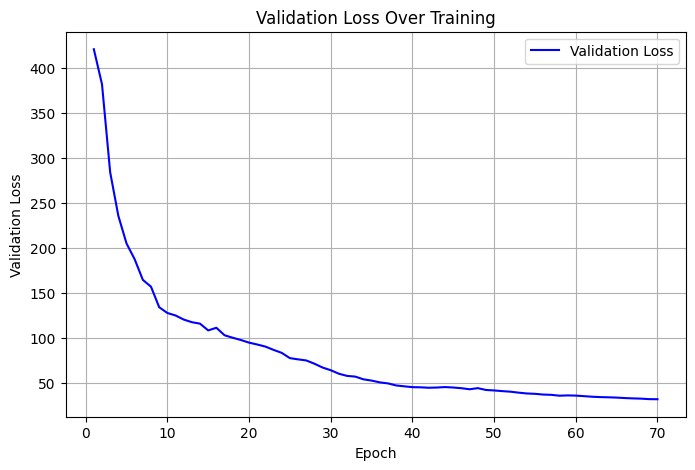

In [36]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Change this to the actual version dir
log_dir = "lightning_logs/version_1077052" 

# Load the logs
event_acc = EventAccumulator(log_dir)
event_acc.Reload()

# List all scalar tags to find the correct name
print("Available tags:", event_acc.Tags()['scalars'])

# Get the scalar events for val_loss
val_loss_events = event_acc.Scalars('val_loss')

steps = list(range(1, len(val_loss_events) + 1))
values = [e.value for e in val_loss_events]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(steps, values, label='Validation Loss', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Over Training")
plt.legend()
plt.grid(True)
plt.show()

INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1077052/events.out.tfevents.1754656407.bask-pg0308u03a.3613890.0 to lightning_logs/version_1077052/events.out.tfevents.1754667837.bask-pg0308u03a.3613890.1
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1077052/events.out.tfevents.1754667837.bask-pg0308u03a.3613890.1 to lightning_logs/version_1077052/events.out.tfevents.1754667857.bask-pg0308u03a.3613890.2
INFO:tensorboard:No path found after lightning_logs/version_1077052/events.out.tfevents.1754667857.bask-pg0308u03a.3613890.2


Available scalar tags:
['hp_metric', 'lr', 'train_loss_step', 'epoch', 'val_loss', 'val_accuracy', 'val_accuracy_0', 'val_accuracy_1', 'val_accuracy_2', 'val_accuracy_3', 'val_accuracy_4', 'val_accuracy_5', 'val_accuracy_6', 'val_sieerror', 'val_sieerror_0', 'val_sieerror_1', 'val_sieerror_2', 'val_sieerror_3', 'val_sieerror_4', 'val_sieerror_5', 'val_sieerror_6', 'train_loss_epoch', 'test_loss', 'test_accuracy', 'test_accuracy_0', 'test_accuracy_1', 'test_accuracy_2', 'test_accuracy_3', 'test_accuracy_4', 'test_accuracy_5', 'test_accuracy_6', 'test_sieerror', 'test_sieerror_0', 'test_sieerror_1', 'test_sieerror_2', 'test_sieerror_3', 'test_sieerror_4', 'test_sieerror_5', 'test_sieerror_6']


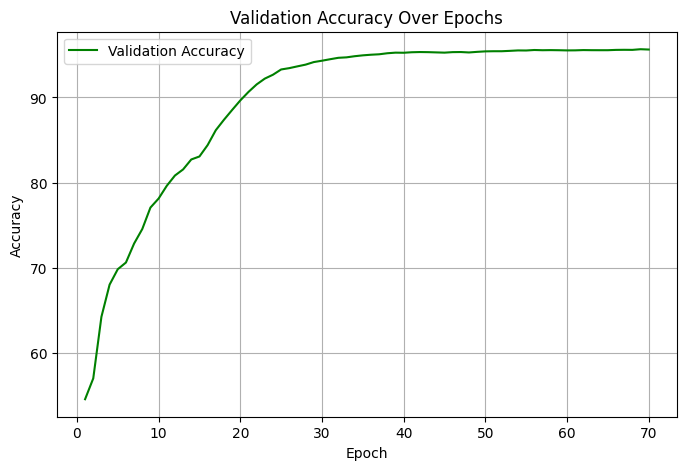

In [29]:
# Update with your actual path
log_dir = "lightning_logs/version_1077052" 

event_acc = EventAccumulator(log_dir)
event_acc.Reload()

# List all available scalar tags
print("Available scalar tags:")
print(event_acc.Tags()['scalars'])  

# Get accuracy for all lead times (overall accuracy)
accuracy_events = event_acc.Scalars('val_accuracy')

steps = list(range(1, len(accuracy_events) + 1))
values = [e.value for e in accuracy_events]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(steps, values, label='Validation Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

Plotting the forecast

In [30]:
import xarray as xr
import datetime as dt
from IPython.display import HTML

In [31]:
from icenet.plotting.video import xarray_to_video as xvid
from icenet.data.sic.mask import Masks

ds = xr.open_dataset("results/predict/example_pytorch_forecast_test.nc")
land_mask = Masks(south=True, north=False).get_land_mask()
ds.info()

xarray.Dataset {
dimensions:
	time = 2 ;
	yc = 432 ;
	xc = 432 ;
	leadtime = 7 ;

variables:
	int32 Lambert_Azimuthal_Grid() ;
		Lambert_Azimuthal_Grid:grid_mapping_name = lambert_azimuthal_equal_area ;
		Lambert_Azimuthal_Grid:longitude_of_projection_origin = 0.0 ;
		Lambert_Azimuthal_Grid:latitude_of_projection_origin = -90.0 ;
		Lambert_Azimuthal_Grid:false_easting = 0.0 ;
		Lambert_Azimuthal_Grid:false_northing = 0.0 ;
		Lambert_Azimuthal_Grid:semi_major_axis = 6378137.0 ;
		Lambert_Azimuthal_Grid:inverse_flattening = 298.257223563 ;
		Lambert_Azimuthal_Grid:proj4_string = +proj=laea +lon_0=0 +datum=WGS84 +ellps=WGS84 +lat_0=-90.0 ;
	float32 sic_mean(time, yc, xc, leadtime) ;
		sic_mean:long_name = mean sea ice area fraction across ensemble runs of icenet model ;
		sic_mean:standard_name = sea_ice_area_fraction ;
		sic_mean:short_name = sic ;
		sic_mean:valid_min = 0 ;
		sic_mean:valid_max = 1 ;
		sic_mean:ancillary_variables = sic_stddev ;
		sic_mean:grid_mapping = Lambert_Azimuth

Animate result

In [32]:
forecast_date = ds.time.values[0]
fc = ds.sic_mean.isel(time=0).drop_vars("time").rename(dict(leadtime="time"))
fc['time'] = [pd.to_datetime(forecast_date) \
              + dt.timedelta(days=int(e)) for e in fc.time.values]

anim = xvid(fc, 15, figsize=(4,4), mask=land_mask)
HTML(anim.to_jshtml())

INFO:root:Inspecting data
INFO:root:Initialising plot
INFO:root:Animating
INFO:root:Not saving plot, will return animation
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


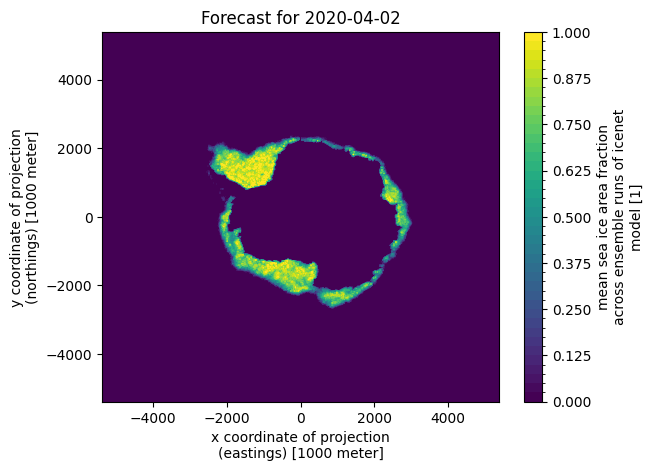

In [33]:
import xarray as xr
import matplotlib.pyplot as plt

# Select one forecast frame (e.g., time index 0)
fc_flat = fc.isel(time=0)
timestamp = pd.to_datetime(fc.time.values[0])

# Plot it flat with contourf
fc_flat.plot.contourf(levels=50, cmap='viridis')  # or any colormap you like
plt.title("Forecast SIC (flat projection)")
plt.title(f"Forecast for {timestamp.strftime('%Y-%m-%d')}")
plt.show()

Check min/max of predicted SIC fraction

In [34]:
print( forecast_np[:, :, :, 0].shape )
fmin, fmax = np.min(forecast_np[:, :, :, 0]), np.max(forecast_np[:, :, :, 0])
print( f"First forecast day min: {fmin:.4f}, max: {fmax:.4f}" )

(1, 432, 432)
First forecast day min: 0.0000, max: 1.0000


#### Load original input dataset

This is the original input dataset (pre-normalisation) for comparison.

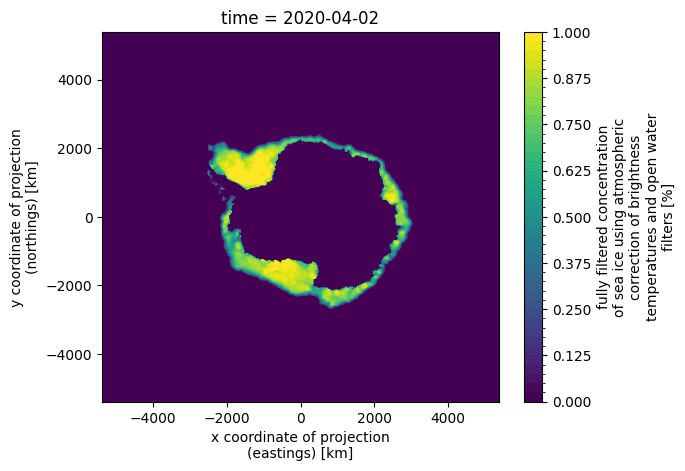

In [35]:
# Load original input dataset (domain not normalised)
xr.plot.contourf(xr.open_dataset("data/osisaf/south/siconca/2020.nc").isel(time=92).ice_conc, levels=50)

## Version
- IceNet Codebase: v0.2.8